In [161]:
import numpy as np
import os
from astropy.io import fits
from astropy import wcs
import glob
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.lines import Line2D
from astropy.coordinates import SkyCoord
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from scipy.optimize import curve_fit
import optical_overlay_plots as oop
import source_search as ss
import co_masses as co
import mstar_sfr as ms
import photometry as ph
from matplotlib.patches import Rectangle, Ellipse
import scipy.odr as odr
import pandas as pd
from scipy.io import readsav

from photutils.aperture import SkyCircularAperture as sca
from photutils.aperture import aperture_photometry
from photutils import data_properties, EllipticalAperture, deblend_sources
from photutils.segmentation import detect_sources, source_properties
from astropy.table import Table, join

cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
cosmo75 = FlatLambdaCDM(H0=75, Om0=0.3)

In [4]:
from photutils import detect_sources, source_properties
#ref: https://photutils.readthedocs.io/en/stable/api/photutils.segmentation.SourceProperties.html#photutils.segmentation.SourceProperties
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm 
from matplotlib.colors import ListedColormap
from astropy.visualization import astropy_mpl_style
from astropy.convolution import Tophat2DKernel
from astropy.modeling.functional_models import Ellipse2D
from math import floor
plt.style.use(astropy_mpl_style)
import astropy.units as u
    

## Get fluxes and errors from MIPS catalogues (change next cell to code)

import astropy.io as apio
xmmcatfile = '/Users/dee/Documents/ALMA/catalogues/cdfs_24_aopbmg.tbl'

xmmcat = apio.ascii.read(xmmcatfile)

xmmmips_ap1 = np.array(xmmcat['col8'])
xmmmips = np.array(xmmcat['col13'])
xmmerr = np.array(xmmcat['col14'])
xmmra = np.array(xmmcat['col17'])
xmmdec = np.array(xmmcat['col19'])

catcoords = SkyCoord(ra=xmmra*u.deg, dec=xmmdec*u.deg)

tol = 1*u.arcsec
searchra, searchdec =  53.839645,-29.61118
searchcoord = SkyCoord(ra=searchra*u.deg, dec=searchdec*u.deg, frame='fk5')

linenumber = np.where(catcoords.separation(searchcoord) < tol)[0]
idval = xmmid[linenumber]
idval

# Science Plots

In [5]:
# our galaxies
gals = ['XMM-1', 'XMM-2', 'XMM-3', 'XMM-5', 'XMM-6', 'XMM-8', 'ES1-1', 'ES1-2', 'ES1-3', 'ES1-4', 'ES1-7', 'ES1-8',
        'ES1-9', 'ES1-10', 'CDFS-1', 'CDFS-2', 'CDFS-3', 'CDFS-4', 'CDFS-5', 'CDFS-7', 'CDFS-8', 'CDFS-11', 'CDFS-12',
       'CDFS-13']
lims = ['XMM-4', 'XMM-7','ES1-5','CDFS-6','CDFS-9','CDFS-10']

z = np.array([1.0032895, 0.45659, 0.64986914, 0.78256, 0.20429, 0.21201, 0.34459, 1.08807, 0.8068, 0.72811, 
              0.65665, 0.56395, 1.19372, 0.74744, 0.28907, 0.21505, 0.80761, 0.45114, 0.69484, 0.67603, 0.59499, 
              0.31894, 0.34224, 0.35673]) 

fwhma = np.array([6.259e+01, 2.256e+02, 5.689e+01, 1.154e+02, 2.010e+02, 2.137e+02, 8.010e+01, 8.152e+01, 1.713e+02,
                  2.299e+02, 1.676e+02, 1.076e+02, 6.660e+01, 2.098e+02, 2.371e+02, 6.154e+01, 2.398e+02, 2.097e+02, 
                  1.837e+02, 1.905e+02, 2.004e+02, 2.411e+01, 1.902e+02, 1.392e+02])*2*np.sqrt(2*np.log(2))

zlimits = np.array([0.7634113, 1.03458, 0.47762, 0.6643, 0.44277, 0.30793])

bkgz = np.array([0.625957190046823, 0.747434191562314, 0.289071524357134])

mgas = np.array([6.929e+09, 1.490e+09, 5.937e+09, 1.975e+10, 1.204e+09, 2.174e+09, 1.009e+09, 1.207e+10, 1.314e+10,
                 1.050e+10, 3.597e+09, 6.533e+09, 1.617e+10, 8.607e+09, 1.529e+10, 2.583e+09, 1.342e+09, 4.253e+09,
                 1.210e+10, 3.462e+09, 5.673e+09, 1.620e+09, 1.857e+09, 3.860e+09])*4.36*0.85/0.77

altmgas = np.array([6.929e+09, 5.939e+08, 5.937e+09, 1.975e+10, 1.204e+09, 2.174e+09, 1.009e+09, 1.207e+10, 1.314e+10,
                 1.050e+10, 3.597e+09, 6.533e+09, 1.617e+10, 8.607e+09, 1.529e+10, 2.583e+09, 1.342e+09, 4.253e+09,
                 1.210e+10, 3.657e+09, 5.673e+09, 1.620e+09, 1.857e+09, 3.860e+09])*4.36*0.85/0.77

mgas = mgas*cosmo.luminosity_distance(z)**2 / cosmo75.luminosity_distance(z)**2
altmgas = altmgas*cosmo.luminosity_distance(z)**2 / cosmo75.luminosity_distance(z)**2

mgaslimits = np.array([5.35068e+08, 1.03351e+09, 4.20766e+08, 4.64691e+08, 2.52682e+08, 1.45293e+08])*4.36*0.85/0.77
mgaslimits = mgaslimits*cosmo.luminosity_distance(zlimits)**2 / cosmo75.luminosity_distance(zlimits)**2 * 3

our24umlimits = np.array([2627.774735, 1147.719259, 230.413336, 1807.802747, 259.758431, 179.331134])

dour24umlimits = np.array([18.838826, 21.737107, 20.408728, 17.510447, 16.665116, 14.732928])

our36umlimits = np.array([0.00023280, 0.00026534, 0.00030292, 0.00032648, 0.00028125, 0.00053467])*u.Jy

bkgmgas = np.array([1.334e+09, 3.202e+09, 3.487e+08])*4.36*0.85/0.77
bkgmgas = bkgmgas*cosmo.luminosity_distance(bkgz)**2 / cosmo75.luminosity_distance(bkgz)**2

dmgas = np.array([2.916e+09, 5.479e+08, 2.046e+09, 2.420e+09, 3.789e+08, 5.365e+08, 8.615e+08, 2.585e+09, 2.637e+09,
                  2.285e+09, 1.414e+09, 1.146e+09, 2.036e+09, 2.964e+09, 1.192e+09, 1.616e+08, 9.596e+08, 9.591e+08,
                  2.539e+09, 1.154e+09, 1.859e+09, 2.471e+08, 8.373e+08, 5.593e+08])*4.36*0.85/0.77
altdmgas = np.array([2.916e+09, 2.304e+08, 2.046e+09, 2.420e+09, 3.789e+08, 5.365e+08, 8.615e+08, 2.585e+09, 2.637e+09,
                     2.285e+09, 1.414e+09, 1.146e+09, 2.036e+09, 2.964e+09, 1.192e+09, 1.616e+08, 9.596e+08, 9.591e+08,
                     2.539e+09, 1.695e+09, 1.859e+09, 2.471e+08, 8.373e+08, 5.593e+08])*4.36*0.85/0.77

dmgas = dmgas*cosmo.luminosity_distance(z)**2 / cosmo75.luminosity_distance(z)**2
altdmgas = altdmgas*cosmo.luminosity_distance(z)**2 / cosmo75.luminosity_distance(z)**2

bkgdmgas = np.array([3.226e+08, 5.835e+08, 1.190e+08])*4.36*0.85/0.77
bkgdmgas = bkgdmgas*cosmo.luminosity_distance(bkgz)**2 / cosmo75.luminosity_distance(bkgz)**2

# from apparent magnitudes in the IRAC table tracy sent
our36umbf = np.array([0.00023255, 0.00027548, 0.00021827, 0.00017549, 0.00080073, 0.00044766, 0.00046102, 0.00006569,
                   0.00012063, 0.00009124, 0.00014296, 0.00010268, 0.00006291, 0.00020193, 0.00061852, 0.00030919,
                   0.00016143, 0.00021313, 0.00016762, 0.00018736, 0.00023639, 0.00017625, 0.00022203, 
                   0.00027027])*u.Jy

# kron fluxes from SWIRE catalogs
our36um = np.array([234.23, 288.34, 242.39, 175.41, 885.43, 436.44, 665.20, 64.51, 121.69, 92.59, 155.08, 100.41,
                    63.67, 208.51, 638.85, 316.83, 159.39, 361.53, 176.91, 186.74, 257.95, 191.85, 235.45, 
                    286.01])*u.uJy
dour36um = np.array([1.88, 2.17, 2.26, 1.84, 4.06, 2.54, 3.33, 1.01, 1.36, 1.23, 1.23, 1.40, 1.18, 2.09, 2.68, 2.25,
                     1.67, 3.42, 1.71, 1.76, 1.65, 1.92, 1.73, 1.32])*u.uJy
# 3.6um photometry with other apertures
our36um82ap = np.array([255.75, 304.34, 230.61, 190.01, 684.20, 451.11, 410.84, 71.28, 126.06, 99.17, 160.42,
                        108.70, 69.35, 198.26, 616.72, 314.80, 161.06, 233.51, 185.97, 195.35, 270.20, 178.78,
                        231.66, 290.03])

dour36um82ap = np.array([2.08, 2.30, 2.06, 2.00, 3.40, 2.66, 2.15, 1.17, 1.36, 1.31, 1.24, 1.53, 1.30, 1.97, 2.69,
                         2.25, 1.69, 2.04, 1.78, 1.80, 1.72, 1.76, 1.71, 1.32])

our36um116ap = np.array([257.13, 311.83, 244.97, 188.39, 769.67, 466.29, 473.70, 71.68, 130.16, 100.64, 165.95,
                         111.40, 71.49, 212.97, 653.27, 330.13, 169.42, 269.61, 186.32, 196.69, 273.94, 194.66,
                         245.13, 300.65])

dour36um116ap = np.array([2.22, 2.43, 2.22, 2.15, 3.61, 2.76, 2.32, 1.43, 1.57, 1.48, 1.36, 1.72, 1.52, 2.15, 2.76,
                          2.35, 1.81, 2.26, 1.89, 1.91, 1.79, 1.91, 1.82, 1.41])


our36um = our36um.to(u.Jy)
dour36um = dour36um.to(u.Jy)

our45um = np.array([304.65, 289.01, 146.78, 128.91, 633.03, 359.43, 398.98, 53.37, 97.95, 62.98, 94.99, 72.39, 66.87,
                    129.65, 604.01, 281.27, 127.00, 184.77, 119.22, 117.30, 231.09, 174.03, 186.36, 280.90])*u.uJy
dour45um = np.array([2.33, 2.54, 2.66, 2.23, 4.24, 2.89, 3.66, 1.37, 2.25, 1.49, 1.52, 1.72, 1.71, 2.43, 3.38,
                     2.39, 1.94, 2.26, 1.88, 1.88, 1.95, 2.44, 2.07, 1.50])*u.uJy
our45um = our45um.to(u.Jy)
dour45um = dour45um.to(u.Jy)

our58um = np.array([379.52, 251.79, 93.05, 128.04, 372.12, 369.98, 242.55, np.nan, 147.35, 50.66, 85.42, 80.25, 
                    np.nan, 95.78, 492.47, 239.06, 127.58, 99.51, 93.43, 60.67, 284.86, 84.65, 108.66, 337.77])*u.uJy
dour58um =  np.array([8.25, 6.85, 8.16, 7.83, 12.37, 15.60, 12.02, np.nan, 9.36, 6.43, 5.73, 6.65, np.nan, 6.54, 
                      9.62, 8.43, 6.05, 7.39, 7.09, 5.78, 6.81, 7.16, 5.90, 6.96])*u.uJy
our58um = our58um.to(u.Jy)
dour58um = dour58um.to(u.Jy)

our80um = np.array([675.86, 352.73, np.nan, 126.76, 384.47, 1479.05, 106.16, 28.49, np.nan, 44.00, np.nan, 77.69,
                    31.82, 79.53, 1571.84, 1314.10, 93.59, 
                    204.82, np.nan, np.nan, 314.52, 225.77, 197.01, 536.33])*u.uJy
dour80um = np.array([10.44, 9.36,  np.nan, 9.19, 11.30, 15.30,  8.08, 4.35, np.nan, 4.25, np.nan, 6.64, 4.30, 6.22, 
                     10.73, 10.27, 6.08, 7.55, np.nan, np.nan, 7.16, 10.08, 8.68, 6.31])*u.uJy
our80um = our80um.to(u.Jy)
dour80um = dour80um.to(u.Jy)

# from apparent magnitudes in the IRAC table tracy sent
our45umbf = np.array([0.00052507, 0.00043172, 0.00021627, 0.0002032 , 0.00094041, 0.00059628, 0.00053749, 0.00009021,
                   0.00014292, 0.00009822, 0.00014772, 0.00012090, 0.00009391, 0.00018495, 0.00095859, 0.00044502,
                   0.00020807, 0.00024376, 0.00019142, 0.00018422, 0.00036823, 0.00024513, 0.00030634, 
                   0.00043942])*u.Jy

mips = np.array([2214.769698, 700.900945, 376.897286, 1082.024891, 384.505274, 1763.120916, 277.510402, 258.188529,
                542.099301, 377.501095, 313.49739, 599.702635, 505.508504, 314.825769, 2971.945598, 6011.517752, 
                403.585623, 634.602768, 535.69893, 239.349702, 1038.550676, 587.022656, 282.461632, 1877.844537])

dmips = np.array([22.220154, 18.235018, 18.959588, 20.408728, 18.355779, 17.751971, 23.790056, 18.959588, 20.891775,
                 19.684158, 23.427771, 19.684158, 23.186248, 19.442635, 16.30283, 17.510447, 17.148162, 12.196932, 
                 16.544354, 14.491405, 17.510447, 14.732928, 17.268924, 15.095213])

our24um105ap = np.array([2422.02, 807.14, 525.24, 1153.00, 438.57, 2535.90, np.nan, np.nan, 546.33, np.nan, np.nan, 
                         636.94, 415.28, np.nan, 3509.38, 6224.08, 690.74, 635.39, 623.39, np.nan, 984.78, 409.90,
                         np.nan, 1964.51])*u.uJy
dour24um105ap = np.array([38.70, 34.42, 36.69, 38.43, 35.22, 31.84, ])*u.uJy

our24um15ap = np.array([2736.05, 892.97, 568.52, 1121.08, 487.72, 2703.17, np.nan, np.nan, 636.94, np.nan, np.nan, 
                        517.79, 326.74, np.nan, 3712.60, 6353.45, 988.02, 599.37, 855.32, np.nan, 969.48, 349.42,
                        np.nan, 1959.42])*u.uJy
dour24um15ap = np.array([49.07, 44.26, 46.70, 48.84, 44.73, 40.58])*u.uJy

ngal = np.array([21.4841, 18.0961, 22.1464, 15.202, 22.11, 17.1404, 42.5143, 30.6634, 11.8816, 12.4581, 34.9834,
                 15.2988, 14.1176, 17.8978, 10.5519, 12.974, 10.699, 19.0493, 14.1326, 16.955, 19.9198, 8.623,
                 9.974, 7.5618])

dngal = np.array([4.4229, 3.9703, 4.5281, 3.5305, 4.4671, 3.9225, 6.6811, 5.4662, 2.9525, 2.793, 5.9762, 3.5491,
                  3.3191, 3.9654, 2.756, 3.2143, 2.7891, 4.1355, 3.3221, 3.7964, 4.2529, 2.3683, 2.6565, 2.1357])

fastmstar = np.power(10, np.array([10.20, 10.90, 11.01, 11.16, 11.07, 10.51, 11.47, 10.74, 10.79, 10.95, 11.04, 
                                   10.72, 9.81, 11.28, 11.25, 10.62, 11.23, 10.98, 10.99, 11.05, 10.46, np.nan, 11.03, 
                                   10.72]))

In [6]:
mips_err = np.array([22.220, 18.235, 18.960, 20.409, 18.356, 17.752,  23.790, 18.960, 20.892, 19.684, 23.428,
                    19.684, 23.186, 19.443, 16.302, 17.510, 17.148, 12.197, 16.544, 14.491, 17.510, 14.733, 17.269, 
                    15.095])

mips_err += 0.3 * mips

In [7]:
# EDGE01 galaxies
# BCGs of 'extreme cooling-flow clusters'
# have CO 1-0, 2-1, 3-2, and 4-3

# cluster masses, dust masses, and molecular gas masses all listed in Popesso 2020 (table 3 in appendix)

ecosmo = FlatLambdaCDM(H0=50, Om0=0.3)

egals = ['A11', 'A262', 'A291', 'RX JO338+09', 'RX J0352+19', 'A478', 'RX J0439+05', 'RX J0747-19/PKS 0745–191',
         'A646', 'RX J0821+07', '4C + 55.19/NGC3079',
        'Zw 2089', 'Hydra A', 'Zw 3146', 'A1068', 'Zw 3916', 'A1664', 'RX J1347-11', 'A1795',
        'A1835', 'Zw 7160', 'RX J1532+30', 'A2146', 'A22204', 'Zw 8193', 'Zw 8197', 'Zw 8276',
        'A2390', 'A2597', 'NGC 1275', 'I09104+41', '3C 48', 'R0107+32', 'A1367']
einscidx = np.array([1, 7, 8, 9, 14, 18, 24])

ez = np.array([0.1503, 0.0171, 0.196, 0.0338, 0.109, 0.0882, 0.208, 0.1028, 0.1268,
              0.110, 0.242, 0.235, 0.052, 0.2906, 0.1386, 0.204, 0.1276, 0.4503, 0.0620,
              0.2523, 0.2578, 0.3615, 0.2343, 0.1514, 0.1825, 0.1140, 0.0757, 0.2328, 0.0852,
              0.0184, 0.4420, 0.3695, 0.0175, 0.218])

elgas = np.array([0.45, 1.61, 0.16, 2.83, 1.20, 0.54, 0.3, 0.3, 0.2, 2.90, 0.3, 0.11, 0.3, 0.74, 3.73, 0.15, 1.86,
                  0.15, 0.23, 1.03, 0.25, 0.74, 0.14, 0.41, 0.72, 0.35, 0.60, 0.2, 0.47, -1, -1, -1, -1, -1])

etrans = np.array([1, 2, 1, 2, 2, 2, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, -99, -99,
                  -99, -99, -99])

edlgas = np.array([0.13, 0.26, 0.08, 0.24, 0.24, 0.17, -99, -99, -99, 0.19, -99, 0.04, -99, 0.13, 0.07, -99, 0.26,
                   -99, 0.06, 0.13, 0.09, 0.11, 0.07, 0.11, 0.15, 0.08, 0.09, -99, 0.19, -99, -99, -99, -99, -99])
# area under the peak in K km s-1 (i think)

emgas50 = np.array([2.6e10, 9e8, 2.3e10, 3.9e9, 1.2e10, 4.5e9, 3.3e10, 7.6e9, 1.3e10,
                    3.9e10, 4.5e10, 4.6e10, 2e9, 1.6e11, 8.5e10, 1.6e10, 4.4e10, 6.8e10, 2.7e9,
                    1.8e11, 6.1e10, 2.5e11, 3.5e10, 2.3e10, 4.3e10, 1.1e10, 8.2e9, 4.9e10, 8.1e9,
                    1.7e10, 5.1e10, 1.6e10, 2.2e9, 5.2e8])

emgas = emgas50 * cosmo.luminosity_distance(ez)**2 / ecosmo.luminosity_distance(ez)**2

edmgas50 = np.array([7e9, 1.3e8, -1, 0.4e9, 0.3e10, 2.6e9, -1, -1, -1, 0.4e10, -1, -1, -1, 0.3e11, 0.6e10,
                  -1, 0.7e10, -1, -1, 0.2e11, 2.4e10, 0.4e11, -1, 0.6e10, -1, 0.3e10, 1.2e9, -1, 3.3e9,
                  0.2e10, -1, 0.6e10, 0.3e9, 1e8])
edmgas = edmgas50 * cosmo.luminosity_distance(ez)**2 / ecosmo.luminosity_distance(ez)**2

# esfr = [35, 0.54, 6.3, 2.1, 11.1, 'A478', 18.7, 17.2, 7.1, 
#          37, 5.6,
#         271, 'Hydra A', 61, 254.4, 'Zw 3916', 14.6, 'RX J1347-11', 'A1795',
#         202.0, 'Zw 7160', 97, 'A2146', 'A22204', 59, 3.6, 3.7,
#         8.8, 2.1, 'NGC 1275', 'I09104+41', '3C 48', 'R0107+32', 'A1367']
# sfr for NGC 3079 from https://arxiv.org/pdf/1005.5251.pdf
esfr = np.array([35, 0.54, 6.3, 2.1, 11.1, -99, 18.7, 17.2, 7.1, 37, 5.6, 271, -99, 61, 254.4, -99, 14.6, -99,
                 -99, 202.0, -99, 97, -99, -99, 59, 3.6, 3.7, 8.8, 2.1, -99, -99, -99, -99, -99])
# o'Dea et al estimates using IR luminsoity and Bell (2003):
# SFR = A(L_IR/L_sun)(1+sqrt(10^9 Lsun/L_IR)) with A=1.57e-10 for Lir > 1e11 Lsun and A=1.17e-10 otherwise


edsfr = ['A11', 'A262', 'A291', 'RX JO338+09', 'RX J0352+19', 'A478', 'RX J0439+05', 'RX J0747-19', 'A646', 
         'RX J0821+07', '4C + 55.19',
        'Zw 2089', 'Hydra A', 6, 6.8, 'Zw 3916', 'A1664', 'RX J1347-11', 'A1795',
        0.5, 'Zw 7160', 'RX J1532+30', 'A2146', 'A22204', 'Zw 8193', 'Zw 8197', 'Zw 8276',
        0.1, 0.2, 'NGC 1275', 'I09104+41', '3C 48', 'R0107+32', 'A1367']

emstellar = ['A11', 'A262', 'A291', 'RX JO338+09', 'RX J0352+19', 'A478', 'RX J0439+05', 'RX J0747-19/PKS 0745–191',
         'A646', 'RX J0821+07', '4C + 55.19/NGC3079',
        'Zw 2089', 'Hydra A', 'Zw 3146', 'A1068', 'Zw 3916', 'A1664', 'RX J1347-11', 'A1795',
        'A1835', 'Zw 7160', 'RX J1532+30', 'A2146', 'A22204', 'Zw 8193', 'Zw 8197', 'Zw 8276',
        'A2390', 'A2597', 'NGC 1275', 'I09104+41', '3C 48', 'R0107+32', 'A1367']

# e36um = [1.36, 16.93, 1.16, 9.43, 2.04, 'A478', 1.71, 3.95,
#          1.78, 2.52, '4C + 55.19/NGC3079',
#         0.94, 'Hydra A', 'Zw 3146', 3.41, 1.43, 2.27, 'RX J1347-11', 'A1795',
#         'A1835', 'Zw 7160', 0.82, 1.18, 3.31, 4.92, 2.17, 3.24,
#         'A2390', 'A2597', 'NGC 1275', 'I09104+41', '3C 48', 'R0107+32', 'A1367']
e36um = np.array([1.36, 16.93, 1.16, 9.43, 2.04, -99, 1.71, 3.95, 1.78, 2.52, -99, 0.94, -99, -99, 3.41, 1.43, 2.27,
                  -99, -99, -99, -99, 0.82, 1.18, 3.31, 4.92, 2.17, 3.24, -99, -99, 7.581, -99, -99, -99, -99])
e36um = (e36um*u.mJy).to(u.Jy)

# value for NGC 1275 from IPAC 2010MNRAS.408.1982L
# NGC 3079 has 3.2um in https://arxiv.org/pdf/1005.5251.pdf
# Hydra A has 4.5, 8 um in IPAC refcode 2011ApJ...732...40D

e45um = np.array([1.03, 9.97, 0.87, 5.70, 1.57, -99, 1.36, 2.76, 1.27, 1.81, -99, 1.15, -99, -99, 2.98, 1.12, 1.61,
                  -99, -99, -99, -99, 0.71, 1.19, 2.43, 3.73, 1.48, 2.15, -99, -99, 8.912, -99, -99, -99, -99])*u.mJy
e45um = e45um.to(u.Jy)

e58um = np.array([0.89, 7.96, 0.54, 4.55, 1.41, -99, 0.85, 2.12, 0.85, 1.62, -99, 1.77, -99, -99, 3.66, 0.62, 1.34,
                  -99, -99, -99, -99, 0.48, 1.37, 1.67, 2.40, 0.97, 1.63, -99, -99, 13.22, -99, -99, -99, -99])*u.mJy
e58um = e58um.to(u.Jy)

e80um = np.array([1.71, 6.57, 0.50, 9.61, 2.07, -99, 0.92, 2.87, 0.77, 7.03, -99, 3.94, -99, -99, 9.23, 0.49, 2.67,
                  -99, -99, -99, -99, 0.95, 2.53, 1.79, 3.99, 0.99, 1.62, -99, -99, 29.11, -99, -99, -99, -99])*u.mJy
e80um = e80um.to(u.Jy)


e24um = np.array([10.59, 4.03, 0.53, 2.39, 5.14, -99, 2.10, 10.34, 2.52, 18., 3520, 33.59, 7.861900, -99, 74.47,
                  0.41, 4.01, -99, -99, -99, -99, 3.77, 24.10, 2.85, 10.66, 0.85, 3.22, -99, -99, 2822.7, -99,
                  1.310000e+2, -99, -99])*u.mJy
e24um = e24um.to(u.uJy)
                 
# value for NGC 3079 from https://arxiv.org/pdf/1005.5251.pdf
# value for Hydra A from IPAC refcode 2013SSTSLC4.2....0C
# value for NCG 1275 from IPAC 2013SSTSLC4.2....0C
# value for 3C 48 from IPAC 2005ApJ...629...88S


# https://arxiv.org/pdf/2006.09224.pdf
emcluster = np.array([-99, 1.6, -99, -99, 8.38, 10.1, 18.7, -99, 9.10, 5.25, -99, 16.6, 4, 30, 2.29, 10.5, 9.46, 
                      16, 7, 31.8, 17.2, 28.9, 8.5, 25, 7.09, 6.9, 8.4, 28, 8.8, 12, 8.2, -99, -99, 3.5])*1e14

eggoodidx = np.where(np.logical_and(edmgas > 0, e80um > 0))[0]

efwhm = np.array([264, 289, 303, 320, 345, 300, 173, 457, 129, 149, 168, 380, 380])

In [8]:
# casastignani et al 2020 (A&A manuscasript): Molecasular gas in casLASH BcasGs
# casluster Lensing and Supernova survey with Hubble
# dense-casores, x-ray selecasted (casool casore?)

casgals = ['A209', 'M0329', 'M0429', 'M0647', 'M0744', 'A611', 'M1115', 'A1423', 'M1206', 'casL1226', 'M1311', 'RX1347',
        'M1423', 'RX1532', 'M1720', 'A2261', 'M1932', 'M2129', 'RX2129']

casz = np.array([0.206, 0.450, 0.399, 0.591, 0.686, 0.288, 0.352, 0.213, 0.440, 0.891, 0.494, 0.451, 0.545, 0.361,
              0.391, 0.224, 0.353, 0.570, 0.234])

casmstellar = np.array([2, 3.69, 4.68, 5.13, 8.20, 3.45, 2.19, 1.96, 4.93, 15, 4.49, 3.68, 4.95, 2.2, 3.83, 1.74, 
                      6.9, 2.44, 2.21])*1e11

casdmstellar = np.array([0.16, 0.21, 0.23, 1.79, 0.43, 0.42, 0.17, 0.11, 1.39, 1.99, 1.05, 0.85, 0.13, 0.05, 0.94, 
                      0.18, 0.8, 0.17, 0.32])*1e11

casmgas = np.array([2, 3.4, 3.3, 4.5, 6.6, 1.8, 2.1, 1.7, 3, 11.7, 2.1, 2.5, 5.1, 8.7,
                 3, 2, 9.2, 5.6, 1.2])*1e10

casdmgas = np.array([-1, 1, -1, -1, -1, -1, -1, 0.5, 1, -1, -1, -1, -1, 1.1, -1, -1, 1.5,
                  1.4, -1*1e10])

castransition = np.array([1, 1, 2, 1, 2, 2, 2, 1, 1, 1, 1, 2, 4, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1])

In [9]:
# Genzel et al. 2010 A study of the gas-star formation relation over cosmic time 
# z ~1-3 normal star-forming galaxies

# Molecular gas mass: Mmol-gas= 1.36 α R1JLJ(CO) (M⊙), where α is the conversion factor (3.2 for SFGs, 
# 1 for z≥ 1 SMGs) and R1J=L′CO 1-0/L′CO J-(J−1)= 1.2 and 2 for J= 2 and 3 SFGs. For the z≥ 1 SMGs we use R1J= 1.1, 
# 1.3 and 1.6 for J= 2, 3 and 4. Conversion factors are probably uncertain by ±30 per cent for SFGs and a factor of 
# at least ±50 per cent for z∼ 0 ULIRG/z≥ 1 SMGs.

# Stellar masses for a Chabrier IMF, obtained from SED population synthesis fitting to the combined 
# UV/optical/near-IR SEDs (Erb et al. 2006b; Noeske et al. 2007; Daddi et al. 2007, 2010a; Förster Schreiber et al. 
# 2009); uncertainty ±40 per cent.

ggals = ['EGS13004291', 'EGS12007881', 'EGS13017614', 'EGS13035123', 'EGS13004661', 'EGS13003805', 'EGS12011767',
         'EGS12012083', 'EGS13011439', 'EGS13011148', 'HDF-BX1439', 'Q1623-BX599', 'Q1623-BX663', 'Q1700-MD69', 
         'Q1700-MD94', 'Q1700-MD174', 'Q1700-BX691', 'Q2343-BX389', 'Q2343-BX442', 'Q2343-BX610', 'Q2343-MD59',
         'SMMJ02399-0136', 'SMMJ09431+4700', 'SMMJ105141+5719', 'SMMJ123549+6215', 'SMMJ123634+6212', 
         'SMMJ123707+6214', 'SMMJ131201+4242', 'SMMJ131232+4239', 'SMMJ163650+4057', 'SMMJ163658+4105', 
         'BzK4171', 'BzK210000', 'BzK16000', 'BzK17999']

gz = np.array([1.20, 1.17, 1.18, 1.12, 1.19, 1.23, 1.28, 1.12, 1.10, 1.17, 2.19, 2.33, 2.43, 2.29, 2.34, 2.34, 2.19,
               2.17, 2.18, 2.21, 2.01, 2.81, 3.35, 1.21, 2.20, 1.22, 2.49, 3.41, 2.33, 2.39, 2.45, 1.47, 1.52, 1.52, 
               1.41])

gmgas = np.array([2.8e+11, 8.3e+10, 9.3e+10, 1.3e+11, 2.4e+10, 1.8e+11, 2.6e+10, -8.7e+09, 4.5e+10, 3.0e+10, -5.9e+10,
                  1.6e+11, -5.1e+10, 1.1e+11, 5.3e+11, 1.6e+11, 3.5e+10, -3.3e+10, 1.0e+11, 2.3e+11, 9.2e+10, 8.8e+10,
                  5.5e+10, 3.4e+10, 7.1e+10, 5.2e+10, 3.4e+10, 6.7e+10, 5.0e+10, 1.2e+11, 1.0e+11, 9.4e+10, 1.0e+11,
                  6.6e+10, 7.7e+10])

gdmgas = 0.30*gmgas

gmstellar = np.array([3.3e+11, 1.6e+11, 1.1e+11, 3.4e+11, 3.0e+10, 2.1e+11, 1.2e+11, 5.2e+10, 1.3e+11, 1.6e+11, 
                      5.7e+10, 5.7e+10, 6.9e+10, 1.9e+11, 1.5e+11, 2.4e+11, 7.6e+10, 6.9e+10, 1.5e+11, 1.7e+11,
                      7.6e+10, -99, -99, -99, 1.2e+11, -99, 1.2e+11, -99, -99, 2.3e+11, 2.6e+11, 6.5e+10, 6.5e+10,
                      6.5e+10, 6.5e+10])

gdmstellar = 0.40*gmstellar

In [10]:
# Hatsukade et al. 2020 molecular gas mass of GAMMA-RAY BURST HOST GALAXIES

hz = np.array([0.296, 1.057, 0.480, 1.923, 1.496, 0.979, 0.983, 1.416])

hmgas = np.array([2.9e9, 3.6e10, 5.9e9, 5.7e10, 2.9e10, 2.0e10, 1.9e10, 4.3e10])

hdmgas = np.array([0.5e9, 0.4e10, 1.7e9, 1.1e10, 0.5e10, 0.3e10, 0.3e10, 0.5e10])

In [11]:
# Decarli et al. 2016 ALMA SPECTROSCOPIC SURVEY IN THE HUBBLE ULTRA DEEP FIELD: MOLECULAR GAS RESERVOIRS IN HIGH–
# REDSHIFT GALAXIES 
# ALMA spectroscopic survey of Hubble UDF - mostly main sequence field galaxies

# molecular gas mass is assuming αCO=3.6 M(K km s−1pc2)−1
# sfr, mstar, and ssfr all found by SED fitting with MAGPHYS using 26 photometric measurements from 8um to U-band

decid = np.arange(11) + 1

decz = np.array([2.543, 1.551, 1.382, 1.088, 1.098, 1.094, 1.221, 0.999, 2.447, 2.224, 0.895])

decmgas = np.array([206, 65, 15.9, 13.4, 15, 25, 10, 2.3, 21, 19, 6.2])*1e9

decdmgas = np.array([34, 8, 1.9, 1.7, 4, 6, 3, -1, -1, -1, -1])*1e9

decmstellar = np.array([17.8, 275, 52, 28, 5.8, 75, 15.1, 70, 2.6, 12, 15.9])*1e10

decdmstellarup = np.array([1.8, 70, 12, 7, 0.6, 12, 1.5, 11, 0.3, 1.2, 9])*1e10

decdmstellardown = np.array([1.7, 40, 10, 5, 0.5, 13, 1.4, 17, 0.2, 1.2, 1.4])*1e10

decsfr = np.array([63, 74, 18, 23, 44, 16, 148, 40, 11.8, 22, 42])

decssfr = decsfr/decmgas*1e9

decdsfrup = np.array([6., 60, 9, 20, 4, 11, 15, 14, 1.2, 41, 4])

decdsfrdown = np.array([6, 30, 7, 9, 4, 6, 13, 9, 1.1, 2, 12])


In [12]:
# salome and Combes 2003  Cold molecular gas in cooling flows clusters of galaxies
# https://www.aanda.org/articles/aa/pdf/2003/49/aa2615.pdf
# same alpha as edge on purpose

scgals = ['A262', 'PKS 0745-191', 'RX J0821+07', 'A1068', 'A1795' 'Z8193', 'A496', 'A646', 'A780', 'A2657', 'A85', 
          'Z235', 'A291', 'A644', 'RX J0439+05', 'A978', 'A1668', 'A2029', 'MKW3S', 'A2146', 'A2142', 'A2147', 
          'A2151', 'A2199', 'A2261', 'A2319', 'CygA', 'A2462', 'A2597', 'A2626', 'A2634', 'A2665']

scz = np.array([0.01620, 0.10280, 0.11, 0.13860, 0.06326, 0.18290, 0.03281, 0.12680, 0.05384, 0.04023, 0.05567, 0.083,
                0.19590, 0.07040, 0.208, 0.05425, 0.06368, 0.07795, 0.04531, 0.23370, 0.09037, 0.03532, 0.03533,
               0.03035, 0.2240, 0.05459, 0.05607, 0.07437, 0.07437, 0.05490, 0.03022, 0.05610])

scmgas = np.array([2.3e8, 4e9, 1.3e10, 4.2e10, 4.8e10, 1.5e10, 4.3e8, 7.9e9, 2e9, 2.9e8, 8.8e8, 2.5e9, 1.1e10,
                   1.1e9, 9.8e9, 9.3e8, 1.5e9, 1.7e9, 5.2e8, 8.6e9, 1.8e9, 4.3e8, 3.1e8, 2.6e8, 1.3e10, 6.6e8,
                   1.4e9, 1.6e9, 1.8e9, 7.6e8, 3.2e8, 7.9e8])

scdmgas = np.array([0.3e8, 0.9e9, 0.2e10, 0.2e10, 0.6e9, 0.3e10, 1.0e8, 0.2e9, 0.3e9, 0.1e8, -99, -99, -99, -99, -99,
                    -99, -99, -99, -99, -99, -99, -99, -99, -99, -99, -99, -99, -99, -99, -99, -99, -99, -99])

In [13]:
# PHIBSS2 galaxies https://arxiv.org/pdf/1812.08180.pdf
# galactic Xco - alpha_co = 4.36 and r_21 = 0.77

phibss2z = np.array([0.7, 0.6227, 0.7028, 0.5297, 0.5020, 0.6223, 0.7028, 0.7026, 0.7506, 0.7007, 0.6967, 
                    0.6077, 0.6793, 0.5165, 0.7021, 0.5172, 0.6248, 0.7503, 0.5024, 0.6885, 0.5015, 0.6081, 0.6976,
                    0.6985, 0.7007, 0.6590, 0.6702, 0.5093, 0.7541, 0.5090, 0.7683, 0.6593, 0.7560, 0.5010, 0.7315,
                    0.7359, 0.6702, 0.5705, 0.5447, 0.7099, 0.7369, 0.6445, 0.7610, 0.6790, 0.7800, 0.7790, 0.7720, 
                    0.6832, 0.5110, 0.7784, 0.7880, 0.6825, 0.5950, 0.5035, 0.7837, 0.6380, 0.5561, 0.5320, 0.5605,
                    0.5609, 0.5200])

phibss2mgas = np.array([4.6e10, 5e9, 3.3e10, 2.6e10, 2.8e10, 2.5e10, 8.8e9, 1.2e10, 2.6e10, 2.7e10, 1.9e10, 1.6e10,
                      1.6e10, 8.6e9, 2.2e10, 1.6e10, 3.3e10, 7.3e9, 1.7e10, 8e9, 6.9e9, 2e10, 1.5e10, 2.5e10, 1.4e10,
                      3.1e10, 2.9e10, 1.9e10, 2.2e10, 1.2e10, 1.7e10, 2.5e10, 5e9, 6.2e9, 4.2e10, 2e10, 6.4e9, 1.9e10,
                      6.1e9, 4.7e9, 5.1e9, 7.2e9, 1.6e10, -99, 3e10, 1.8e10, 1.2e10, 7.6e9, 1.2e10, 1.2e10, 2.1e10,
                      2.9e10, 1.8e10, 8e9, 1.4e10, 3.6e10, 2.2e9, 4e9, 3.4e9, 4.7e9, 3.3e10])

phibss2dmgas = 0.5*phibss2mgas

In [14]:
# Jablonka et al. 2013 CO detections of three cluster galaxies
# they didn't give any Xco numbers - they suggest galactic as they're normal MS LIRGS

jabz = np.array([0.3964, 0.4886, 0.4886])

jabmgas = np.array([8.1e9, 1.9e9, 1.6e9])*4.36/0.77

jabdmgas = np.array([0.8e9, 0.3e9, 0.3e9]) * 4.36 / 0.77

In [15]:
# combes et al 2013 CO detections in 20 polar ring galaxies (all but 5 were upper limits)
# https://arxiv.org/abs/1302.7273

combesz = np.array([9548, 7396, 7041, 9370, 16788]) / 2.99e5

combesmgas = np.array([8.4, 4.5, 5.2, 7.3, 21.5])*1e9

combesdmgas = 0.5*combesmgas

In [16]:
# Braun et al 2011 - molecular gas in 11 ulirgs

braunz = np.array([0.439, 0.26172, 0.3424, 0.49337, 0.296, 0.3007, 0.490, 0.292, 0.3349, 0.42856, 0.490])

braunmgas = np.power(10, np.array([11.1, 10.79, 10.84, 11.13, 10.63, 10.89, 
                                   11.18, 10.52, 10.89, 10.80, 11.18]))

braundmgas = np.array([-99, 0.5*10**10.79, -99, -99, -99, 0.5*10**10.89, 0.5*10**11.18, -99, 0.5*10**10.89, -99,
                      -99])

In [17]:
# brownson et al. 2020 green valley galaxies

bz = np.array([0.02682, 0.03367, 0.03504, 0.03311, 0.03154, 0.02695, 0.02702])

bmgas = np.power(10, np.array([8.98, 9.08, 9.42, 9.38, 9.44, 9.70, 8.88]))

bmstellar = np.power(10, np.array([10.29, 10.90, 10.85, 10.66, 10.93, 10.68, 10.21]))

bsfr = np.power(10, np.array([-0.48, -0.51, -0.11, -0.15, -0.13, 0.31, -0.56]))

In [18]:
# aravena et al. the ALMA Spectroscopic Survey in the Hubble Ultra Deep Field: the nature of the faintest dusty
# star-forming galaxies
# keeping only galaxies with Mgas found from CO
# alphaco = 3.6

az = np.array([2.543, 1.414, 2.454, 1.551, 2.696, 1.997, 1.096, 1.037, 1.317, 1.095, 2.574, 1.382, 1.098])

amgas = np.array([13.3, 10., 5.0, 8.8, 11., 2., 1.5, 3.7, 4.7, 3.3, 1.8, 1.7, 2.4])*1e10

admgas = np.array([0.5, 0.8, 0.5, 0.8, 1.3, 0.3, 0.2, 0.4, 0.4, 0.4, 0.2, 0.3, 0.3])*1e10

# aravena et al. ASPECS 2:

a2z = np.array([2.543, 1.414, 2.454, 1.551, 2.696, 1.997, 1.096, 1.037, 1.317, 1.095, 2.574, 1.382, 1.098])

a2mgas = np.array([13.3, 10., 5., 8.8, 11., 2., 1.5, 3.7, 4.7, 3.3, 1.8, 1.7, 2.4])*1e10

a2dmgas = np.array([0.5, 0.8, 0.5, 0.8, 1.3, 0.3, 0.2, 0.4, 0.4, 0.4, 0.2, 0.3, 0.3])*1e10

In [19]:
# Dabhade et al: Molecular gas in GRGs (2020) (keeping only those above z=0.1)
# galactic xco, M(H2) = 4.36 L'co

dabz = np.array([0.14570, 0.47120, 0.12940, 0.13749, 0.45908, 0.35679])

dabmgas = np.power(10, np.array([9.69, 10.82, 9.59, 9.04, 10.42, 10.11]))

dabdmgas = np.array([-1, -1, -1, -99, -99, -1])

dabsfr = np.array([4.64, 170, 1.44, 1.48, 8.33, 48.9])

In [20]:
# bauermeister et al. 2013 - EgNOG survey
# selected from SDSS to be as representative as possible of the SF MS
# use either ULIRG (0.8Msun) or milky way alpha co value depending on whether the galaxies were classified as 
# starbursting

# SFRs and M* are available from bayesian fits to 5+ photometric measurements

egnogz = np.array([0.096941, 0.081196, 0.062168, 0.089592, 0.080978, 0.085259, 0.090469, 0.099188, 0.077338, 
                  0.055121, 0.076055, 0.098171, 0.083503, 0.183193, 0.191773, 0.165737, 0.173078, 0.182661, 
                  0.174881, 0.176180, 0.176579, 0.178004, 0.190227, 0.283020, 0.300622, 0.312361, 0.285380,
                  0.474100, 0.527900, 0.470800, 0.477800])

egnogmgas = np.array([5.18, 19.32, 14.01, 2.45, 7.75, 1.25, 2.81, 9.14, 6.92, 4.83, 8.09, 6.92, 31.12, 80.95, 57.45,
                     6.50, 7.61, 46.57, 5.68, 39.21, 3.71, 26.24, 10.10, 35.90, 46.47, 94.44, 53.53, 9.53, 9.68,
                     9.49, 14.97])*1e9

egnogdmgas = np.array([2.12, 6.73, 4.50, -99, 2.66, -99, 1.05, 3.87, 2.70, 2.42, 2.69, -99, 11.02, 24.68, 17.52, 
                      2.01, 2.30, 14.06, 1.78, 11.93, 1.24, 8.08, 3.06, 12.31, 14.11, 28.40, 16.18, -99, -99, 
                      -99, -99])*1e9

egnogidx = np.where(egnogdmgas > 0)[0]
egnogz = egnogz[egnogidx]
egnogmgas = egnogmgas[egnogidx]
egnogdmgas = egnogdmgas[egnogidx]

In [21]:
# geach (2011) sample used to determine his Mgas MS
geachz = np.array([0.3799, 0.3956, 0.3813, 0.3803, 0.3964])

geachmgas = np.array([2.9, 2., 1.2, 3.1, 5.2])*1e10

geachdmgas = np.array([0.2, 0.3, 0.3, 0.3, 0.5])*1e10

In [22]:
# Castignani et al. 2019 Molecular gas in radio galaxies in dense megaparsec-scale environments at z = 0.4-2.6 
# low-luminosity radio galaxies which exist in dense environments (often associated with the BCG)
# all limits

c2z = np.array([0.388439, 0.60573, 0.9687, 0.9123, 2.625])

c2mgas = np.array([1, 2.6, 18.8, 15.8, 6.6])*1e10

c2dmgas = np.array([-1, -1, -1, -1, -1])

c2mstellar = c2mgas / np.array([0.11, 0.09, 1.5, 1.8, 0.29])

In [23]:
# McNamara et al. 2014 A 1010 Solar Mass Flow of Molecular Gas in the A1835 Brightest Cluster Galaxy 
# XCO=2×10^20cm−2(K km s−1)−1
# outflow powered by radio AGN - extreme SFR
# cool-core?

mcz = 0.251982

mcmgas = 4.9e10

mcdmgas = 2e9

mcsfr = 180 

mcdsfr = 80

In [24]:
# Vantyghem et al. 2016 Molecular Gas Along a Bright Hα Filament in 2A 0335+096 Revealed by ALMA 
# assuming galactic Xco: 2×10−20cm−2(Kkms−1)−1

vz =  0.0346

vmgas = 1.13e9

vdmgas = 0.15e9

vmstellar = 4.7e11

vsfr = 15

vdsfr = 5

In [25]:
# russell et al 2014 Massive Molecular Gas Flows in the A1664 Brightest Cluster Galaxy 
# used galactic Xco
# short cooling time (cool-core)

rusz = 0.128

rusmgas = 1.1e10

rusdmgas = 1.7e9

russfr = 15

rusdsfr = 5

In [26]:
# fogarty et al 2019 The Dust and Molecular Gas in the Brightest Cluster Galaxy in MACS 1931.8-2635
# cool-core galaxy cluster

# Xco = 0.4e20 (from russell et all 2016) - for starbursts and ulirgs

fz = 0.3525

fmgas = 1.9e10

fdmgas = 0.3e10

fsfr = 250


In [27]:
# russell et al. Phoenix cluster 2016
# found using S-Z effect - very massive cluster with AGN one of the largest BHs in the known universe
# cold molecular gas, vigorous starburst, agn feedback

pz = 0.596

pmgas = 2.1e10

pdmgas = 0.3e10

psfr = 650

pdsfr = 150

In [28]:
# tremblay et al 2016: Abell 2597 BCG (cool-core)
# galactic Xco and alpha_co=0.8

tz = 0.0821

tmgas = 1.8e9

tdmgas = 0.2e9



In [29]:
# markov et al 2010: Massive molecular gas reservoir around the central AGN in the CARLA J1103+3449 cluster at z=1.44
# cool-core, alpha_co = 1, r_co = 0.8
# only gas around AGN? limits for actual galaxy. not including

mz = 1.44

mmgas = 3.9e10

mdmgas = 0.4e10

msfr = 85

mdsfr = 55

In [30]:
# ASPECS contd (arxiv ID 2009.04348)
# have MANY CO transitions for each of these - gas masses are based on 3-2 with r31=0.77 and ??? alphaCO

boogals = ['1mm.C12', '1mm.C13', '1mm.c16', '1mm.C15', '1mm.C20', '1mm.C25', '3mm.11', '3mm.16', 'MP.3mm.2',
           '1mm.C01', '1mm.C04', '1mm.C06', '1mm.C07', '1mm.C19', '3mm.9']

booz = np.array([1.096, 1.037, 1.095, 1.317, 1.093, 1.098, 1.096, 1.294, 1.087, 2.543, 2.454, 2.696, 
                 2.58, 2.574, 2.574])

boomgas = np.array([1.4, 3.4, 2.5, 4.0, 3.3, 1.9, 0.6, 0.9, 1.1, 11.7, 4.5, 10.7, 2.5, 2.2, 4.6])*1e10

boodmgas = np.array([0.3, 0.7, 0.4, 0.7, -99, 0.5, 0.1, 0.2, 0.3, 2.4, 0.9, 3.6, 0.7, 0.5, 1.0])*1e10

In [31]:
# Noble et al 2019 RESOLVING CO (2-1) IN z∼1.6 GAS-RICH CLUSTER GALAXIES WITH ALMA: ROTATING MOLECULAR 
# GAS DISKS WITH POSSIBLE SIGNATURES OF GAS STRIPPING

# CLUSTER galaxies with one BCG (the last one)

# alpha_co 4.36, r_21 0.77
# stellar masses from FAST 

nz = np.array([1.599, 1.6, 1.611, 1.611, 1.602, 1.599, 1.6, 1.596])

nmgas = np.array([23.3, 9.3, 14.8, 20.8, 4.7, 4.8, 1.7, 10.2])*1e10

ndmgas = np.array([1.8, 0.9, 1.5, 4.7, 0.9, 0.8, 0.4, 2.8])*1e10

nmstellar = np.array([6.3, 9.1, 5.4, 6.6, 0.6, 0.7, 0.1, 4.4])*1e10

ndmstellarup = np.array([0.8, 6.0, 3.5, 0.8, 1.9, 2.6, 0.3, 0.8])*1e10

ndmstellardown = np.array([0.9, 3.5, 2.6, 0.9, 0.1, 0.3, 0, 0.9])*1e10

nsfr = np.array([173, 116, 120, 82, 178, 84, 48, 3])

ndsfr = np.array([76, 60, 50, 30, 83, 28, 27, 3])

In [32]:
# noble et al 2017 (some overlap with the 2019 one)

n2z = np.array([1.613, 1.626, 1.635, 1.626, 1.634])

n2mgas = np.array([5.9, 5.8, 8.9, 10.25, 12.75])*1e10

n2dmgas = np.array([2.5, 1.1, 2.1, 3.6, 2.4])*1e10

# last 2 are pair galaxies which couldn't be separated, and whose mgas was reported
# for the whole system --- divided total mgas by 2 to get an average but kept the whole
# uncertainty

n2mstellar = np.array([3.3, 10.1, 5.9, 4.55, 8.1])*1e10

n2dmstellarup = np.array([1.8, 1.2, 2.6, 3.5, 3.7])*1e10

n2dmstellardown = np.array([1.5, 4.4, 1.1, 1.5, 2.4])*1e10

n2sfr = np.array([36, 43, 217, 68, 166])

n2dsfr = np.array([21, 20, 82, 24, 60])

In [33]:
# 1049

z1049 = 1.7091

mgas1049 = 1.1e11

dmgas1049 = 1e10

sfr1049 = 860

dsfr1049 = 130

In [34]:
zbins = np.arange(0.2, 1.4, step=0.2)
zidx = []
for i in range(len(zbins) - 1):
    zidx.append(np.where(np.logical_and(z > zbins[i], z < zbins[i+1])))

In [35]:
xticks = np.arange(1e9, 1e10, step=1e9)

In [36]:
def straightline(x, m, b):
    return m*x + b

def straightline_nob(x, m):
    return m*x

def exponent(x, c, a):
    return c * 10 ** (x*a)

## Gas mass limits in each redshift bin

In [37]:
rmslimits = np.array([6.4277e-02, 6.0264e-02, 1.3795e-01, 7.7292e-02, 9.6913e-02, 1.1842e-01])
zlimits = np.array([0.7634113, 1.03458, 0.47762, 0.6643, 0.44277, 0.30793])
centfreqlimits = np.array([130.734106104458, 113.309872307798, 156.01981564949, 138.519497686715,
                           159.788462471496, 176.261726544999])

lumlims = co.co_line_luminosity(rmslimits*3, centfreqlimits, zlimits, cosmo)
comasslims = co.M_gas(lumlims, r_21=0.77, alpha_CO=4.36)

[4737.31717771 6891.33662976 2681.726662   3995.80639216 2450.01645089
 1600.20559616] Mpc


In [38]:
orms = np.array([0.0499090180278521, 0.139644204836323, 0.0592253507084731, 0.0870488372895704, 0.0866267108291704,
                 0.201614555834866, 0.0920983701412267, 0.161269263752376, 0.0913580768048178, 0.0407408976470717,
                 0.115435879881846, 0.114202556095961, 1.3795e-01, 0.118972189231088, 0.103474900890425, 
                 0.0386970632498708, 0.117250995500808, 0.242056621524311, 0.0973932036318818, 0.0959471483223295, 
                 0.14663964011036, 0.100002001759833, 7.7292e-02, 0.10377693232318, 0.12343295262265, 
                 0.0515387246043389, 0.120934325466919, 9.6913e-02, 1.1842e-01, 0.0998930394332683])*3

onrms = np.array([4.6900e-02, 1.4861e-01, 1.9894e-01, 6.4277e-02, 6.6144e-02, 9.9152e-02, 4.7509e-02, 1.2730e-01,
                  4.2235e-02, 4.8359e-02, 9.8416e-02, 7.6877e-02, 1.1369e-01, 8.4818e-02, 1.1583e-01, 3.3019e-02,
                  7.3738e-02, 1.9514e-01, 8.4690e-02, 5.7365e-02, 8.5377e-02, 8.3500e-02, 7.1943e-02, 8.7454e-02,
                  8.7748e-02, 9.1938e-02, 1.2847e-01, 4.5133e-02, 6.8182e-02, 9.5558e-02])*3

orms100 = np.array([2.9929e-4, 4.8879e-4, 4.1017e-4, 4.0109e-4, 4.1779e-4, 6.1681e-4, 2.4060e-4, 5.4400e-4, 4.2346e-4,
                   2.0700e-4, 4.8123e-4, 3.1652e-4, 4.6126e-4, 4.3186e-4, 4.8976e-4, 2.6523e-4, 3.3609e-4, 7.8593e-4,
                   6.3990e-4, 3.2214e-4, 4.1314e-4, 3.3379e-4, 3.5540e-4, 3.2780e-4, 4.5979e-4, 4.3151e-4, 6.7352e-4,
                   5.6813e-4, 4.0158e-4, 4.8730e-4])*3

almarms = np.array([0.19858, 0.38359, 0.39783, 0.32305, 0.34, 0.66318, 0.248, 0.535, 0.46522, 0.193, 0.33, 0.334,
                    0.4, 0.4, 0.43, 0.225, 0.326, 0.62, 0.53, 0.34, 0.35, 0.36, 0.35, 0.32, 0.37, 0.37, 0.51075,
                    0.43, 0.43111, 0.37136])*1e-3*3

goalrms = np.array([0.28, 1.0, 1.0, 0.47, 0.47, 3.1, 0.28, 3.1, 3.1, 0.28, 0.47, 0.47, 1.0, 1.0, 1.0, 0.28, 0.47,
                    3.1, 3.1, 0.47, 1.0, 1.0, 1.0, 1.0, 1.0, 3.1, 3.1, 3.1, 3.1, 3.1])*1e-3*3

almarepbws = np.array([50.715, 68.651, 60.9344, 56.70632, 56.09715, 83.03360, 49.14590, 82.50456, 74.36987, 47.8898,
                       55.348795, 57.865063, 67.67448, 60.361058, 63.93884, 45.58333, 57.224874, 81.28394, 82.2965,
                       55.318573, 68.90747, 58.999314, 60.081939, 59.661453, 62.692772, 69.30721, 76.45236, 75.814196,
                       74.498136, 73.702471])

almarms = almarms * 356
goalrms = goalrms * 356
orms100 = orms100 * 356

almapwv = np.array([1.6, 3.0, 3.0, 2.5, 2.6, 1.3, 2.7, 0.9, 1.5, 3.2, 3.2, 3.0, 3.2, 3.5, 3.2, 3.3, 2.7, 0.9, 1.1,
                    2.2, 2.9, 1.3, 1.4, 1.4, 3.0, 2.8, 1.2, 1.2, 1.0, 1.0])

reqpwv = np.array([5.186, 2.748, 2.748, 5.186, 5.186, 1.262, 5.186, 0.913, 1.796, 5.186, 5.186, 5.186, 2.748, 2.748, 
                   2.748, 5.186, 5.186, 0.913, 0.913, 5.186, 2.748, 5.186, 5.186, 5.186, 2.748, 2.748, 1.262, 1.262, 
                   1.796, 1.796])

reqtotaltime = np.array([90, 20.12, 20.12, 23.82, 23.82, 25.12, 53.61, 25.12, 25.12, 43.02, 24.88, 23.82, 20.12, 
                        20.12, 20.12, 39.32, 23.82, 25.12, 25.12, 24.35, 20.12, 20.12, 20.12, 20.12, 20.12, 20.12, 
                        25.12, 25.12, 25.12, 25.12])

reqtimeonsource = np.array([56.44, 5.04, 5.04, 8.57, 8.57, 5.04, 33.26, 5.04, 5.04, 24.69, 9.57, 8.57, 5.04, 5.04,
                            5.04, 21.17, 8.57, 5.04, 5.04, 9.07, 5.04, 5.04, 5.04, 5.04, 5.04, 5.04, 5.04, 5.04, 5.04,
                            5.04])

timeonsource = np.array([56.02, 4.93, 4.94, 8.496, 8.496, 4.94, 32.947, 4.94, 4.94, 24.451, 9.504, 8.496, 4.94, 
                         4.94, 4.94, 20.293, 8.496, 4.94, 4.94, 9.0, 4.94, 4.94, 4.94, 4.94, 4.94, 4.94, 4.94, 
                         4.94, 4.94, 4.94])

ozall = np.array([1.0032895, 0.45659, 0.64986914, 0.7634113, 0.78256, 0.20429, 1.03458, 0.21201, 0.34459, 1.08807,
                  0.8068, 0.72811, 0.47762, 0.65665, 0.56395, 1.19372, 0.74744, 0.28907, 0.21505, 0.80761, 0.45114,
                  0.69484, 0.6643, 0.67603, 0.59499, 0.44277, 0.30793, 0.31894, 0.34224, 0.35673])

In [39]:
almalims = co.co_line_luminosity(almarms, 230.538/(1+ozall), ozall, cosmo)
mgasalmalims = co.M_gas(almalims, r_21=0.77, alpha_CO=4.36)

[6634.53959271 2541.3455317  3890.20195776 4737.31717771 4883.677777
 1003.59422222 6891.33662976 1046.17400259 1823.48713294 7334.7514898
 5070.31382847 4470.0599556  2681.726662   3939.74604329 3274.90642998
 8225.96397943 4615.98511121 1487.74289011 1063.02650241 5076.57623996
 2505.24094734 4221.32995296 3995.80639216 4082.10371344 3494.46016177
 2450.01645089 1600.20559616 1666.62223161 1808.99298825 1898.75070178] Mpc


In [40]:
goallims = co.co_line_luminosity(goalrms, 230.538/(1+ozall), ozall, cosmo)
mgasgoallims = co.M_gas(goallims, r_21=0.77, alpha_CO=4.36)

[6634.53959271 2541.3455317  3890.20195776 4737.31717771 4883.677777
 1003.59422222 6891.33662976 1046.17400259 1823.48713294 7334.7514898
 5070.31382847 4470.0599556  2681.726662   3939.74604329 3274.90642998
 8225.96397943 4615.98511121 1487.74289011 1063.02650241 5076.57623996
 2505.24094734 4221.32995296 3995.80639216 4082.10371344 3494.46016177
 2450.01645089 1600.20559616 1666.62223161 1808.99298825 1898.75070178] Mpc


In [41]:
proprms = np.array([3.1, 1.0, 0.47, 0.28])*1e-3*356*3
zbins = np.array([0.2, 0.45, 0.7, 0.95, 1.2])
propdetlimslum = co.co_line_luminosity(proprms, 230.538/(1+zbins[:4]+0.125), zbins[:4]+0.125, cosmo)
propdetlims = co.M_gas(propdetlimslum, r_21=0.77, alpha_CO=4.36)

[1703.415196   3352.7004394  5211.4209504  7225.90193372] Mpc


In [42]:
ondetlimslum = co.co_line_luminosity(onrms, 230.538/(1+ozall), ozall, cosmo)
ondetlims = co.M_gas(ondetlimslum, r_21=0.77, alpha_CO=4.36)

[6634.53959271 2541.3455317  3890.20195776 4737.31717771 4883.677777
 1003.59422222 6891.33662976 1046.17400259 1823.48713294 7334.7514898
 5070.31382847 4470.0599556  2681.726662   3939.74604329 3274.90642998
 8225.96397943 4615.98511121 1487.74289011 1063.02650241 5076.57623996
 2505.24094734 4221.32995296 3995.80639216 4082.10371344 3494.46016177
 2450.01645089 1600.20559616 1666.62223161 1808.99298825 1898.75070178] Mpc


In [43]:
ondetlimslum100 = co.co_line_luminosity(orms100, 230.538/(1+ozall), ozall, cosmo)
ondetlims100 = co.M_gas(ondetlimslum100, r_21=0.77, alpha_CO=4.36)

[6634.53959271 2541.3455317  3890.20195776 4737.31717771 4883.677777
 1003.59422222 6891.33662976 1046.17400259 1823.48713294 7334.7514898
 5070.31382847 4470.0599556  2681.726662   3939.74604329 3274.90642998
 8225.96397943 4615.98511121 1487.74289011 1063.02650241 5076.57623996
 2505.24094734 4221.32995296 3995.80639216 4082.10371344 3494.46016177
 2450.01645089 1600.20559616 1666.62223161 1808.99298825 1898.75070178] Mpc


In [44]:
afwhma = np.array([147.38818662, 531.24740216, 356, 356, 271.7462332,  473.31882905, 356, 503.22504362,
                   188.62108561, 191.96493007, 403.38067371, 541.37312835, 356, 394.66783955, 253.37863685,
                   156.831015, 494.04124545, 558.32783268, 144.91562557, 564.6858468, 493.80576344, 432.58044227,
                   356, 448.59321858, 471.90593702, 356, 356, 56.77471129, 447.88677256, 327.79095027])

<IPython.core.display.Javascript object>


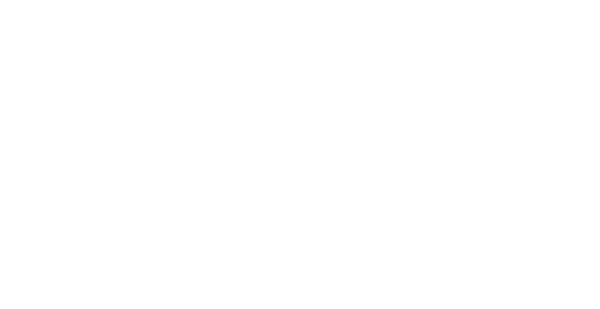

In [45]:
%matplotlib notebook

fig,ax = plt.subplots(1)

rmsdiff = mgasalmalims - np.mean(propdetlims/3)

pwvdiff = almapwv / reqpwv

im = plt.scatter(ozall, mgasalmalims, c=pwvdiff*100, cmap='jet')
plt.scatter(ozall, mgasgoallims, color='k')
im = ax.scatter(ozall, ondetlims, marker='s', c=pwvdiff*100, cmap='jet')
# im = ax.scatter(ozall, ondetlims100, marker='s', c=pwvdiff*100, cmap='jet')

cbar = fig.colorbar(im)

cbar.ax.set_ylabel('% of requested PWV')
ax.set_xlabel('z')
ax.set_ylabel(r'RMS converted to gas mass')

zlimrange = np.linspace(0.2, 1.2, num=500)
# ax.plot(zlimrange, 1/(1+zlimrange))

binzarr = np.linspace(0, 0.25, num=10)
for i in range(4):
#     ax.plot(binzarr+zbins[i], np.ones(10)*detlimmeans[i], color='k', zorder=20)
    ax.plot(binzarr+zbins[i], np.ones(10)*propdetlims[i], color='k', ls='--', zorder=20)

<IPython.core.display.Javascript object>


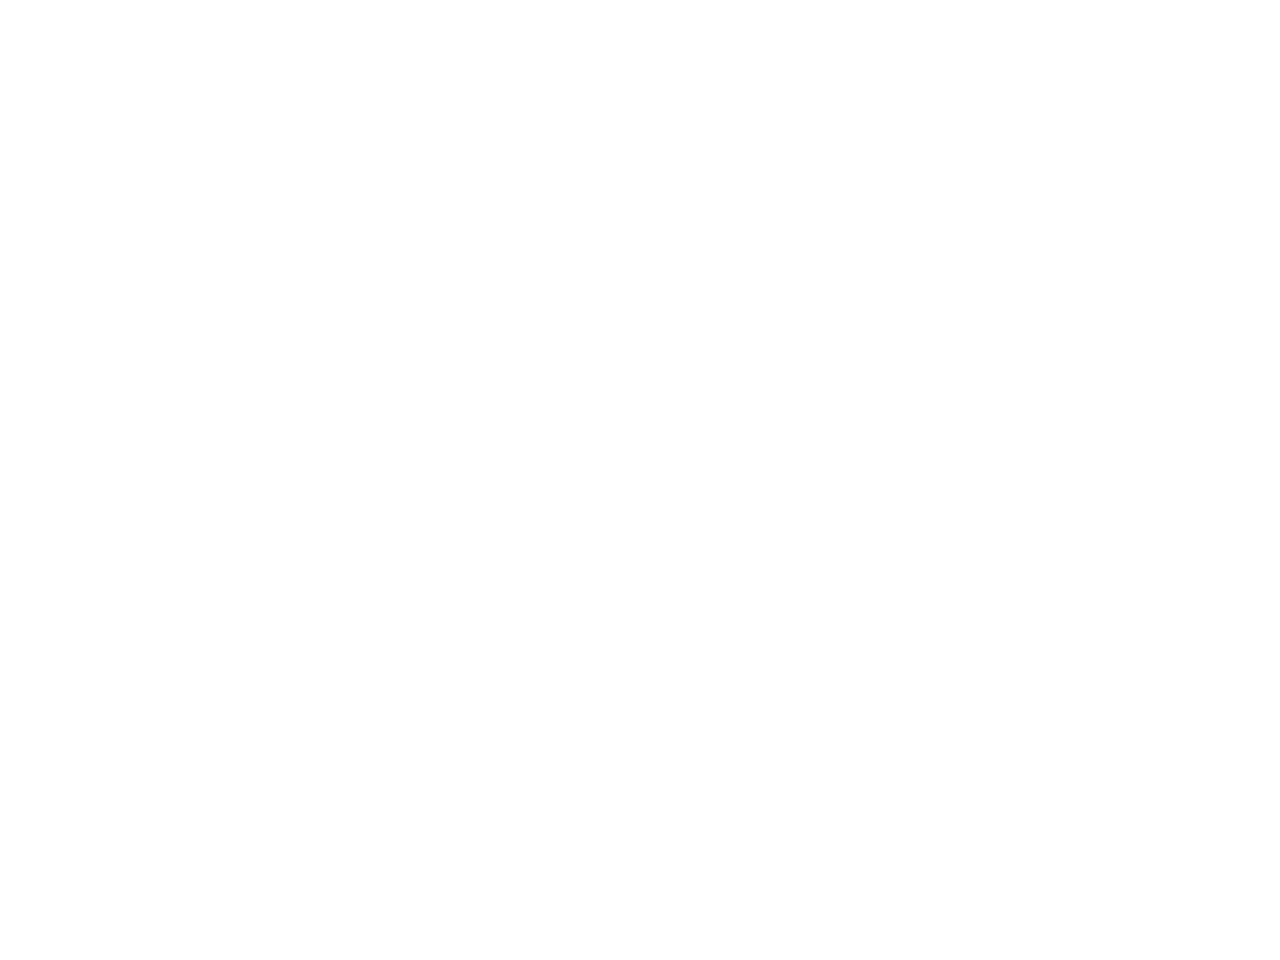

(0.15, 1.25)

In [46]:
%matplotlib notebook

fig,ax = plt.subplots(1)

rmsdiff = mgasalmalims - np.mean(propdetlims/3)

pwvdiff = almapwv / reqpwv

# im = plt.scatter(ozall, mgasalmalims/3.56, c=timeonsource, vmin=0., vmax=35., cmap='jet')
plt.scatter(ozall, mgasgoallims/3.56, color='k')
# ax.scatter(ozall, mgasdetlims)
# ax.scatter(ozall[:8], xmmdetlims)
# im = ax.scatter(ozall, ondetlims/3.56, marker='s', c=pwvdiff, cmap='jet')
markers = []
for t in timeonsource:
    if t < 5:
        markers.append('s')
    elif t > 5 and t < 10:
        markers.append('o')
    elif t > 10 and t < 25:
        markers.append('d')
    elif t > 25:
        markers.append('x')

# im = ax.scatter(ozall, almarms/1e-3/5/356, c=pwvdiff, cmap='jet', label='ALMA pipeline reported')
for i in range(len(ozall)):
    im = ax.scatter(ozall[i], ondetlims100[i]/3.56, c=pwvdiff[i], vmin=0., vmax=2., cmap='jet', 
                    marker=markers[i])
ax.scatter(-1, -100, marker='s', label=r't $\sim$ 5s')
ax.scatter(-1, -100, marker='o', label='5s < t < 10s')
ax.scatter(-1, -100, marker='d', label=r't $\sim$ 20s')
ax.scatter(-1, -100, marker='x', label=r't > 25s')


cbar = fig.colorbar(im)
ax.legend()

cbar.ax.set_ylabel('% of requested PWV')
ax.set_xlabel('z')
ax.set_ylabel(r'RMS converted to gas mass')

zlimrange = np.linspace(0.2, 1.2, num=500)

binzarr = np.linspace(0, 0.25, num=10)
for i in range(4):
#     ax.plot(binzarr+zbins[i], np.ones(10)*detlimmeans[i], color='k', zorder=20)
    ax.plot(binzarr+zbins[i], np.ones(10)*propdetlims[i]/3.56, color='k', ls='--', zorder=20)
    
ax.set_xlim(0.15, 1.25)

<IPython.core.display.Javascript object>


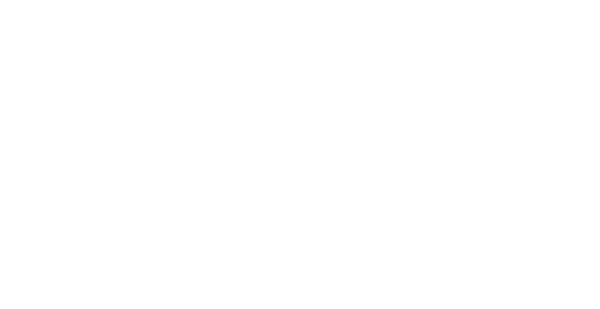

(-0.1, 1.2)

In [47]:
%matplotlib notebook

fig,ax=plt.subplots(1)
im = ax.scatter(ozall, almarms/1e-3/5/356, c=pwvdiff, cmap='jet', label='ALMA pipeline reported')
ax.scatter(ozall, onrms/5/afwhma*1e3, c=pwvdiff, cmap='jet', marker='d', label='Measured from 100km/s bin')
ax.scatter(ozall, orms100/5/1e-3/356, c=pwvdiff, cmap='jet', marker='s', label='Measured from Moment 0')
ax.scatter(ozall, goalrms/1e-3/5/356, color='k', label='requested')
ax.vlines(zbins, -0.1, 1.2, color='k')

cbar = fig.colorbar(im)
cbar.ax.set_ylabel('% of requested PWV')
fig.legend()
ax.set_ylim(-0.1, 1.2)

<IPython.core.display.Javascript object>


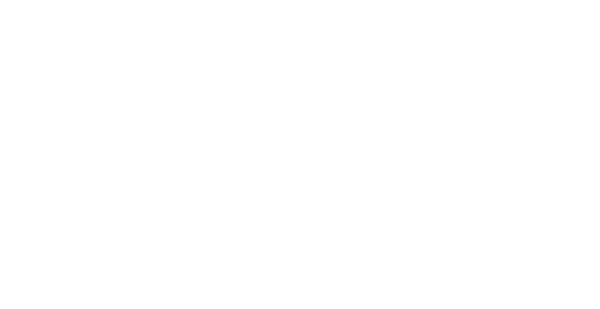

(-0.1, 1.2)

In [48]:
%matplotlib notebook
markers = []
for t in timeonsource:
    if t < 5:
        markers.append('s')
    elif t > 5 and t < 10:
        markers.append('o')
    elif t > 10 and t < 25:
        markers.append('d')
    elif t > 25:
        markers.append('x')

fig,ax=plt.subplots(1)
# im = ax.scatter(ozall, almarms/1e-3/5/356, c=pwvdiff, cmap='jet', label='ALMA pipeline reported')
for i in range(len(ozall)):
    im = ax.scatter(ozall[i], orms100[i]/5/356*1e3, c=almapwv[i], cmap='jet', vmin=0.9, vmax=3.5, #vmin=0., vmax=1.5, 
                    marker=markers[i])
# ax.scatter(ozall, orms100/5/1e-3/356, c=timeonsource, vmin=0., vmax=35.,
#            cmap='jet', marker='s', label='Measured from 100km/s bin')
ax.scatter(ozall, goalrms/1e-3/5/356, color='k', label='requested')
ax.vlines(zbins, -0.1, 1.2, color='k')
ax.scatter(0.5, -10, marker='s', label=r't $\sim$ 5mins')
ax.scatter(0.5, -10, marker='o', label='5mins < t < 10mins')
ax.scatter(0.5, -10, marker='d', label=r't $\sim$ 20mins')
ax.scatter(0.5, -10, marker='x', label=r't > 25mins')

cbar = fig.colorbar(im)
cbar.ax.set_ylabel('PWV')
ax.set_ylabel('1-sigma RMS')
ax.set_xlabel('Redshift')
ax.legend()
ax.set_ylim(-0.1, 1.2)

<IPython.core.display.Javascript object>


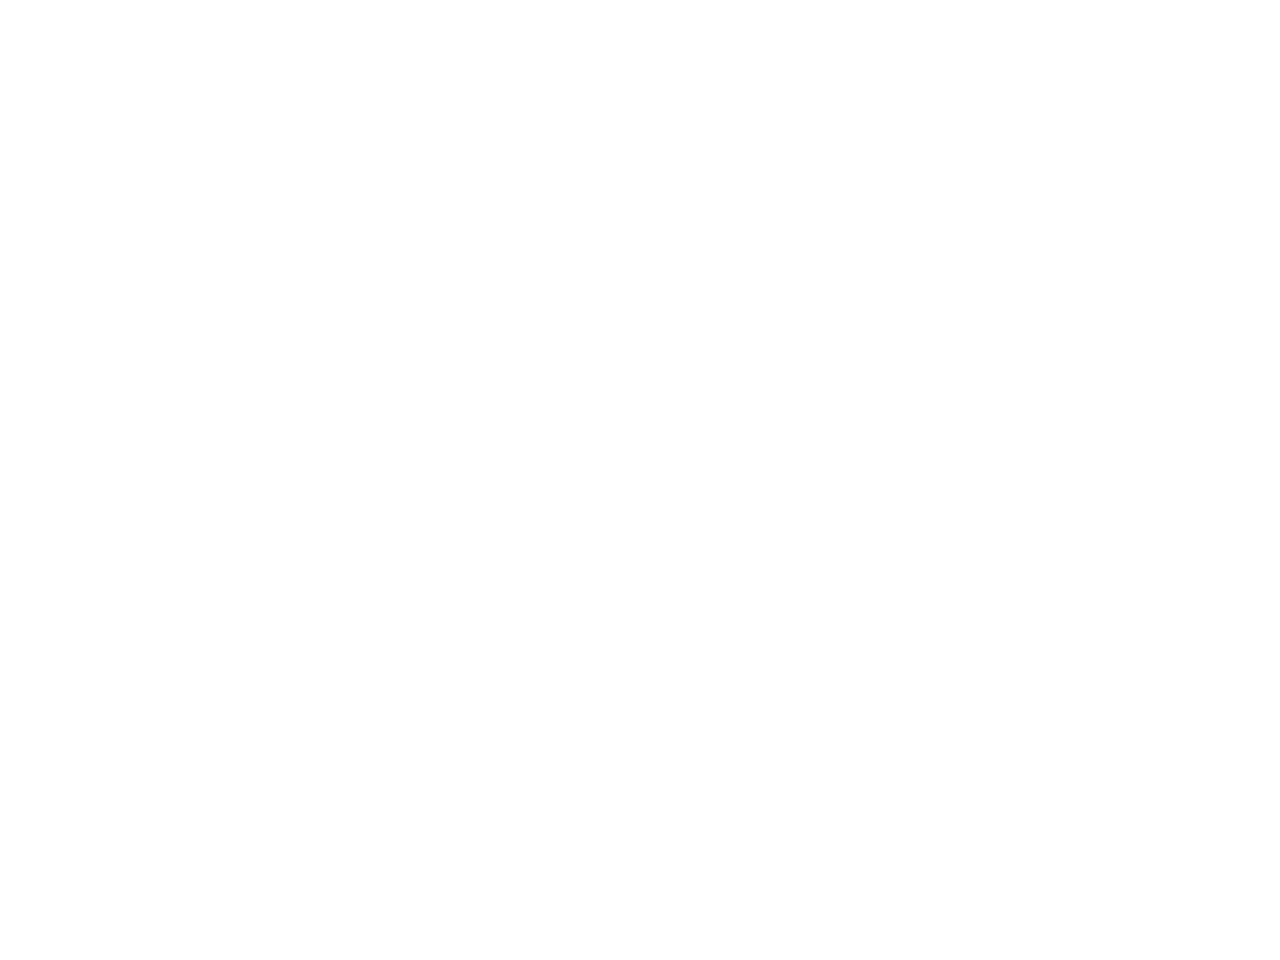

(-0.1, 1.2)

In [49]:
%matplotlib notebook
markers = []
for t in timeonsource:
    if t < 5:
        markers.append('s')
    elif t > 5 and t < 10:
        markers.append('o')
    elif t > 10 and t < 25:
        markers.append('d')
    elif t > 25:
        markers.append('x')

fig,ax=plt.subplots(1)
# im = ax.scatter(ozall, almarms/1e-3/5/356, c=pwvdiff, cmap='jet', label='ALMA pipeline reported')
for i in range(len(ozall)):
    im = ax.scatter(ozall[i], orms100[i]/5/356*1e3, c=pwvdiff[i], cmap='jet', vmin=0., vmax=1.5, 
                    marker=markers[i])
# ax.scatter(ozall, orms100/5/1e-3/356, c=timeonsource, vmin=0., vmax=35.,
#            cmap='jet', marker='s', label='Measured from 100km/s bin')
ax.scatter(ozall, goalrms/1e-3/5/356, color='k', label='requested')
ax.vlines(zbins, -0.1, 1.2, color='k')
ax.scatter(0.5, -10, marker='s', label=r't $\sim$ 5mins')
ax.scatter(0.5, -10, marker='o', label='5mins < t < 10mins')
ax.scatter(0.5, -10, marker='d', label=r't $\sim$ 20mins')
ax.scatter(0.5, -10, marker='x', label=r't > 25mins')

cbar = fig.colorbar(im)
cbar.ax.set_ylabel('PWV fraction of requested')
ax.set_ylabel('1-sigma RMS')
ax.set_xlabel('Redshift')
ax.legend()
ax.set_ylim(-0.1, 1.2)

## Load in the dataframes you made to make this easier

In [50]:
os.chdir('/Users/dee/Documents/ALMA/alma_reduction')

In [51]:
mgassample = pd.read_csv('mgassample.csv', skiprows=2)

In [52]:
osamp = pd.read_csv('osample_analyzed.csv')
esamp = pd.read_csv('edgesample_analyzed.csv')
field = pd.read_csv('fieldsample_analyzed.csv')

In [53]:
# SpARCS sample
os.chdir('/Users/dee/Documents/ALMA/otherSpARCSdata/')

xmmcat = readsav('XMM_full_catalog.sav', python_dict=True)
en2cat = pd.DataFrame.from_dict(readsav('EN2_full_catalog.sav', python_dict=True))
lockcat = pd.DataFrame.from_dict(readsav('Lock_full_catalog.sav', python_dict=True))
en1cat = pd.DataFrame.from_dict(readsav('EN1_full_catalog.sav', python_dict=True))

sparcs = pd.DataFrame.from_dict(xmmcat)
sparcs = sparcs.append(en2cat)
sparcs = sparcs.append(lockcat)
sparcs = sparcs.append(en1cat)

sparcs['zbest'] = sparcs['zrs']
sparcs['zbest'].iloc[np.where(sparcs.zspec != 0)] = sparcs['zspec'].iloc[np.where(sparcs.zspec != 0)]

# get the new available zspec values for sparcs
with fits.open('OzDES_GRC_2020_08_01.fits') as file:
    ozdesdat = file[1].data
    ozdeshdr = file[1].header
    ozdesfilehdr = file[0].header

In [54]:
ozdesra = ozdesdat['RA']
ozdesdec = ozdesdat['DEC']
ozdesz = ozdesdat['z']
catcoords = SkyCoord(ra=ozdesra*u.deg, dec=ozdesdec*u.deg, frame='icrs')

tol = 10*u.arcsec
searchra, searchdec = sparcs.ra_bcg, sparcs.dec_bcg
searchcoord = SkyCoord(ra=searchra*u.deg, dec=searchdec*u.deg, frame='fk5')

results = []
for coord in searchcoord:
    linenumbers = np.where(catcoords.separation(coord) < tol)[0]
    
    seps = catcoords[linenumbers].separation(coord).value
    
    if seps.size == 0:
        results.append(-99)
    else:   
        best = np.min(seps)
        bestidx = linenumbers[np.where(seps == best)]

        results.append(ozdesz[bestidx][0])

results = np.array(results)
results[np.where(results < 0)] = -99

sparcs['zozdes'] = results

In [55]:
ozdesra = ozdesdat['RA']
ozdesdec = ozdesdat['DEC']
ozdesz = ozdesdat['z']
catcoords = SkyCoord(ra=ozdesra*u.deg, dec=ozdesdec*u.deg, frame='icrs')

tol = 10*u.arcsec
searchra, searchdec = 9.2136331,-42.1169626
searchcoord = SkyCoord(ra=searchra*u.deg, dec=searchdec*u.deg, frame='fk5')

In [56]:
tol = 10*u.arcsec
# cent = SkyCoord(ra='00h29m21.96s', dec='-43d26m42.72s')
cent=SkyCoord(ra=8.298099*u.deg, dec=-43.4984*u.deg)
idx = np.where(catcoords.separation(cent) < tol)

In [57]:
print(searchcoord.ra.to(u.hourangle))

0h36m51.2719s


In [58]:
print(searchcoord.dec)

-42d07m01.0654s


In [59]:
linenumber = np.where(catcoords.separation(searchcoord) < tol)[0]
specz = ozdesz[linenumber]

In [60]:
specz

array([], dtype=float32)

In [61]:
catcoords.separation(searchcoord)[linenumber]

<Angle [] deg>

In [62]:
ozdesdat[linenumber]

FITS_rec([],
         dtype=(numpy.record, [('ID', 'S30'), ('RA', '>f8'), ('DEC', '>f8'), ('z', '>f4'), ('z_err', '>f4'), ('flag', 'S4'), ('source', 'S30'), ('Comment', 'S80'), ('Transient_type', 'S30'), ('Object_types', 'S200')]))

In [63]:
sparcs['zbest'].iloc[np.where(results > 0)] = results[np.where(results > 0)]

rs = sparcs.zbest == sparcs.zrs

sparcs['use_rs'] = rs

/Users/dee/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


## SFR using CE SED fits to get L(TIR) and then Kennicutt 98 for SFR

\begin{equation}
\mathrm{SFR} (\mathrm{M}_\odot yr^{-1})=4.5\times 10^{-44} L_{FIR} (\mathrm{ergs} \ \mathrm{s}^{-1})
\end{equation}

In [64]:
osamp = ms.get_properties(osamp, '/Users/dee/Documents/bc03/templates/ssp_11gyr_z02.spec', cosmo, 0.83)
esamp = ms.get_properties(esamp, '/Users/dee/Documents/bc03/templates/ssp_11gyr_z02.spec', cosmo, 0.83, tol=0.01)

In [65]:
osamp_5myr = ms.get_properties(osamp, '/Users/dee/Documents/bc03/templates/ssp_5Myr_z02.spec', cosmo, 0.83)
esamp_5myr = ms.get_properties(esamp, '/Users/dee/Documents/bc03/templates/ssp_5Myr_z02.spec', cosmo, 0.83, tol=0.01)

In [66]:
sfrlimsce, dsfrlimsce = ms.sfr_ce_ken(zlimits, our24umlimits)
sparcs['sfr'], sparcs['dsfr'] = ms.sfr_ce_ken(sparcs.zbest, sparcs.matchf24)

In [67]:
zrange = np.linspace(0, 1.3, num=500)
sfrdetlim, dsfrdetlim = ms.sfr_ce_ken(zrange, np.ones(500)*100)

/Users/dee/Documents/ALMA/chary_elbaz_python/chary_elbaz.py:81: RuntimeWarning: divide by zero encountered in true_divide
  for f in SEDs.T]).T


## SFR using Kennicutt (1998) and rigorous SED fits with scaling (change next cell to code)
\begin{equation}
\mathrm{SFR} (\mathrm{M}_\odot yr^{-1})=4.5\times 10^{-44} L_{FIR} (\mathrm{ergs} \ \mathrm{s}^{-1})
\end{equation}

## change into ergs/second so the relation applies
fitLIRergss = (fitLIR*u.Lsun).to(u.erg/u.s)
dfitLIRergss = (dfitLIR*u.Lsun).to(u.erg/u.s)
efitLIRergss = (efitLIR*u.Lsun).to(u.erg/u.s)
edfitLIRergss = (edfitLIR*u.Lsun).to(u.erg/u.s)

##
scale all values to get SFR
fitsfr = (fitLIRergss.value * 4.5e-44)*u.Msun/u.yr
dfitsfr = (dfitLIRergss.value * 4.5e-44)*u.Msun/u.yr
efitsfr = (efitLIRergss.value * 4.5e-44)*u.Msun/u.yr
edfitsfr = (edfitLIRergss.value * 4.5e-44)*u.Msun/u.yr

## Stellar masses from $3.6 \mu m$ values

In [68]:
bctemplate_11gyr = '/Users/dee/Documents/bc03/templates/ssp_11gyr_z02.spec'
bctemplate_5myr = '/Users/dee/Documents/bc03/templates/ssp_5Myr_z02.spec'

In [69]:
mstarlims, dmstarlims = ms.get_mstar(zlimits, our36umlimits, np.nan, bctemplate_11gyr, cosmo, 0.83)
sparcs['mstar'], sparcs['dmstar'] = ms.get_mstar(sparcs.zbest, sparcs.nch1/1e6, sparcs.nech1/1e6, bctemplate_11gyr, 
                                                 cosmo,
                                                0.83, tol=0.01)

/Users/dee/Documents/ALMA/alma_reduction/mstar_sfr.py:61: RuntimeWarning: invalid value encountered in true_divide
  dmstar = (1-10**-0.3)*mstar + (dirac/irac)*mstar


In [70]:
mstar, dmstar = ms.get_mstar(osamp.z, osamp.irac, osamp.dirac, bctemplate_5myr, cosmo, 1)

In [71]:
mstar_5myr, dmstar_5myr = ms.get_mstar(np.array(osamp.z), np.array(osamp.irac), np.array(osamp.dirac),
                                       '/Users/dee/Documents/bc03/templates/ssp_5Myr_z02.spec', cosmo,1)

In [72]:
emstar_5myr, edmstar_5myr = ms.get_mstar(np.array(esamp.z), np.array(esamp.irac), np.array(esamp.dirac),
                                       '/Users/dee/Documents/bc03/templates/ssp_5Myr_z02.spec', cosmo,1, tol=0.01)

In [73]:
sparcsminmstar = 4.6963e+10

In [74]:
print('{:.4e}'.format(np.min(sparcs.query('mstar  > 1e7').mstar)))

4.6963e+10


In [75]:
print('{:.4e}'.format(np.min(esamp.mstar)))

1.0140e+10


## Stellar Mass comparison

In [76]:
mstargoodidx = np.where(np.isnan(fastmstar) == False)[0][1:]

mstargoodidx = np.delete(mstargoodidx, 4)

print(mstargoodidx)

[ 1  2  3  4  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 22 23]


In [77]:
np.where(fastmstar[mstargoodidx] == np.max(fastmstar[mstargoodidx]))

(array([4]),)

In [78]:
opt, cov = curve_fit(straightline_nob, mstar[mstargoodidx], fastmstar[mstargoodidx], p0=[1])
opt

array([0.80480281])

<IPython.core.display.Javascript object>


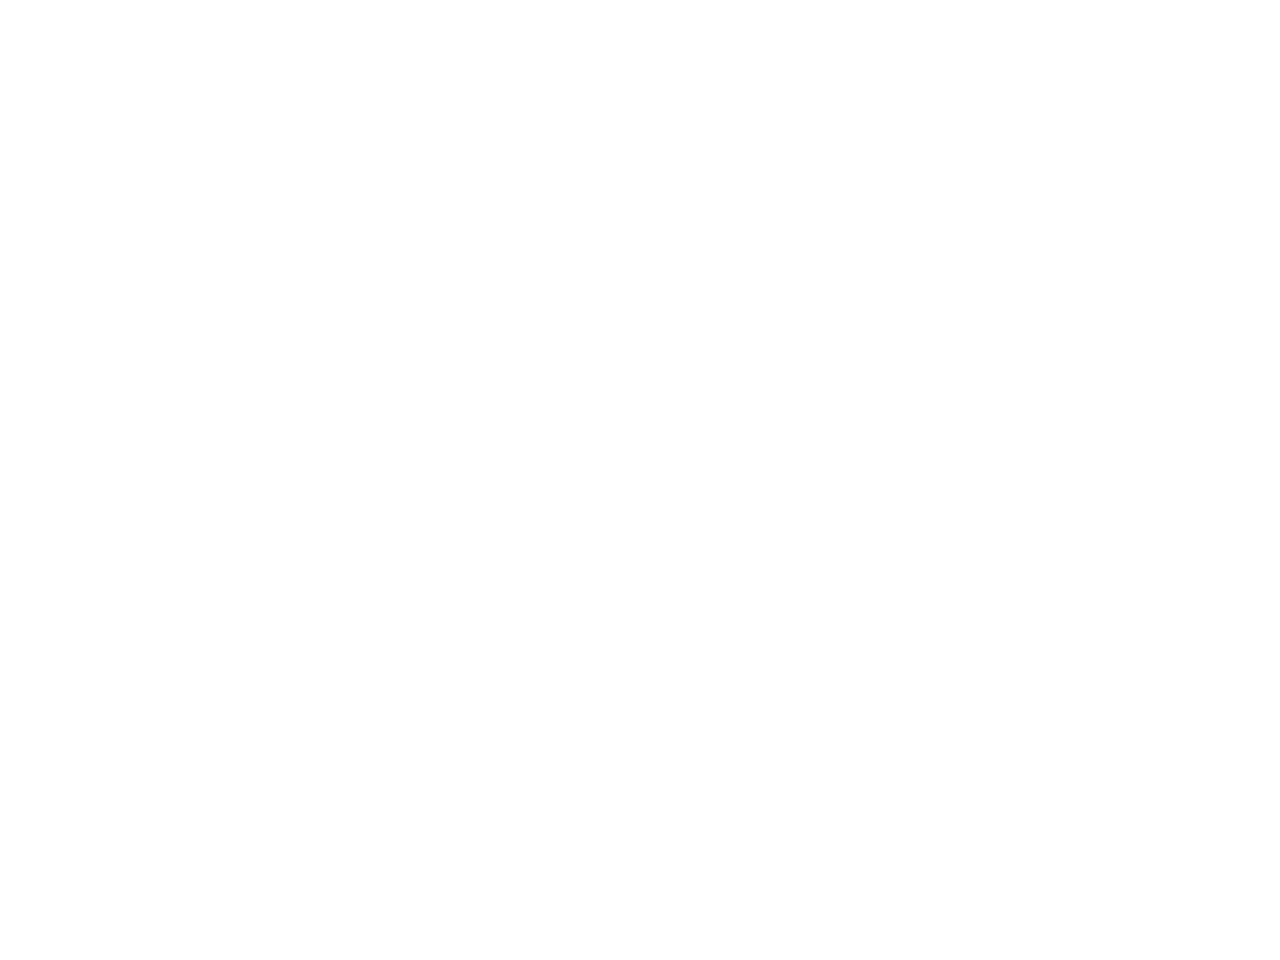

Text(0, 0.5, '$z_{spec}$')

In [79]:
%matplotlib notebook
fig,ax = plt.subplots(2)
im = ax[0].scatter(mstar*opt, fastmstar, c=z, cmap='jet')
xvals = np.linspace(np.min(mstar), np.max(mstar), num=500)
ax[0].plot(xvals, xvals, color='k')
ax[0].set_xlabel(r'Masses from $3.6 \mu m$')
ax[0].set_ylabel('Masses from FAST')
cbar = fig.colorbar(im, ax=ax[0])
cbar.ax.set_ylabel(r'$z_{spec}$')

resids = fastmstar - mstar*opt
scatter = np.nanstd(resids)
ax[1].scatter(mstar*opt, resids, c=z, cmap='jet')
ax[1].axhline(0, color='k', ls='--')
ax[1].set_xlabel(r'Masses from $3.6 \mu m$')
ax[1].set_ylabel('FAST residuals')
cbar = fig.colorbar(im, ax=ax[1])
cbar.ax.set_ylabel(r'$z_{spec}$')

## sSFRs and errors

In [80]:
ssfr_5myr = (osamp.sfr / mstar_5myr * 1e9)
dssfr_5myr = (np.sqrt((osamp.dsfr/osamp.sfr)**2 + (dmstar_5myr/mstar_5myr)**2)*ssfr_5myr)

In [81]:
ssfrlimsce = (sfrlimsce / mstarlims * 1e9)
dssfrlimsce = np.sqrt((dsfrlimsce/sfrlimsce)**2 + (dmstarlims/mstarlims)**2)*ssfrlimsce 

In [82]:
eggoodidx = np.where(np.logical_and(edmgas > 0, e36um > 0))[0]

In [83]:
essfr_5myr = (np.array(esamp.sfr) / emstar_5myr * 1e9)
edssfr_5myr = (np.sqrt((np.array(esamp.dsfr)/np.array(esamp.sfr))**2 + (edmstar_5myr/emstar_5myr)**2)*essfr_5myr)

In [84]:
sparcsssfr = (np.array(sparcs['sfr'], dtype=float) / np.array(sparcs['mstar'], dtype=float) * 1e9)
sparcsdssfr = (np.sqrt((sparcs['dsfr']/sparcs['sfr'])**2 + (sparcs['dmstar']/sparcs['mstar'])**2)*sparcsssfr)

/Users/dee/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/Users/dee/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


In [85]:
sparcs['ssfr'] = sparcsssfr
sparcs['dssfr'] = sparcsdssfr

In [86]:
ssfrdetlim = sfrdetlim/sparcsminmstar * 1e9
ssfrodetlim = sfrdetlim/np.min(osamp.mstar)*1e9
ssfrmeandetlim = sfrdetlim/np.mean(osamp.mstar)*1e9

In [87]:
cdfs18coord = SkyCoord(ra='03:33:16.8', dec='-26:53:45', unit=(u.hourangle, u.deg))
cdfs19coord = SkyCoord(ra='03:33:56.0', dec='-27:15:34', unit=(u.hourangle, u.deg))

In [88]:
sparcsbcgcoords = SkyCoord(np.array(sparcs.ra_bcg)*u.deg, np.array(sparcs.dec_bcg)*u.deg)

In [89]:
np.mean(afwhma)

366.34837832399995

## PLOTS

In [90]:
# bin the detlims
zbins = np.array([0.2, 0.45, 0.7, 0.95, 1.2])
detlimmeans = []
for i in range(4):
    binmean = np.mean(ondetlims[np.where(np.logical_and(ozall <= zbins[i+1], ozall >= zbins[i]))])
    detlimmeans.append(binmean)
    
detlimmeans = np.array(detlimmeans)

In [91]:
detlimmeans

array([1.93768340e+09, 8.41887473e+09, 9.88418655e+09, 1.14364714e+10])

In [92]:
limitagnidx = np.array([0,1,3])

<IPython.core.display.Javascript object>


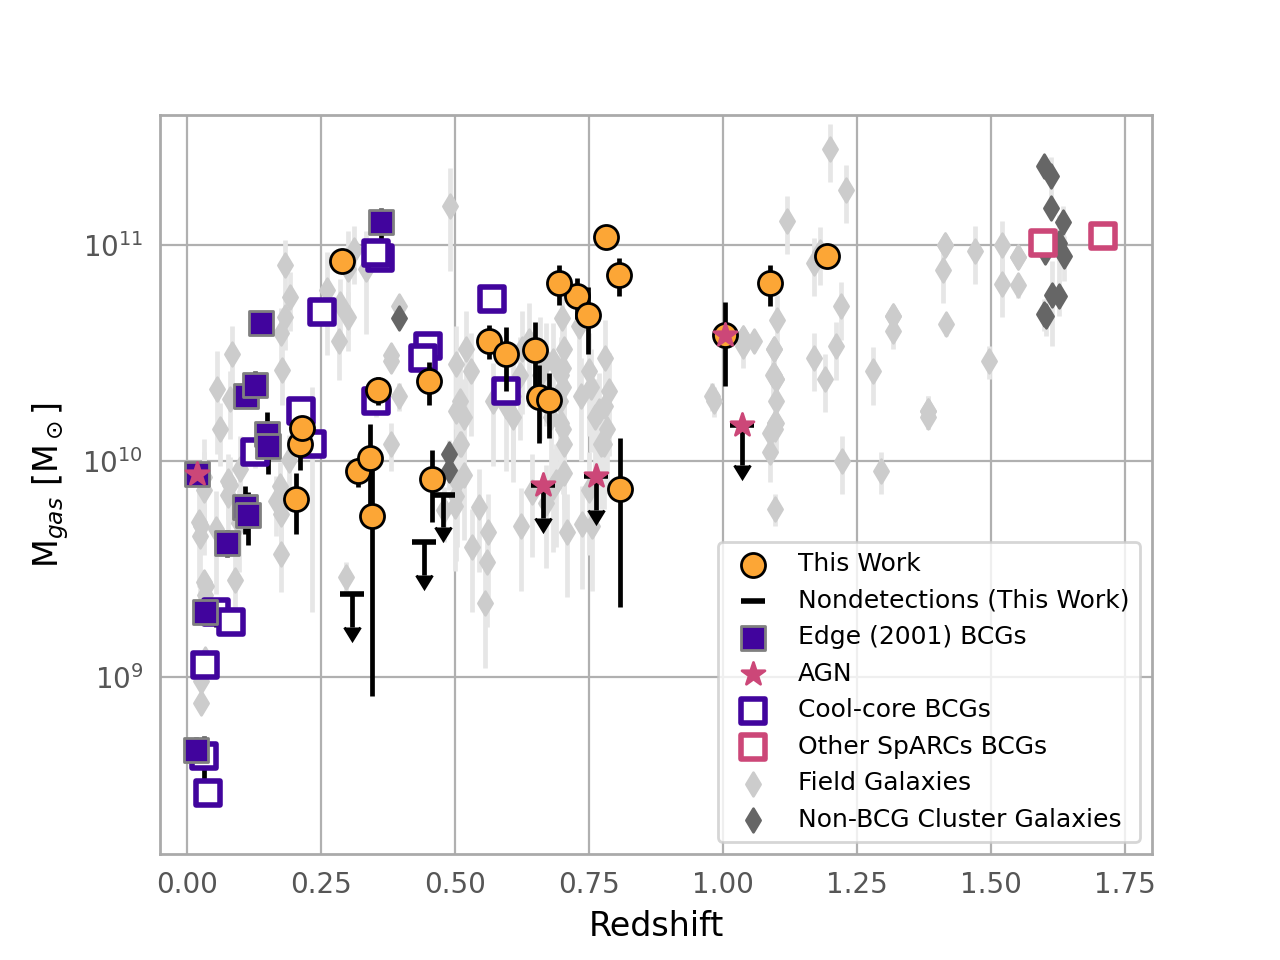

(150000000.0, 400000000000.0)

In [96]:
%matplotlib notebook
fig, ax = plt.subplots(1)

plas = plt.cm.get_cmap('plasma')

ax.scatter(z, mgas, cmap='plasma', s=75, zorder=20, label='This Work', ec='k', color=plas(0.8))
ax.errorbar(z, mgas, yerr=dmgas, color='k', fmt='none', zorder=19)
ax.scatter(z[0], mgas[0], s=75, marker='*', color=plas(0.5), zorder=20)
ax.scatter(zlimits[limitagnidx], comasslims[limitagnidx], s=75, marker='*', color=plas(0.5), zorder=20)
ax.set_ylabel(r'$\mathrm{M}_{gas} \  [\mathrm{M}_\odot ]$')
ax.set_xlabel(r'Redshift')
ax.set_xlim((-0.05, 1.8))
# ax.set_ylim((1.5e8, 4e11))
ax.set_yscale('log')

# exts = np.array([0, 2])
# ax.scatter(z[0], mgas[0], s=150, zorder=19, color='white', ec='red', label='XMM-1', linewidths=2)
# ax.scatter(z[2], mgas[2], s=150, zorder=19, color='white', ec='limegreen', label='XMM-3', linewidths=2)

# our limits
ax.scatter(zlimits, comasslims, marker='_', color='k', label='Nondetections (This Work)', zorder=18, lw=2, s=75)
ax.errorbar(zlimits, comasslims, yerr=(1-10**-0.15)*mgaslimits, uplims=True, fmt='none', color='k', zorder=18)



# our bkgs
# ax.scatter(bkgz, bkgmgas, zorder=18, color='0.4', marker='d')
# ax.errorbar(bkgz, bkgmgas, yerr=bkgdmgas, color='0.9', fmt='none')

# edge01
ax.scatter(esamp.z, esamp.mgas, zorder=8, label='Edge (2001) BCGs', marker='s', s=75, color=plas(0.1), 
           ec='0.5')
# ax.scatter(ez[nuplims], emgas[nuplims], zorder=8, marker='s', s=75, ec=plas(0.1), color='white', linewidths=2)
ax.errorbar(esamp.z, esamp.mgas, yerr=esamp.dmgas, color='k', fmt='none', zorder=6)
ax.scatter(esamp.z.iloc[-1], esamp.mgas.iloc[-1], s=75, marker='*', color=plas(0.5), zorder=20, label='AGN')
# ax.errorbar(ez[uplims], emgas[uplims], yerr=(1-10**-0.2)*emgas[uplims], uplims=True, fmt='none', color='k')

# salome and combes
uplims = np.where(scdmgas < 0)
nuplims = np.where(scdmgas > 0)
pltidx = np.array([6,8,9])
ax.scatter(scz[pltidx], scmgas[pltidx], zorder=6, marker='s', s=75, ec=plas(0.1), color='white', linewidths=2)
ax.errorbar(scz[pltidx], scmgas[pltidx], yerr=scdmgas[pltidx], color='k', fmt='none', zorder=5)

# castignani
uplims = np.where(casdmgas == -1)
nuplims = np.where(casdmgas != -1)
ax.scatter(casz[nuplims], casmgas[nuplims], zorder=6, marker='s', s=75, ec=plas(0.1), color='white', linewidths=2, 
           label="Cool-core BCGs")
ax.errorbar(casz[nuplims], casmgas[nuplims], yerr=casdmgas[nuplims], color='0.9', fmt='none')
# ax.errorbar(cz[uplims], cmgas[uplims], yerr=(1-10**-0.2)*cmgas[uplims], uplims=True, fmt='none', color='k')

#noble bcg
ax.scatter(nz[-1], nmgas[-1], zorder=6, s=75, marker='s', ec=plas(0.5), color='white', linewidths=2,
           label='Other SpARCs BCGs')


# Genzel
ax.scatter(gz, gmgas, zorder=5, color='0.8', marker='d') # label='GENZEL+2010', 
ax.errorbar(gz, gmgas, yerr=gdmgas, color='0.9', fmt='none')

# Geach
ax.scatter(geachz, geachmgas, zorder=5, color='0.8', marker='d') #label = 'GEACH+2011'
ax.errorbar(geachz, geachmgas, yerr=geachdmgas, color='0.9', fmt='none')

# decarli 
uplims = np.where(decdmgas < 0)
nuplims = np.where(decdmgas > 0)
ax.scatter(decz[nuplims], decmgas[nuplims], zorder=5, color='0.8', label='Field Galaxies', marker='d')
#  label='DECARLI+2016',
ax.errorbar(decz[nuplims], decmgas[nuplims], yerr=decdmgas[nuplims], color='0.9', fmt='none')
# ax.errorbar(decz[uplims], decmgas[uplims], yerr=(1-10**-0.2)*decmgas[uplims], uplims=True, fmt='none', color='k')

# # castignani 2
# ax.scatter(c2z, c2mgas, zorder=5, label='CASTIGNANI+2019')
# ax.errorbar(c2z, c2mgas, yerr=(1-10**-0.2)*c2mgas, uplims=True, fmt='none', color='k')

# brownson
ax.scatter(bz, bmgas, zorder=5, color='0.8', marker='d') # label='BROWNSON+2020',

# aravena (ASPECS)
ax.scatter(az, amgas, zorder=5, color='0.8', marker='d') #  label='ARAVENA+2020', 
ax.errorbar(az, amgas, yerr=admgas, color='0.9', fmt='none')

# ASPECS 2 (aravena)
ax.scatter(a2z, a2mgas, zorder=5, color='0.8', marker='d') # label='ARAVENA+2020', 
ax.errorbar(a2z, a2mgas, yerr=a2dmgas, color='0.9', fmt='none')

# ASPECS 3 (boogaard)
boogoodidx = np.where(boodmgas > 0)
ax.scatter(booz[boogoodidx], boomgas[boogoodidx], zorder=5, color='0.8', marker='d') #label='BOOGAARD+2020'
ax.errorbar(booz[boogoodidx], boomgas[boogoodidx], yerr=boodmgas[boogoodidx], color='0.9', fmt='none')

# PHIBSS2
ax.scatter(phibss2z, phibss2mgas, zorder=5, color='0.8', marker='d') # label='PHIBBS2', 
ax.errorbar(phibss2z, phibss2mgas, yerr=phibss2dmgas, color='0.9', fmt='none')

# jablonka
ax.scatter(jabz, jabmgas, zorder=5, color='0.4', marker='d') # label='JABLONKA+2013', 
ax.errorbar(jabz, jabmgas, yerr=jabdmgas, color='0.9', fmt='none')

# combes
ax.scatter(combesz, combesmgas, zorder=5, color='0.8', marker='d') # label='COMBES+2013', 
ax.errorbar(combesz, combesmgas, yerr=combesdmgas, color='0.9', fmt='none')

# braun
nuplims = np.where(braundmgas != -99)[0]
ax.scatter(braunz[nuplims], braunmgas[nuplims], zorder=5, color='0.8', marker='d') # label='BRAUN+2011', 
ax.errorbar(braunz[nuplims], braunmgas[nuplims], yerr=braundmgas[nuplims], color='0.9', fmt='none')

# hatsukade GRB hosts
ax.scatter(hz, hmgas, zorder=5, color='0.8', marker='d') # label='HATSUKADE+2020'
ax.errorbar(hz, hmgas, yerr=hdmgas, color='0.9', fmt='none')

# egnog
ax.scatter(egnogz, egnogmgas, zorder=5, color='0.8', marker='d')# label='BAUERMEISTER+2013'
ax.errorbar(egnogz, egnogmgas, yerr=egnogdmgas, color='0.9', fmt='none')

# noble 2019
ax.scatter(nz[0:6], nmgas[0:6], zorder=5, color='0.4', label='Non-BCG Cluster Galaxies', marker='d')# label='NOBLE+2018' 
ax.errorbar(nz[0:6], nmgas[0:6], yerr=ndmgas[0:6], color='0.9', fmt='none')

# noble 2017
ax.scatter(n2z, n2mgas, zorder=5, color='0.4', marker='d')
ax.errorbar(n2z, n2mgas, yerr=n2dmgas, color='0.9', fmt='none')

# # dabhade
# ax.scatter(dabz, dabmgas, zorder=5, label='DABHADE+2020')
# ax.errorbar(dabz, dabmgas, yerr=(1-10**-0.2)*dabmgas, uplims=True, fmt='none', color='k')

# mcnamara BCG
ax.scatter(mcz, mcmgas, zorder=6,  marker='s', s=75, ec=plas(0.1), color='white', linewidths=2) # label='A1835 BCG',
ax.errorbar(mcz, mcmgas, yerr=mcdmgas, color='0.9', fmt='none')

# vantyghem 
ax.scatter(vz, vmgas, zorder=6, marker='s', s=75, ec=plas(0.1), color='white', linewidths=2) # label='2A 0335+096 BCG', 
ax.errorbar(vz, vmgas, yerr=vdmgas, color='0.9', fmt='none')

# russell
ax.scatter(rusz, rusmgas, zorder=6, marker='s', s=75, ec=plas(0.1), color='white', linewidths=2) # label='A1664 BCG', 
ax.errorbar(rusz, rusmgas, yerr=rusdmgas, color='0.9', fmt='none')

# fogarty (cool-core)
ax.scatter(fz, fmgas, zorder=6, marker='s', s=75, ec=plas(0.1), color='white', linewidths=2) # label='MACS 1931.8-2635 BCG', 
ax.errorbar(fz, fmgas, yerr=fdmgas, color='0.9', fmt='none')

# tremblay
ax.scatter(tz, tmgas, zorder=6, marker='s', s=75, ec=plas(0.1), color='white', linewidths=2) # label='A2597 BCG', 
ax.errorbar(tz, tmgas, yerr=tdmgas, color='0.9', fmt='none')

# russell (phoenix cluster)
ax.scatter(pz, pmgas, zorder=6, marker='s', s=75, ec=plas(0.1), color='white', linewidths=2) # label='PHOENIX BCG', 
ax.errorbar(pz, pmgas, yerr=pdmgas, color='0.9', fmt='none')



# 1049
ax.scatter(z1049, mgas1049, zorder=6, s=75, marker='s', ec=plas(0.5), color='white', linewidths=2) # label='SpARCS1049 BCG', 
ax.errorbar(z1049, mgas1049, yerr=dmgas1049, color='0.9', fmt='none')


# our detlims
# ax.scatter(ozall, ondetlims, zorder=20)
# ax.scatter(ozall, mgasalmalims, zorder=20)
# ax.scatter(ozall, mgasgoallims, zorder=20)
# binzarr = np.linspace(0, 0.25, num=10)
# for i in range(4):
#     ax.plot(binzarr+zbins[i], np.ones(10)*detlimmeans[i], color='k', zorder=20)
#     ax.plot(binzarr+zbins[i], np.ones(10)*propdetlims[i], color='k', ls='--', zorder=20)
    

ax.legend(loc='lower right', fontsize=9)

ax.set_xlim((-0.05, 1.8))
ax.set_ylim((1.5e8, 4e11))

In [94]:
comasslims[np.where(zlimits>1)]

array([1.46118583e+10])

**LIMITS**: plotting 3sigma RMS values at the average FWHM of 356km/s. Solid lines are means of the actual in each redshift bin, dotted lines are the proposed values. Blue dots show detection limit for each individual observation

<IPython.core.display.Javascript object>


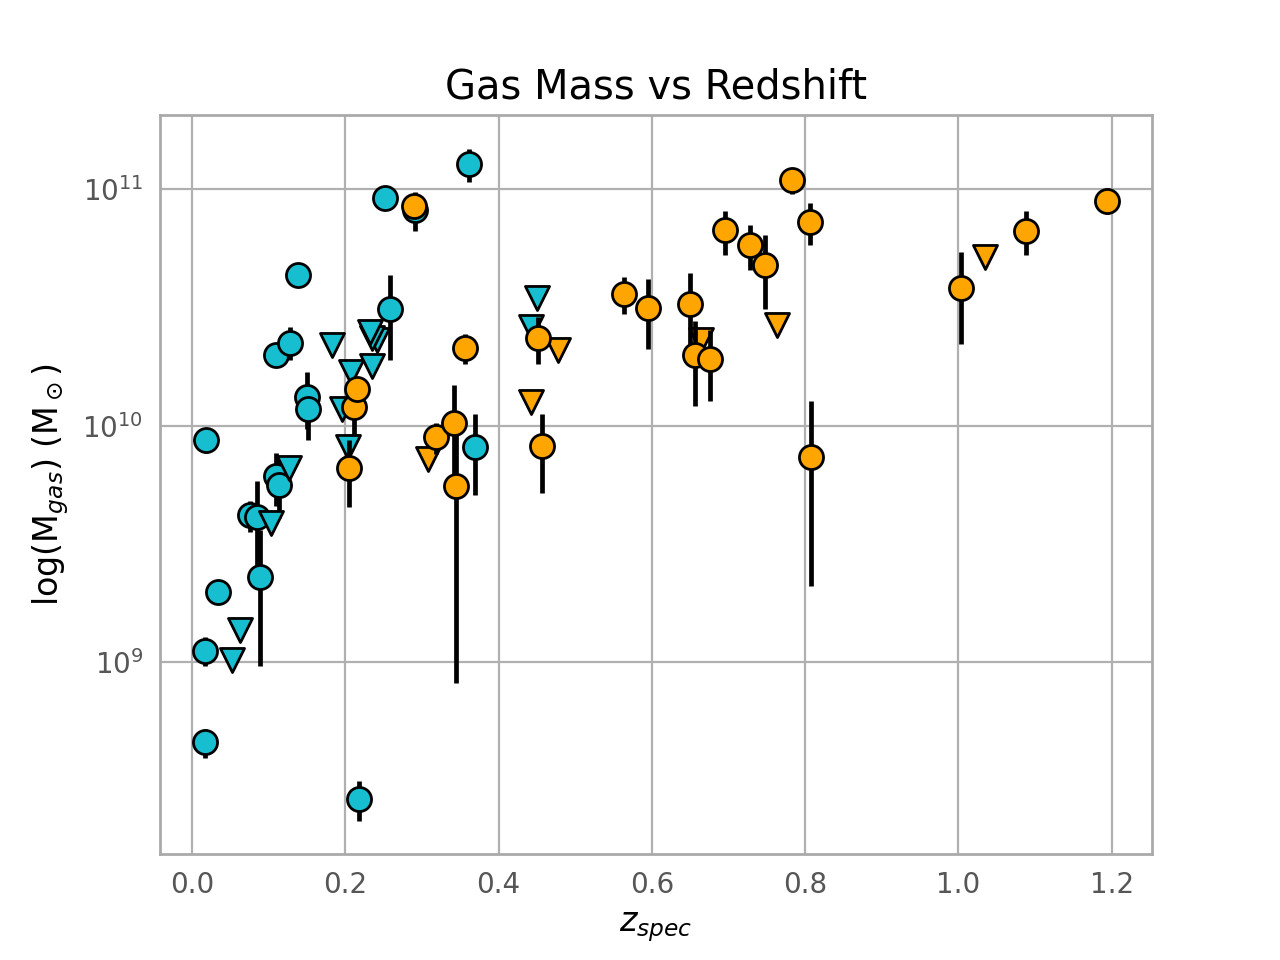

NameError: name 'cdmgas' is not defined

In [97]:
# gas mass vs redshift for just BCGs, with limits included
%matplotlib notebook
fig, ax = plt.subplots(1)
ax.scatter(z, mgas, cmap='plasma', s=75, zorder=20, label='OUR BCGS', ec='k', color='orange')
ax.errorbar(z, mgas, yerr=dmgas, color='k', fmt='none', zorder=19)
ax.set_ylabel(r'$\log(\mathrm{M}_{gas}) \  (\mathrm{M}_\odot )$')
ax.set_xlabel(r'$z_{spec}$')
ax.set_title('Gas Mass vs Redshift')
ax.set_yscale('log')
# ax.set_xscale('log')

# our limits
ax.scatter(zlimits, mgaslimits*3, marker='v', color='orange', ec='k', zorder=10, s=75)

# edge01
uplims = np.where(edmgas < 0)
nuplims = np.where(edmgas > 0)
ax.scatter(ez[nuplims], emgas[nuplims], zorder=7, label='EDGE+01', ec='k', s=75, color='tab:cyan')
ax.errorbar(ez[nuplims], emgas[nuplims], yerr=edmgas[nuplims], color='k', fmt='none')
ax.scatter(ez[uplims], emgas[uplims], zorder=7, ec='k', marker='v', color='tab:cyan', s=75)

# castignani
uplims = np.where(cdmgas == -1)
nuplims = np.where(cdmgas != -1)
ax.scatter(cz[nuplims], cmgas[nuplims], zorder=5, s=75, color='navy', label="CASTIGNANI+2020")
ax.errorbar(cz[nuplims], cmgas[nuplims], yerr=cdmgas[nuplims], color='0.3', fmt='none')
ax.scatter(cz[uplims], cmgas[uplims], zorder=5, ec='k', marker='v', color='navy', s=75)

ax.legend()

In [98]:
# sample detection rates
%matplotlib notebook

fig = plt.figure(figsize=(7, 6), constrained_layout=True)

ax = fig.add_subplot()

studies=('This Work', 'Edge (2001)', 'Castignani+\n (2020)', 'Salome+Combes\n (2003)')
detectionrate = np.array([24/30, len(np.where(edmgas > 0)[0])/len(emgas), 5/18, 6/32])*100
ax.barh(studies, detectionrate, color=[plas(0.1), plas(0.1), plas(0.1), plas(0.1)])
ax.set_xlabel('Detection Rate (%)')
ax.set_ylabel('Sample')
ax.set_xlim((0, 100))

<IPython.core.display.Javascript object>

(0.0, 100.0)

<IPython.core.display.Javascript object>


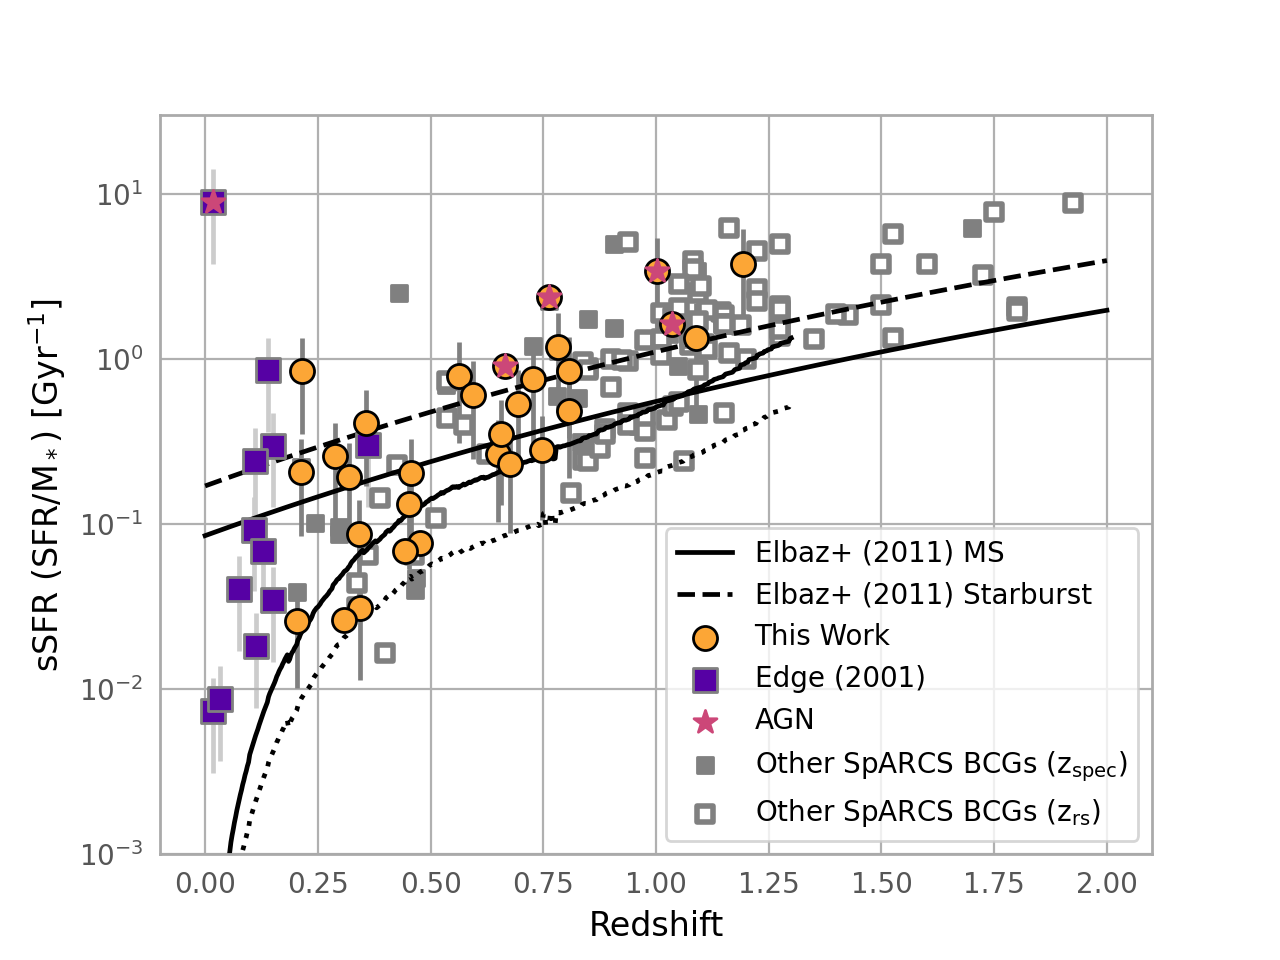

In [99]:
# SSFR MS for us and edge
%matplotlib notebook

zrange = np.linspace(0, 2., num=500)

# whitaker SFR main sequence
aarr = 0.7 - 0.13*zrange
barr = 0.38 + 1.14*zrange - 0.19*zrange**2

mstar = np.array(osamp.mstar)
z = np.array(osamp.z)
ssfrce = np.array(osamp.ssfr)
dssfrce = np.array(osamp.dssfr)

emstar = np.array(esamp.mstar)
ez = np.array(esamp.z)
essfrce = np.array(esamp.ssfr)
edssfrce = np.array(esamp.dssfr)

sfrmsrangemax = np.power(10, aarr*(np.log10(np.max(osamp.mstar)) - 10.5) + barr)
sfrmsrangemin = np.power(10, aarr*(np.log10(np.min(osamp.mstar)) - 10.5) + barr)
sfrmsrangemean = np.power(10, aarr*(np.log10(np.mean(mstar)) - 10.5) + barr)

# plt.plot(zrange, sfrmsrangemax/np.max(mstar.value)*1e9)
# plt.plot(zrange, sfrmsrangemin/np.min(mstar.value)*1e9)
# plt.plot(zrange, sfrmsrangemean/np.mean(mstar.value)*1e9)

plt.scatter(z, ssfrce, label='This Work', s=75, color=plas(0.8), ec='k', zorder=5)
# plt.scatter(zlimits, ssfrlims, s=75, color=plas(0.8), ec='k', zorder=5)
plt.scatter(z[0], ssfrce[0], s=75, marker='*', color=plas(0.5), zorder=6)
plt.scatter(zlimits, ssfrlimsce, s=75, color=plas(0.8), ec='k', zorder=5)
plt.scatter(zlimits[limitagnidx], ssfrlimsce[limitagnidx], s=75, marker='*', color=plas(0.5), zorder=6)

plt.errorbar(z, ssfrce, yerr=dssfrce, fmt='none', color='0.5', zorder=1)
# plt.errorbar(zlimits, ssfrlims, yerr=dssfrlims, fmt='none', color='0.5', zorder=1)

plt.scatter(ez, essfrce, label='Edge (2001)', s=75, marker='s', color=plas(0.15), ec='0.5', zorder=4)
plt.scatter(ez[-1], essfrce[-1], label='AGN', s=75, marker='*', color=plas(0.5), zorder=6)
plt.errorbar(ez, essfrce, yerr=edssfrce, fmt='none', color='0.8', zorder=0)
plt.yscale('log')
# plt.title('sSFR vs Redshift (ELBAZ MS comparison)')


# plt.scatter(zspecsparcs.zbest.iloc[[1,5,6,9]], zspecsparcs.ssfrce.iloc[[1,5,6,9]], zorder=10)
# other sparcs bkgs
specidx = np.where(sparcs.use_rs == False)
rsidx = np.where(sparcs.use_rs == True)
plt.scatter(sparcs.zbest.iloc[specidx], sparcs.ssfr.iloc[specidx], 
            label=r'Other SpARCS BCGs ($\mathrm{z}_\mathrm{spec}$)', s=30, 
            marker='s', color='0.5')
plt.scatter(sparcs.zbest.iloc[rsidx], sparcs.ssfr.iloc[rsidx], 
            label=r'Other SpARCS BCGs $(\mathrm{z}_\mathrm{rs})$', s=30,
            marker='s', color='white', ec='0.5', lw=2)
# plt.scatter(sparcs.zspec, sparcs.ssfr)
gcut = np.where(sparcs.nch1 > 100)
# plt.scatter(sparcs.zbest.iloc[gcut], sparcs.ssfr.iloc[gcut])
# plt.errorbar(sparcs.zbest, sparcs.ssfr, yerr=sparcs.dssfr, fmt='none', color='0.8', zorder=0)

plt.plot(zrange, 26 * np.power(cosmo.age(zrange).to(u.Gyr).value, -2.2), color='k', 
         label='Elbaz+ (2011) MS')
plt.plot(zrange, 52 *np.power(cosmo.age(zrange).to(u.Gyr).value, -2.2), color='k', ls='--',
         label='Elbaz+ (2011) Starburst')


plt.xlabel('Redshift')
plt.ylabel(r'sSFR (SFR/M$_*$) [Gyr$^{-1}$]')
plt.ylim((1e-3, 3e1))
# plt.xlim((-0.05, 1.25))

detlimz = np.linspace(0., 1.3, num=500)
plt.plot(detlimz, ssfrdetlim, color='k')
plt.plot(detlimz, ssfrmeandetlim, color='k', ls=':')
plt.legend(loc='lower right')

In [100]:
zlimrange = np.linspace(0., 1.3, num=500)
z08val = np.max(zlimrange[np.where(zlimrange <= 0.8)])
z08idx = np.where(zlimrange == z08val)[0]
ssfrdetlim08 = ssfrdetlim[z08idx][0]
ssfrms08 = 26 * np.power(cosmo.age(z08val).to(u.Gyr).value, -2.2)

In [101]:
belowmsfrac = ssfrdetlim08 / ssfrms08
belowmsfrac

0.7436841544234255

In [102]:
def stderr(array):
    # standard error in the mean
    return np.std(array)/np.sqrt(len(array))

In [103]:
osamp['ssfrdiff'] = osamp.ssfr/osamp.ssfrms
esamp['ssfrdiff'] = esamp.ssfr/esamp.ssfrms

In [104]:
amsfrac = 2.0
bmsfrac = 0.5

osampsburst = osamp.query('ssfrdiff > ' + str(amsfrac))
osampms = osamp.query('ssfrdiff >= ' + str(bmsfrac) + ' & ssfrdiff <=' + str(amsfrac))
osampbelowms = osamp.query('ssfrdiff < ' + str(bmsfrac))

esampsburst = esamp.query('ssfrdiff > ' + str(amsfrac))
esampms = esamp.query('ssfrdiff >= ' + str(bmsfrac) + '& ssfrdiff <=' + str(amsfrac))
esampbelowms = esamp.query('ssfrdiff < ' + str(bmsfrac))

osampcutsburst = osampsburst.query('z < 0.6')
osampcutms = osampms.query('z < 0.6')
osampcutbelowms = osampbelowms.query('z < 0.6')

csburst = pd.concat([osampsburst, esampsburst])
cms = pd.concat([osampms, esampms])
cbelowms = pd.concat([osampbelowms, esampbelowms])

In [105]:
len(csburst)

14

In [106]:
len(cms)

14

In [107]:
len(cbelowms)

8

In [108]:
%matplotlib notebook

fig,ax = plt.subplots(1)
# ax.scatter([1,2,3], [np.mean(osampbelowms.fgas), np.mean(osampms.fgas), np.mean(osampsburst.fgas)], color=plas(0.8),
#           label='This work', zorder=10)
# ax.scatter([1,2,3], [np.mean(osampcutbelowms.fgas), np.mean(osampcutms.fgas), np.mean(osampcutsburst.fgas)],
#           color=plas(0.5), label='This work (z < 0.6)', zorder=10)
# ax.scatter([1,2,3], [np.mean(esampbelowms.fgas), np.mean(esampms.fgas), np.mean(esampsburst.fgas)], color=plas(0.15),
#           label='Edge (2001)', zorder=10)
im = ax.scatter([1,2,3], [np.mean(cbelowms.fgas), np.mean(cms.fgas), np.mean(csburst.fgas)],  
               label='Combined sample', zorder=10,  
               c=np.array([np.mean(cbelowms.z), np.mean(cms.z), np.mean(csburst.z)]), cmap='jet')
ax.errorbar([1,2,3], [np.mean(cbelowms.fgas), np.mean(cms.fgas), np.mean(csburst.fgas)],
            yerr=[stderr(cbelowms.fgas), stderr(cms.fgas), stderr(csburst.fgas)], fmt='none', color='k')


ax.plot([1,2,3], [np.mean(osampbelowms.fgas), np.mean(osampms.fgas), np.mean(osampsburst.fgas)], color=plas(0.8))
ax.plot([1,2,3], [np.mean(esampbelowms.fgas), np.mean(esampms.fgas), np.mean(esampsburst.fgas)], color=plas(0.15))
ax.plot([1,2,3], [np.mean(osampcutbelowms.fgas), np.mean(osampcutms.fgas), np.mean(osampcutsburst.fgas)],
          color=plas(0.5))
ax.plot([1,2,3], [np.mean(cbelowms.fgas), np.mean(cms.fgas), np.mean(csburst.fgas)], color='k')

plt.xticks([1,2,3], ['Below MS', 'MS', 'Starburst']);
plt.grid(b=False)

ax.legend()

plt.colorbar(im)

ax.set_ylabel(r'Average gas fraction') #[M$_\odot$]

<IPython.core.display.Javascript object>

Text(0, 0.5, 'Average gas fraction')

<IPython.core.display.Javascript object>


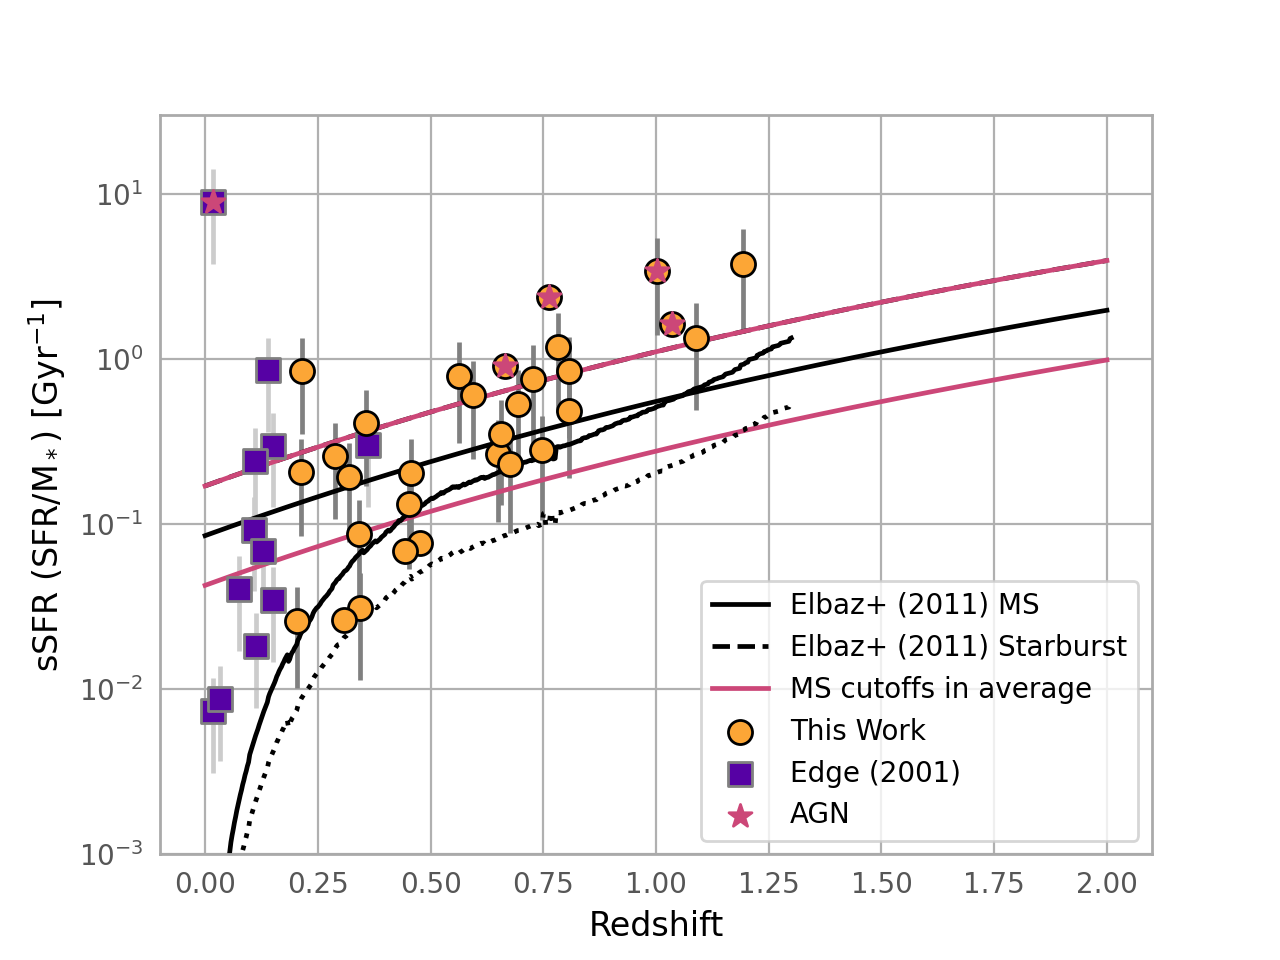

In [109]:
# SSFR MS for us and edge
%matplotlib notebook

zrange = np.linspace(0, 2., num=500)

# whitaker SFR main sequence
aarr = 0.7 - 0.13*zrange
barr = 0.38 + 1.14*zrange - 0.19*zrange**2

mstar = np.array(osamp.mstar)
z = np.array(osamp.z)
ssfrce = np.array(osamp.ssfr)
dssfrce = np.array(osamp.dssfr)

emstar = np.array(esamp.mstar)
ez = np.array(esamp.z)
essfrce = np.array(esamp.ssfr)
edssfrce = np.array(esamp.dssfr)

sfrmsrangemax = np.power(10, aarr*(np.log10(np.max(osamp.mstar)) - 10.5) + barr)
sfrmsrangemin = np.power(10, aarr*(np.log10(np.min(osamp.mstar)) - 10.5) + barr)
sfrmsrangemean = np.power(10, aarr*(np.log10(np.mean(mstar)) - 10.5) + barr)

# plt.plot(zrange, sfrmsrangemax/np.max(mstar.value)*1e9)
# plt.plot(zrange, sfrmsrangemin/np.min(mstar.value)*1e9)
# plt.plot(zrange, sfrmsrangemean/np.mean(mstar.value)*1e9)

plt.scatter(z, ssfrce, label='This Work', s=75, color=plas(0.8), ec='k', zorder=5)
# plt.scatter(zlimits, ssfrlims, s=75, color=plas(0.8), ec='k', zorder=5)
plt.scatter(z[0], ssfrce[0], s=75, marker='*', color=plas(0.5), zorder=6)
plt.scatter(zlimits, ssfrlimsce, s=75, color=plas(0.8), ec='k', zorder=5)
plt.scatter(zlimits[limitagnidx], ssfrlimsce[limitagnidx], s=75, marker='*', color=plas(0.5), zorder=6)

plt.errorbar(z, ssfrce, yerr=dssfrce, fmt='none', color='0.5', zorder=1)
# plt.errorbar(zlimits, ssfrlims, yerr=dssfrlims, fmt='none', color='0.5', zorder=1)

plt.scatter(ez, essfrce, label='Edge (2001)', s=75, marker='s', color=plas(0.15), ec='0.5', zorder=4)
plt.scatter(ez[-1], essfrce[-1], label='AGN', s=75, marker='*', color=plas(0.5), zorder=6)
plt.errorbar(ez, essfrce, yerr=edssfrce, fmt='none', color='0.8', zorder=0)
plt.yscale('log')
# plt.title('sSFR vs Redshift (ELBAZ MS comparison)')


# plt.scatter(zspecsparcs.zbest.iloc[[1,5,6,9]], zspecsparcs.ssfrce.iloc[[1,5,6,9]], zorder=10)
# other sparcs bkgs
specidx = np.where(sparcs.use_rs == False)
rsidx = np.where(sparcs.use_rs == True)
# plt.scatter(sparcs.zbest.iloc[specidx], sparcs.ssfr.iloc[specidx], 
#             label=r'Other SpARCS BCGs ($\mathrm{z}_\mathrm{spec}$)', s=30, 
#             marker='s', color='0.5')
# plt.scatter(sparcs.zbest.iloc[rsidx], sparcs.ssfr.iloc[rsidx], 
#             label=r'Other SpARCS BCGs $(\mathrm{z}_\mathrm{rs})$', s=30,
#             marker='s', color='white', ec='0.5', lw=2)
# plt.scatter(sparcs.zspec, sparcs.ssfr)
gcut = np.where(sparcs.nch1 > 100)
# plt.scatter(sparcs.zbest.iloc[gcut], sparcs.ssfr.iloc[gcut])
# plt.errorbar(sparcs.zbest, sparcs.ssfr, yerr=sparcs.dssfr, fmt='none', color='0.8', zorder=0)

plt.plot(zrange, 26 * np.power(cosmo.age(zrange).to(u.Gyr).value, -2.2), color='k', 
         label='Elbaz+ (2011) MS')
plt.plot(zrange, 52 *np.power(cosmo.age(zrange).to(u.Gyr).value, -2.2), color='k', ls='--',
         label='Elbaz+ (2011) Starburst')


plt.plot(zrange, 26*bmsfrac * np.power(cosmo.age(zrange).to(u.Gyr).value, -2.2), color=plas(0.5), 
         label='MS cutoffs in average')
plt.plot(zrange, 26*amsfrac * np.power(cosmo.age(zrange).to(u.Gyr).value, -2.2), color=plas(0.5))


plt.xlabel('Redshift')
plt.ylabel(r'sSFR (SFR/M$_*$) [Gyr$^{-1}$]')
plt.ylim((1e-3, 3e1))
# plt.xlim((-0.05, 1.25))

detlimz = np.linspace(0., 1.3, num=500)
plt.plot(detlimz, ssfrdetlim, color='k')
plt.plot(detlimz, ssfrmeandetlim, color='k', ls=':')
plt.legend(loc='lower right')

In [110]:
dmgaslimits = -1*np.ones(len(mgaslimits))

<IPython.core.display.Javascript object>


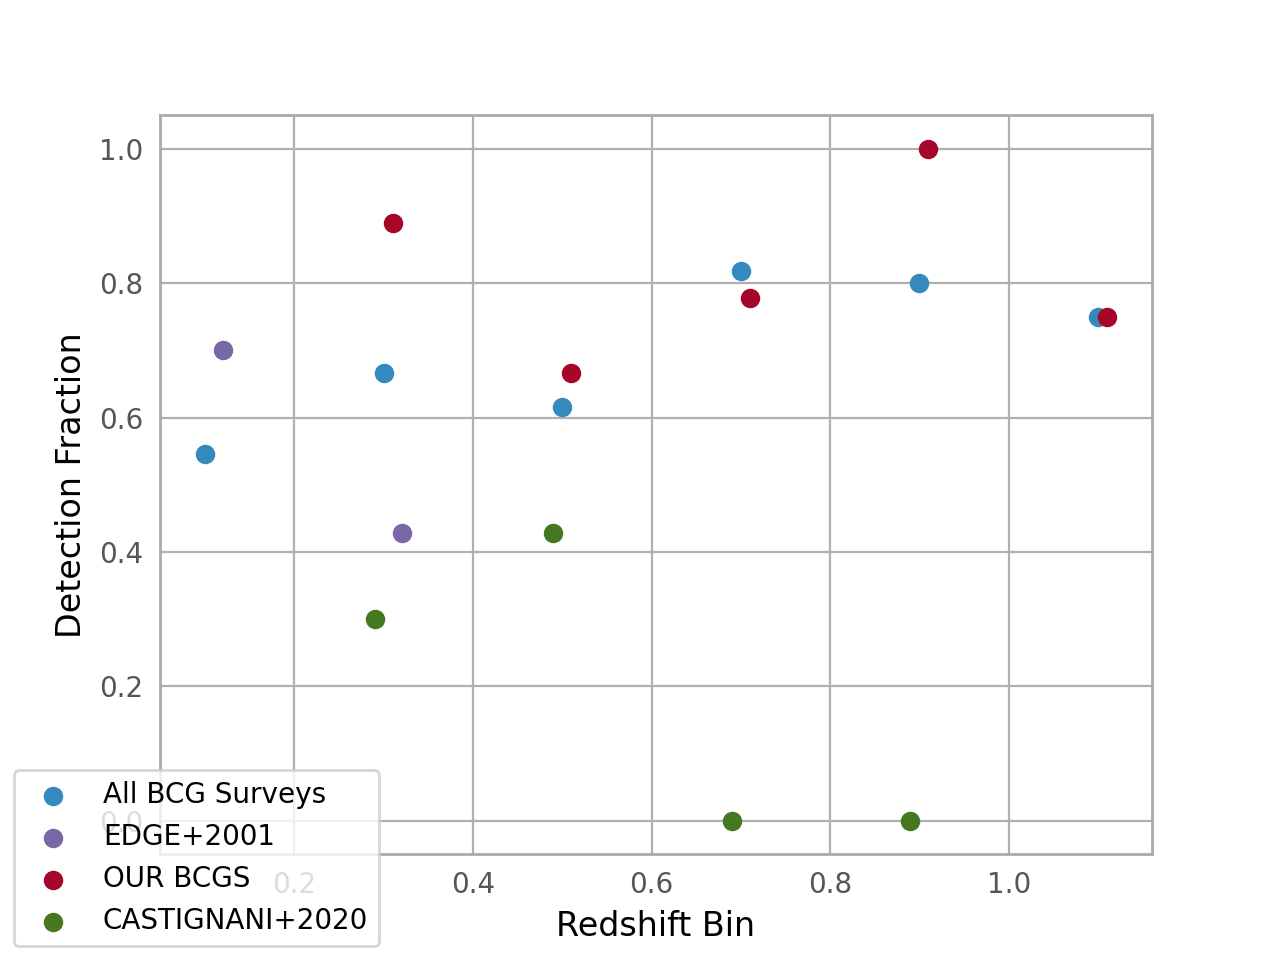

In [113]:
# detection fraction by redshift
bcgz = np.concatenate((z, zlimits, ez, casz, c2z))
bcgmgas = np.concatenate((mgas, mgaslimits, emgas, casmgas, c2mgas))
bcgdmgas = np.concatenate((dmgas, dmgaslimits, edmgas, casdmgas, c2dmgas))

zbins = np.arange(0., 1.6, step=0.2)
binidx = []
for zidx in range(len(zbins) - 1):
    thiszidx_idx = np.where(np.logical_and(bcgz > zbins[zidx], bcgz < zbins[zidx+1]))[0]
    binidx.append(thiszidx_idx)
    
fracs = []
for arr in binidx:
    total = len(arr)
    dec = len(np.where(bcgdmgas[arr] > 0)[0])
    if total == 0:
        fracs.append((np.nan))
    else:
        fracs.append((dec/total))
    
ourbcgz = np.concatenate((z, zlimits))
ourbcgdmgas = np.concatenate((dmgas, dmgaslimits))

ourbinidx = []
for zidx in range(len(zbins) - 1):
    thiszidx_idx = np.where(np.logical_and(ourbcgz > zbins[zidx], ourbcgz < zbins[zidx+1]))[0]
    ourbinidx.append(thiszidx_idx)
    
ourfracs = []
for arr in ourbinidx:
    total = len(arr)
    dec = len(np.where(ourbcgdmgas[arr] > 0)[0])
    if total == 0:
        ourfracs.append((np.nan))
    else:
        ourfracs.append((dec/total))
    
cbinidx = []
for zidx in range(len(zbins) - 1):
    thiszidx_idx = np.where(np.logical_and(casz > zbins[zidx], casz < zbins[zidx+1]))[0]
    cbinidx.append(thiszidx_idx)
    
cfracs = []
for arr in cbinidx:
    total = len(arr)
    dec = len(np.where(casdmgas[arr] > 0)[0])
    if total == 0:
        cfracs.append((np.nan))
    else:
        cfracs.append((dec/total))
    
ezbins = np.array([0.12, 0.32])
efracs = np.array([14/20, 6/14])
    
%matplotlib notebook

fig,ax = plt.subplots(1)

ax.scatter(zbins[:7]+0.1, fracs, label='All BCG Surveys')
ax.scatter(ezbins, efracs, label='EDGE+2001')
ax.scatter(zbins[:7]+0.11, ourfracs, label='OUR BCGS')
ax.scatter(zbins[:7]+0.09, cfracs, label='CASTIGNANI+2020')
ax.set_xlabel('Redshift Bin')
ax.set_ylabel('Detection Fraction')
fig.legend(loc='lower left')

In [114]:
%matplotlib notebook
fig, ax = plt.subplots(1)
im = ax.scatter(osamp.mgas, osamp.sfr, c=z, cmap='jet', ec='k', s=100, zorder=10, vmin=0, vmax=1.2, label='This Work')
ax.errorbar(osamp.mgas, osamp.sfr, xerr=dmgas, yerr=osamp.dsfr, color='0.5', fmt='none', zorder=5)

ax.scatter(esamp.mgas, esamp.sfr, c=ez, cmap='jet', ec='0.5', s=100, marker='s',
           zorder=9, vmin=0, vmax=1.2, label='Edge (2001)')
ax.errorbar(esamp.mgas, esamp.sfr, xerr=edmgas[eggoodidx], yerr=esamp.dsfr, color='0.7',
            fmt='none', zorder=4)

cbar = fig.colorbar(im)
cbar.ax.set_ylabel('Redshift')


ax.set_xlabel(r'$\log(\mathrm{M}_{gas}) \  (\mathrm{M}_\odot )$')
ax.set_ylabel(r'$\log (\mathrm{SFR}) \ (\mathrm{M}_\odot \ \mathrm{yr}^{-1})$')
ax.set_xscale('log')
ax.set_yscale('log')

xvals = np.linspace(np.min(np.log10(osamp.mgas)), np.max(np.log10(osamp.mgas)), num=500)
# ax.plot(xvals, straightline(xvals, *opt))

ax.legend()
ax.set_title('Gas Mass vs SFR (Redshift bins)')

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Gas Mass vs SFR (Redshift bins)')

<IPython.core.display.Javascript object>


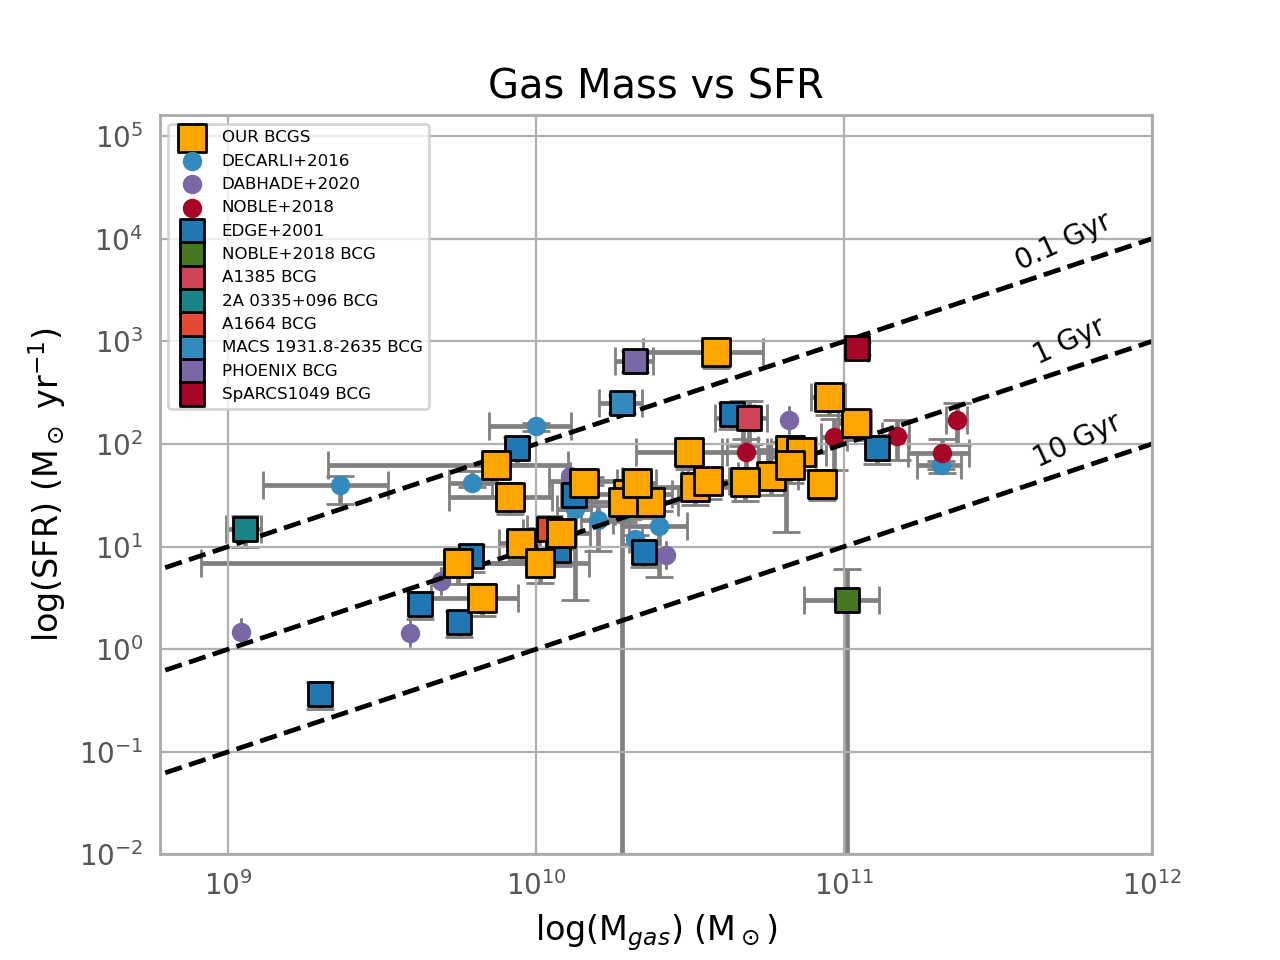

Text(0.5, 1.0, 'Gas Mass vs SFR')

In [115]:
%matplotlib notebook
fig, ax = plt.subplots(1)
colors=['darkblue', 'orange', 'blueviolet', 'aquamarine', 'green']
markers = ['o', '^', 's', 'o', 'v']
# for i in range(len(zidx)):
#     ax.scatter(mgas[zidx[i][0]], mips_sfr_ce[zidx[i][0]].value, label='{:.1f} < z < {:.1f}'.format(zbins[i], zbins[i + 1]),
#               color=colors[i], marker=markers[i], s=75)
#     ax.errorbar(mgas[zidx[i][0]], mips_sfr_ce[zidx[i][0]].value, xerr=dmgas[zidx[i][0]], yerr=mips_sfr_err[zidx[i][0]].value, 
#                 color='0.5', fmt='none', zorder=0, capsize=5)
    
ax.scatter(osamp.mgas, osamp.sfr, label='OUR BCGS', s=100, ec='k', zorder=20, color='orange', marker='s')
ax.errorbar(osamp.mgas, osamp.sfr, xerr=osamp.dmgas, yerr=osamp.dsfr, color='0.5', fmt='none', zorder=0, capsize=5)
    
    
ax.scatter(decmgas, decsfr, label='DECARLI+2016')
ax.errorbar(decmgas, decsfr, xerr=decdmgas, yerr=np.stack((decdsfrup, decdsfrdown), axis=0),
           color='0.5', fmt='none', zorder=0, capsize=5)

ax.scatter(dabmgas, dabsfr, label='DABHADE+2020')
ax.errorbar(dabmgas, dabsfr, xerr=dabdmgas, color='0.5', fmt='none', zorder=0, capsize=5)

ax.scatter(nmgas[:6], nsfr[:6], label='NOBLE+2018')
ax.errorbar(nmgas[:6], nsfr[:6], xerr=ndmgas[:6], yerr=ndsfr[:6], color='0.5', fmt='none', zorder=0, capsize=5)

esfridx = np.where(esfr != -99)
# ax.scatter(emgas[eggoodidx], efitsfr.value, label='EDGE+2001', marker='s', s=75, zorder=5, ec='k', color='tab:blue')
# ax.errorbar(emgas[eggoodidx], efitsfr.value, yerr=edfitsfr.value, color='0.5', fmt='none', zorder=0,
#            capsize=5)
ax.scatter(esamp.mgas, esamp.sfr, label='EDGE+2001', marker='s', s=75, zorder=5, ec='k', color='tab:blue')
ax.errorbar(esamp.mgas, esamp.sfr, yerr=esamp.dsfr, color='0.5', fmt='none', zorder=0,
           capsize=5)


ax.scatter(nmgas[-1], nsfr[-1], label='NOBLE+2018 BCG', marker='s', s=75, zorder=5, ec='k')
ax.errorbar(nmgas[-1], nsfr[-1], xerr=ndmgas[-1], yerr=ndsfr[-1], color='0.5', fmt='none', zorder=0, capsize=5)

ax.scatter(mcmgas, mcsfr, label='A1385 BCG', marker='s', s=75, zorder=5, ec='k')
ax.errorbar(mcmgas, mcsfr, xerr=mcdmgas, yerr=mcdsfr, color='0.5', fmt='none', zorder=0, capsize=5)

ax.scatter(vmgas, vsfr, label='2A 0335+096 BCG', marker='s', s=75, zorder=5, ec='k')
ax.errorbar(vmgas, vsfr, xerr=vdmgas, yerr=vdsfr, color='0.5', fmt='none', zorder=0, capsize=5)

ax.scatter(rusmgas, russfr, zorder=5, label='A1664 BCG', marker='s', s=75, ec='k')
ax.errorbar(rusmgas, russfr, xerr=rusdmgas, yerr=rusdsfr, color='0.5', fmt='none', zorder=0, capsize=5)

ax.scatter(fmgas, fsfr, zorder=5, label='MACS 1931.8-2635 BCG', marker='s', s=75, ec='k')
ax.errorbar(fmgas, fsfr, xerr=fdmgas, yerr=50, color='0.5', fmt='none', zorder=0, capsize=5)

ax.scatter(pmgas, psfr, zorder=5, label='PHOENIX BCG', marker='s', s=75, ec='k')
ax.errorbar(pmgas, psfr, xerr=pdmgas, yerr=pdsfr, color='0.5', fmt='none', zorder=0, capsize=5)

ax.scatter(mgas1049, sfr1049, zorder=5, label='SpARCS1049 BCG', marker='s', s=75, ec='k')
ax.errorbar(mgas1049, sfr1049, xerr=dmgas1049, yerr=dsfr1049, color='0.5', fmt='none', zorder=0, capsize=5)

ax.set_xlabel(r'$\log(\mathrm{M}_{gas}) \  (\mathrm{M}_\odot )$')
ax.set_ylabel(r'$\log (\mathrm{SFR}) \ (\mathrm{M}_\odot \ \mathrm{yr}^{-1})$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-2, 1e5+6e4)
ax.set_xlim(6e8, 1e12)

xvals = np.linspace(np.min(np.log10(mgas)), np.max(np.log10(mgas)), num=500)
# ax.plot(xvals, straightline(xvals, *opt))

# whitaker sfr-mgas main sequence: log(SFR) = a(z)(logM*-10.5) + b(z)
# for z = 0.8
a08 = 0.7 - 0.13*(0.8)
b08 = 0.38 + 1.14*0.8 - 0.19*0.8**2

# for z = 0.2
a01 = 0.7 - 0.13*0.1
b01 = 0.38 + 1.14*0.1 - 0.19*0.1**2

mgasrange = np.linspace(1e8, 1e12, num=500)
# ax.plot(mgasrange, np.power(10, a08*(np.log10(mgasrange) - 10.5) + b08), color='k')
# ax.plot(mgasrange, np.power(10, a01*(np.log10(mgasrange) - 10.5) + b01))
ax.plot(mgasrange, 1/1e9*mgasrange, color='k', ls='--')
ax.plot(mgasrange, 1/1e8*mgasrange, color='k', ls='--')
ax.plot(mgasrange, 1/1e10*mgasrange, color='k', ls='--')

ax.annotate('0.1 Gyr', xy=(3.5e11, 5e3), rotation=25)
ax.annotate('1 Gyr', xy=(4e11, 6e2), rotation=25)
ax.annotate('10 Gyr', xy=(4e11, 6e1), rotation=25)

ax.legend(fontsize=6)
ax.set_title('Gas Mass vs SFR')

In [116]:
altfgas = altmgas / mstar
altdfgas = altfgas*np.sqrt((altdmgas/altmgas)**2 + ((dmstar)/(mstar))**2)

In [117]:
osamp.sfrms

0     66.365852
1     19.548270
2     27.979633
3     33.945596
4     10.081133
5      6.687780
6     20.194239
7     37.430298
8     29.484156
9     19.810901
10    21.738184
11    12.936532
12    47.698951
13    34.496968
14    14.357756
15     5.511107
16    34.721515
17    23.869751
18    26.468678
19    25.687468
20    24.350736
21     7.734637
22    10.156569
23    12.503586
Name: sfrms, dtype: float64

In [119]:
fgas = np.array(osamp.fgas)
efgas = np.array(esamp.fgas)

emgas = np.array(esamp.mgas)

dfgas = np.array(osamp.dfgas)
edfgas = np.array(esamp.dfgas)

# whitaker SFR main sequence
aarr = 0.7 - 0.13*z
barr = 0.38 + 1.14*z - 0.19*z**2

eaarr = 0.7 - 0.13*ez
ebarr = 0.38 + 1.14*ez - 0.19*ez**2

sfrwms = np.power(10, aarr*(np.log10(np.array(osamp.mstar)) - 10.5) + barr)
esfrwms = np.power(10, eaarr*(np.log10(np.array(esamp.mstar)) - 10.5) + ebarr)

sfr_wmsdistance = np.array(osamp.sfr / sfrwms)
esfr_wmsdistance = np.array(esamp.sfr / esfrwms)

# scatter = 0.34 dex
dsfrwms = np.power(10, 0.34 - np.log10(sfrwms)) - sfrwms
dsfrwms = (1-10**-0.34)*sfrwms
edsfrwms = np.power(10, 0.34 - np.log10(esfrwms)) - esfrwms
edsfrwms = (1-10**-0.34)*esfrwms

dsfr_wmsdistance = sfr_wmsdistance*np.sqrt((np.array(osamp.dsfr/osamp.sfr))**2 + dsfrwms**2/sfrwms**2)
edsfr_wmsdistance = esfr_wmsdistance*np.sqrt(np.array(esamp.dsfr/esamp.sfr)**2
                                           + edsfrwms**2/esfrwms**2)


lmstar = np.log10(mstar)
elmstar = np.log10(emstar)

lmsmin = np.min(lmstar)
lmsmax = np.max(elmstar)

# gas fraction main sequence (and distance from)
fgas_ms = np.power(10, 2.71*np.log10(1+z) - 1.23)
efgas_ms = np.power(10, 2.71*np.log10(1+ez) - 1.23)

dfgas_ms = np.power(10, 0.09*np.log10(1+z) + 0.01)*fgas_ms - fgas_ms
edfgas_ms = np.power(10, 0.09*np.log10(1+ez) + 0.01)*efgas_ms - efgas_ms

fgas_msdistance = mgas / (mgas + osamp.mstar) / fgas_ms
efgas_msdistance = emgas / (emgas + np.array(esamp.mstar)) / efgas_ms

dfgas_msdistance = fgas_msdistance*np.sqrt(dfgas**2/fgas**2 + dfgas_ms**2/fgas_ms**2)
edfgas_msdistance = efgas_msdistance*np.sqrt(edfgas**2/efgas**2 + edfgas_ms**2/efgas_ms**2)

<IPython.core.display.Javascript object>


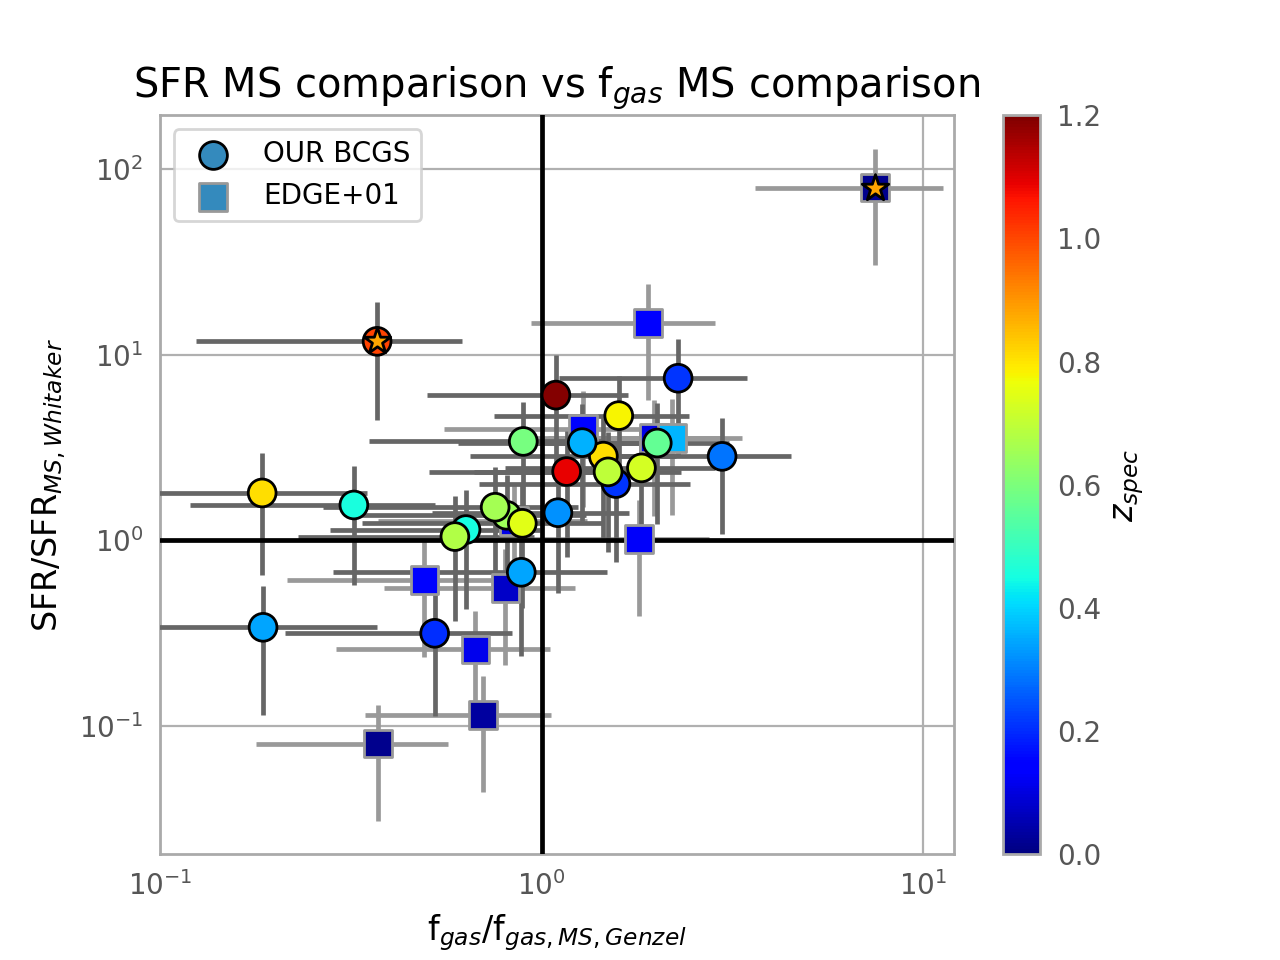

In [120]:
# gas mass vs distance from the SFR main sequence of whitaker (2012)

%matplotlib notebook
fig, ax = plt.subplots(1)

im = ax.scatter(fgas_msdistance, sfr_wmsdistance, c=z, label='OUR BCGS', marker='o', s=100, vmin=0, vmax=1.2, 
                cmap='jet', ec='k', zorder=20)
ax.errorbar(fgas_msdistance, sfr_wmsdistance, yerr=dsfr_wmsdistance, xerr=dfgas_msdistance,
            color='0.4', fmt='none', zorder=5)
ax.scatter(fgas_msdistance[0], sfr_wmsdistance[0], c='orange', marker='*', s=100, zorder=20, ec='k')
ax.scatter(efgas_msdistance, esfr_wmsdistance, c=ez, label='EDGE+01', marker='s', s=100, 
           vmin=0, vmax=1.2, cmap='jet', ec='0.6', zorder=19)
ax.errorbar(efgas_msdistance, esfr_wmsdistance, yerr=edsfr_wmsdistance, xerr=edfgas_msdistance,
            color='0.6', fmt='none', zorder=3)
ax.scatter(np.array(efgas_msdistance)[-1], np.array(esfr_wmsdistance)[-1], c='orange', marker='*', s=100, zorder=20, ec='k')


ax.set_xlabel(r'$\mathrm{f}_{gas}  / \mathrm{f}_{gas, MS, Genzel}$')
ax.set_ylabel(r'$\mathrm{SFR} / \mathrm{SFR}_{MS, Whitaker}$')

cmap = fig.colorbar(im)
cmap.ax.set_ylabel(r'$z_{spec}$')

ax.set_title(r'SFR MS comparison vs $\mathrm{f}_{gas}$ MS comparison')
ax.axhline(1, color='k', zorder=10)
ax.axvline(1, color='k', zorder=10)

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim(1e-1, 1.2e1)
# ax.set_ylim(1e-1, 500)

ax.legend()

<IPython.core.display.Javascript object>


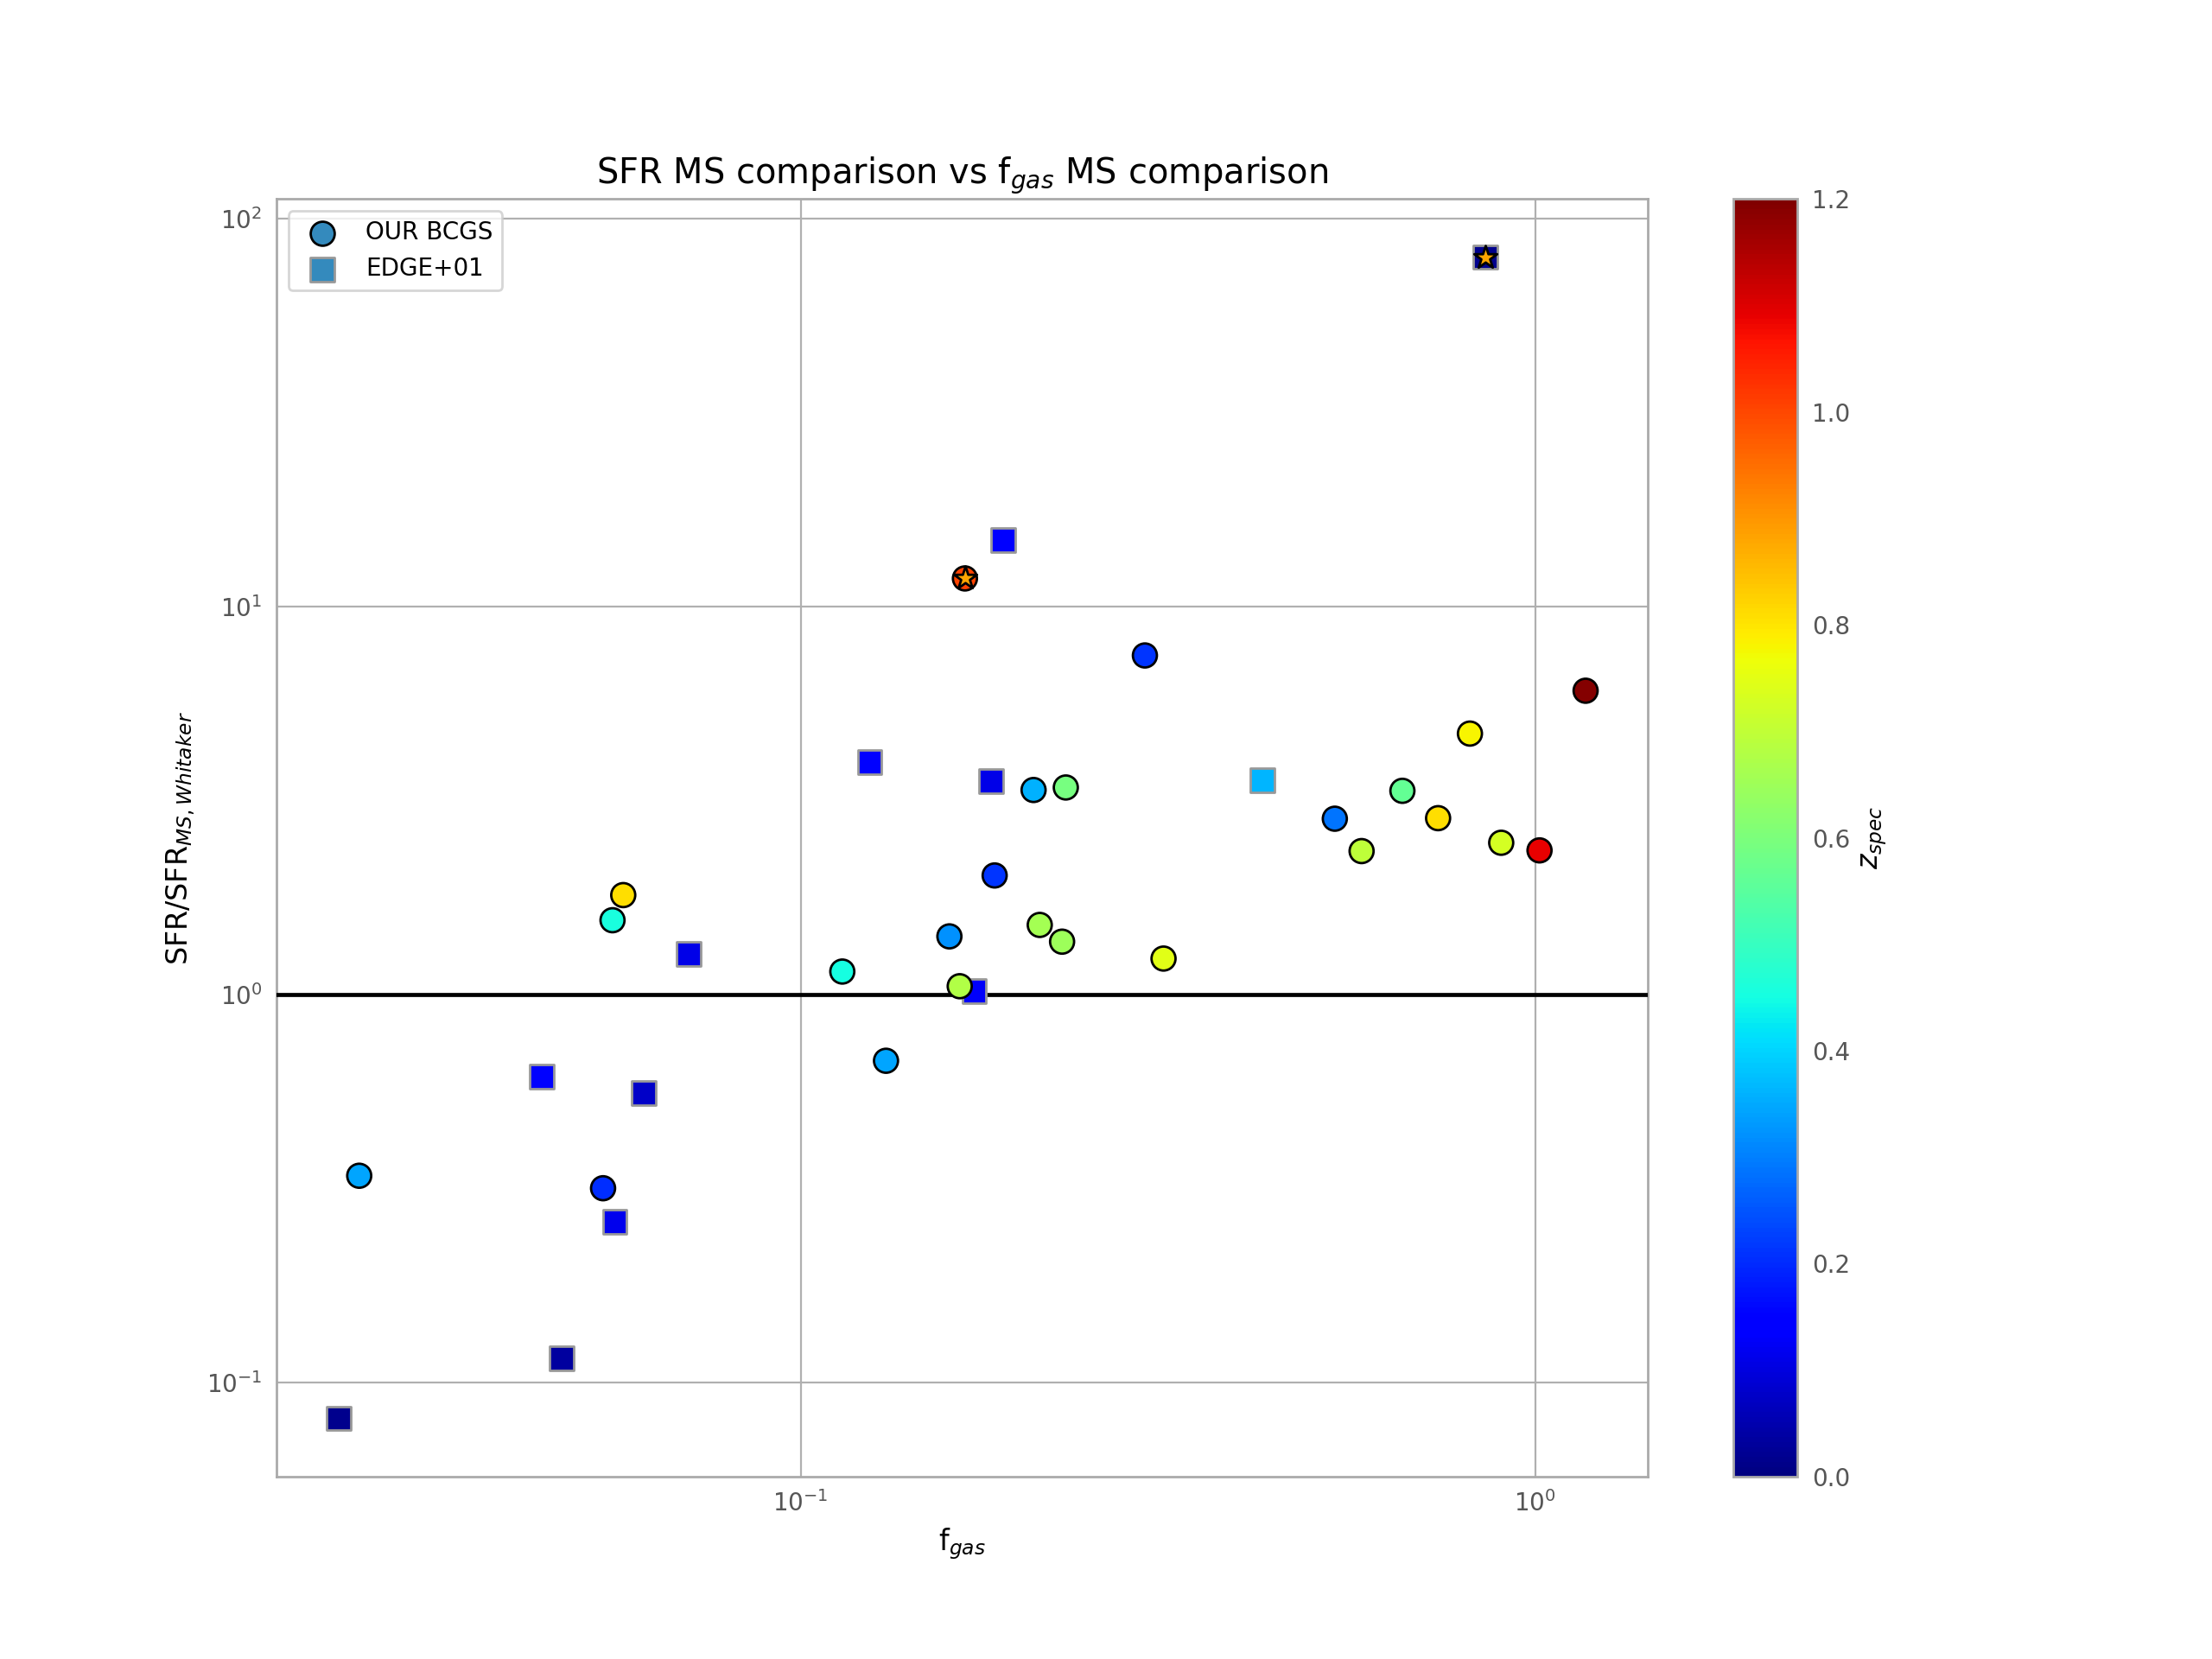

In [121]:
%matplotlib notebook
fig, ax = plt.subplots(1)

im = ax.scatter(fgas, sfr_wmsdistance, c=z, label='OUR BCGS', marker='o', s=100, vmin=0, vmax=1.2, 
                cmap='jet', ec='k', zorder=20)
# ax.errorbar(fgas, sfr_wmsdistance, yerr=dsfr_wmsdistance, xerr=dfgas_msdistance,
#             color='0.4', fmt='none', zorder=5)
ax.scatter(fgas[0], sfr_wmsdistance[0], c='orange', marker='*', s=100, zorder=20, ec='k')
ax.scatter(efgas, esfr_wmsdistance, c=ez, label='EDGE+01', marker='s', s=100, 
           vmin=0, vmax=1.2, cmap='jet', ec='0.6', zorder=19)
# ax.errorbar(efgas, esfr_wmsdistance, yerr=edsfr_wmsdistance, xerr=edfgas_msdistance,
#             color='0.6', fmt='none', zorder=3)
ax.scatter(efgas[-1], esfr_wmsdistance[-1], c='orange', marker='*', s=100, zorder=20, ec='k')


ax.set_xlabel(r'$\mathrm{f}_{gas}$')
ax.set_ylabel(r'$\mathrm{SFR} / \mathrm{SFR}_{MS, Whitaker}$')

cmap = fig.colorbar(im)
cmap.ax.set_ylabel(r'$z_{spec}$')

ax.set_title(r'SFR MS comparison vs $\mathrm{f}_{gas}$ MS comparison')
ax.axhline(1, color='k', zorder=10)
# ax.axvline(1, color='k', zorder=10)

ax.set_yscale('log')
ax.set_xscale('log')
# ax.set_xlim(1e-1, 1.2e1)
# ax.set_ylim(1e-1, 500)

ax.legend()

In [125]:
sig = np.array(np.log10(osamp.ssfr+osamp.dssfr) - np.log10(osamp.ssfr))
opt, cov = curve_fit(straightline, np.log10(mgas), np.log10(osamp.ssfr), p0=[1e-4, 0], sigma=sig)
opt

esig = np.array(np.log10(esamp.ssfr+esamp.dssfr) - np.log10(esamp.ssfr))
eopt, ecov = curve_fit(straightline, np.log10(emgas), 
                       np.log10(esamp.ssfr), p0=[1e-4, 0], sigma=esig)

In [133]:
ssfr, dssfr = np.array(osamp.ssfr), np.array(osamp.dssfr)
essfr, edssfr, edmgas = np.array(esamp.ssfr), np.array(esamp.dssfr), np.array(esamp.dmgas)

In [134]:
len(edmgas)

12

<IPython.core.display.Javascript object>


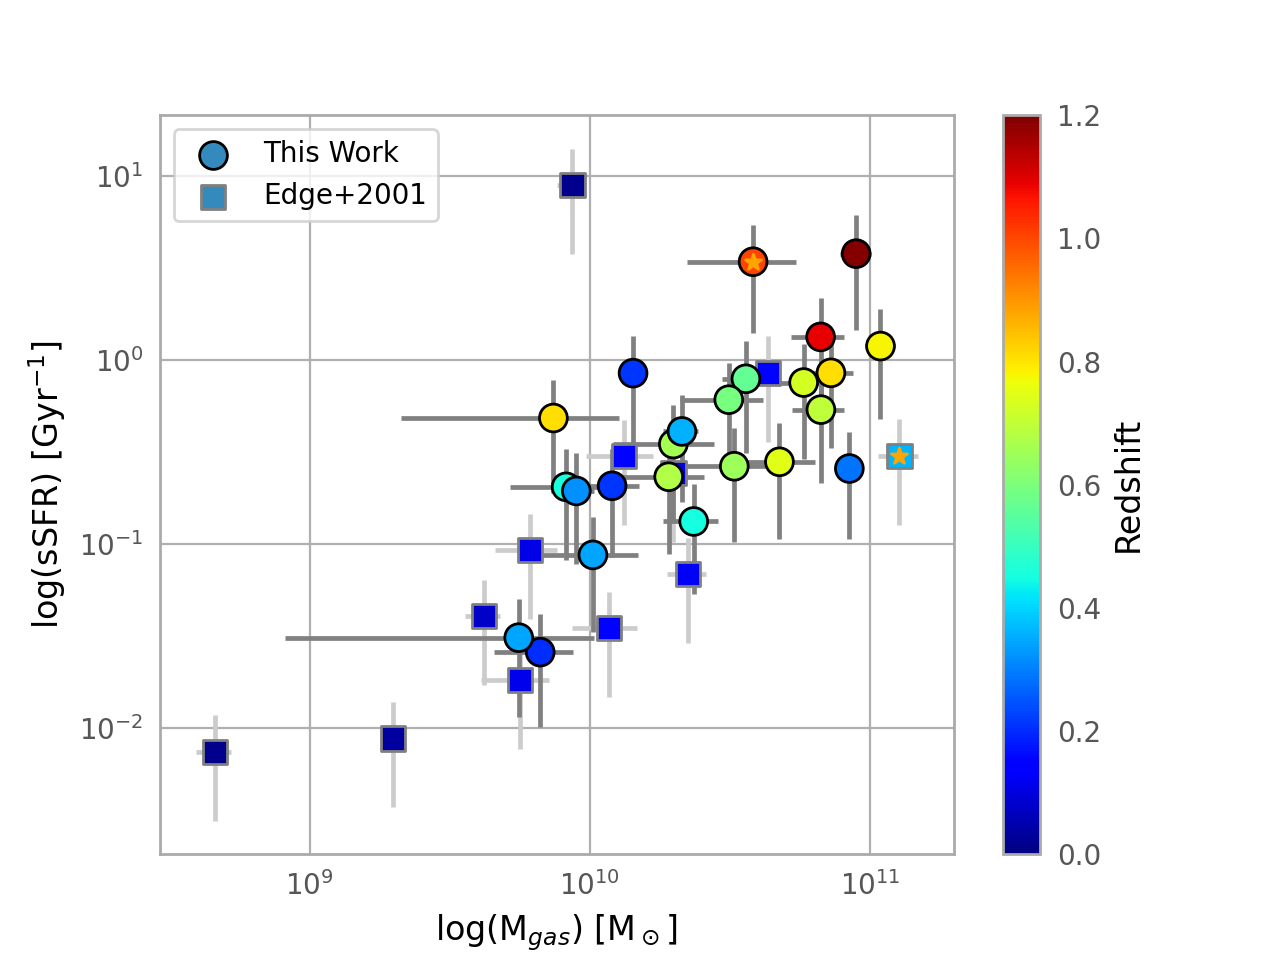

In [135]:
%matplotlib notebook
fig, ax = plt.subplots(1)
colors=['darkblue', 'orange', 'blueviolet', 'aquamarine', 'green']
markers = ['o', '^', 's', 'o', 'v']
    
im = ax.scatter(mgas, ssfr, label='This Work', s=100, ec='k', zorder=20, c=z, cmap='jet', vmin=0., vmax=1.2)
ax.scatter(mgas[0], ssfr[0], c='orange', marker='*', zorder=20)
ax.errorbar(mgas, ssfr, xerr=dmgas, yerr=dssfr, color='0.5', fmt='none', zorder=5) 

eagnidxfull = -5


# EDGE
ax.scatter(emgas, essfr, zorder=19, label='Edge+2001', marker='s', s=75, ec='0.5', 
           c=ez, cmap='jet', vmin=0., vmax=1.2)
ax.errorbar(emgas, essfr, xerr=edmgas, yerr=edssfr, color='0.8', 
            fmt='none', zorder=4)
ax.scatter(emgas[eagnidxfull], essfr[eagnidxfull], marker='*', color='orange', zorder=20)

cbar = fig.colorbar(im)
cbar.ax.set_ylabel('Redshift')


ax.set_xlabel(r'$\log(\mathrm{M}_{gas}) \  [\mathrm{M}_\odot ]$')
ax.set_ylabel(r'$\log (\mathrm{sSFR}) \ [\mathrm{Gyr}^{-1}]$')
ax.set_xscale('log')
ax.set_yscale('log')
# # ax.set_ylim((1e-3, 1e2))
# ax.set_xlim((6e8, 8e11))

# xvals = np.linspace(np.min((mgas)), np.max((mgas)), num=500)
# ax.plot(xvals, np.power(10, straightline(np.log10(xvals), *opt)))

# exvals = np.linspace(np.min(emgas), np.max(emgas), num=500)
# ax.plot(exvals, np.power(10, straightline(np.log10(exvals), *eopt)))

ax.legend(loc='upper left')

## Redo the fits using Orthogonal Distance Regression

In [139]:
# uncertainties on the logarithm of ssfr and mgas using error propagation
dlogmgas = np.abs(dmgas / (mgas * np.log(10)))
dlogssfr = np.abs(dssfr / (ssfr * np.log(10)))

edlogmgas = np.abs(edmgas / (emgas * np.log(10)))
edlogssfr = np.abs(edssfr / (essfr * np.log(10)))

In [140]:
def odrstraightline(B, x):
    return B[0]*x + B[1]

In [141]:
def odr_fit(xvals, yvals, dxvals, dyvals, beta0, logx=True):
    
    if logx:
        lxvals = np.log10(xvals)
        dlxvals = np.abs(dxvals / (xvals * np.log(10)))
    else:
        lxvals = xvals
        dlxvals = dxvals
    
    lyvals = np.log10(yvals)
    dlyvals = np.abs(dyvals / (yvals * np.log(10)))
    
    def odrstraightline(B, x):
        return B[0]*x + B[1]
    
    linemodel = odr.Model(odrstraightline)
    linedata = odr.RealData(lxvals, lyvals, sx=dlxvals, sy=dlyvals)
    lineodr = odr.ODR(linedata, linemodel, beta0=beta0)
    
    return lineodr.run()

In [142]:
# function to do the various fits needed for this stat analysis
def do_fits(sSFR, esSFR, Mgas, eMgas, dsSFR, edsSFR, dMgas, edMgas, mcomb=False):
    # log the values
    lmgas, lssfr = np.log10(Mgas), np.log10(sSFR)
    elmgas, elssfr = np.log10(eMgas), np.log10(esSFR)
    
    # log the uncertainties
    dlmgas = np.abs(dMgas / (Mgas * np.log(10)))
    edlmgas = np.abs(edMgas / (eMgas * np.log(10)))
    
    dlssfr = np.abs(dsSFR / (sSFR * np.log(10)))
    edlssfr = np.abs(edsSFR / (esSFR * np.log(10)))
    
    # combine the logged values for future use
    clmgas = np.concatenate((lmgas, elmgas))
    clssfr = np.concatenate((lssfr, elssfr))
    
    cdlmgas = np.concatenate((dlmgas, edlmgas))
    cdlssfr = np.concatenate((dlssfr, edlssfr))
    
    # fit to a straight line with slope allowed to vary
    # odr routine needs independent variable in the last position and all fit parameters packed into a vector
    def odrstraightline(B, x):
        return B[0]*x + B[1]
    
    linemodelm = odr.Model(odrstraightline)
    linedatam = odr.RealData(lssfr, lmgas, sx=dlssfr, sy=dlmgas)
    lineodrm = odr.ODR(linedatam, linemodelm, beta0=[0.5,10])
    outputm = lineodrm.run()
    
    elinedatam = odr.RealData(elssfr, elmgas, sx=edlssfr, sy=edlmgas)
    elineodrm = odr.ODR(elinedatam, linemodelm, beta0=[0.5,10])
    eoutputm = elineodrm.run()
    
    # fit to the full line model (slope allowed to vary) for the combined sample
    clinedata = odr.RealData(clssfr, clmgas, sx=cdlssfr, sy=cdlmgas)
    clineodr = odr.ODR(clinedata, linemodelm, beta0=[0.7, 10])
    coutput = clineodr.run()
    
    # linear function with slope fixed to the mean of the slopes of the two samples
    def odrline_mfix_mcomb(b, x):
        return coutput.beta[0]*x + b
    def odrline_mfix(b, x):
        return np.mean((outputm.beta[0], eoutputm.beta[0]))*x + b
        
    # fit each individual sample to the line model with fixed slope
    if mcomb:
        linemodel = odr.Model(odrline_mfix_mcomb)
    else:
        linemodel = odr.Model(odrline_mfix)
    linedata = odr.RealData(lssfr, lmgas, sx=dlssfr, sy=dlmgas)
    lineodr = odr.ODR(linedata, linemodel, beta0=[10])
    output = lineodr.run()
    
    elinedata = odr.RealData(elssfr, elmgas, sx=edlssfr, sy=edlmgas)
    elineodr = odr.ODR(elinedata, linemodel, beta0=[10])
    eoutput = elineodr.run()
    
    # get the hyp resids of each sample to the combined linear function
    hypresids, dhypresids, minvarr, binvarr, x2vals, y2vals = hyp(sSFR, Mgas, *coutput.beta, dsSFR, dMgas, 
                                                                  *coutput.sd_beta)
    ehypresids, edhypresids, eminvarr, ebinvarr, ex2vals, ey2vals = hyp(esSFR, eMgas, *coutput.beta, edsSFR, 
                                                                        edMgas, *coutput.sd_beta)
    
    pval = ks_2samp(hypresids, ehypresids).pvalue
    
    return (outputm, eoutputm), (output, eoutput), coutput, (hypresids, ehypresids), 1 - pval

In [143]:
def odrline_mfix(b, x):
        return coutput.beta[0]*x + b

In [144]:
from scipy.stats import ks_2samp

In [145]:
def hyp(xvals, yvals, m, b, dx, dy, dm, db):
    
    """ assumes we're fitting in logspace to values that aren't logged - will log the x and y vals and
       convert the uncertanites """
    
    dx = np.abs(dx / (xvals * np.log(10)))
    dy = np.abs(dy / (yvals * np.log(10)))
    
    xvals = np.log10(xvals)
    yvals = np.log10(yvals)
    
    minv = -1 * 1/m
    dminv = dm / m**2
    
    binv = yvals - minv*xvals
    
    dbinv = dy + (minv*xvals) * np.sqrt((dm / m)**2 + (dx / xvals)**2)
    
    x2 = (b - binv) / (minv - m)
    dx2 = x2 * np.sqrt(((dminv + dm)/(minv - m))**2 + ((dbinv + db)/(b - binv))**2)
    
    y2 = m*x2 + b
    dy2 = m*x2 * np.sqrt((dm/m)**2 + (dx2/x2)**2) + db
    
    ytest = m*xvals + b
    
    dist = np.sqrt((xvals - x2)**2 + (yvals - y2)**2) * np.sign(yvals - ytest)
    ddist = np.sqrt(((xvals - x2)*(dx + dx2)/dist)**2 + ((yvals - y2)*(dy + dy2)/dist)**2)
    
#     ddist = dist*np.sqrt((dx/xvals)**2 + (dy/yvals)**2)
    
    return dist, ddist, minv, binv, x2, y2

In [148]:
_, _, ecoutput, _, pval = do_fits(ssfr[1:], essfr[:-1], mgas[1:], emgas[:-1], dssfr[1:], 
                           edssfr[:-1], dmgas[1:], edmgas[:-1])

<IPython.core.display.Javascript object>


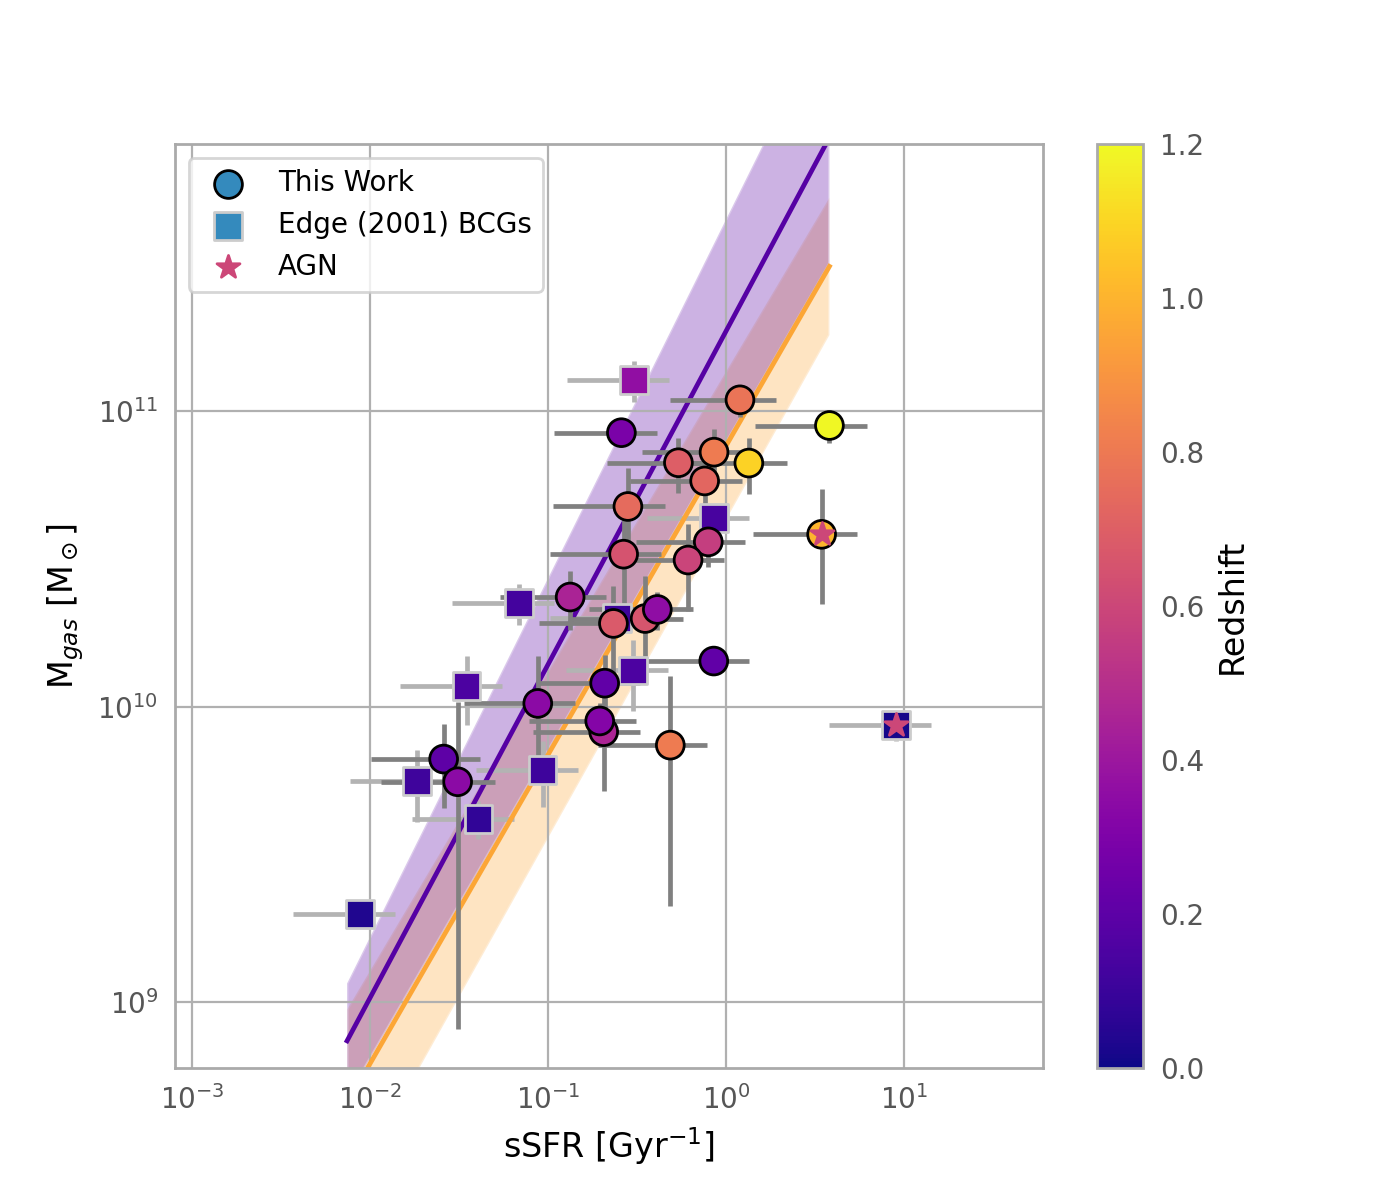

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


In [150]:
%matplotlib notebook
from matplotlib.patches import Polygon, Rectangle
fig, ax = plt.subplots(1, figsize=(7, 6)) 

ax.scatter(osamp.ssfr, osamp.mgas, c=z, cmap='plasma', vmin=0., vmax=1.2, s=100, zorder=10, ec='k', label='This Work')
ax.scatter(osamp.ssfr.iloc[0], osamp.mgas.iloc[0], c=plas(0.5), marker='*', zorder=20, s=75)
ax.errorbar(osamp.ssfr, osamp.mgas, xerr=osamp.dssfr, yerr=osamp.dmgas, color='0.5', fmt='none', zorder=3)


im = ax.scatter(esamp.ssfr, esamp.mgas, c=esamp.z, marker='s', s=100, zorder=5, ec='0.8', 
           label='Edge (2001) BCGs', cmap='plasma', vmin=0., vmax=1.2)
ax.scatter(esamp.ssfr.iloc[-1], esamp.mgas.iloc[-1], c=plas(0.5), marker='*', zorder=20, s=75, 
           label='AGN')
ax.errorbar(esamp.ssfr, esamp.mgas, xerr=esamp.dssfr, yerr=esamp.dmgas, color='0.7', 
            fmt='none', zorder=2)


ax.set_ylabel(r'$\mathrm{M}_{gas} \  [\mathrm{M}_\odot ]$')
ax.set_xlabel(r'$\mathrm{sSFR} \ [\mathrm{Gyr}^{-1}]$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim((8e-4, 6e1))
ax.set_ylim((6e8, 8e11))

ssfr = np.array(osamp.ssfr)
essfr = np.array(esamp.ssfr)
mgas = np.array(osamp.mgas)
emgas = np.array(esamp.mgas)
dssfr = np.array(osamp.dssfr)
edssfr = np.array(esamp.dssfr)
dmgas = np.array(osamp.dmgas)
edmgas = np.array(esamp.dmgas)

cssfr = np.concatenate((ssfr[1:], essfr[:-1]))
cmgas = np.concatenate((mgas[1:], emgas[:-1]))

cdssfr = np.concatenate((dssfr[1:], edssfr[:-1]))
cdmgas = np.concatenate((dmgas[1:], edmgas[:-1]))
xvals = np.linspace(np.min(cssfr), np.max(cssfr), num=500)
output = odr_fit(cssfr, cmgas, cdssfr, cdmgas, [0.5, 10])

ooutput = odr_fit(ssfr[1:], mgas[1:], dssfr[1:], dmgas[1:], [0.5, 10])
eoutput = odr_fit(essfr[:-1], emgas[:-1], edssfr[:-1], edmgas[:-1],
                  [0.5, 10])

oyvals = np.power(10, odrstraightline(ooutput.beta, np.log10(xvals)))
eyvals = np.power(10, odrstraightline(eoutput.beta, np.log10(xvals)))
oyvalsmin = np.power(10, odrstraightline(ooutput.beta - ooutput.sd_beta, np.log10(xvals)))
oyvalsmax = np.power(10, odrstraightline(ooutput.beta + ooutput.sd_beta, np.log10(xvals)))
eyvalsmin = np.power(10, odrstraightline(eoutput.beta - eoutput.sd_beta, np.log10(xvals)))
eyvalsmax = np.power(10, odrstraightline(eoutput.beta + eoutput.sd_beta, np.log10(xvals)))
ax.plot(xvals, oyvals, color=plas(0.8))
ax.plot(xvals, eyvals, color=plas(0.15))

xuncerts = np.array([np.min(xvals), np.min(xvals), np.max(xvals), np.max(xvals)])
oyuncerts = np.array([np.min(oyvalsmin), np.min(oyvalsmax), np.max(oyvalsmin), np.max(oyvalsmax)])
eyuncerts = np.array([np.min(eyvalsmin), np.min(eyvalsmax), np.max(eyvalsmin), np.max(eyvalsmax)])
oxy = np.stack((xuncerts, oyuncerts.flatten()), axis=1)
exy = np.stack((xuncerts, eyuncerts.flatten()), axis=1)



ofituncert = Polygon(oxy, alpha=0.3, color=plas(0.8), ec='white', zorder=0)
efituncert = Polygon(exy, alpha=0.3, color=plas(0.15), ec='white', zorder=0)
ax.add_patch(ofituncert)
ax.add_patch(efituncert)

cbar = fig.colorbar(im)
cbar.ax.set_ylabel('Redshift')


ax.legend(loc='upper left')

In [151]:
print(ooutput.beta, ooutput.sd_beta)

[ 1.04496162 10.8844271 ] [0.2027834 0.114798 ]


In [152]:
print(ooutput.beta + ooutput.sd_beta, ooutput.beta - ooutput.sd_beta)

[ 1.24774502 10.99922509] [ 0.84217822 10.7696291 ]


In [153]:
print(eoutput.beta + eoutput.sd_beta, eoutput.beta - eoutput.sd_beta)

[ 1.3571373  11.56742777] [ 0.89827576 10.97775019]


In [155]:
# fit to both samples together
# merr, berr = np.sqrt(ccovflip[0,0]), np.sqrt(ccovflip[1,1])
hypresidsms, dhypresidsms, minvarr, binvarr, x2vals, y2vals = hyp(ssfr, mgas, 
                                                                  *output.beta, dssfr, dmgas, 
                                                                  *output.sd_beta)
ehypresidsms, edhypresidsms, eminvarr, ebinvarr, ex2vals, ey2vals = hyp(essfr, emgas,
                                                                    *output.beta, edssfr, 
                                                                    edmgas, *output.sd_beta)

In [156]:
ks_2samp(hypresidsms, ehypresidsms)

KstestResult(statistic=0.3333333333333333, pvalue=0.3200959687945226)

In [158]:
ks_2samp(fgas_msdistance[1:], efgas_msdistance[:-1])

KstestResult(statistic=0.1976284584980237, pvalue=0.8681541582150101)

In [159]:
ks_2samp(sfr_msdistance[1:], esfr_msdistance[:-1])

NameError: name 'sfr_msdistance' is not defined

In [ ]:
hypres, dhypres, _,_,_,_ = hyp(ssfr, mgas, *eoutput.beta, dssfr, dmgas, *eoutput.sd_beta)
etouschi2 = np.sum(hypres[0:]**2/dhypres[0:]**2)
print(etouschi2)

retouschi2 = etouschi2 / (23 - 2)
print(retouschi2)

In [ ]:
ehypres, edhypres, _,_,_,_ = hyp(essfr[eggoodidx], emgas[eggoodidx], *ooutput.beta, edssfr[eggoodidx],
                                 edmgas[eggoodidx], *ooutput.sd_beta)
ustoechi2 = np.sum(ehypres[:-1]**2/edhypres[:-1]**2)
print(ustoechi2)

rustoechi2 = ustoechi2 / (11 - 2)
print(rustoechi2)

In [ ]:
hypres, dhypres, _,_,_,_ = hyp(ssfr, mgas, *ooutput.beta, dssfr, dmgas, *ooutput.sd_beta)
ustouschi2 = np.sum(hypres[0:]**2/dhypres[0:]**2)
print(ustouschi2)

rustouschi2 = ustouschi2 / (23 - 2)
print(rustouschi2)

In [ ]:
ehypres, edhypres, _,_,_,_ = hyp(essfr[eggoodidx], emgas[eggoodidx], *eoutput.beta, edssfr[eggoodidx],
                                 edmgas[eggoodidx], *eoutput.sd_beta)
etoechi2 = np.sum(ehypres[:-1]**2/edhypres[:-1]**2)
print(etoechi2)

retoechi2 = etoechi2 / (11 - 2)
print(retoechi2)

In [ ]:
obs = (emgas[eggoodidx][:-1])
exp = np.power(10, odrstraightline(ooutput.beta, np.log10(essfr[eggoodidx][:-1])))
sig = (edmgas[eggoodidx][:-1] + edssfr[eggoodidx][:-1])

ustoechi2 = ((obs - exp)**2 / sig**2)
print(ustoechi2)
ustoechi2 = np.sum(ustoechi2)
print(ustoechi2)

ustoechi2red = ustoechi2/(len(eggoodidx) - 2)
print(ustoechi2red)

In [ ]:
obs = (mgas[0:])
exp = np.power(10, odrstraightline(eoutput.beta, np.log10(ssfr[0:])))
sig = (dmgas[0:] + dssfr[0:])

ustoechi2 = ((obs - exp)**2 / sig**2)
print(ustoechi2)
ustoechi2 = np.sum(ustoechi2)
print(ustoechi2)

ustoechi2red = ustoechi2/(len(eggoodidx) - 2)
print(ustoechi2red)

In [ ]:
obs = (emgas[eggoodidx][:-1])
exp = np.power(10, odrstraightline(eoutput.beta, np.log10(essfr[eggoodidx][:-1])))
sig = (edmgas[eggoodidx][:-1] + edssfr[eggoodidx][:-1])

ustoechi2 = ((obs - exp)**2 / sig**2)
print(ustoechi2)
ustoechi2 = np.sum(ustoechi2)
print(ustoechi2)

ustoechi2red = ustoechi2/(len(eggoodidx) - 2)
print(ustoechi2red)

In [ ]:
obs = (mgas[0:])
exp = np.power(10, odrstraightline(ooutput.beta, np.log10(ssfr[0:])))
sig = (dmgas[0:] + dssfr[0:])

ustoechi2 = ((obs - exp)**2 / sig**2)
print(ustoechi2)
ustoechi2 = np.sum(ustoechi2)
print(ustoechi2)

ustoechi2red = ustoechi2/(len(eggoodidx) - 2)
print(ustoechi2red)

In [ ]:
%matplotlib notebook
from matplotlib.patches import Polygon, Rectangle
fig, ax = plt.subplots(1, figsize=(8, 6)) 
im = ax.scatter(riekesfr, fgas, c=z, cmap='plasma', vmin=0., vmax=1.2, s=100, zorder=10, ec='k')#, label='This Work')
ax.scatter(riekesfr[0], fgas[0], c=plas(0.5), marker='*', zorder=20, s=75)
ax.scatter(1e-4, 1e-4, c=plas(0.15), ec='k', s=100, label='This Work')
ax.errorbar(riekesfr, fgas, xerr=driekesfr, yerr=dfgas, color='0.5', fmt='none', zorder=3)


ax.scatter(eriekesfr[eggoodidx], efgas[eggoodidx], c=ez[eggoodidx], cmap='plasma', vmin=0., vmax=1.2,
           marker='s', s=100, zorder=5, ec='0.8')#, label='Edge (2001) BCGs')
ax.scatter(1e-4, 1e-4, c=plas(0.15), marker='s', s=100, ec='0.8', label='Edge (2001) BCGs')
ax.scatter(eriekesfr[eggoodidx][-1], efgas[eggoodidx][-1], c=plas(0.5), marker='*', zorder=5, s=75, 
           label='AGN')
ax.errorbar(eriekesfr[eggoodidx], efgas[eggoodidx], xerr=deriekesfr[eggoodidx], yerr=edfgas, color='0.7', 
            fmt='none', zorder=2)


# # testing different aperture photometry for mips
# ax.scatter(ssfr105, mgas, label='MIPS 21" aperture (corrected)')
# ax.scatter(ssfr15, mgas, label='MIPS 30" aperture (corrected)')

# # testing different irac aperture photometry
# ax.scatter(ssfr_82, mgas, label='IRAC 8.2" aperture (corrected)')
# ax.scatter(ssfr_116, mgas, label='IRAC 11.6" aperture (corrected)')

# testing different combinations of aperture photometry
# for ssfrval in ssfrs:
#     ax.scatter(ssfrval, mgas)


ax.set_ylabel(r'$\mathrm{f}_\mathrm{gas} \  (\mathrm{M}_\mathrm{gas} \ / \  \mathrm{M}_*)$')
ax.set_xlabel(r'$\mathrm{SFR} \ [\mathrm{M}_\odot \ \mathrm{yr}^{-1}]$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim((3e-2, 6e3))
ax.set_ylim((1e-2, 1))



csfr = np.concatenate((riekesfr[1:], eriekesfr[eggoodidx][:-1]))
cfgas = np.concatenate((fgas[1:], efgas[eggoodidx][:-1]))

cdsfr = np.concatenate((driekesfr[1:], deriekesfr[eggoodidx][:-1]))
cdfgas = np.concatenate((dfgas[1:], edfgas[:-1]))

xvals = np.linspace(1e-4, np.max(csfr)+1e4, num=500)
coutput = odr_fit(csfr, cfgas, cdsfr, cdfgas, [0.5, 10])
ooutput = odr_fit(riekesfr[1:], fgas[1:], driekesfr[1:], dfgas[1:], [0.5, 0.01])
eoutput = odr_fit(eriekesfr[eggoodidx][:-1], efgas[eggoodidx][:-1], deriekesfr[eggoodidx][:-1], edfgas[:-1], [0.5,10])

oyvals = np.power(10, odrstraightline(ooutput.beta, np.log10(xvals)))
eyvals = np.power(10, odrstraightline(eoutput.beta, np.log10(xvals)))
oyvalsmin = np.power(10, odrstraightline(ooutput.beta - ooutput.sd_beta, np.log10(xvals)))
oyvalsmax = np.power(10, odrstraightline(ooutput.beta + ooutput.sd_beta, np.log10(xvals)))
eyvalsmin = np.power(10, odrstraightline(eoutput.beta - eoutput.sd_beta, np.log10(xvals)))
eyvalsmax = np.power(10, odrstraightline(eoutput.beta + eoutput.sd_beta, np.log10(xvals)))

xuncerts = np.array([np.min(xvals), np.min(xvals), np.max(xvals), np.max(xvals)])
oyuncerts = np.array([np.min(oyvalsmin), np.min(oyvalsmax), np.max(oyvalsmin), np.max(oyvalsmax)])
eyuncerts = np.array([np.min(eyvalsmin), np.min(eyvalsmax), np.max(eyvalsmin), np.max(eyvalsmax)])
oxy = np.stack((xuncerts, oyuncerts.flatten()), axis=1)
exy = np.stack((xuncerts, eyuncerts.flatten()), axis=1)



ofituncert = Polygon(oxy, alpha=0.3, color=plas(0.8), ec='white', zorder=1)
efituncert = Polygon(exy, alpha=0.3, color=plas(0.15), ec='white', zorder=0)
ax.add_patch(ofituncert)
ax.add_patch(efituncert)

cbar = fig.colorbar(im)
cbar.ax.set_ylabel('Redshift')


ax.legend(loc='upper left')

In [ ]:
fgas = np.array(osamp.mgas / osamp.mstar)
dfgas = np.array(fgas * np.sqrt((osamp.dmgas/osamp.mgas)**2 + (osamp.dmstar/osamp.mstar)**2))
sfe = np.array(osamp.sfr / osamp.mgas * 1e9)
dsfe = np.array(sfe * np.sqrt((osamp.dsfr/osamp.sfr)**2 + (osamp.dmgas/osamp.mgas)**2))

efgas = np.array(esamp.mgas / esamp.mstar)
edfgas = np.array(efgas * np.sqrt((esamp.dmgas/esamp.mgas)**2 + (esamp.dmstar/esamp.mstar)**2))
esfe = np.array(esamp.sfr / esamp.mgas * 1e9)
edsfe = np.array(esfe * np.sqrt((esamp.dsfr/esamp.sfr)**2 + (esamp.dmgas/esamp.mgas)**2))

In [ ]:
esfrce = np.array(esamp.sfr)
edsfrce = np.array(esamp.dsfr)

In [ ]:
%matplotlib notebook
from matplotlib.patches import Polygon, Rectangle
fig, ax = plt.subplots(1, figsize=(8, 6)) 
im = ax.scatter(osamp.fgas, osamp.sfr, c=osamp.z, cmap='plasma', vmin=0., vmax=1.2, s=100, zorder=10, ec='k')#, label='This Work')
ax.scatter(osamp.fgas.iloc[0], osamp.sfr.iloc[0], c=plas(0.5), marker='*', zorder=20, s=75)
ax.scatter(1e-4, 1e-4, c=plas(0.15), ec='k', s=100, label='This Work')
ax.errorbar(osamp.fgas, osamp.sfr, yerr=osamp.dsfr, xerr=osamp.dfgas, color='0.5', fmt='none', zorder=3)


ax.scatter(esamp.fgas, esamp.sfr, c=esamp.z, cmap='plasma', vmin=0., vmax=1.2,
           marker='s', s=100, zorder=5, ec='0.8')#, label='Edge (2001) BCGs')
ax.scatter(1e-4, 1e-4, c=plas(0.15), marker='s', s=100, ec='0.8', label='Edge (2001) BCGs')
ax.scatter(esamp.fgas.iloc[-1], esamp.sfr.iloc[-1], c=plas(0.5), marker='*', zorder=5, s=75, 
           label='AGN')
ax.errorbar(esamp.fgas, esamp.sfr, yerr=esamp.dsfr, xerr=esamp.dfgas, color='0.7', 
            fmt='none', zorder=2)


# # testing different aperture photometry for mips
# ax.scatter(ssfr105, mgas, label='MIPS 21" aperture (corrected)')
# ax.scatter(ssfr15, mgas, label='MIPS 30" aperture (corrected)')

# # testing different irac aperture photometry
# ax.scatter(ssfr_82, mgas, label='IRAC 8.2" aperture (corrected)')
# ax.scatter(ssfr_116, mgas, label='IRAC 11.6" aperture (corrected)')

# testing different combinations of aperture photometry
# for ssfrval in ssfrs:
#     ax.scatter(ssfrval, mgas)


ax.set_xlabel(r'$\mathrm{f}_\mathrm{gas} \  (\mathrm{M}_\mathrm{gas} \ / \  \mathrm{M}_*)$')
ax.set_ylabel(r'$\mathrm{SFR} \ [\mathrm{M}_\odot \ \mathrm{yr}^{-1}]$')
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_ylim((3e-2, 6e3))
# ax.set_xlim((1e-2, 1))



csfr = np.concatenate((osamp.sfr.iloc[1:], esamp.sfr.iloc[:-1]))
cfgas = np.concatenate((osamp.fgas.iloc[1:], esamp.fgas.iloc[:-1]))

cdsfr = np.concatenate((osamp.dsfr.iloc[1:], esamp.dsfr.iloc[:-1]))
cdfgas = np.concatenate((osamp.dfgas.iloc[1:], esamp.dfgas.iloc[:-1]))

xvals = np.linspace(1e-4, np.max(csfr)+1e4, num=500)
coutput = odr_fit(csfr, cfgas, cdsfr, cdfgas, [0.5, 10])
ooutput = odr_fit(osamp.sfr.iloc[1:], osamp.fgas.iloc[1:], osamp.dsfr.iloc[1:], osamp.dfgas.iloc[1:], [0.5, 0.01])
eoutput = odr_fit(esamp.sfr.iloc[:-1], esamp.fgas.iloc[:-1], esamp.dsfr.iloc[:-1], esamp.dfgas.iloc[:-1], [0.5,10])

oyvals = np.power(10, odrstraightline(ooutput.beta, np.log10(xvals)))
eyvals = np.power(10, odrstraightline(eoutput.beta, np.log10(xvals)))
oyvalsmin = np.power(10, odrstraightline(ooutput.beta - ooutput.sd_beta, np.log10(xvals)))
oyvalsmax = np.power(10, odrstraightline(ooutput.beta + ooutput.sd_beta, np.log10(xvals)))
eyvalsmin = np.power(10, odrstraightline(eoutput.beta - eoutput.sd_beta, np.log10(xvals)))
eyvalsmax = np.power(10, odrstraightline(eoutput.beta + eoutput.sd_beta, np.log10(xvals)))

xuncerts = np.array([np.min(xvals), np.min(xvals), np.max(xvals), np.max(xvals)])
oyuncerts = np.array([np.min(oyvalsmin), np.min(oyvalsmax), np.max(oyvalsmin), np.max(oyvalsmax)])
eyuncerts = np.array([np.min(eyvalsmin), np.min(eyvalsmax), np.max(eyvalsmin), np.max(eyvalsmax)])
oxy = np.stack((oyuncerts.flatten(), xuncerts), axis=1)
exy = np.stack((eyuncerts.flatten(), xuncerts), axis=1)



ofituncert = Polygon(oxy, alpha=0.3, color=plas(0.8), ec='white', zorder=1)
efituncert = Polygon(exy, alpha=0.3, color=plas(0.15), ec='white', zorder=0)
ax.add_patch(ofituncert)
ax.add_patch(efituncert)

cbar = fig.colorbar(im)
cbar.ax.set_ylabel('Redshift')

ax.set_xlim((1e-2, 2))
ax.set_ylim((9e-2,2e3))


ax.legend(loc='upper left')

In [ ]:
mstar11gyr, dmstar11gyr = get_mstar(osamp.z, osamp.irac, osamp.dirac, '/Users/dee/Documents/bc03/templates/ssp_11Gyr_z02.spec', cosmo, 0.83)

In [ ]:
mstar5myr, dmstar5myr = get_mstar(osamp.z, osamp.irac, osamp.dirac, '/Users/dee/Documents/bc03/templates/ssp_5Myr_z02.spec', cosmo, 0.83)

In [ ]:
ssfrlimsce

In [ ]:
%matplotlib notebook
from matplotlib.patches import Polygon, Rectangle
fig, ax = plt.subplots(1, figsize=(8, 6)) 

im = ax.scatter(osamp.mgas, osamp.ssfr, c=osamp.z, cmap='plasma', vmin=0., vmax=1.2, s=100, zorder=10, ec='k')#, label='This Work')
ax.scatter(osamp.mgas.iloc[0], osamp.ssfr.iloc[0], c=plas(0.5), marker='*', zorder=20, s=75)
ax.scatter(1e-4, 1e-4, c=plas(0.15), ec='k', s=100, label='This Work')
ax.errorbar(osamp.mgas, osamp.ssfr, yerr=osamp.dssfr, xerr=osamp.dmgas, color='0.5', fmt='none', zorder=3)


ax.scatter(esamp.mgas, esamp.ssfr, c=esamp.z, cmap='plasma', vmin=0., vmax=1.2,
           marker='s', s=100, zorder=5, ec='0.8')#, label='Edge (2001) BCGs')
ax.scatter(1e-4, 1e-4, c=plas(0.15), marker='s', s=100, ec='0.8', label='Edge (2001) BCGs')
ax.scatter(esamp.mgas.iloc[-1], esamp.ssfr.iloc[-1], c=plas(0.5), marker='*', zorder=5, s=75, 
           label='AGN')
ax.errorbar(esamp.mgas, esamp.ssfr, yerr=esamp.dssfr, xerr=esamp.dmgas, color='0.7', 
            fmt='none', zorder=2)

# our limits
ax.scatter(comasslims, ssfrlimsce, marker='|', color='k', label='Nondetections (This Work)', zorder=18, lw=2, s=75)
ax.errorbar(comasslims, ssfrlimsce, xerr=(1-10**-0.1)*mgaslimits, xuplims=True, fmt='none', color='k', zorder=18)



ax.set_xlabel(r'$\mathrm{M}_\mathrm{gas}$')
ax.set_ylabel(r'$\mathrm{sSFR} \ [\mathrm{Gyr}^{-1}]$')
ax.set_xscale('log')
ax.set_yscale('log')


csfr = np.concatenate((osamp.ssfr.iloc[1:], esamp.ssfr.iloc[:-1]))
cmgas = np.concatenate((osamp.mgas.iloc[1:], esamp.mgas.iloc[:-1]))

cdsfr = np.concatenate((osamp.dssfr.iloc[1:], esamp.dssfr.iloc[:-1]))
cdmgas = np.concatenate((osamp.dmgas.iloc[1:], esamp.dmgas.iloc[:-1]))

xvals = np.linspace(1e-4, np.max(csfr)+1e4, num=500)
coutput = odr_fit(csfr, cmgas, cdsfr, cdmgas, [0.5, 10])
ooutput = odr_fit(osamp.ssfr.iloc[1:], osamp.mgas.iloc[1:], osamp.dssfr.iloc[1:], osamp.dmgas.iloc[1:], [0.5, 0.01])
eoutput = odr_fit(esamp.ssfr.iloc[:-1], esamp.mgas.iloc[:-1], esamp.dssfr.iloc[:-1], esamp.dmgas.iloc[:-1], [0.5,10])

oyvals = np.power(10, odrstraightline(ooutput.beta, np.log10(xvals)))
eyvals = np.power(10, odrstraightline(eoutput.beta, np.log10(xvals)))
oyvalsmin = np.power(10, odrstraightline(ooutput.beta - ooutput.sd_beta, np.log10(xvals)))
oyvalsmax = np.power(10, odrstraightline(ooutput.beta + ooutput.sd_beta, np.log10(xvals)))
eyvalsmin = np.power(10, odrstraightline(eoutput.beta - eoutput.sd_beta, np.log10(xvals)))
eyvalsmax = np.power(10, odrstraightline(eoutput.beta + eoutput.sd_beta, np.log10(xvals)))

xuncerts = np.array([np.min(xvals), np.min(xvals), np.max(xvals), np.max(xvals)])
oyuncerts = np.array([np.min(oyvalsmin), np.min(oyvalsmax), np.max(oyvalsmin), np.max(oyvalsmax)])
eyuncerts = np.array([np.min(eyvalsmin), np.min(eyvalsmax), np.max(eyvalsmin), np.max(eyvalsmax)])
oxy = np.stack((oyuncerts.flatten(), xuncerts), axis=1)
exy = np.stack((eyuncerts.flatten(), xuncerts), axis=1)



ofituncert = Polygon(oxy, alpha=0.3, color=plas(0.8), ec='white', zorder=1)
efituncert = Polygon(exy, alpha=0.3, color=plas(0.15), ec='white', zorder=0)
ax.add_patch(ofituncert)
ax.add_patch(efituncert)

cbar = fig.colorbar(im)
cbar.ax.set_ylabel('Redshift')

ax.legend(loc='upper left')

ssfrdetlimz045 = ssfrdetlim[np.max(np.where(detlimz < 0.45)[0])]
ssfrdetlimz07 = ssfrdetlim[np.max(np.where(detlimz < 0.7)[0])]
ssfrdetlimz095 = ssfrdetlim[np.max(np.where(detlimz < 0.95)[0])]
ssfrdetlimz12 = ssfrdetlim[np.max(np.where(detlimz < 1.2)[0])]

ssfrmeandetlimz045 = ssfrmeandetlim[np.max(np.where(detlimz < 0.45)[0])]
ssfrmeandetlimz07 = ssfrmeandetlim[np.max(np.where(detlimz < 0.7)[0])]
ssfrmeandetlimz095 = ssfrmeandetlim[np.max(np.where(detlimz < 0.95)[0])]
ssfrmeandetlimz12 = ssfrmeandetlim[np.max(np.where(detlimz < 1.2)[0])]

mgasrange = np.linspace(1e8, 1e12, num=50)
ax.plot(mgasrange, np.ones(50)*ssfrdetlimz045, color=plas(0.45/1.2))
ax.plot(mgasrange, np.ones(50)*ssfrdetlimz07, color=plas(0.7/1.2))
ax.plot(mgasrange, np.ones(50)*ssfrdetlimz095, color=plas(0.95/1.2))
ax.plot(mgasrange, np.ones(50)*ssfrdetlimz12, color=plas(1.2/1.2))

ax.plot(mgasrange, np.ones(50)*ssfrmeandetlimz045, color=plas(0.45/1.2), ls='--')
ax.plot(mgasrange, np.ones(50)*ssfrmeandetlimz07, color=plas(0.7/1.2), ls='--')
ax.plot(mgasrange, np.ones(50)*ssfrmeandetlimz095, color=plas(0.95/1.2), ls='--')
ax.plot(mgasrange, np.ones(50)*ssfrmeandetlimz12, color=plas(1.2/1.2), ls='--')

ax.set_ylim((1e-3, 5e1))
ax.set_xlim((3e8, 2e11))

<IPython.core.display.Javascript object>


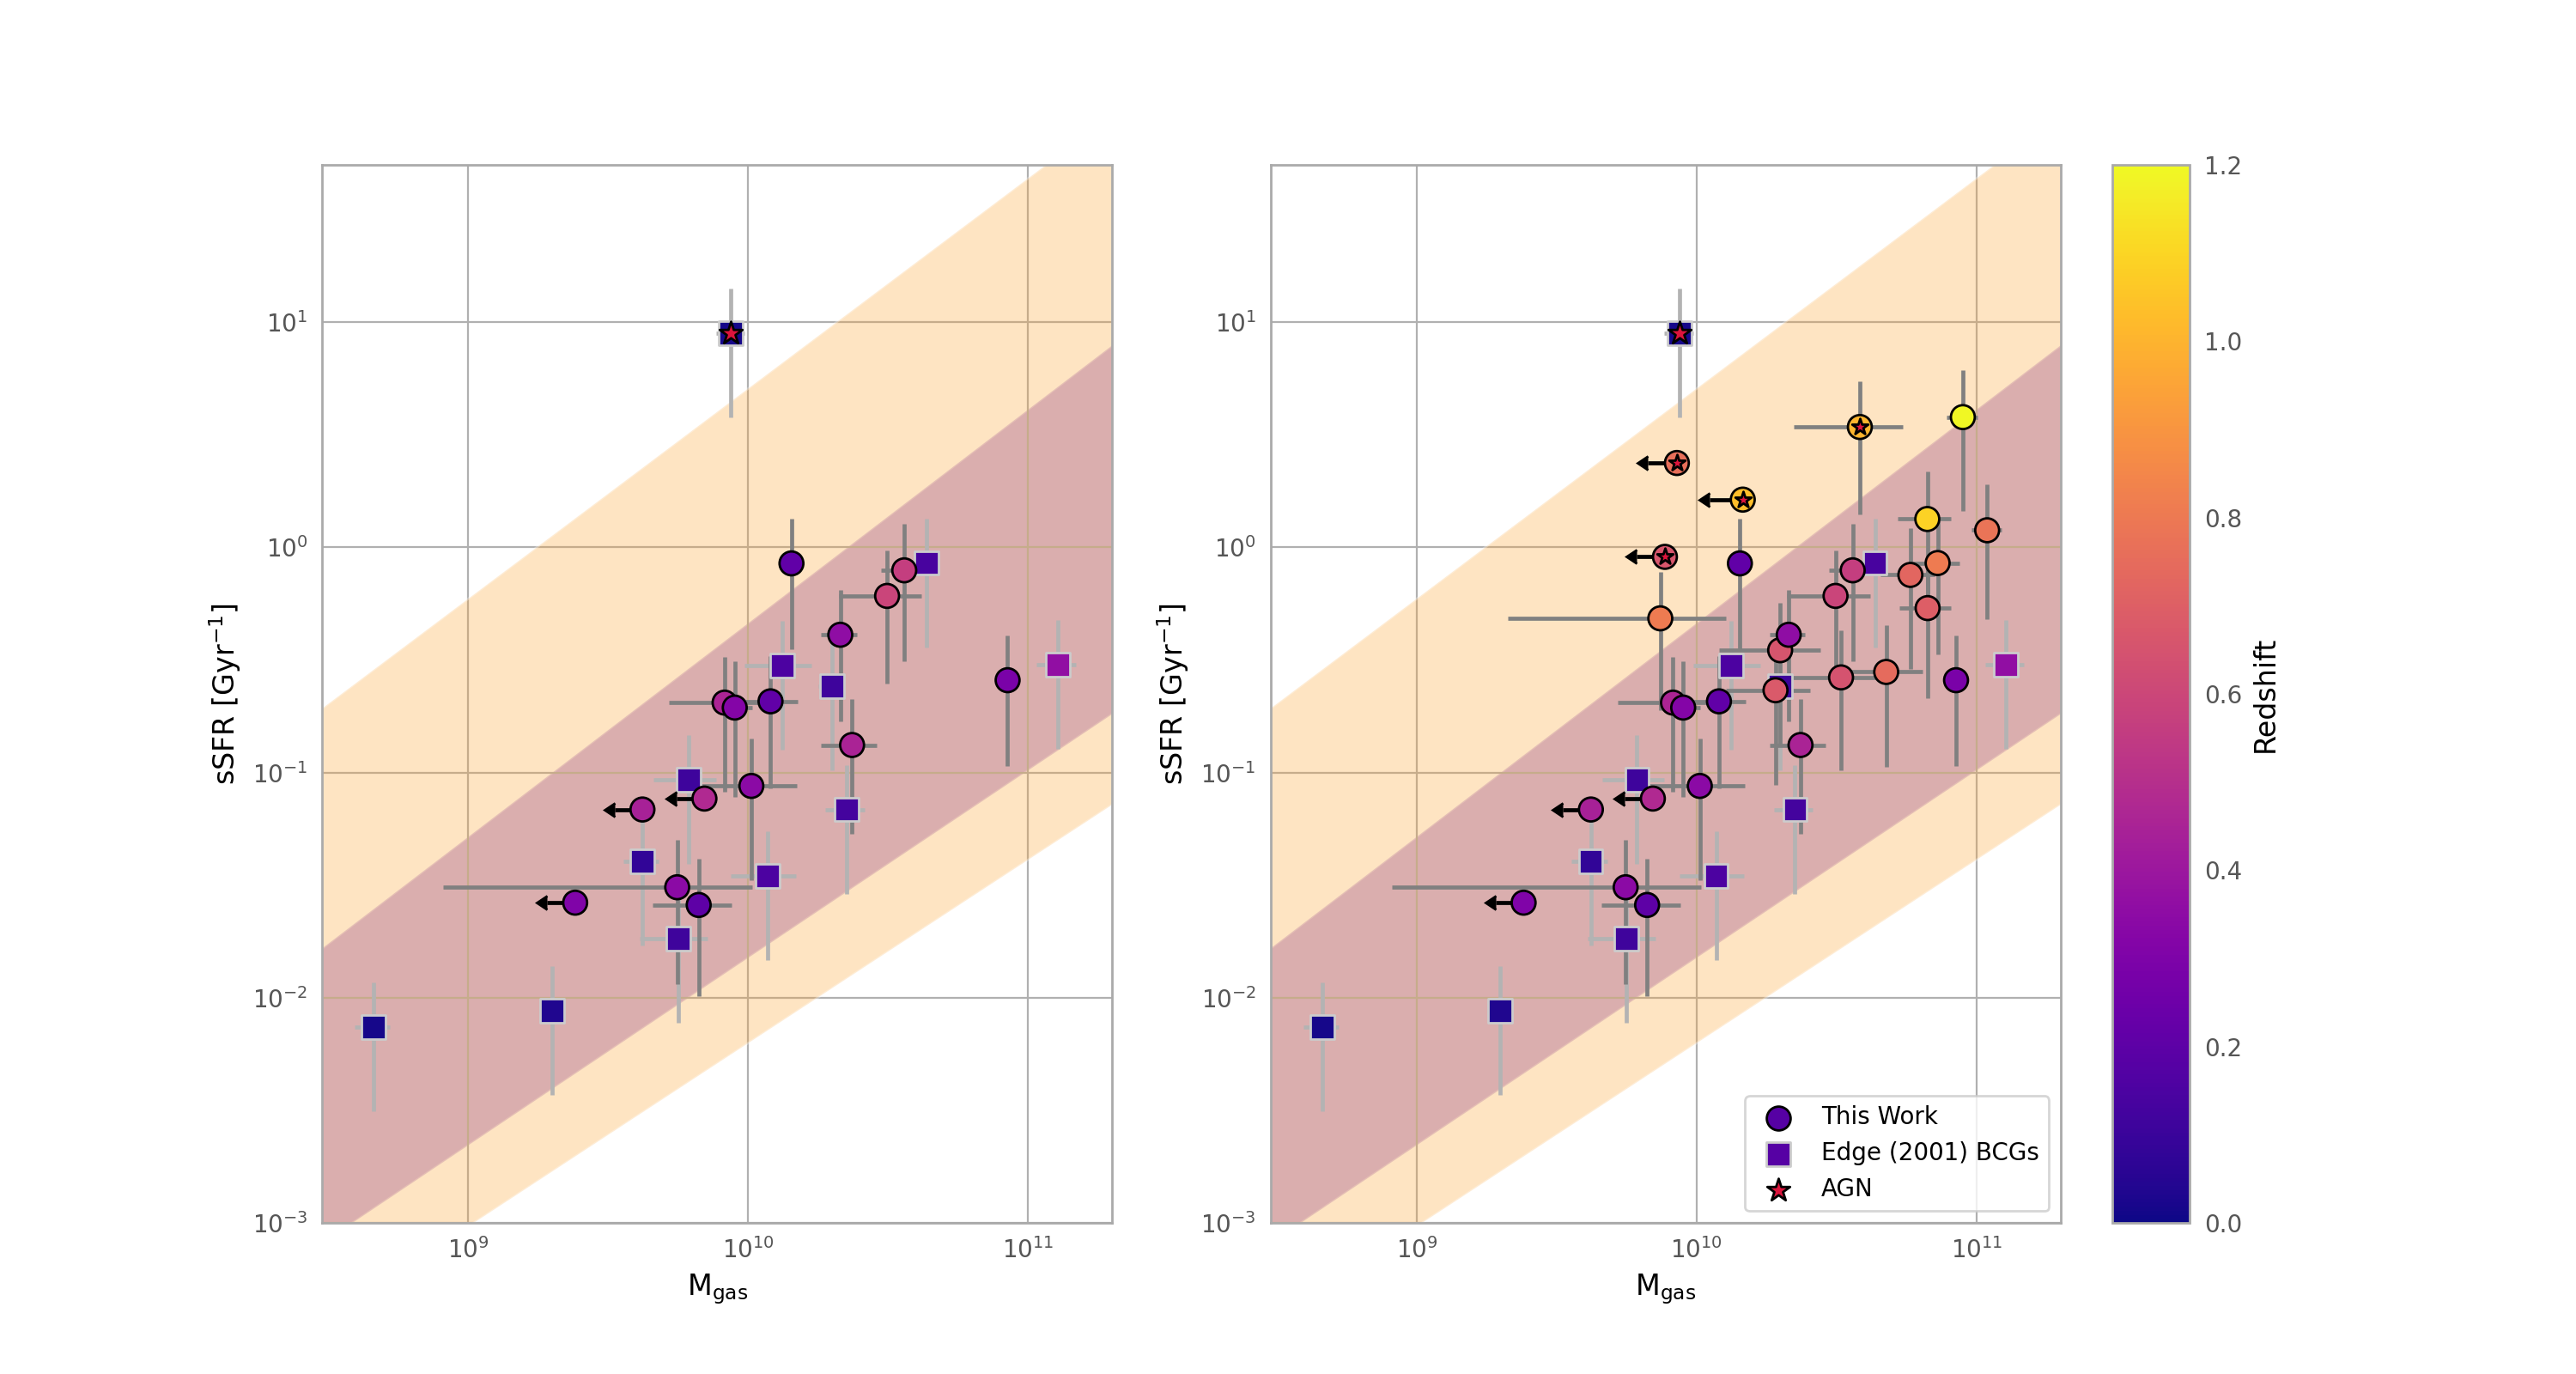

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

(300000000.0, 200000000000.0)

In [160]:
%matplotlib notebook
from matplotlib.patches import Polygon, Rectangle
fig, ax = plt.subplots(1, 2, figsize=(15, 8)) 

osampcut = osamp.query('z < 0.6')

im = ax[0].scatter(osampcut.mgas, osampcut.ssfr, c=osampcut.z, cmap='plasma', vmin=0., vmax=1.2, s=100, zorder=10, 
                   ec='k')#, label='This Work')
# ax[0].scatter(osampcut.mgas.iloc[0], osampcut.ssfr.iloc[0], c=plas(0.5), marker='*', zorder=20, s=75)
ax[0].scatter(1e-4, 1e-4, c=plas(0.15), ec='k', s=100, label='This Work')
ax[0].errorbar(osampcut.mgas, osampcut.ssfr, yerr=osampcut.dssfr, xerr=osampcut.dmgas, color='0.5', fmt='none', zorder=3)


ax[0].scatter(esamp.mgas, esamp.ssfr, c=esamp.z, cmap='plasma', vmin=0., vmax=1.2,
           marker='s', s=100, zorder=5, ec='0.8')#, label='Edge (2001) BCGs')
ax[0].scatter(1e-4, 1e-4, c=plas(0.15), marker='s', s=100, ec='0.8', label='Edge (2001) BCGs')
ax[0].scatter(esamp.mgas.iloc[-1], esamp.ssfr.iloc[-1], c='crimson', marker='*', zorder=5, s=100, ec='k',
           label='AGN')
ax[0].errorbar(esamp.mgas, esamp.ssfr, yerr=esamp.dssfr, xerr=esamp.dmgas, color='0.7', 
            fmt='none', zorder=2)

# our limits
limitnagnidx = np.array([2,4,5])
ax[0].scatter(comasslims[limitnagnidx], ssfrlimsce[limitnagnidx], cmap='plasma', ec='k',
           label='Nondetections (This Work)', c=zlimits[limitnagnidx], vmin=0., vmax=1.2, zorder=19, s=100)
ax[0].errorbar(comasslims[limitnagnidx], ssfrlimsce[limitnagnidx],
            xerr=(1-10**-0.1)*mgaslimits[limitnagnidx], xuplims=True, fmt='none', color='k', zorder=18)



ax[0].set_xlabel(r'$\mathrm{M}_\mathrm{gas}$')
ax[0].set_ylabel(r'$\mathrm{sSFR} \ [\mathrm{Gyr}^{-1}]$')
ax[0].set_xscale('log')
ax[0].set_yscale('log')

cmgas = np.concatenate((osampcut.mgas, esamp.mgas.iloc[:-1]))
csfr = np.concatenate((osampcut.ssfr, esamp.ssfr.iloc[:-1]))

cdmgas = np.concatenate((osampcut.dmgas, esamp.dmgas.iloc[:-1]))
cdsfr = np.concatenate((osampcut.dssfr, esamp.dssfr.iloc[:-1]))

xvals = np.linspace(1e-4, np.max(csfr)+1e4, num=500)
coutput = odr_fit(csfr, cmgas, cdsfr, cdmgas, [0.5,10])
ooutput = odr_fit(osampcut.ssfr, osampcut.mgas, osampcut.dssfr, osampcut.dmgas, [0.5,10])
eoutput = odr_fit(esamp.ssfr.iloc[:-1], esamp.mgas.iloc[:-1], esamp.dssfr.iloc[:-1], esamp.dmgas.iloc[:-1], [0.5,10])


oyvals = np.power(10, odrstraightline(ooutput.beta, np.log10(xvals)))
eyvals = np.power(10, odrstraightline(eoutput.beta, np.log10(xvals)))
oyvalsmin = np.power(10, odrstraightline(ooutput.beta - ooutput.sd_beta, np.log10(xvals)))
oyvalsmax = np.power(10, odrstraightline(ooutput.beta + ooutput.sd_beta, np.log10(xvals)))
eyvalsmin = np.power(10, odrstraightline(eoutput.beta - eoutput.sd_beta, np.log10(xvals)))
eyvalsmax = np.power(10, odrstraightline(eoutput.beta + eoutput.sd_beta, np.log10(xvals)))

xuncerts = np.array([np.min(xvals), np.min(xvals), np.max(xvals), np.max(xvals)])
oyuncerts = np.array([np.min(oyvalsmin), np.min(oyvalsmax), np.max(oyvalsmin), np.max(oyvalsmax)])
eyuncerts = np.array([np.min(eyvalsmin), np.min(eyvalsmax), np.max(eyvalsmin), np.max(eyvalsmax)])
oxy = np.stack((oyuncerts.flatten(), xuncerts), axis=1)
exy = np.stack((eyuncerts.flatten(), xuncerts), axis=1)



ofituncert = Polygon(oxy, alpha=0.3, color=plas(0.8), ec='white', zorder=1)
efituncert = Polygon(exy, alpha=0.3, color=plas(0.15), ec='white', zorder=0)
ax[0].add_patch(ofituncert)
ax[0].add_patch(efituncert)
ofituncert1 = Polygon(oxy, alpha=0.3, color=plas(0.8), ec='white', zorder=1)
efituncert1 = Polygon(exy, alpha=0.3, color=plas(0.15), ec='white', zorder=0)
ax[1].add_patch(ofituncert1)
ax[1].add_patch(efituncert1)


ssfrdetlimz045 = ssfrdetlim[np.max(np.where(detlimz < 0.45)[0])]
ssfrdetlimz07 = ssfrdetlim[np.max(np.where(detlimz < 0.7)[0])]
ssfrdetlimz095 = ssfrdetlim[np.max(np.where(detlimz < 0.95)[0])]
ssfrdetlimz12 = ssfrdetlim[np.max(np.where(detlimz < 1.2)[0])]

ssfrmeandetlimz045 = ssfrmeandetlim[np.max(np.where(detlimz < 0.45)[0])]
ssfrmeandetlimz07 = ssfrmeandetlim[np.max(np.where(detlimz < 0.7)[0])]
ssfrmeandetlimz095 = ssfrmeandetlim[np.max(np.where(detlimz < 0.95)[0])]
ssfrmeandetlimz12 = ssfrmeandetlim[np.max(np.where(detlimz < 1.2)[0])]

mgasrange = np.linspace(1e8, 1e12, num=50)


im = ax[1].scatter(osamp.mgas, osamp.ssfr, c=osamp.z, cmap='plasma', vmin=0., vmax=1.2, s=100, zorder=10, ec='k')#, label='This Work')
ax[1].scatter(osamp.mgas.iloc[0], osamp.ssfr.iloc[0], c='crimson', marker='*', zorder=20, s=50, ec='k')
ax[1].scatter(1e-4, 1e-4, c=plas(0.15), ec='k', s=100, label='This Work')
ax[1].errorbar(osamp.mgas, osamp.ssfr, yerr=osamp.dssfr, xerr=osamp.dmgas, color='0.5', fmt='none', zorder=3)


ax[1].scatter(esamp.mgas, esamp.ssfr, c=esamp.z, cmap='plasma', vmin=0., vmax=1.2,
           marker='s', s=100, zorder=5, ec='0.8')#, label='Edge (2001) BCGs')
ax[1].scatter(1e-4, 1e-4, c=plas(0.15), marker='s', s=100, ec='0.8', label='Edge (2001) BCGs')
ax[1].scatter(esamp.mgas.iloc[-1], esamp.ssfr.iloc[-1], c='crimson', marker='*', zorder=5, s=100, ec='k',
           label='AGN')
ax[1].errorbar(esamp.mgas, esamp.ssfr, yerr=esamp.dssfr, xerr=esamp.dmgas, color='0.7', 
            fmt='none', zorder=2)

# our limits
ax[1].scatter(comasslims, ssfrlimsce, zorder=19, s=100,
              c=zlimits, vmin=0., vmax=1.2, cmap='plasma', ec='k') #label='Nondetections (This Work)',
ax[1].errorbar(comasslims, ssfrlimsce, xerr=(1-10**-0.1)*mgaslimits, xuplims=True, fmt='none', color='k', zorder=18)
ax[1].scatter(comasslims[limitagnidx], ssfrlimsce[limitagnidx], c='crimson', marker='*', zorder=20, s=50, ec='k')



ax[1].set_xlabel(r'$\mathrm{M}_\mathrm{gas}$')
ax[1].set_ylabel(r'$\mathrm{sSFR} \ [\mathrm{Gyr}^{-1}]$')
ax[1].set_xscale('log')
ax[1].set_yscale('log')

ax[1].legend(loc='lower right')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.11, 0.03, 0.77])
fig.colorbar(im, cax=cbar_ax)

cbar_ax.set_ylabel('Redshift')


ax[0].set_ylim((1e-3, 5e1))
ax[0].set_xlim((3e8, 2e11))
ax[1].set_ylim((1e-3, 5e1))
ax[1].set_xlim((3e8, 2e11))

In [ ]:
%matplotlib notebook
from matplotlib.patches import Polygon, Rectangle
fig, ax = plt.subplots(1, 2, figsize=(15, 8)) 

osampcut = osamp.query('z < 0.6')

im = ax[0].scatter(osampcut.mgas, osampcut.ssfr, c=osampcut.z, cmap='plasma', vmin=0., vmax=1.2, s=100, zorder=10, 
                   ec='k')#, label='This Work')
# ax[0].scatter(osampcut.mgas.iloc[0], osampcut.ssfr.iloc[0], c=plas(0.5), marker='*', zorder=20, s=75)
ax[0].scatter(1e-4, 1e-4, c=plas(0.15), ec='k', s=100, label='This Work')
ax[0].errorbar(osampcut.mgas, osampcut.ssfr, yerr=osampcut.dssfr, xerr=osampcut.dmgas, color='0.5', fmt='none', zorder=3)


ax[0].scatter(esamp.mgas, esamp.ssfr, c=esamp.z, cmap='plasma', vmin=0., vmax=1.2,
           marker='s', s=100, zorder=5, ec='0.8')#, label='Edge (2001) BCGs')
ax[0].scatter(1e-4, 1e-4, c=plas(0.15), marker='s', s=100, ec='0.8', label='Edge (2001) BCGs')
ax[0].scatter(esamp.mgas.iloc[-1], esamp.ssfr.iloc[-1], c='crimson', marker='*', zorder=5, s=100, ec='k',
           label='AGN')
ax[0].errorbar(esamp.mgas, esamp.ssfr, yerr=esamp.dssfr, xerr=esamp.dmgas, color='0.7', 
            fmt='none', zorder=2)

# our limits
limitnagnidx = np.array([2,4,5])
ax[0].scatter(comasslims[limitnagnidx], ssfrlimsce[limitnagnidx], cmap='plasma', ec='k',
           label='Nondetections (This Work)', c=zlimits[limitnagnidx], vmin=0., vmax=1.2, zorder=19, s=100)
ax[0].errorbar(comasslims[limitnagnidx], ssfrlimsce[limitnagnidx],
            xerr=(1-10**-0.1)*mgaslimits[limitnagnidx], xuplims=True, fmt='none', color='k', zorder=18)



ax[0].set_xlabel(r'$\mathrm{M}_\mathrm{gas}$')
ax[0].set_ylabel(r'$\mathrm{sSFR} \ [\mathrm{Gyr}^{-1}]$')
ax[0].set_xscale('log')
ax[0].set_yscale('log')

cmgas = np.concatenate((osampcut.mgas, esamp.mgas.iloc[:-1]))
csfr = np.concatenate((osampcut.ssfr, esamp.ssfr.iloc[:-1]))

cdmgas = np.concatenate((osampcut.dmgas, esamp.dmgas.iloc[:-1]))
cdsfr = np.concatenate((osampcut.dssfr, esamp.dssfr.iloc[:-1]))

xvals = np.linspace(1e8, 1e12, num=500)
coutput = odr_fit(cmgas, csfr, cdmgas, cdsfr, [0.5, -10])
ooutput = odr_fit(osampcut.mgas, osampcut.ssfr, osampcut.dmgas, osampcut.dssfr, [0.5, -10])
eoutput = odr_fit(esamp.mgas.iloc[:-1], esamp.ssfr.iloc[:-1], esamp.dmgas.iloc[:-1], esamp.dssfr.iloc[:-1], 
                  [0.5, -10])


oyvals = np.power(10, odrstraightline(ooutput.beta, np.log10(xvals)))
eyvals = np.power(10, odrstraightline(eoutput.beta, np.log10(xvals)))
oyvalsmin = np.power(10, odrstraightline(ooutput.beta - ooutput.sd_beta*np.array([1,-1]), np.log10(xvals)))
oyvalsmax = np.power(10, odrstraightline(ooutput.beta + ooutput.sd_beta*np.array([1,-1]), np.log10(xvals)))
eyvalsmin = np.power(10, odrstraightline(eoutput.beta - eoutput.sd_beta*np.array([1,-1]), np.log10(xvals)))
eyvalsmax = np.power(10, odrstraightline(eoutput.beta + eoutput.sd_beta*np.array([1,-1]), np.log10(xvals)))

xuncerts = np.array([np.min(xvals), np.min(xvals), np.max(xvals), np.max(xvals)])
oyuncerts = np.array([np.min(oyvalsmin), np.min(oyvalsmax), np.max(oyvalsmin), np.max(oyvalsmax)])
eyuncerts = np.array([np.min(eyvalsmin), np.min(eyvalsmax), np.max(eyvalsmin), np.max(eyvalsmax)])
oxy = np.stack((xuncerts, oyuncerts.flatten()), axis=1)
exy = np.stack((xuncerts, eyuncerts.flatten()), axis=1)



ofituncert = Polygon(oxy, alpha=0.3, color=plas(0.8), ec='white', zorder=1)
efituncert = Polygon(exy, alpha=0.3, color=plas(0.15), ec='white', zorder=0)
ax[0].add_patch(ofituncert)
ax[0].add_patch(efituncert)
ofituncert1 = Polygon(oxy, alpha=0.3, color=plas(0.8), ec='white', zorder=1)
efituncert1 = Polygon(exy, alpha=0.3, color=plas(0.15), ec='white', zorder=0)
ax[1].add_patch(ofituncert1)
ax[1].add_patch(efituncert1)


ssfrdetlimz045 = ssfrdetlim[np.max(np.where(detlimz < 0.45)[0])]
ssfrdetlimz07 = ssfrdetlim[np.max(np.where(detlimz < 0.7)[0])]
ssfrdetlimz095 = ssfrdetlim[np.max(np.where(detlimz < 0.95)[0])]
ssfrdetlimz12 = ssfrdetlim[np.max(np.where(detlimz < 1.2)[0])]

ssfrmeandetlimz045 = ssfrmeandetlim[np.max(np.where(detlimz < 0.45)[0])]
ssfrmeandetlimz07 = ssfrmeandetlim[np.max(np.where(detlimz < 0.7)[0])]
ssfrmeandetlimz095 = ssfrmeandetlim[np.max(np.where(detlimz < 0.95)[0])]
ssfrmeandetlimz12 = ssfrmeandetlim[np.max(np.where(detlimz < 1.2)[0])]

mgasrange = np.linspace(1e8, 1e12, num=50)


im = ax[1].scatter(osamp.mgas, osamp.ssfr, c=osamp.z, cmap='plasma', vmin=0., vmax=1.2, s=100, zorder=10, ec='k')#, label='This Work')
ax[1].scatter(osamp.mgas.iloc[0], osamp.ssfr.iloc[0], c='crimson', marker='*', zorder=20, s=50, ec='k')
ax[1].scatter(1e-4, 1e-4, c=plas(0.15), ec='k', s=100, label='This Work')
ax[1].errorbar(osamp.mgas, osamp.ssfr, yerr=osamp.dssfr, xerr=osamp.dmgas, color='0.5', fmt='none', zorder=3)


ax[1].scatter(esamp.mgas, esamp.ssfr, c=esamp.z, cmap='plasma', vmin=0., vmax=1.2,
           marker='s', s=100, zorder=5, ec='0.8')#, label='Edge (2001) BCGs')
ax[1].scatter(1e-4, 1e-4, c=plas(0.15), marker='s', s=100, ec='0.8', label='Edge (2001) BCGs')
ax[1].scatter(esamp.mgas.iloc[-1], esamp.ssfr.iloc[-1], c='crimson', marker='*', zorder=5, s=100, ec='k',
           label='AGN')
ax[1].errorbar(esamp.mgas, esamp.ssfr, yerr=esamp.dssfr, xerr=esamp.dmgas, color='0.7', 
            fmt='none', zorder=2)

# our limits
ax[1].scatter(comasslims, ssfrlimsce, zorder=19, s=100,
              c=zlimits, vmin=0., vmax=1.2, cmap='plasma', ec='k') #label='Nondetections (This Work)',
ax[1].errorbar(comasslims, ssfrlimsce, xerr=(1-10**-0.1)*mgaslimits, xuplims=True, fmt='none', color='k', zorder=18)
ax[1].scatter(comasslims[limitagnidx], ssfrlimsce[limitagnidx], c='crimson', marker='*', zorder=20, s=50, ec='k')



ax[1].set_xlabel(r'$\mathrm{M}_\mathrm{gas}$')
ax[1].set_ylabel(r'$\mathrm{sSFR} \ [\mathrm{Gyr}^{-1}]$')
ax[1].set_xscale('log')
ax[1].set_yscale('log')

ax[1].legend(loc='lower right')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.11, 0.03, 0.77])
fig.colorbar(im, cax=cbar_ax)

cbar_ax.set_ylabel('Redshift')


ax[0].set_ylim((1e-3, 5e1))
ax[0].set_xlim((3e8, 2e11))
ax[1].set_ylim((1e-3, 5e1))
ax[1].set_xlim((3e8, 2e11))

In [ ]:
print(ooutput.beta, ooutput.sd_beta)

In [ ]:
print(eoutput.beta, eoutput.sd_beta)

In [ ]:
csfr = np.concatenate((osampcut.ssfr, esamp.ssfr.iloc[:-1]))
cmgas = np.concatenate((osampcut.mgas, esamp.mgas.iloc[:-1]))

cdsfr = np.concatenate((osampcut.dssfr, esamp.dssfr.iloc[:-1]))
cdmgas = np.concatenate((osampcut.dmgas, esamp.dmgas.iloc[:-1]))

xvals = np.linspace(1e-4, np.max(csfr)+1e4, num=500)
coutput = odr_fit(csfr, cmgas, cdsfr, cdmgas, [0.5, 10])
ooutput = odr_fit(osampcut.ssfr, osampcut.mgas, osampcut.dssfr, osampcut.dmgas, [0.5, 0.01])
eoutput = odr_fit(esamp.ssfr.iloc[:-1], esamp.mgas.iloc[:-1], esamp.dssfr.iloc[:-1], esamp.dmgas.iloc[:-1], [0.5,10])

oyvals = np.power(10, odrstraightline(ooutput.beta, np.log10(xvals)))
eyvals = np.power(10, odrstraightline(eoutput.beta, np.log10(xvals)))
oyvalsmin = np.power(10, odrstraightline(ooutput.beta - ooutput.sd_beta, np.log10(xvals)))
oyvalsmax = np.power(10, odrstraightline(ooutput.beta + ooutput.sd_beta, np.log10(xvals)))
eyvalsmin = np.power(10, odrstraightline(eoutput.beta - eoutput.sd_beta, np.log10(xvals)))
eyvalsmax = np.power(10, odrstraightline(eoutput.beta + eoutput.sd_beta, np.log10(xvals)))

xuncerts = np.array([np.min(xvals), np.min(xvals), np.max(xvals), np.max(xvals)])
oyuncerts = np.array([np.min(oyvalsmin), np.min(oyvalsmax), np.max(oyvalsmin), np.max(oyvalsmax)])
eyuncerts = np.array([np.min(eyvalsmin), np.min(eyvalsmax), np.max(eyvalsmin), np.max(eyvalsmax)])
oxy = np.stack((oyuncerts.flatten(), xuncerts), axis=1)
exy = np.stack((eyuncerts.flatten(), xuncerts), axis=1)



ofituncert = Polygon(oxy, alpha=0.3, color=plas(0.8), ec='white', zorder=1)
efituncert = Polygon(exy, alpha=0.3, color=plas(0.15), ec='white', zorder=0)
ax[0].add_patch(ofituncert)
ax[0].add_patch(efituncert)

In [ ]:
egals[eggoodidx]

In [ ]:
%matplotlib notebook
from matplotlib.patches import Polygon, Rectangle
fig, ax = plt.subplots(1, figsize=(8, 6))

limmax = np.max(comasslims)

osampcut = osamp.query('mgas >= '+str(limmax))
# esampcut = esamp.query('mgas >= ' + str(limmax))

im = ax.scatter(osampcut.mgas, osampcut.ssfr, c=osampcut.z, cmap='plasma', vmin=0., vmax=1.2, s=100, zorder=10, ec='k')#, label='This Work')
ax.scatter(osampcut.mgas.iloc[0], osampcut.ssfr.iloc[0], c=plas(0.5), marker='*', zorder=20, s=75)
ax.scatter(1e-4, 1e-4, c=plas(0.15), ec='k', s=100, label='This Work')
ax.errorbar(osampcut.mgas, osampcut.ssfr, yerr=osampcut.dssfr, xerr=osampcut.dmgas, color='0.5', fmt='none', zorder=3)


ax.scatter(esamp.mgas, esamp.ssfr, c=esamp.z, cmap='plasma', vmin=0., vmax=1.2,
           marker='s', s=100, zorder=5, ec='0.8')#, label='Edge (2001) BCGs')
ax.scatter(1e-4, 1e-4, c=plas(0.15), marker='s', s=100, ec='0.8', label='Edge (2001) BCGs')
ax.scatter(esamp.mgas.iloc[-1], esamp.ssfr.iloc[-1], c=plas(0.5), marker='*', zorder=5, s=75, 
           label='AGN')
ax.errorbar(esamp.mgas, esamp.ssfr, yerr=esamp.dssfr, xerr=esamp.dmgas, color='0.7', 
            fmt='none', zorder=2)

# our limits
# ax.scatter(comasslims, ssfrlimsce, marker='|', color='k', label='Nondetections (This Work)', zorder=18, lw=2, s=75)
# ax.errorbar(comasslims, ssfrlimsce, xerr=(1-10**-0.1)*mgaslimits, xuplims=True, fmt='none', color='k', zorder=18)



ax.set_xlabel(r'$\mathrm{M}_\mathrm{gas}$')
ax.set_ylabel(r'$\mathrm{sSFR} \ [\mathrm{Gyr}^{-1}]$')
ax.set_xscale('log')
ax.set_yscale('log')


csfr = np.concatenate((osampcut.ssfr.iloc[1:], esamp.ssfr.iloc[:-1]))
cmgas = np.concatenate((osampcut.mgas.iloc[1:], esamp.mgas.iloc[:-1]))

cdsfr = np.concatenate((osampcut.dssfr.iloc[1:], esamp.dssfr.iloc[:-1]))
cdmgas = np.concatenate((osampcut.dmgas.iloc[1:], esamp.dmgas.iloc[:-1]))

xvals = np.linspace(1e-4, np.max(csfr)+1e4, num=500)
coutput = odr_fit(csfr, cmgas, cdsfr, cdmgas, [0.5, 10])
ooutput = odr_fit(osampcut.ssfr.iloc[1:], osampcut.mgas.iloc[1:], osampcut.dssfr.iloc[1:], osampcut.dmgas.iloc[1:], [0.5, 0.01])
eoutput = odr_fit(esamp.ssfr.iloc[:-1], esamp.mgas.iloc[:-1], esamp.dssfr.iloc[:-1], esamp.dmgas.iloc[:-1], [0.5,10])

oyvals = np.power(10, odrstraightline(ooutput.beta, np.log10(xvals)))
eyvals = np.power(10, odrstraightline(eoutput.beta, np.log10(xvals)))
oyvalsmin = np.power(10, odrstraightline(ooutput.beta - ooutput.sd_beta, np.log10(xvals)))
oyvalsmax = np.power(10, odrstraightline(ooutput.beta + ooutput.sd_beta, np.log10(xvals)))
eyvalsmin = np.power(10, odrstraightline(eoutput.beta - eoutput.sd_beta, np.log10(xvals)))
eyvalsmax = np.power(10, odrstraightline(eoutput.beta + eoutput.sd_beta, np.log10(xvals)))

xuncerts = np.array([np.min(xvals), np.min(xvals), np.max(xvals), np.max(xvals)])
oyuncerts = np.array([np.min(oyvalsmin), np.min(oyvalsmax), np.max(oyvalsmin), np.max(oyvalsmax)])
eyuncerts = np.array([np.min(eyvalsmin), np.min(eyvalsmax), np.max(eyvalsmin), np.max(eyvalsmax)])
oxy = np.stack((oyuncerts.flatten(), xuncerts), axis=1)
exy = np.stack((eyuncerts.flatten(), xuncerts), axis=1)



ofituncert = Polygon(oxy, alpha=0.3, color=plas(0.8), ec='white', zorder=1)
efituncert = Polygon(exy, alpha=0.3, color=plas(0.15), ec='white', zorder=0)
ax.add_patch(ofituncert)
ax.add_patch(efituncert)

cbar = fig.colorbar(im)
cbar.ax.set_ylabel('Redshift')

ax.legend(loc='upper left')

ssfrdetlimz045 = ssfrdetlim[np.max(np.where(detlimz < 0.45)[0])]
ssfrdetlimz07 = ssfrdetlim[np.max(np.where(detlimz < 0.7)[0])]
ssfrdetlimz095 = ssfrdetlim[np.max(np.where(detlimz < 0.95)[0])]
ssfrdetlimz12 = ssfrdetlim[np.max(np.where(detlimz < 1.2)[0])]

ssfrmeandetlimz045 = ssfrmeandetlim[np.max(np.where(detlimz < 0.45)[0])]
ssfrmeandetlimz07 = ssfrmeandetlim[np.max(np.where(detlimz < 0.7)[0])]
ssfrmeandetlimz095 = ssfrmeandetlim[np.max(np.where(detlimz < 0.95)[0])]
ssfrmeandetlimz12 = ssfrmeandetlim[np.max(np.where(detlimz < 1.2)[0])]

mgasrange = np.linspace(1e8, 1e12, num=50)
ax.plot(mgasrange, np.ones(50)*ssfrdetlimz045, color=plas(0.45/1.2))
ax.plot(mgasrange, np.ones(50)*ssfrdetlimz07, color=plas(0.7/1.2))
ax.plot(mgasrange, np.ones(50)*ssfrdetlimz095, color=plas(0.95/1.2))
ax.plot(mgasrange, np.ones(50)*ssfrdetlimz12, color=plas(1.2/1.2))

ax.plot(mgasrange, np.ones(50)*ssfrmeandetlimz045, color=plas(0.45/1.2), ls='--')
ax.plot(mgasrange, np.ones(50)*ssfrmeandetlimz07, color=plas(0.7/1.2), ls='--')
ax.plot(mgasrange, np.ones(50)*ssfrmeandetlimz095, color=plas(0.95/1.2), ls='--')
ax.plot(mgasrange, np.ones(50)*ssfrmeandetlimz12, color=plas(1.2/1.2), ls='--')

ax.set_ylim((1e-3, 5e1))
ax.set_xlim((3e8, 2e11))

ax.set_title('Cut to Mgas < max(Mgas upper limit)')

In [ ]:
print(ooutput.beta, ooutput.sd_beta)

In [ ]:
print(eoutput.beta, eoutput.sd_beta)

In [ ]:
%matplotlib notebook
from matplotlib.patches import Polygon, Rectangle
fig, ax = plt.subplots(1, figsize=(8, 6))

limmax = np.max(comasslims)

osampcut = osamp.query('mgas >= '+str(detlimmeans[3]))
# esampcut = esamp.query('mgas >= ' + str(limmax))

im = ax.scatter(osampcut.mgas, osampcut.ssfr, c=osampcut.z, cmap='plasma', vmin=0., vmax=1.2, s=100, zorder=10, ec='k')#, label='This Work')
ax.scatter(osampcut.mgas.iloc[0], osampcut.ssfr.iloc[0], c=plas(0.5), marker='*', zorder=20, s=75)
ax.scatter(1e-4, 1e-4, c=plas(0.15), ec='k', s=100, label='This Work')
ax.errorbar(osampcut.mgas, osampcut.ssfr, yerr=osampcut.dssfr, xerr=osampcut.dmgas, color='0.5', fmt='none', zorder=3)


ax.scatter(esamp.mgas, esamp.ssfr, c=esamp.z, cmap='plasma', vmin=0., vmax=1.2,
           marker='s', s=100, zorder=5, ec='0.8')#, label='Edge (2001) BCGs')
ax.scatter(1e-4, 1e-4, c=plas(0.15), marker='s', s=100, ec='0.8', label='Edge (2001) BCGs')
ax.scatter(esamp.mgas.iloc[-1], esamp.ssfr.iloc[-1], c=plas(0.5), marker='*', zorder=5, s=75, 
           label='AGN')
ax.errorbar(esamp.mgas, esamp.ssfr, yerr=esamp.dssfr, xerr=esamp.dmgas, color='0.7', 
            fmt='none', zorder=2)

# our limits
# ax.scatter(comasslims, ssfrlimsce, marker='|', color='k', label='Nondetections (This Work)', zorder=18, lw=2, s=75)
# ax.errorbar(comasslims, ssfrlimsce, xerr=(1-10**-0.1)*mgaslimits, xuplims=True, fmt='none', color='k', zorder=18)



ax.set_xlabel(r'$\mathrm{M}_\mathrm{gas}$')
ax.set_ylabel(r'$\mathrm{sSFR} \ [\mathrm{Gyr}^{-1}]$')
ax.set_xscale('log')
ax.set_yscale('log')


csfr = np.concatenate((osampcut.ssfr.iloc[1:], esamp.ssfr.iloc[:-1]))
cmgas = np.concatenate((osampcut.mgas.iloc[1:], esamp.mgas.iloc[:-1]))

cdsfr = np.concatenate((osampcut.dssfr.iloc[1:], esamp.dssfr.iloc[:-1]))
cdmgas = np.concatenate((osampcut.dmgas.iloc[1:], esamp.dmgas.iloc[:-1]))

xvals = np.linspace(1e-4, np.max(csfr)+1e4, num=500)
coutput = odr_fit(csfr, cmgas, cdsfr, cdmgas, [0.5, 10])
ooutput = odr_fit(osampcut.ssfr.iloc[1:], osampcut.mgas.iloc[1:], osampcut.dssfr.iloc[1:], osampcut.dmgas.iloc[1:], [0.5, 0.01])
eoutput = odr_fit(esamp.ssfr.iloc[:-1], esamp.mgas.iloc[:-1], esamp.dssfr.iloc[:-1], esamp.dmgas.iloc[:-1], [0.5,10])

oyvals = np.power(10, odrstraightline(ooutput.beta, np.log10(xvals)))
eyvals = np.power(10, odrstraightline(eoutput.beta, np.log10(xvals)))
oyvalsmin = np.power(10, odrstraightline(ooutput.beta - ooutput.sd_beta, np.log10(xvals)))
oyvalsmax = np.power(10, odrstraightline(ooutput.beta + ooutput.sd_beta, np.log10(xvals)))
eyvalsmin = np.power(10, odrstraightline(eoutput.beta - eoutput.sd_beta, np.log10(xvals)))
eyvalsmax = np.power(10, odrstraightline(eoutput.beta + eoutput.sd_beta, np.log10(xvals)))

xuncerts = np.array([np.min(xvals), np.min(xvals), np.max(xvals), np.max(xvals)])
oyuncerts = np.array([np.min(oyvalsmin), np.min(oyvalsmax), np.max(oyvalsmin), np.max(oyvalsmax)])
eyuncerts = np.array([np.min(eyvalsmin), np.min(eyvalsmax), np.max(eyvalsmin), np.max(eyvalsmax)])
oxy = np.stack((oyuncerts.flatten(), xuncerts), axis=1)
exy = np.stack((eyuncerts.flatten(), xuncerts), axis=1)



ofituncert = Polygon(oxy, alpha=0.3, color=plas(0.8), ec='white', zorder=1)
efituncert = Polygon(exy, alpha=0.3, color=plas(0.15), ec='white', zorder=0)
ax.add_patch(ofituncert)
ax.add_patch(efituncert)

cbar = fig.colorbar(im)
cbar.ax.set_ylabel('Redshift')

ax.legend(loc='upper left')

ssfrdetlimz045 = ssfrdetlim[np.max(np.where(detlimz < 0.45)[0])]
ssfrdetlimz07 = ssfrdetlim[np.max(np.where(detlimz < 0.7)[0])]
ssfrdetlimz095 = ssfrdetlim[np.max(np.where(detlimz < 0.95)[0])]
ssfrdetlimz12 = ssfrdetlim[np.max(np.where(detlimz < 1.2)[0])]

ssfrmeandetlimz045 = ssfrmeandetlim[np.max(np.where(detlimz < 0.45)[0])]
ssfrmeandetlimz07 = ssfrmeandetlim[np.max(np.where(detlimz < 0.7)[0])]
ssfrmeandetlimz095 = ssfrmeandetlim[np.max(np.where(detlimz < 0.95)[0])]
ssfrmeandetlimz12 = ssfrmeandetlim[np.max(np.where(detlimz < 1.2)[0])]

mgasrange = np.linspace(1e8, 1e12, num=50)
ax.plot(mgasrange, np.ones(50)*ssfrdetlimz045, color=plas(0.45/1.2))
ax.plot(mgasrange, np.ones(50)*ssfrdetlimz07, color=plas(0.7/1.2))
ax.plot(mgasrange, np.ones(50)*ssfrdetlimz095, color=plas(0.95/1.2))
ax.plot(mgasrange, np.ones(50)*ssfrdetlimz12, color=plas(1.2/1.2))

ax.plot(mgasrange, np.ones(50)*ssfrmeandetlimz045, color=plas(0.45/1.2), ls='--')
ax.plot(mgasrange, np.ones(50)*ssfrmeandetlimz07, color=plas(0.7/1.2), ls='--')
ax.plot(mgasrange, np.ones(50)*ssfrmeandetlimz095, color=plas(0.95/1.2), ls='--')
ax.plot(mgasrange, np.ones(50)*ssfrmeandetlimz12, color=plas(1.2/1.2), ls='--')

ax.set_ylim((1e-3, 5e1))
ax.set_xlim((3e8, 2e11))

ax.set_title('Cut to Mgas < max(Mgas upper limit)')

In [ ]:
print(ooutput.beta, ooutput.sd_beta)

In [ ]:
print(eoutput.beta, eoutput.sd_beta)

In [ ]:
%matplotlib notebook
from matplotlib.patches import Polygon, Rectangle
fig, ax = plt.subplots(1, figsize=(8, 6))


osampcut = osamp.query('ssfr/ssfrms >= ' + str(belowmsfrac) + ' & z < 0.8')
# esampcut = esamp.query('ssfr/ssfrms >= ' + str(belowmsfrac) + ' & z < 0.8')

im = ax.scatter(osampcut.mgas, osampcut.ssfr, c=osampcut.z, cmap='plasma', vmin=0., vmax=1.2, s=100, zorder=10, ec='k')#, label='This Work')
# ax.scatter(osampcut.mgas.iloc[0], osampcut.ssfr.iloc[0], c=plas(0.5), marker='*', zorder=20, s=75)
ax.scatter(1e-4, 1e-4, c=plas(0.15), ec='k', s=100, label='This Work')
ax.errorbar(osampcut.mgas, osampcut.ssfr, yerr=osampcut.dssfr, xerr=osampcut.dmgas, color='0.5', fmt='none', zorder=3)


ax.scatter(esamp.mgas, esamp.ssfr, c=esamp.z, cmap='plasma', vmin=0., vmax=1.2,
           marker='s', s=100, zorder=5, ec='0.8')#, label='Edge (2001) BCGs')
ax.scatter(1e-4, 1e-4, c=plas(0.15), marker='s', s=100, ec='0.8', label='Edge (2001) BCGs')
ax.scatter(esamp.mgas.iloc[-1], esamp.ssfr.iloc[-1], c=plas(0.5), marker='*', zorder=5, s=75, 
           label='AGN')
ax.errorbar(esamp.mgas, esamp.ssfr, yerr=esamp.dssfr, xerr=esamp.dmgas, color='0.7', 
            fmt='none', zorder=2)

# our limits
ax.scatter(comasslims, ssfrlimsce, marker='|', color='k', label='Nondetections (This Work)', zorder=18, lw=2, s=75)
ax.errorbar(comasslims, ssfrlimsce, xerr=(1-10**-0.1)*mgaslimits, xuplims=True, fmt='none', color='k', zorder=18)



ax.set_xlabel(r'$\mathrm{M}_\mathrm{gas}$')
ax.set_ylabel(r'$\mathrm{sSFR} \ [\mathrm{Gyr}^{-1}]$')
ax.set_xscale('log')
ax.set_yscale('log')


csfr = np.concatenate((osampcut.ssfr, esamp.ssfr.iloc[:-1]))
cmgas = np.concatenate((osampcut.mgas, esamp.mgas.iloc[:-1]))

cdsfr = np.concatenate((osampcut.dssfr, esamp.dssfr.iloc[:-1]))
cdmgas = np.concatenate((osampcut.dmgas, esamp.dmgas.iloc[:-1]))

xvals = np.linspace(1e-4, np.max(csfr)+1e4, num=500)
coutput = odr_fit(csfr, cmgas, cdsfr, cdmgas, [0.5, 10])
ooutput = odr_fit(osampcut.ssfr, osampcut.mgas, osampcut.dssfr, osampcut.dmgas, [0.5, 0.01])
eoutput = odr_fit(esamp.ssfr.iloc[:-1], esamp.mgas.iloc[:-1], esamp.dssfr.iloc[:-1], esamp.dmgas.iloc[:-1], [0.5,10])

oyvals = np.power(10, odrstraightline(ooutput.beta, np.log10(xvals)))
eyvals = np.power(10, odrstraightline(eoutput.beta, np.log10(xvals)))
oyvalsmin = np.power(10, odrstraightline(ooutput.beta - ooutput.sd_beta, np.log10(xvals)))
oyvalsmax = np.power(10, odrstraightline(ooutput.beta + ooutput.sd_beta, np.log10(xvals)))
eyvalsmin = np.power(10, odrstraightline(eoutput.beta - eoutput.sd_beta, np.log10(xvals)))
eyvalsmax = np.power(10, odrstraightline(eoutput.beta + eoutput.sd_beta, np.log10(xvals)))

xuncerts = np.array([np.min(xvals), np.min(xvals), np.max(xvals), np.max(xvals)])
oyuncerts = np.array([np.min(oyvalsmin), np.min(oyvalsmax), np.max(oyvalsmin), np.max(oyvalsmax)])
eyuncerts = np.array([np.min(eyvalsmin), np.min(eyvalsmax), np.max(eyvalsmin), np.max(eyvalsmax)])
oxy = np.stack((oyuncerts.flatten(), xuncerts), axis=1)
exy = np.stack((eyuncerts.flatten(), xuncerts), axis=1)



ofituncert = Polygon(oxy, alpha=0.3, color=plas(0.8), ec='white', zorder=1)
efituncert = Polygon(exy, alpha=0.3, color=plas(0.15), ec='white', zorder=0)
ax.add_patch(ofituncert)
ax.add_patch(efituncert)

cbar = fig.colorbar(im)
cbar.ax.set_ylabel('Redshift')

ax.legend(loc='upper left')

# ssfrdetlimz045 = ssfrdetlim[np.max(np.where(detlimz < 0.45)[0])]
# ssfrdetlimz07 = ssfrdetlim[np.max(np.where(detlimz < 0.7)[0])]
# ssfrdetlimz095 = ssfrdetlim[np.max(np.where(detlimz < 0.95)[0])]
# ssfrdetlimz12 = ssfrdetlim[np.max(np.where(detlimz < 1.2)[0])]

# ssfrmeandetlimz045 = ssfrmeandetlim[np.max(np.where(detlimz < 0.45)[0])]
# ssfrmeandetlimz07 = ssfrmeandetlim[np.max(np.where(detlimz < 0.7)[0])]
# ssfrmeandetlimz095 = ssfrmeandetlim[np.max(np.where(detlimz < 0.95)[0])]
# ssfrmeandetlimz12 = ssfrmeandetlim[np.max(np.where(detlimz < 1.2)[0])]

# mgasrange = np.linspace(1e8, 1e12, num=50)
# ax.plot(mgasrange, np.ones(50)*ssfrdetlimz045, color=plas(0.45/1.2))
# ax.plot(mgasrange, np.ones(50)*ssfrdetlimz07, color=plas(0.7/1.2))
# ax.plot(mgasrange, np.ones(50)*ssfrdetlimz095, color=plas(0.95/1.2))
# ax.plot(mgasrange, np.ones(50)*ssfrdetlimz12, color=plas(1.2/1.2))

# ax.plot(mgasrange, np.ones(50)*ssfrmeandetlimz045, color=plas(0.45/1.2), ls='--')
# ax.plot(mgasrange, np.ones(50)*ssfrmeandetlimz07, color=plas(0.7/1.2), ls='--')
# ax.plot(mgasrange, np.ones(50)*ssfrmeandetlimz095, color=plas(0.95/1.2), ls='--')
# ax.plot(mgasrange, np.ones(50)*ssfrmeandetlimz12, color=plas(1.2/1.2), ls='--')

ax.set_ylim((1e-3, 5e1))
ax.set_xlim((3e8, 2e11))

ax.set_title('Cut to sSFR > 0.74*MS and z < 0.8')

In [ ]:
print(ooutput.beta, ooutput.sd_beta)

In [ ]:
print(eoutput.beta, eoutput.sd_beta)

In [ ]:
%matplotlib notebook
from matplotlib.patches import Polygon, Rectangle
fig, ax = plt.subplots(1, figsize=(8, 6))


osampcut = osamp.query('ssfr/ssfrms >= ' + str(belowmsfrac) + ' & z < 0.8 & mgas > ' +str(detlimmeans[2]))
# esamp = esamp.query('ssfr/ssfrms >= ' + str(belowmsfrac) + ' & z < 0.8 & mgas > ' +str(detlimmeans[2]))

im = ax.scatter(osampcut.mgas, osampcut.ssfr, c=osampcut.z, cmap='plasma', vmin=0., vmax=1.2, s=100, zorder=10, ec='k')#, label='This Work')
ax.scatter(osampcut.mgas.iloc[0], osampcut.ssfr.iloc[0], c=plas(0.5), marker='*', zorder=20, s=75)
ax.scatter(1e-4, 1e-4, c=plas(0.15), ec='k', s=100, label='This Work')
ax.errorbar(osampcut.mgas, osampcut.ssfr, yerr=osampcut.dssfr, xerr=osampcut.dmgas, color='0.5', fmt='none', zorder=3)


ax.scatter(esamp.mgas, esamp.ssfr, c=esamp.z, cmap='plasma', vmin=0., vmax=1.2,
           marker='s', s=100, zorder=5, ec='0.8')#, label='Edge (2001) BCGs')
ax.scatter(1e-4, 1e-4, c=plas(0.15), marker='s', s=100, ec='0.8', label='Edge (2001) BCGs')
ax.scatter(esamp.mgas.iloc[-1], esamp.ssfr.iloc[-1], c=plas(0.5), marker='*', zorder=5, s=75, 
           label='AGN')
ax.errorbar(esamp.mgas, esamp.ssfr, yerr=esamp.dssfr, xerr=esamp.dmgas, color='0.7', 
            fmt='none', zorder=2)

# our limits
# ax.scatter(comasslims, ssfrlimsce, marker='|', color='k', label='Nondetections (This Work)', zorder=18, lw=2, s=75)
# ax.errorbar(comasslims, ssfrlimsce, xerr=(1-10**-0.1)*mgaslimits, xuplims=True, fmt='none', color='k', zorder=18)



ax.set_xlabel(r'$\mathrm{M}_\mathrm{gas}$')
ax.set_ylabel(r'$\mathrm{sSFR} \ [\mathrm{Gyr}^{-1}]$')
ax.set_xscale('log')
ax.set_yscale('log')


csfr = np.concatenate((osampcut.ssfr.iloc[1:], esamp.ssfr.iloc[:-1]))
cmgas = np.concatenate((osampcut.mgas.iloc[1:], esamp.mgas.iloc[:-1]))

cdsfr = np.concatenate((osampcut.dssfr.iloc[1:], esamp.dssfr.iloc[:-1]))
cdmgas = np.concatenate((osampcut.dmgas.iloc[1:], esamp.dmgas.iloc[:-1]))

xvals = np.linspace(1e-4, np.max(csfr)+1e4, num=500)
coutput = odr_fit(csfr, cmgas, cdsfr, cdmgas, [0.5, 10])
ooutput = odr_fit(osampcut.ssfr, osampcut.mgas, osampcut.dssfr, 
                  osampcut.dmgas, [0.5, 0.01])
eoutput = odr_fit(esamp.ssfr, esamp.mgas, esamp.dssfr, esamp.dmgas, [0.5,10])

oyvals = np.power(10, odrstraightline(ooutput.beta, np.log10(xvals)))
eyvals = np.power(10, odrstraightline(eoutput.beta, np.log10(xvals)))
oyvalsmin = np.power(10, odrstraightline(ooutput.beta - ooutput.sd_beta, np.log10(xvals)))
oyvalsmax = np.power(10, odrstraightline(ooutput.beta + ooutput.sd_beta, np.log10(xvals)))
eyvalsmin = np.power(10, odrstraightline(eoutput.beta - eoutput.sd_beta, np.log10(xvals)))
eyvalsmax = np.power(10, odrstraightline(eoutput.beta + eoutput.sd_beta, np.log10(xvals)))

xuncerts = np.array([np.min(xvals), np.min(xvals), np.max(xvals), np.max(xvals)])
oyuncerts = np.array([np.min(oyvalsmin), np.min(oyvalsmax), np.max(oyvalsmin), np.max(oyvalsmax)])
eyuncerts = np.array([np.min(eyvalsmin), np.min(eyvalsmax), np.max(eyvalsmin), np.max(eyvalsmax)])
oxy = np.stack((oyuncerts.flatten(), xuncerts), axis=1)
exy = np.stack((eyuncerts.flatten(), xuncerts), axis=1)

cyvals = np.power(10, odrstraightline(coutput.beta - coutput.sd_beta, np.log10(xvals)))
ax.plot(xvals, cyvals)



ofituncert = Polygon(oxy, alpha=0.3, color=plas(0.8), ec='white', zorder=1)
efituncert = Polygon(exy, alpha=0.3, color=plas(0.15), ec='white', zorder=0)
ax.add_patch(ofituncert)
ax.add_patch(efituncert)

cbar = fig.colorbar(im)
cbar.ax.set_ylabel('Redshift')

ax.legend(loc='upper left')

# ssfrdetlimz045 = ssfrdetlim[np.max(np.where(detlimz < 0.45)[0])]
# ssfrdetlimz07 = ssfrdetlim[np.max(np.where(detlimz < 0.7)[0])]
# ssfrdetlimz095 = ssfrdetlim[np.max(np.where(detlimz < 0.95)[0])]
# ssfrdetlimz12 = ssfrdetlim[np.max(np.where(detlimz < 1.2)[0])]

# ssfrmeandetlimz045 = ssfrmeandetlim[np.max(np.where(detlimz < 0.45)[0])]
# ssfrmeandetlimz07 = ssfrmeandetlim[np.max(np.where(detlimz < 0.7)[0])]
# ssfrmeandetlimz095 = ssfrmeandetlim[np.max(np.where(detlimz < 0.95)[0])]
# ssfrmeandetlimz12 = ssfrmeandetlim[np.max(np.where(detlimz < 1.2)[0])]

# mgasrange = np.linspace(1e8, 1e12, num=50)
# ax.plot(mgasrange, np.ones(50)*ssfrdetlimz045, color=plas(0.45/1.2))
# ax.plot(mgasrange, np.ones(50)*ssfrdetlimz07, color=plas(0.7/1.2))
# ax.plot(mgasrange, np.ones(50)*ssfrdetlimz095, color=plas(0.95/1.2))
# ax.plot(mgasrange, np.ones(50)*ssfrdetlimz12, color=plas(1.2/1.2))

# ax.plot(mgasrange, np.ones(50)*ssfrmeandetlimz045, color=plas(0.45/1.2), ls='--')
# ax.plot(mgasrange, np.ones(50)*ssfrmeandetlimz07, color=plas(0.7/1.2), ls='--')
# ax.plot(mgasrange, np.ones(50)*ssfrmeandetlimz095, color=plas(0.95/1.2), ls='--')
# ax.plot(mgasrange, np.ones(50)*ssfrmeandetlimz12, color=plas(1.2/1.2), ls='--')

ax.set_ylim((1e-3, 5e1))
ax.set_xlim((3e8, 2e11))

ax.set_title('Cut to sSFR > 0.74*MS,  z < 0.8, and Mgas > max(Mgas_avg detection limits)')

In [ ]:
print(ooutput.beta, ooutput.sd_beta)

In [ ]:
print(eoutput.beta, eoutput.sd_beta)

In [ ]:
np.max(esamp.z)

In [ ]:
np.where(osamp.mstar != osamp_5myr.mstar)

In [ ]:
%matplotlib notebook
from matplotlib.patches import Polygon, Rectangle
fig, ax = plt.subplots(1, 2, figsize=(8, 6), constrained_layout=True) 

im = ax[0].scatter(osamp.mgas, osamp_5myr.ssfr, c=z, cmap='plasma', vmin=0., vmax=1.2, s=100, zorder=10, ec='k')#, label='This Work')
ax[0].scatter(osamp.mgas.iloc[0], osamp_5myr.ssfr.iloc[0], c=plas(0.5), marker='*', zorder=20, s=75)
ax[0].scatter(1e-4, 1e-4, c=plas(0.15), ec='k', s=100, label='This Work')
ax[0].errorbar(osamp.mgas, osamp_5myr.ssfr, yerr=osamp.dssfr, xerr=osamp.dmgas, color='0.5', fmt='none', zorder=3)


ax[0].scatter(esamp.mgas, esamp_5myr.ssfr, c=esamp.z, cmap='plasma', vmin=0., vmax=1.2,
           marker='s', s=100, zorder=5, ec='0.8')#, label='Edge (2001) BCGs')
ax[0].scatter(1e-4, 1e-4, c=plas(0.15), marker='s', s=100, ec='0.8', label='Edge (2001) BCGs')
ax[0].scatter(esamp.mgas.iloc[-1], esamp_5myr.ssfr.iloc[-1], c=plas(0.5), marker='*', zorder=5, s=75, 
           label='AGN')
ax[0].errorbar(esamp.mgas, esamp_5myr.ssfr, yerr=esamp.dssfr, xerr=esamp.dmgas, color='0.7', 
            fmt='none', zorder=2)



ax[0].set_xlabel(r'$\mathrm{M}_\mathrm{gas}$')
ax[0].set_ylabel(r'$\mathrm{sSFR} \ [\mathrm{Gyr}^{-1}]$')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
# ax[0].set_ylim((3e-2, 6e3))
ax[0].set_xlim((1e8, 1e12))



csfr = np.concatenate((osamp_5myr.ssfr.iloc[1:], esamp_5myr.ssfr[:-1]))
cmgas = np.concatenate((osamp.mgas.iloc[1:], esamp.mgas.iloc[:-1]))

cdsfr = np.concatenate((osamp.dssfr.iloc[1:], esamp.dssfr.iloc[:-1]))
cdmgas = np.concatenate((osamp.dmgas.iloc[1:], esamp.dmgas.iloc[:-1]))

xvals = np.linspace(1e-4, np.max(csfr)+1e4, num=500)
coutput = odr_fit(csfr, cmgas, cdsfr, cdmgas, [0.5, 10])
ooutput = odr_fit(osamp_5myr.ssfr.iloc[1:], osamp.mgas.iloc[1:], osamp.dssfr.iloc[1:], osamp.dmgas.iloc[1:], [0.5, 0.01])
eoutput = odr_fit(esamp_5myr.ssfr[:-1], esamp.mgas.iloc[:-1], esamp.dssfr.iloc[:-1], esamp.dmgas.iloc[:-1], [0.5,10])

oyvals = np.power(10, odrstraightline(ooutput.beta, np.log10(xvals)))
eyvals = np.power(10, odrstraightline(eoutput.beta, np.log10(xvals)))
oyvalsmin = np.power(10, odrstraightline(ooutput.beta - ooutput.sd_beta, np.log10(xvals)))
oyvalsmax = np.power(10, odrstraightline(ooutput.beta + ooutput.sd_beta, np.log10(xvals)))
eyvalsmin = np.power(10, odrstraightline(eoutput.beta - eoutput.sd_beta, np.log10(xvals)))
eyvalsmax = np.power(10, odrstraightline(eoutput.beta + eoutput.sd_beta, np.log10(xvals)))

xuncerts = np.array([np.min(xvals), np.min(xvals), np.max(xvals), np.max(xvals)])
oyuncerts = np.array([np.min(oyvalsmin), np.min(oyvalsmax), np.max(oyvalsmin), np.max(oyvalsmax)])
eyuncerts = np.array([np.min(eyvalsmin), np.min(eyvalsmax), np.max(eyvalsmin), np.max(eyvalsmax)])
oxy = np.stack((oyuncerts.flatten(), xuncerts), axis=1)
exy = np.stack((eyuncerts.flatten(), xuncerts), axis=1)



ofituncert = Polygon(oxy, alpha=0.3, color=plas(0.8), ec='white', zorder=1)
efituncert = Polygon(exy, alpha=0.3, color=plas(0.15), ec='white', zorder=0)
ax[0].add_patch(ofituncert)
ax[0].add_patch(efituncert)

# cbar = fig.colorbar(im)
# cbar.ax.set_ylabel('Redshift')

ax[0].legend(loc='upper left')

im = ax[1].scatter(osamp.mgas, osamp.ssfr, c=z, cmap='plasma', vmin=0., vmax=1.2, s=100, zorder=10, ec='k')#, label='This Work')
ax[1].scatter(osamp.mgas.iloc[0], osamp.ssfr.iloc[0], c=plas(0.5), marker='*', zorder=20, s=75)
ax[1].scatter(1e-4, 1e-4, c=plas(0.15), ec='k', s=100, label='This Work')
ax[1].errorbar(osamp.mgas, osamp.ssfr, yerr=osamp.dssfr, xerr=osamp.dmgas, color='0.5', fmt='none', zorder=3)


ax[1].scatter(esamp.mgas, esamp.ssfr, c=esamp.z, cmap='plasma', vmin=0., vmax=1.2,
           marker='s', s=100, zorder=5, ec='0.8')#, label='Edge (2001) BCGs')
ax[1].scatter(1e-4, 1e-4, c=plas(0.15), marker='s', s=100, ec='0.8', label='Edge (2001) BCGs')
ax[1].scatter(esamp.mgas.iloc[-1], esamp.ssfr.iloc[-1], c=plas(0.5), marker='*', zorder=5, s=75, 
           label='AGN')
ax[1].errorbar(esamp.mgas, esamp.ssfr, yerr=esamp.dssfr, xerr=esamp.dmgas, color='0.7', 
            fmt='none', zorder=2)



ax[1].set_xlabel(r'$\mathrm{M}_\mathrm{gas}$')
ax[1].set_ylabel(r'$\mathrm{sSFR} \ [\mathrm{Gyr}^{-1}]$')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
# ax[1].set_ylim((3e-2, 6e3))
ax[1].set_xlim((1e8, 1e12))



csfr = np.concatenate((osamp.ssfr.iloc[1:], esamp.ssfr.iloc[:-1]))
cmgas = np.concatenate((osamp.mgas.iloc[1:], esamp.mgas.iloc[:-1]))

cdsfr = np.concatenate((osamp.dssfr.iloc[1:], esamp.dssfr.iloc[:-1]))
cdmgas = np.concatenate((osamp.dmgas.iloc[1:], esamp.dmgas.iloc[:-1]))

xvals = np.linspace(1e-4, np.max(csfr)+1e4, num=500)
coutput = odr_fit(csfr, cmgas, cdsfr, cdmgas, [0.5, 10])
ooutput = odr_fit(osamp.ssfr.iloc[1:], osamp.mgas.iloc[1:], osamp.dssfr.iloc[1:], osamp.dmgas.iloc[1:], [0.5, 0.01])
eoutput = odr_fit(esamp.ssfr.iloc[:-1], esamp.mgas.iloc[:-1], esamp.dssfr.iloc[:-1], esamp.dmgas.iloc[:-1], [0.5,10])

oyvals = np.power(10, odrstraightline(ooutput.beta, np.log10(xvals)))
eyvals = np.power(10, odrstraightline(eoutput.beta, np.log10(xvals)))
oyvalsmin = np.power(10, odrstraightline(ooutput.beta - ooutput.sd_beta, np.log10(xvals)))
oyvalsmax = np.power(10, odrstraightline(ooutput.beta + ooutput.sd_beta, np.log10(xvals)))
eyvalsmin = np.power(10, odrstraightline(eoutput.beta - eoutput.sd_beta, np.log10(xvals)))
eyvalsmax = np.power(10, odrstraightline(eoutput.beta + eoutput.sd_beta, np.log10(xvals)))

xuncerts = np.array([np.min(xvals), np.min(xvals), np.max(xvals), np.max(xvals)])
oyuncerts = np.array([np.min(oyvalsmin), np.min(oyvalsmax), np.max(oyvalsmin), np.max(oyvalsmax)])
eyuncerts = np.array([np.min(eyvalsmin), np.min(eyvalsmax), np.max(eyvalsmin), np.max(eyvalsmax)])
oxy = np.stack((oyuncerts.flatten(), xuncerts), axis=1)
exy = np.stack((eyuncerts.flatten(), xuncerts), axis=1)



ofituncert = Polygon(oxy, alpha=0.3, color=plas(0.8), ec='white', zorder=1)
efituncert = Polygon(exy, alpha=0.3, color=plas(0.15), ec='white', zorder=0)
ax[1].add_patch(ofituncert)
ax[1].add_patch(efituncert)

# cbar = fig.colorbar(im)
# cbar.ax.set_ylabel('Redshift')

ax[1].legend(loc='upper left')

In [ ]:
print(ooutput.beta, ooutput.sd_beta)

In [ ]:
print(eoutput.beta, eoutput.sd_beta)

In [ ]:
%matplotlib notebook
from matplotlib.patches import Polygon, Rectangle
fig, ax = plt.subplots(1, figsize=(8, 6)) 
im = ax.scatter(mgas, ssfrce, c=z, cmap='plasma', vmin=0., vmax=1.2, s=100, zorder=10, ec='k')#, label='This Work')
ax.scatter(mgas[0], ssfrce[0], c=plas(0.5), marker='*', zorder=20, s=75)
ax.scatter(1e-4, 1e-4, c=plas(0.15), ec='k', s=100, label='This Work')
ax.errorbar(mgas, ssfrce, yerr=dssfrce, xerr=dmgas, color='0.5', fmt='none', zorder=3)


ax.scatter(emgas[eggoodidx], essfrce, c=ez[eggoodidx], cmap='plasma', vmin=0., vmax=1.2,
           marker='s', s=100, zorder=5, ec='0.8')#, label='Edge (2001) BCGs')
ax.scatter(1e-4, 1e-4, c=plas(0.15), marker='s', s=100, ec='0.8', label='Edge (2001) BCGs')
ax.scatter(emgas[eggoodidx][-1], essfrce[-1], c=plas(0.5), marker='*', zorder=5, s=75, 
           label='AGN')
ax.errorbar(emgas[eggoodidx], essfrce, yerr=edssfrce, xerr=edmgas[eggoodidx], color='0.7', 
            fmt='none', zorder=2)



ax.set_xlabel(r'$\mathrm{M}_\mathrm{gas}$')
ax.set_ylabel(r'$\mathrm{sSFR} \ [\mathrm{Gyr}^{-1}]$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim((1e-3, 5e1))
ax.set_xlim((4e8, 2e11))



csfr = np.concatenate((ssfrce[1:], essfrce[:-1]))
cmgas = np.concatenate((mgas[1:], emgas[eggoodidx][:-1]))

cdsfr = np.concatenate((dssfrce[1:], edssfrce[:-1]))
cdmgas = np.concatenate((altdmgas[1:], edmgas[eggoodidx][:-1]))

xvals = np.linspace(1e-4, np.max(csfr)+1e4, num=500)
coutput = odr_fit(csfr, cmgas, cdsfr, cdmgas, [0.5, 10])
ooutput = odr_fit(ssfrce[1:], mgas[1:], dssfrce[1:], dmgas[1:], [0.5, 0.01])
eoutput = odr_fit(essfrce[:-1], emgas[eggoodidx][:-1], edssfrce[:-1], edmgas[eggoodidx][:-1], [0.5,10])

oyvals = np.power(10, odrstraightline(ooutput.beta, np.log10(xvals)))
eyvals = np.power(10, odrstraightline(eoutput.beta, np.log10(xvals)))
oyvalsmin = np.power(10, odrstraightline(ooutput.beta - ooutput.sd_beta, np.log10(xvals)))
oyvalsmax = np.power(10, odrstraightline(ooutput.beta + ooutput.sd_beta, np.log10(xvals)))
eyvalsmin = np.power(10, odrstraightline(eoutput.beta - eoutput.sd_beta, np.log10(xvals)))
eyvalsmax = np.power(10, odrstraightline(eoutput.beta + eoutput.sd_beta, np.log10(xvals)))

xuncerts = np.array([np.min(xvals), np.min(xvals), np.max(xvals), np.max(xvals)])
oyuncerts = np.array([np.min(oyvalsmin), np.min(oyvalsmax), np.max(oyvalsmin), np.max(oyvalsmax)])
eyuncerts = np.array([np.min(eyvalsmin), np.min(eyvalsmax), np.max(eyvalsmin), np.max(eyvalsmax)])
oxy = np.stack((oyuncerts.flatten(), xuncerts), axis=1)
exy = np.stack((eyuncerts.flatten(), xuncerts), axis=1)



ofituncert = Polygon(oxy, alpha=0.3, color=plas(0.8), ec='white', zorder=1)
efituncert = Polygon(exy, alpha=0.3, color=plas(0.15), ec='white', zorder=0)
ax.add_patch(ofituncert)
ax.add_patch(efituncert)

cbar = fig.colorbar(im)
cbar.ax.set_ylabel('Redshift')

ax.legend(loc='upper left')

In [ ]:
print(ooutput.beta, ooutput.sd_beta)

In [ ]:
print(eoutput.beta, eoutput.sd_beta)

In [ ]:
for i in range(len(mips_sfr_ce)):
    print(gals[i], mips_sfr_ce[i], dmipssfrce[i])

In [ ]:
%matplotlib notebook
from matplotlib.patches import Polygon, Rectangle
fig, ax = plt.subplots(1, figsize=(8, 6)) 
im = ax.scatter(mgas, mips_sfr_ce, c=z, cmap='plasma', vmin=0., vmax=1.2, s=100, zorder=10, ec='k')#, label='This Work')
ax.scatter(mgas[0], mips_sfr_ce[0], c=plas(0.5), marker='*', zorder=20, s=75)
ax.scatter(1e-4, 1e-4, c=plas(0.15), ec='k', s=100, label='This Work')
ax.errorbar(mgas, mips_sfr_ce, yerr=dmipssfrce, xerr=dmgas, color='0.5', fmt='none', zorder=3)


ax.scatter(emgas[eggoodidx], esfrce, c=ez[eggoodidx], cmap='plasma', vmin=0., vmax=1.2,
           marker='s', s=100, zorder=5, ec='0.8')#, label='Edge (2001) BCGs')
ax.scatter(1e-4, 1e-4, c=plas(0.15), marker='s', s=100, ec='0.8', label='Edge (2001) BCGs')
ax.scatter(emgas[eggoodidx][-1], esfrce[-1], c=plas(0.5), marker='*', zorder=5, s=75, 
           label='AGN')
ax.errorbar(emgas[eggoodidx], esfrce, yerr=edsfrce, xerr=edmgas[eggoodidx], color='0.7', 
            fmt='none', zorder=2)



ax.set_xlabel(r'$\mathrm{M}_\mathrm{gas}$')
ax.set_ylabel(r'$\mathrm{SFR} \ [\mathrm{M}_\odot \ \mathrm{yr}^{-1}]$')
ax.set_xscale('log')
ax.set_yscale('log')



csfr = np.concatenate((mips_sfr_ce[1:], esfrce[:-1]))
cmgas = np.concatenate((mgas[1:], emgas[eggoodidx][:-1]))

cdsfr = np.concatenate((dmipssfrce[1:], edsfrce[:-1]))
cdmgas = np.concatenate((altdmgas[1:], edmgas[eggoodidx][:-1]))

xvals = np.linspace(1e-4, np.max(csfr)+1e4, num=500)
coutput = odr_fit(csfr, cmgas, cdsfr, cdmgas, [0.5, 10])
ooutput = odr_fit(mips_sfr_ce[1:], mgas[1:], dmipssfrce[1:], dmgas[1:], [0.5, 0.01])
eoutput = odr_fit(esfrce[:-1], emgas[eggoodidx][:-1], edsfrce[:-1], edmgas[eggoodidx][:-1], [0.5,10])

oyvals = np.power(10, odrstraightline(ooutput.beta, np.log10(xvals)))
eyvals = np.power(10, odrstraightline(eoutput.beta, np.log10(xvals)))
oyvalsmin = np.power(10, odrstraightline(ooutput.beta - ooutput.sd_beta, np.log10(xvals)))
oyvalsmax = np.power(10, odrstraightline(ooutput.beta + ooutput.sd_beta, np.log10(xvals)))
eyvalsmin = np.power(10, odrstraightline(eoutput.beta - eoutput.sd_beta, np.log10(xvals)))
eyvalsmax = np.power(10, odrstraightline(eoutput.beta + eoutput.sd_beta, np.log10(xvals)))

xuncerts = np.array([np.min(xvals), np.min(xvals), np.max(xvals), np.max(xvals)])
oyuncerts = np.array([np.min(oyvalsmin), np.min(oyvalsmax), np.max(oyvalsmin), np.max(oyvalsmax)])
eyuncerts = np.array([np.min(eyvalsmin), np.min(eyvalsmax), np.max(eyvalsmin), np.max(eyvalsmax)])
oxy = np.stack((oyuncerts.flatten(), xuncerts), axis=1)
exy = np.stack((eyuncerts.flatten(), xuncerts), axis=1)



ofituncert = Polygon(oxy, alpha=0.3, color=plas(0.8), ec='white', zorder=1)
efituncert = Polygon(exy, alpha=0.3, color=plas(0.15), ec='white', zorder=0)
ax.add_patch(ofituncert)
ax.add_patch(efituncert)

cbar = fig.colorbar(im)
cbar.ax.set_ylabel('Redshift')

ax.set_ylim((3e-3, 6e3))
ax.set_xlim((1e8, 1e12))


ax.legend(loc='upper left')

In [ ]:
dmipssfrce

In [ ]:
print(ooutput.beta + ooutput.sd_beta)

In [ ]:
print(eoutput.beta - eoutput.sd_beta)

In [ ]:
%matplotlib notebook

plt.scatter(mstar.value, mips_sfr_ce/mgas)

plt.scatter(emstar[eggoodidx], esfrce/emgas[eggoodidx])


plt.xlabel('stellar mass')
plt.ylabel('SFE')
plt.xscale('log')
plt.yscale('log')

In [ ]:
%matplotlib notebook

plt.scatter(z, mips_sfr_ce/mgas/mstar.value *1e9)

plt.scatter(ez[eggoodidx], esfrce/emgas[eggoodidx]/emstar[eggoodidx].value * 1e9)

plt.yscale('log')

In [ ]:
%matplotlib notebook

plt.scatter(mstar.value, fgas)

plt.scatter(emstar[eggoodidx].value, efgas)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('stellar mass')
plt.ylabel('gas fraction')

In [ ]:
%matplotlib notebook

plt.scatter(mgas, mips_sfr_ce)

plt.scatter(emgas[eggoodidx], esfrce)

plt.xscale('log')
plt.yscale('log')

In [ ]:
len(np.where(np.isnan(eriekesfr))[0])

In [ ]:
altfgas = fgas
altfgas[1] = 0.025378396
altfgas[-5] = 0.19967461

In [ ]:
print(ooutput.beta, ooutput.sd_beta)

In [ ]:
print(eoutput.beta, eoutput.sd_beta)

In [ ]:
# merr, berr = np.sqrt(ccovflip[0,0]), np.sqrt(ccovflip[1,1])
hypresids, dhypresids, minvarr, binvarr, x2vals, y2vals = hyp(ssfr, mgas, *output.beta, dssfr, dmgas, 
                                                              *output.sd_beta)
ehypresids, edhypresids, eminvarr, ebinvarr, ex2vals, ey2vals = hyp(essfr[eggoodidx], emgas[eggoodidx],
                                                                    *output.beta, edssfr[eggoodidx], 
                                                                    edmgas[eggoodidx],
                                                                    *output.sd_beta)

In [ ]:
%matplotlib notebook
xvals = np.linspace(np.min(np.log10(cssfrflip)), np.max(np.log10(cssfrflip)), num=500)
fig, ax = plt.subplots(1)
ax.scatter(np.log10(ssfr), np.log10(mgas))
ax.scatter(np.log10(essfr[eggoodidx]), np.log10(emgas[eggoodidx]), marker='s')
ax.scatter(np.log10(ssfr[0]), np.log10(mgas[0]), color='orange', marker='*', zorder=20)
ax.scatter(np.log10(essfr[eggoodidx][-1]), np.log10(emgas[eggoodidx][-1]), marker='*', color='orange', zorder=20)
ax.plot(xvals, straightline(xvals, *coptflip))

ax.scatter(x2vals, y2vals, color='tab:blue')
ax.scatter(ex2vals, ey2vals, color='tab:purple', marker='s')

for i in range(len(binvarr)):
    if hypresids[i] < 0:
        c = 'tab:cyan'
    else:
        c='red'
    ax.plot(xvals, straightline(xvals, minvarr, binvarr[i]), color=c)
for i in range(len(ebinvarr)):
    if ehypresids[i] < 0:
        c = 'tab:cyan'
    else:
        c='red'
    ax.plot(xvals, straightline(xvals, eminvarr, ebinvarr[i]), color=c)

ax.set_aspect(aspect=1)

In [ ]:
%matplotlib notebook
fig, ax = plt.subplots(1)
ax.scatter(np.log10(ssfr), hypresids)
ax.scatter(np.log10(ssfr[0]), hypresids[0], color='orange', marker='*', zorder=20)
ax.errorbar(np.log10(ssfr), hypresids, yerr=dhypresids, fmt='none')
ax.scatter(np.log10(essfr[eggoodidx]), ehypresids, marker='s')
ax.scatter(np.log10(essfr[eggoodidx][-1]), ehypresids[-1], marker='*', color='orange', zorder=20)
ax.errorbar(np.log10(essfr[eggoodidx]), ehypresids, yerr=edhypresids, fmt='none')

ax.axhline(0, color='k')

In [ ]:
ks_2samp(hypresids[1:], ehypresids[:-1])

In [ ]:
1- 0.00772917

## monte-carlo version of the ks-test
- first generate a bunch of random variables distributed normally about each distance (with sigma = their uncertainty)
- then ks-test this expanded distribution

In [ ]:
hypresids_exp = np.random.normal(hypresids[1], dhypresids[1], 500)
for i in np.arange(2, len(hypresids)):
    hypresids_exp = np.concatenate((hypresids_exp, np.random.normal(hypresids[i], dhypresids[i], 500)))

In [ ]:
ehypresids_exp = np.random.normal(ehypresids[0], edhypresids[0], 500)
for i in np.arange(1, len(ehypresids[:-1])):
    ehypresids_exp = np.concatenate((ehypresids_exp, np.random.normal(ehypresids[i], edhypresids[i], 500)))

In [ ]:
ks_2samp(hypresids_exp, ehypresids_exp)

In [ ]:
%matplotlib notebook
plt.scatter(np.tile(mgas[1:], (500, 1)).flatten(order='F'), hypresids_exp)
plt.scatter(np.tile(emgas[eggoodidx][:-1], (500, 1)).flatten(order='F'), ehypresids_exp)

In [ ]:
%matplotlib notebook
from matplotlib.patches import Polygon, Rectangle
fig, ax = plt.subplots(1)
    
ax.scatter(ssfr, resids, label='This Work', s=100, ec='k', zorder=20)
ax.scatter(ssfr[0], resids[0], c='orange', marker='*', zorder=20)

# ax.errorbar(riekesfr, fgas, xerr=driekesfr, yerr=dfgas, color='0.5', fmt='none', zorder=0) 


# EDGE
ax.scatter(essfr[eggoodidx], eresids, zorder=5, label='Edge (2001)', marker='s', s=75, ec='k')
ax.scatter(essfr[eggoodidx][-1], eresids[-1], c='orange', marker='*', zorder=20)
# ax.errorbar(eriekesfr[eggoodidx], efgas, xerr=deriekesfr[eggoodidx], yerr=edfgas, color='0.5', fmt='none')

# ax.plot(xvalsflip, np.power(10, line_fixed_slope(np.log10(xvalsflip), optflipm)))
# ax.plot(xvalsflip, np.power(10, line_fixed_slope(np.log10(xvalsflip), eoptflipm)))
# ax.plot(xvalsflip, np.power(10, straightline(np.log10(xvalsflip), *optflip)))
# ax.plot(xvalsflip, np.power(10, straightline(np.log10(xvalsflip), *eoptflip)))

ax.set_ylabel(r'$\log(\mathrm{M}_{gas} / \mathrm{M}_*)$')
ax.set_xlabel(r'$\log (\mathrm{SFR}) \ [\mathrm{M}_* \ \mathrm{yr}^{-1}]$')
ax.set_xscale('log')
# ax.set_yscale('log')
ax.axhline(0, color='k', ls='-')

In [ ]:
ks_2samp(resids, eresids)

## Test chi-2 of one sample's fit to the other sample

In [ ]:
obs = (emgas[eggoodidx])
exp = np.power(10, straightline(np.log10(essfr[eggoodidx]), *outputm.beta))
sig = edmgas[eggoodidx]

ustoechi2 = np.sum((obs - exp)**2 / sig**2)
print(ustoechi2)

ustoechi2red = ustoechi2/(len(eggoodidx) - 2)
print(ustoechi2red)

In [ ]:
obs = mgas
exp = np.power(10, straightline(np.log10(ssfr), *eoutputm.beta))
sig = dmgas

etouschi2 = np.sum((obs - exp)**2 / sig**2)
print(etouschi2)

etouschi2red = etouschi2/(len(obs) - 2)
print(etouschi2red)

## Fgas against SFR MS comparison

In [ ]:
fgas = mgas / (mstar.value)
efgas = emgas[eggoodidx] / (emstar.value[eggoodidx])

dfgas = fgas*np.sqrt((dmgas/mgas)**2 + ((dmstar.value)/(mstar.value))**2)
edfgas = efgas*np.sqrt((edmgas[eggoodidx]/emgas[eggoodidx])**2 + 
                                  ((edmstar.value[eggoodidx])/
                                   (emstar.value[eggoodidx]))**2)

# whitaker SFR main sequence
aarr = 0.7 - 0.13*z
barr = 0.38 + 1.14*z - 0.19*z**2

eaarr = 0.7 - 0.13*ez
ebarr = 0.38 + 1.14*ez - 0.19*ez**2

sfrms = np.power(10, aarr*(np.log10(mstar_rough.value) - 10.5) + barr)
esfrms = np.power(10, eaarr[eggoodidx]*(np.log10(emstar_rough[eggoodidx].value) - 10.5) + ebarr[eggoodidx])

sfr_msdistance = (riekesfr) / sfrms
esfr_msdistance = (eriekesfr[eggoodidx]) / esfrms

# scatter = 0.34 dex
dsfrms = np.power(10, 0.34 - np.log10(sfrms)) - sfrms
dsfrms = (1-10**-0.34)*sfrms
edsfrms = np.power(10, 0.34 - np.log10(esfrms)) - esfrms
edsfrms = (1-10**-0.34)*esfrms

dsfr_msdistance = sfr_msdistance*np.sqrt(((driekesfr)/(riekesfr))**2 + dsfrms**2/sfrms**2)
edsfr_msdistance = esfr_msdistance*np.sqrt(((deriekesfr[eggoodidx])/(eriekesfr[eggoodidx]))**2
                                           + edsfrms**2/esfrms**2)


lmstar = np.log10(mstar.value)
elmstar = np.log10(emstar.value[eggoodidx])

lmsmin = np.min(lmstar)
lmsmax = np.max(elmstar)

In [ ]:
# genzel scaling relations
xvals = np.logspace(-2, np.log10(800), num=1000)
inmstar = np.logspace(lmsmin, lmsmax, num=50)
inz = 0.6

def genzel(sfr_sfrms, mstar, zvals):
    logmgasmstar = -1.23 + 2.71 * np.log10(1 + zvals) + 0.51 * np.log10(sfr_sfrms) - 0.35 * (np.log10(mstar) - 10.77)
    return np.power(10, logmgasmstar)

In [ ]:
# plot scaling relations in terms of mstar

%matplotlib notebook
fig, ax = plt.subplots(1)
im = ax.scatter(sfr_msdistance, fgas, c=lmstar, ec='k', cmap='plasma', vmin=lmsmin, vmax=lmsmax, 
                label='OUR BCGs', zorder=6, s=100)
ax.scatter(sfr_msdistance[0], fgas[0], c='orange', marker='*', zorder=20, ec='k')

ax.errorbar(sfr_msdistance, fgas, yerr=dfgas, xerr=dsfr_msdistance, color='0.5', fmt='none')

ax.scatter(esfr_msdistance, efgas, c=elmstar, cmap='plasma', vmin=lmsmin, vmax=lmsmax, 
           ec='k', label='EDGE BCGs', marker='s', zorder=5, s=100)
ax.errorbar(esfr_msdistance, efgas, yerr=edfgas, xerr=edsfr_msdistance, color='0.5', fmt='none')
ax.scatter(esfr_msdistance[-1], efgas[-1], c='orange', marker='*', zorder=20)

for inmstarval in inmstar:
#     for zval in np.linspace(0.6):
#         yvals = genzel(xvals, inmstarval, zval)
#         ax.scatter(xvals, yvals, c=np.ones(len(xvals))*np.log10(inmstarval), cmap='plasma', vmin=lmsmin, vmax=lmsmax,
#                   s=10)
    zval=0.6
    yvals = genzel(xvals, inmstarval, zval)
    ax.scatter(xvals, yvals, c=np.ones(len(xvals))*np.log10(inmstarval), cmap='plasma', vmin=lmsmin, vmax=lmsmax,
              s=3)




ax.axvline(1, color='k')

ax.set_xscale('log')
# ax.set_yscale('log')

cbar = fig.colorbar(im)

ax.set_xlabel(r'$\log(\mathrm{SFR}\ / \ \mathrm{SFR}_\mathrm{MS})$')
# ax.set_ylabel(r'$\mathrm{f}_\mathrm{gas} = \mathrm{M}_\mathrm{gas}\  / \ (\mathrm{M}_* + \mathrm{M}_\mathrm{gas})$')
ax.set_ylabel(r'$\mathrm{M}_\mathrm{gas} \ / \ \mathrm{M}_*$')
cbar.ax.set_ylabel(r'$\log(\mathrm{M}_*)$')

ax.legend(loc='upper left')

ax.set_ylim((1e-2, 2.2))
ax.set_xlim((0.04, 400))

In [ ]:
# plot scaling relations in terms of z

%matplotlib notebook
fig, ax = plt.subplots(1)
im = ax.scatter(sfr_msdistance, fgas, c=z, ec='k', cmap='jet', vmin=0, vmax=1.2, 
                label='OUR BCGs', zorder=6, s=100)
ax.scatter(sfr_msdistance[0], fgas[0], c='orange', marker='*', zorder=20, ec='k', s=100)

ax.errorbar(sfr_msdistance, fgas, yerr=dfgas, xerr=dsfr_msdistance, color='0.5', fmt='none')

ax.scatter(esfr_msdistance, efgas, c=ez[eggoodidx], cmap='jet', vmin=0, vmax=1.2, 
           ec='k', label='EDGE BCGs', marker='s', zorder=5, s=100)
ax.errorbar(esfr_msdistance, efgas, yerr=edfgas, xerr=edsfr_msdistance, color='0.5', fmt='none')
ax.scatter(esfr_msdistance[-1], efgas[-1], color='orange', marker='*', zorder=20)

imstarval = np.mean(np.concatenate((mstar.value, emstar[eggoodidx].value)))
for zval in np.linspace(0, 1.2, num=80):
#     for zval in np.linspace(0.6):
#         yvals = genzel(xvals, inmstarval, zval)
#         ax.scatter(xvals, yvals, c=np.ones(len(xvals))*np.log10(inmstarval), cmap='plasma', vmin=lmsmin, 
#                    vmax=lmsmax, s=10)

    yvals = genzel(xvals, inmstarval, zval)
    ax.scatter(xvals, yvals, c=np.ones(len(xvals))*zval, cmap='jet', vmin=0, vmax=1.2,
              s=3, alpha=0.1)




ax.axvline(1, color='k')

ax.set_xscale('log')

cbar = fig.colorbar(im)

ax.set_xlabel(r'$\log(\mathrm{SFR}\ / \ \mathrm{SFR}_\mathrm{MS})$')
# ax.set_ylabel(r'$\mathrm{f}_\mathrm{gas} = \mathrm{M}_\mathrm{gas}\  / \ (\mathrm{M}_* + \mathrm{M}_\mathrm{gas})$')
ax.set_ylabel(r'$\mathrm{M}_\mathrm{gas} \ / \ \mathrm{M}_*$')
cbar.ax.set_ylabel(r'$z_{spec}$')

ax.legend(loc='upper left')

ax.set_ylim((-0.1, 2.2))
ax.set_xlim((0.04, 400))

In [ ]:
# normalize by Genzel f2 function to remove redshift dependence, plot scaling relations in the bkg depending on mstar
# plot scaling relations in terms of z

fgas_ms = np.power(10, 2.71*np.log10(1+z) - 1.23)
efgas_ms = np.power(10, 2.71*np.log10(1+ez[eggoodidx]) - 1.23)

dfgas_ms = (0.09*np.log10(1+z) - 0.01)
dfgas_msdistance = fgas/fgas_ms*np.sqrt(dfgas**2/fgas**2 + dfgas_ms**2/fgas_ms**2)

edfgas_ms = (0.09*np.log10(1+ez) - 0.01)
edfgas_msdistance = efgas[eggoodidx]/efgas_ms*np.sqrt(edfgas**2/efgas[eggoodidx]**2 + edfgas_ms[eggoodidx]**2/efgas_ms**2)


%matplotlib notebook
fig, ax = plt.subplots(1, figsize=(7,6))
im = ax.scatter(sfr_msdistance, fgas/fgas_ms, c=np.log10(mstar.value), ec='k', cmap='plasma', vmin=lmsmin, 
                vmax=lmsmax, label='This Work', zorder=6, s=100)
ax.scatter(sfr_msdistance[0], fgas[0]/fgas_ms[0], c=plas(0.5), marker='*', zorder=20, s=75)

ax.errorbar(sfr_msdistance, fgas/fgas_ms, yerr=dfgas_msdistance, xerr=dsfr_msdistance, color='0.5', fmt='none', 
            zorder=3)

ax.scatter(esfr_msdistance, efgas[eggoodidx]/efgas_ms, c=np.log10(emstar[eggoodidx].value), cmap='plasma', vmin=lmsmin, 
           vmax=lmsmax, ec='0.5', label='Edge (2001)', marker='s', zorder=5, s=100)
ax.errorbar(esfr_msdistance, efgas[eggoodidx]/efgas_ms, yerr=edfgas_msdistance, xerr=edsfr_msdistance, color='0.7', fmt='none',
           zorder=2)
ax.scatter(esfr_msdistance[-1], efgas[eggoodidx][-1]/efgas_ms[-1], c=plas(0.5), marker='*', zorder=20, s=75, label='AGN')

for inmstarval in inmstar:
    zval=0.6
    yvals = genzel(xvals, inmstarval, zval)
    yvals = yvals / np.power(10, 2.71*np.log10(1+zval) - 1.23)
    ax.scatter(xvals, yvals, c=np.ones(len(xvals))*np.log10(inmstarval), cmap='plasma', vmin=lmsmin, vmax=lmsmax,
              s=3)




ax.axvline(1, color='k')
ax.axhline(1, color='k')

ax.set_xscale('log')
ax.set_yscale('log')

cbar = fig.colorbar(im)

ax.set_xlabel(r'$\mathrm{SFR}\ / \ \mathrm{SFR}_\mathrm{MS}$')
# ax.set_ylabel(r'$\mathrm{f}_\mathrm{gas} = \mathrm{M}_\mathrm{gas}\  / \ (\mathrm{M}_* + \mathrm{M}_\mathrm{gas})$')
ax.set_ylabel(r'$[\mathrm{M}_\mathrm{gas} \ / \ \mathrm{M}_*] \ / \mathrm{f}_{2, Genzel}$')
cbar.ax.set_ylabel(r'$\log(\mathrm{M}_*)$')

ax.legend(loc='upper left')

ax.set_ylim((0.05, 40))
ax.set_xlim((0.04, 400))

In [ ]:
# normalize by Genzel f2 function to remove redshift dependence, plot scaling relations in the bkg depending on mstar
# plot scaling relations in terms of z

fgas_ms = np.power(10, 2.71*np.log10(1+z) - 1.23)
efgas_ms = np.power(10, 2.71*np.log10(1+ez[eggoodidx]) - 1.23)

dfgas_ms = (0.09*np.log10(1+z) - 0.01)
dfgas_msdistance = fgas/fgas_ms*np.sqrt(dfgas**2/fgas**2 + dfgas_ms**2/fgas_ms**2)

edfgas_ms = (0.09*np.log10(1+ez) - 0.01)
edfgas_msdistance = efgas[eggoodidx]/efgas_ms*np.sqrt(edfgas**2/efgas[eggoodidx]**2 + edfgas_ms[eggoodidx]**2/efgas_ms**2)


%matplotlib notebook
fig, ax = plt.subplots(1, figsize=(7,6))
im = ax.scatter(sfr_msdistance, fgas/fgas_ms, c=z, ec='k', cmap='plasma', vmin=0., 
                vmax=1.2, label='This Work', zorder=6, s=100)
ax.scatter(sfr_msdistance[0], fgas[0]/fgas_ms[0], c=plas(0.5), marker='*', zorder=20, s=75)

ax.errorbar(sfr_msdistance, fgas/fgas_ms, yerr=dfgas_msdistance, xerr=dsfr_msdistance, color='0.5', fmt='none', 
            zorder=3)

ax.scatter(esfr_msdistance, efgas[eggoodidx]/efgas_ms, c=ez[eggoodidx], cmap='plasma', vmin=0., 
           vmax=1.2, ec='0.5', label='Edge (2001)', marker='s', zorder=5, s=100)
ax.errorbar(esfr_msdistance, efgas[eggoodidx]/efgas_ms, yerr=edfgas_msdistance, xerr=edsfr_msdistance, color='0.7', fmt='none',
           zorder=2)
ax.scatter(esfr_msdistance[-1], efgas[eggoodidx][-1]/efgas_ms[-1], c=plas(0.5), marker='*', zorder=20, s=75, label='AGN')

# for inmstarval in inmstar:

xvals = np.linspace(0.04, 400, num=500)
    
zval=0.6
yvalsmax = genzel(xvals, np.max(inmstar), zval)
yvalsmax = yvalsmax / np.power(10, 2.71*np.log10(1+zval) - 1.23)

yvalsmin = genzel(xvals, np.min(inmstar), zval)
yvalsmin = yvalsmin / np.power(10, 2.71*np.log10(1+zval) - 1.23)

# ax.plot(xvals, yvals, c=np.ones(len(xvals))*np.log10(inmstarval), color='k')

# yvalsmin, yvalsmax = np.log10(yvalsmin), np.log10(yvalsmax)
xuncerts = np.array([np.min(xvals), np.min(xvals), np.max(xvals), np.max(xvals)])
yuncerts = np.array([yvalsmin[0], yvalsmax[0], yvalsmax[-1], yvalsmin[-1]])
xy = np.stack((xuncerts, yuncerts.flatten()), axis=1)



fituncert = Polygon(xy, alpha=0.3, color=plas(0.5), ec='white', zorder=0)
ax.add_patch(fituncert)


ooutput = odr_fit(sfr_msdistance[1:], fgas[1:]/fgas_ms[:-1], dsfr_msdistance[1:], dfgas_msdistance[1:], [0.5, 100])
eoutput = odr_fit(esfr_msdistance[:-1], efgas[eggoodidx][:-1]/efgas_ms[:-1],
                  edsfr_msdistance[:-1], edfgas_msdistance[:-1], [0.5,10])

oyvals = np.power(10, odrstraightline(ooutput.beta, np.log10(xvals)))
eyvals = np.power(10, odrstraightline(eoutput.beta, np.log10(xvals)))
ax.plot(xvals, oyvals, color=plas(0.8), zorder=0)
ax.plot(xvals, eyvals, color=plas(0.15), zorder=0)




ax.axvline(1, color='k')
ax.axhline(1, color='k')

ax.set_xscale('log')
ax.set_yscale('log')

cbar = fig.colorbar(im)

ax.set_xlabel(r'$\mathrm{SFR}\ / \ \mathrm{SFR}_\mathrm{MS}$')
# ax.set_ylabel(r'$\mathrm{f}_\mathrm{gas} = \mathrm{M}_\mathrm{gas}\  / \ (\mathrm{M}_* + \mathrm{M}_\mathrm{gas})$')
ax.set_ylabel(r'$[\mathrm{M}_\mathrm{gas} \ / \ \mathrm{M}_*] \ / \mathrm{f}_{2, Genzel}$')
cbar.ax.set_ylabel('Redshift')

ax.legend(loc='upper left')

ax.set_ylim((0.05, 20))
ax.set_xlim((0.04, 400))

In [ ]:
len(edfgas_ms)

# SFR Efficiency

In [ ]:
efficiency = riekesfr / mgas * 1e9
defficiency = efficiency*np.sqrt((driekesfr/riekesfr)**2 + (dmgas/mgas)**2)

eeffidx = np.where(np.logical_and(edmgas > 0, np.isnan(eriekesfr) == False))

eefficiency = eriekesfr[eeffidx]/emgas[eeffidx] * 1e9
edefficiency = eefficiency*np.sqrt((deriekesfr/eriekesfr)**2 + (edmgas/emgas)**2)[eeffidx]

eeffall = eriekesfr/emgas * 1e9
edeffall = eeffall * np.sqrt((deriekesfr/eriekesfr)**2 + (edmgas/emgas)**2)

eourz = np.concatenate((z[1:], ez[eeffidx][:-2]))
cefficiency = np.concatenate((efficiency[1:], eefficiency[:-2]))
deourz = np.ones(len(eourz))*0.000001
cdefficiency = np.concatenate((defficiency[1:], edefficiency[:-2]))

effoutput = odr_fit(eourz, cefficiency, deourz, cdefficiency, [2, -1], logx=False)

%matplotlib notebook

fig,ax = plt.subplots(1)

mvmin = np.min(np.log10(cssfr))
mvmax = np.max(np.log10(cssfr))

im = ax.scatter(z, efficiency, c=np.log10(ssfr), cmap='plasma', vmin=mvmin, vmax=mvmax, zorder=20, label='This Work',
               s=75, ec='k')
ax.scatter(z[0], efficiency[0], c='limegreen', marker='*', zorder=20, s=75)
ax.scatter(ez[eeffidx], eefficiency, c=np.log10(essfr[eeffidx]), cmap='plasma', marker='s', vmin=mvmin, vmax=mvmax,
           zorder=19, label='Edge (2001)', s=75, ec='0.5')
ax.scatter(ez[29], eefficiency[-2], c='limegreen', marker='*', zorder=20, label='AGN', s=75)
ax.scatter(ez[-3], eefficiency[-1], c='limegreen', marker='*', zorder=20, s=75)
ax.errorbar(z, efficiency, yerr=defficiency, color='0.5', fmt='none', zorder=5)
ax.errorbar(ez[eeffidx], eefficiency, yerr=edefficiency, color='0.6', fmt='none', zorder=4)

effxvals = np.linspace(np.min(eourz), np.max(eourz), num=500)
effyvals = np.power(10, odrstraightline(effoutput.beta, effxvals))
ax.plot(effxvals, effyvals, color='k')

effyvals = np.log10(effyvals)
xuncerts = np.array([np.min(effxvals), np.min(effxvals), np.max(effxvals), np.max(effxvals)])
yuncerts = np.array([np.power(10, np.min(effyvals) - np.sqrt(effoutput.sd_beta[1])), 
                     np.power(10, np.min(effyvals) + np.sqrt(effoutput.sd_beta[1])),
                     np.power(10, np.max(effyvals) + np.sqrt(effoutput.sd_beta[1])), 
                     np.power(10, np.max(effyvals) - np.sqrt(effoutput.sd_beta[1]))])
xy = np.stack((xuncerts, yuncerts.flatten()), axis=1)

fituncert = Polygon(xy, alpha=0.3, color='0.4', ec='white', zorder=0)
ax.add_patch(fituncert)


ax.set_yscale('log')
ax.set_ylabel(r'SFR Efficiency $(\mathrm{M}_\odot / \mathrm{M}_{gas} \ \mathrm{Gyr}^{-1})$')
ax.set_xlabel(r'$z_{spec}$')
ax.set_title('Efficiency vs redshift (Gas Mass colours)')

ax.legend()

cbar = fig.colorbar(im)
cbar.ax.set_ylabel(r'$\log (\mathrm{sSFR})$')
ax.set_ylim((2e-2, 2e2))
# ax.set_xscale('log')

In [ ]:
efficiency = riekesfr / mgas * 1e9
defficiency = efficiency*np.sqrt((driekesfr/riekesfr)**2 + (dmgas/mgas)**2)

eeffidx = np.where(np.logical_and(edmgas > 0, np.isnan(eriekesfr) == False))

eefficiency = eriekesfr[eeffidx]/emgas[eeffidx] * 1e9
edefficiency = eefficiency*np.sqrt((deriekesfr/eriekesfr)**2 + (edmgas/emgas)**2)[eeffidx]

eourz = np.concatenate((z[1:], ez[eeffidx][:-2]))
cefficiency = np.concatenate((efficiency[1:], eefficiency[:-2]))
deourz = np.ones(len(eourz))*0.000001
cdefficiency = np.concatenate((defficiency[1:], edefficiency[:-2]))

effoutput = odr_fit(eourz, cefficiency, deourz, cdefficiency, [2, -1], logx=False)

%matplotlib notebook

fig,ax = plt.subplots(1)

mvmin = np.min(np.log10(cmstar))
mvmax = np.max(np.log10(cmstar))

im = ax.scatter(z, efficiency, c=np.log10(mstar.value), cmap='plasma', vmin=mvmin, vmax=mvmax, zorder=20, label='This Work',
               s=75, ec='k')
ax.scatter(z[0], efficiency[0], c='limegreen', marker='*', zorder=20, s=75)
ax.scatter(ez[eeffidx], eefficiency, c=np.log10(emstar[eeffidx].value), cmap='plasma', marker='s', vmin=mvmin, vmax=mvmax,
           zorder=19, label='Edge (2001)', s=75, ec='0.5')
ax.scatter(ez[29], eefficiency[-2], c='limegreen', marker='*', zorder=20, label='AGN', s=75)
ax.scatter(ez[-3], eefficiency[-1], c='limegreen', marker='*', zorder=20, s=75)
ax.errorbar(z, efficiency, yerr=defficiency, color='0.5', fmt='none', zorder=5)
ax.errorbar(ez[eeffidx], eefficiency, yerr=edefficiency, color='0.8', fmt='none', zorder=4)

effxvals = np.linspace(np.min(eourz), np.max(eourz), num=500)
effyvals = np.power(10, odrstraightline(effoutput.beta, effxvals))
ax.plot(effxvals, effyvals, color='k')

effyvals = np.log10(effyvals)
xuncerts = np.array([np.min(effxvals), np.min(effxvals), np.max(effxvals), np.max(effxvals)])
yuncerts = np.array([np.power(10, np.min(effyvals) - np.sqrt(effoutput.sd_beta[1])), 
                     np.power(10, np.min(effyvals) + np.sqrt(effoutput.sd_beta[1])),
                     np.power(10, np.max(effyvals) + np.sqrt(effoutput.sd_beta[1])), 
                     np.power(10, np.max(effyvals) - np.sqrt(effoutput.sd_beta[1]))])
xy = np.stack((xuncerts, yuncerts.flatten()), axis=1)

fituncert = Polygon(xy, alpha=0.3, color='0.4', ec='white', zorder=0)
ax.add_patch(fituncert)


ax.set_yscale('log')
ax.set_ylabel(r'SFR Efficiency $(\mathrm{SFR} / \mathrm{M}_{gas}) \ [\mathrm{Gyr}^{-1}]$')
ax.set_xlabel(r'$z_{spec}$')
ax.set_title('Efficiency vs redshift (Gas Mass colours)')

ax.legend()

cbar = fig.colorbar(im)
cbar.ax.set_ylabel(r'$\log (\mathrm{M}_*)$')


ax.plot(zarr, minriekesfr/1e9*1e9, color='k', ls='--')
ax.plot(zarr, minriekesfr/1e10*1e9, color='0.3', ls='--')
ax.plot(zarr, minriekesfr/1e11*1e9, color='0.5', ls='--')

ax.set_ylim((2e-2, 2e2))
# ax.set_xscale('log')

In [ ]:
minriekesfr[np.where(zarr>0.2)]

In [ ]:
%matplotlib notebook
fig, ax = plt.subplots(1)
ax.plot(zarr, minriekesfr, color='k')
ax.scatter(z, riekesfr, color=plas(0.8), ec='k', zorder=10)
ax.errorbar(z, riekesfr, yerr=driekesfr, fmt='none', color='0.5', zorder=5)
ax.scatter(z[0], riekesfr[0], color=plas(0.5), marker='*', zorder=20)
ax.scatter(ez[eggoodidx], eriekesfr[eggoodidx], color=plas(0.15), marker='s', ec='0.5', zorder=9)
ax.errorbar(ez[eggoodidx], eriekesfr[eggoodidx], yerr=deriekesfr[eggoodidx], fmt='none', color='0.8', zorder=4)
ax.scatter(ez[eggoodidx][-1], eriekesfr[eggoodidx][-1], color=plas(0.5), marker='*', zorder=20)
ax.set_yscale('log')
ax.set_ylim(1e-2, 1e4)

ax.set_xlabel('z')
ax.set_ylabel('SFR')

In [ ]:
efficiency = riekesfr / mgas * 1e9
defficiency = efficiency*np.sqrt((driekesfr/riekesfr)**2 + (dmgas/mgas)**2)

# eeffidx = np.where(np.logical_and(edmgas > 0, np.isnan(eriekesfr) == False))
eeffidx = np.where(eriekesfr[eggoodidx] > 10)


eefficiency = eriekesfr[eeffidx]/emgas[eeffidx] * 1e9
edefficiency = eefficiency*np.sqrt((deriekesfr/eriekesfr)**2 + (edmgas/emgas)**2)[eeffidx]

eourz = np.concatenate((z[1:], ez[eeffidx][:-2]))
cefficiency = np.concatenate((efficiency[1:], eefficiency[:-2]))
deourz = np.ones(len(eourz))*0.000001
cdefficiency = np.concatenate((defficiency[1:], edefficiency[:-2]))

effoutput = odr_fit(eourz, cefficiency, deourz, cdefficiency, [2, -1], logx=False)

oeffidx = np.where(np.logical_and(riekesfr > 10, z < 0.9))[0]

%matplotlib notebook

fig,ax = plt.subplots(1)

mvmin = np.min(np.log10(cmstar))
mvmax = np.max(np.log10(cmstar))

im = ax.scatter(z[oeffidx], efficiency[oeffidx], c=np.log10(mstar.value[oeffidx]), cmap='plasma', 
                vmin=mvmin, vmax=mvmax, zorder=20, label='This Work',
                s=75, ec='k')
# ax.scatter(z[0], efficiency[0], c='limegreen', marker='*', zorder=20, s=75)
ax.scatter(ez[eeffidx], eefficiency, c=np.log10(emstar[eeffidx].value), cmap='plasma', marker='s', vmin=mvmin, vmax=mvmax,
           zorder=19, label='Edge (2001)', s=75, ec='0.5')
# ax.scatter(ez[29], eefficiency[-2], c='limegreen', marker='*', zorder=20, label='AGN', s=75)
# ax.scatter(ez[-3], eefficiency[-1], c='limegreen', marker='*', zorder=20, s=75)
ax.errorbar(z[oeffidx], efficiency[oeffidx], yerr=defficiency[oeffidx], color='0.5', fmt='none', zorder=5)
ax.errorbar(ez[eeffidx], eefficiency, yerr=edefficiency, color='0.8', fmt='none', zorder=4)

# effxvals = np.linspace(np.min(eourz), np.max(eourz), num=500)
# effyvals = np.power(10, odrstraightline(effoutput.beta, effxvals))
# ax.plot(effxvals, effyvals, color='k')

# effyvals = np.log10(effyvals)
# xuncerts = np.array([np.min(effxvals), np.min(effxvals), np.max(effxvals), np.max(effxvals)])
# yuncerts = np.array([np.power(10, np.min(effyvals) - np.sqrt(effoutput.sd_beta[1])), 
#                      np.power(10, np.min(effyvals) + np.sqrt(effoutput.sd_beta[1])),
#                      np.power(10, np.max(effyvals) + np.sqrt(effoutput.sd_beta[1])), 
#                      np.power(10, np.max(effyvals) - np.sqrt(effoutput.sd_beta[1]))])
# xy = np.stack((xuncerts, yuncerts.flatten()), axis=1)

# fituncert = Polygon(xy, alpha=0.3, color='0.4', ec='white', zorder=0)
# ax.add_patch(fituncert)


ax.set_yscale('log')
ax.set_ylabel(r'SFR Efficiency $(\mathrm{SFR} / \mathrm{M}_{gas}) \ [\mathrm{Gyr}^{-1}]$')
ax.set_xlabel(r'$z_{spec}$')
ax.set_title('Efficiency vs redshift (Gas Mass colours)')

ax.legend()

cbar = fig.colorbar(im)
cbar.ax.set_ylabel(r'$\log (\mathrm{M}_*)$')


# ax.plot(zarr, minriekesfr/1e9*1e9, color='k', ls='--')
# ax.plot(zarr, minriekesfr/1e10*1e9, color='0.3', ls='--')
# ax.plot(zarr, minriekesfr/1e11*1e9, color='0.5', ls='--')

ax.set_ylim((2e-2, 2e2))
# ax.set_xscale('log')

In [ ]:
%matplotlib notebook

fig,ax = plt.subplots(1)

im = ax.scatter(sfr_msdistance, efficiency, c=z, cmap='jet', vmin=0., vmax=1.2, s=100, ec='k', zorder=20,
                label='This Work')
ax.errorbar(sfr_msdistance, efficiency, xerr=dsfr_msdistance, yerr=defficiency, fmt='none', color='0.5', zorder=10)
ax.scatter(sfr_msdistance[0], efficiency[0], s=75, c='orange', marker='*', zorder=20)

ax.scatter(esfr_msdistance, eeffall[eggoodidx], c=ez[eggoodidx], cmap='jet', vmin=0., vmax=1.2,
           s=100, ec='0.5', marker='s', zorder=19, label='Edge (2001)')
ax.errorbar(esfr_msdistance, eeffall[eggoodidx], xerr=edsfr_msdistance, yerr=edeffall[eggoodidx], fmt='none',
            color='0.7', zorder=9)
ax.scatter(esfr_msdistance[-1], eeffall[eggoodidx][-1], s=75, c='orange', marker='*', zorder=20, label='AGN')

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel(r'SFR/SFR$_{MS, Whitaker}$')
ax.set_ylabel(r'SFR Efficiency $(\mathrm{SFR} / \mathrm{M}_{gas}) \ [\mathrm{Gyr}^{-1}]$')

ax.axvline(1, color='k', zorder=1)

cbar = fig.colorbar(im)
cbar.ax.set_ylabel('Redshift')

ax.legend()


# ax.set_ylim((8e-2, 1e2))

In [ ]:
%matplotlib notebook

fig,ax = plt.subplots(1)

im = ax.scatter(sfr_msdistance[oeffidx], efficiency[oeffidx], c=z[oeffidx], cmap='jet', vmin=0., vmax=1.2, 
                s=100, ec='k', zorder=20, label='This Work')
ax.errorbar(sfr_msdistance[oeffidx], efficiency[oeffidx], xerr=dsfr_msdistance[oeffidx], yerr=defficiency[oeffidx],
            fmt='none', color='0.5', zorder=10)
# ax.scatter(sfr_msdistance[0], efficiency[0], s=75, c='orange', marker='*', zorder=20)

ax.scatter(esfr_msdistance[eeffidx], eefficiency, c=ez[eeffidx], cmap='jet', vmin=0., vmax=1.2,
           s=100, ec='0.5', marker='s', zorder=19, label='Edge (2001)')
ax.errorbar(esfr_msdistance[eeffidx], eefficiency, xerr=edsfr_msdistance[eeffidx], yerr=edefficiency, fmt='none',
            color='0.7', zorder=9)
ax.scatter(esfr_msdistance[-1], eefficiency[-1], s=75, c='orange', marker='*', zorder=20, label='AGN')

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel(r'SFR/SFR$_{MS, Whitaker}$')
ax.set_ylabel(r'SFR Efficiency $(\mathrm{SFR} / \mathrm{M}_{gas}) \ [\mathrm{Gyr}^{-1}]$')

ax.axvline(1, color='k', zorder=1)

cbar = fig.colorbar(im)
cbar.ax.set_ylabel('Redshift')

ax.legend()


# ax.set_ylim((8e-2, 1e2))

In [ ]:
len(eesfr_msdistance)

## significance check on sample differences in mgas vs sfr ms comparison plot

## see if offsets are significantly different

In [ ]:
# uncertainties on the logarithm of ssfr and mgas using error propagation
dlogfgasms = np.abs(dfgas_msdistance / (fgas/fgas_ms * np.log(10)))
dlogsfrms = np.abs(dsfr_msdistance / (sfr_msdistance * np.log(10)))

edlogfgasms = np.abs(edfgas_msdistance / (efgas/efgas_ms * np.log(10)))
edlogsfrms = np.abs(edsfr_msdistance / (esfr_msdistance * np.log(10)))

csfrms = np.concatenate((sfr_msdistance[1:], esfr_msdistance[:-1]))
cfgasms = np.concatenate((fgas[1:]/fgas_ms[1:], efgas[:-1]/efgas_ms[:-1]))
cdlogsfrms = np.concatenate((dlogsfrms[1:], edlogsfrms[:-1]))
cdlogfgasms = np.concatenate((dlogfgasms[1:], edlogfgasms[:-1]))

In [ ]:
# fits to the full line model for each individual sample (slope allowed to vary)
linemodelm = odr.Model(odrstraightline)
mslinedatam = odr.RealData(np.log10(sfr_msdistance[1:]), np.log10(fgas/fgas_ms)[1:], 
                           sx=dlogsfrms[1:], sy=dlogfgasms[1:])
mslineodrm = odr.ODR(mslinedatam, linemodelm, beta0=[1,1])
msoutputm = mslineodrm.run()

emslinedatam = odr.RealData(np.log10(esfr_msdistance[:-1]), np.log10(efgas/efgas_ms)[:-1], 
                          sx=edlogsfrms[:-1], sy=edlogfgasms[:-1])
emslineodrm = odr.ODR(emslinedatam, linemodelm, beta0=[1,1])
emsoutputm = emslineodrm.run()

# fit to the combined sample with slope allowed to vary
cmslinedata = odr.RealData(np.log10(csfrms), np.log10(cfgasms), sx=cdlogsfrms, sy=cdlogfgasms)
cmslineodr = odr.ODR(cmslinedata, linemodelm, beta0=[1,1])
cmsoutput = cmslineodr.run()

In [ ]:
# function to fit only a varying offset (with slope fixed to be that of the combined fit)
def odrline_mfixms(b, x):
    return cmsoutput.beta[0]*x + b

# fits of each individual sample to a line with a fixed slope
linemodel = odr.Model(odrline_mfixms)
mslinedata = odr.RealData(np.log10(sfr_msdistance[1:]), np.log10(fgas/fgas_ms)[1:], 
                           sx=dlogsfrms[1:], sy=dlogfgasms[1:])
mslineodr = odr.ODR(mslinedata, linemodel, beta0=[1])
msoutput = mslineodr.run()

emslinedata = odr.RealData(np.log10(esfr_msdistance[:-1]), np.log10(efgas/efgas_ms)[:-1], 
                           sx=edlogsfrms[:-1], sy=edlogfgasms[:-1])
emslineodr = odr.ODR(emslinedata, linemodel, beta0=[1])
emsoutput = emslineodr.run()

In [ ]:
ssfrs = [ssfr, ssfr105, ssfr15, ssfr_82, ssfr_116, ssfr105_82, ssfr105_116, ssfr15_82, ssfr15_116]

sfrs = [riekesfr, riekesfr105, riekesfr15, riekesfr, riekesfr, riekesfr105, riekesfr105, riekesfr15, riekesfr15]

mstars = [mstar, mstar, mstar, mstar82, mstar116, mstar82, mstar116,  mstar82, mstar116]

aplabels = ['kron, kron', '10.5", kron', '15.0", kron', 'kron, 8.2"', 'kron, 11.6"', '10.5", 8.2"', '10.5", 11.6"',
           '15.0", 8.2"', '15.0", 11.6"']

fgass = [mgas / mstarval.value for mstarval in mstars]

# whitaker SFR main sequence
aarr = 0.7 - 0.13*z
barr = 0.38 + 1.14*z - 0.19*z**2

eaarr = 0.7 - 0.13*ez
ebarr = 0.38 + 1.14*ez - 0.19*ez**2

sfrms = np.power(10, aarr*(np.log10(mstar_rough.value) - 10.5) + barr)
esfrms = np.power(10, eaarr[eggoodidx]*(np.log10(emstar_rough[eggoodidx].value) - 10.5) + ebarr[eggoodidx])

sfr_msdistances = [(sfrval) / sfrms for sfrval in sfrs]

fgas_ms = np.power(10, 2.71*np.log10(1+z) - 1.23)
efgas_ms = np.power(10, 2.71*np.log10(1+ez[eggoodidx]) - 1.23)

dfgas_ms = (0.09*np.log10(1+z) - 0.01)
dfgas_msdistance = fgas/fgas_ms*np.sqrt(dfgas**2/fgas**2 + dfgas_ms**2/fgas_ms**2)

edfgas_ms = (0.09*np.log10(1+ez) - 0.01)
edfgas_msdistance = efgas/efgas_ms*np.sqrt(edfgas**2/efgas**2 + edfgas_ms[eggoodidx]**2/efgas_ms**2)

# (outputm, eoutputm), (output, eoutput), coutput, (hypresids, ehypresids), 1 - pval
mfits = []
fits = []
cfits = []
resids = []
probs = []
for ap in range(len(sfrs)):
    if np.any(np.isnan(sfr_msdistances[ap])):
        apidx = np.where(np.isnan(sfr_msdistances[ap]) == False)
        mfit, fit, cfit, res, prob = do_fits(sfr_msdistances[ap][apidx][1:], esfr_msdistance[:-1], 
                                             fgass[ap][apidx][1:]/fgas_ms[apidx][1:], 
                                             efgas[:-1]/efgas_ms[:-1], dsfr_msdistance[apidx][1:], 
                                             edsfr_msdistance[:-1],
                                             dfgas_msdistance[apidx][1:], edfgas_msdistance[:-1])
        
    else:
        mfit, fit, cfit, res, prob = do_fits(sfr_msdistances[ap][1:], esfr_msdistance[:-1], fgass[ap][1:]/fgas_ms[1:], 
                                             efgas[:-1]/efgas_ms[:-1], dsfr_msdistance[1:], edsfr_msdistance[:-1],
                                             dfgas_msdistance[1:], edfgas_msdistance[:-1])
    mfits.append(mfit)
    fits.append(fit)
    cfits.append(cfit)
    resids.append(res)
    probs.append(prob)
    
probs = np.array(probs)
print(probs)
np.mean(probs)

In [ ]:
# normalize by Genzel f2 function to remove redshift dependence, plot scaling relations in the bkg depending on mstar
# plot scaling relations in terms of z

%matplotlib notebook
fig, ax = plt.subplots(1)
im = ax.scatter(sfr_msdistance, fgas/fgas_ms, c=np.log10(mstar.value), ec='k', cmap='plasma', vmin=lmsmin, 
                vmax=lmsmax, label='OUR BCGs', zorder=5, s=100)
ax.scatter(sfr_msdistance[0], fgas[0]/fgas_ms[0], c='red', marker='*', zorder=20, ec='k')

ax.errorbar(sfr_msdistance, fgas/fgas_ms, yerr=dfgas_msdistance, xerr=dsfr_msdistance, color='0.5', fmt='none')

ax.scatter(esfr_msdistance, efgas/efgas_ms, c=np.log10(emstar[eggoodidx].value), cmap='plasma', vmin=lmsmin, 
           vmax=lmsmax, ec='0.5', label='EDGE BCGs', marker='s', zorder=5, s=100)
ax.errorbar(esfr_msdistance, efgas/efgas_ms, yerr=edfgas_msdistance, xerr=edsfr_msdistance, color='0.7', fmt='none')
ax.scatter(esfr_msdistance[-1], efgas[-1]/efgas_ms[-1], c='orange', marker='*', zorder=20)

xvals = np.linspace(np.min(csfrms), np.max(csfrms), num=500)

for i, mfitval in enumerate(mfits):
    ax.plot(xvals, np.power(10, straightline(np.log10(xvals), *mfitval[0].beta)), label=aplabels[i])
ax.plot(xvals, np.power(10, straightline(np.log10(xvals), *emsoutputm.beta)), color='k')
# ax.plot(xvals, np.power(10, straightline(np.log10(xvals), *mfits[8][0].beta)), label=aplabels[i])



ax.axvline(1, color='k')
ax.axhline(1, color='k')

ax.set_xscale('log')
ax.set_yscale('log')

cbar = fig.colorbar(im)

ax.set_xlabel(r'$\log(\mathrm{SFR}\ / \ \mathrm{SFR}_\mathrm{MS})$')
# ax.set_ylabel(r'$\mathrm{f}_\mathrm{gas} = \mathrm{M}_\mathrm{gas}\  / \ (\mathrm{M}_* + \mathrm{M}_\mathrm{gas})$')
ax.set_ylabel(r'$\log([\mathrm{M}_\mathrm{gas} \ / \ \mathrm{M}_*] \ / \mathrm{f}_{2, Genzel})$')
cbar.ax.set_ylabel(r'$\mathrm{M}_*$')

fig.legend(loc='upper left')

ax.set_ylim((0.02, 40))
ax.set_xlim((0.04, 400))
ax.set_title('Fit to ms plot with slope as a parameter')

In [ ]:
# normalize by Genzel f2 function to remove redshift dependence, plot scaling relations in the bkg depending on mstar
# plot scaling relations in terms of z

%matplotlib notebook
fig, ax = plt.subplots(1)
im = ax.scatter(sfr_msdistance, fgas/fgas_ms, c=np.log10(mstar.value), ec='k', cmap='plasma', vmin=lmsmin, 
                vmax=lmsmax, label='OUR BCGs', zorder=5, s=100)
ax.scatter(sfr_msdistance[0], fgas[0]/fgas_ms[0], c='red', marker='*', zorder=20, ec='k')

ax.errorbar(sfr_msdistance, fgas/fgas_ms, yerr=dfgas_msdistance, xerr=dsfr_msdistance, color='0.5', fmt='none')

ax.scatter(esfr_msdistance, efgas/efgas_ms, c=np.log10(emstar[eggoodidx].value), cmap='plasma', vmin=lmsmin, 
           vmax=lmsmax, ec='0.5', label='EDGE BCGs', marker='s', zorder=5, s=100)
ax.errorbar(esfr_msdistance, efgas/efgas_ms, yerr=edfgas_msdistance, xerr=edsfr_msdistance, color='0.7', fmt='none')
ax.scatter(esfr_msdistance[-1], efgas[-1]/efgas_ms[-1], c='orange', marker='*', zorder=20)

xvals = np.linspace(np.min(sfr_msdistance), np.max(sfr_msdistance), num=500)
exvals = np.linspace(np.min(esfr_msdistance), np.max(esfr_msdistance), num=500)
yvals = np.power(10, straightline(np.log10(xvals), cmsoutput.beta[0], msoutput.beta))
eyvals = np.power(10, straightline(np.log10(exvals), cmsoutput.beta[0], emsoutput.beta))

# xvals = np.linspace(np.min(csfrms), np.max(csfrms), num=500)



ax.plot(xvals, yvals)

ax.plot(exvals, eyvals)

yvals = np.log10(yvals)
xuncerts = np.array([np.min(xvals), np.min(xvals), np.max(xvals), np.max(xvals)])
yuncerts = np.array([np.power(10, np.min(yvals) - np.sqrt(msoutput.sd_beta)), 
                     np.power(10, np.min(yvals) + np.sqrt(msoutput.sd_beta)),
                     np.power(10, np.max(yvals) + np.sqrt(msoutput.sd_beta)), 
                     np.power(10, np.max(yvals) - np.sqrt(msoutput.sd_beta))])
xy = np.stack((xuncerts, yuncerts.flatten()), axis=1)

eyvals = np.log10(eyvals)
exuncerts = np.array([np.min(exvals), np.min(exvals), np.max(exvals), np.max(exvals)])
eyuncerts = np.array([np.power(10, np.min(eyvals) - np.sqrt(emsoutput.sd_beta)), 
                      np.power(10, np.min(eyvals) + np.sqrt(emsoutput.sd_beta)),
                      np.power(10, np.max(eyvals) + np.sqrt(emsoutput.sd_beta)), 
                      np.power(10, np.max(eyvals) - np.sqrt(emsoutput.sd_beta))])
exy = np.stack((exuncerts, eyuncerts.flatten()), axis=1)

fituncert = Polygon(xy, alpha=0.5)
efituncert = Polygon(exy, alpha=0.5, color='tab:purple')
ax.add_patch(fituncert)
ax.add_patch(efituncert)


ax.axvline(1, color='k')
ax.axhline(1, color='k')

ax.set_xscale('log')
ax.set_yscale('log')

cbar = fig.colorbar(im)

ax.set_xlabel(r'$\log(\mathrm{SFR}\ / \ \mathrm{SFR}_\mathrm{MS})$')
# ax.set_ylabel(r'$\mathrm{f}_\mathrm{gas} = \mathrm{M}_\mathrm{gas}\  / \ (\mathrm{M}_* + \mathrm{M}_\mathrm{gas})$')
ax.set_ylabel(r'$\log([\mathrm{M}_\mathrm{gas} \ / \ \mathrm{M}_*] \ / \mathrm{f}_{2, Genzel})$')
cbar.ax.set_ylabel(r'$\mathrm{M}_*$')

ax.legend(loc='upper left')

ax.set_ylim((0.02, 40))
ax.set_xlim((0.04, 400))
ax.set_title('Fit with fixed slope - 1sig uncertainties')

## KS test to residuals of combined fit

In [ ]:
output

In [ ]:
# fit to both samples together
# merr, berr = np.sqrt(ccovflip[0,0]), np.sqrt(ccovflip[1,1])
hypresidsms, dhypresidsms, minvarr, binvarr, x2vals, y2vals = hyp(sfr_msdistance, fgas/fgas_ms, 
                                                                  *cmsoutput.beta, dsfr_msdistance, dfgas_msdistance, 
                                                                  *cmsoutput.sd_beta)
ehypresidsms, edhypresidsms, eminvarr, ebinvarr, ex2vals, ey2vals = hyp(esfr_msdistance, efgas/efgas_ms,
                                                                    *cmsoutput.beta, edsfr_msdistance, 
                                                                    edfgas_msdistance,
                                                                    *cmsoutput.sd_beta)

In [ ]:
ln

In [ ]:
# normalize by Genzel f2 function to remove redshift dependence, plot scaling relations in the bkg depending on mstar
# plot scaling relations in terms of z

%matplotlib notebook
fig, ax = plt.subplots(1)
im = ax.scatter(sfr_msdistance, fgas/fgas_ms, c=np.log10(mstar.value), ec='k', cmap='plasma', vmin=lmsmin, 
                vmax=lmsmax, label='OUR BCGs', zorder=5, s=100)
ax.errorbar(sfr_msdistance, fgas/fgas_ms, yerr=dfgas_msdistance, xerr=dsfr_msdistance, color='0.5', fmt='none')

ax.scatter(esfr_msdistance, efgas/efgas_ms, c=np.log10(emstar[eggoodidx].value), cmap='plasma', vmin=lmsmin, 
           vmax=lmsmax, ec='0.5', label='EDGE BCGs', marker='s', zorder=5, s=100)
ax.errorbar(esfr_msdistance, efgas/efgas_ms, yerr=edfgas_msdistance, xerr=edsfr_msdistance, color='0.7', fmt='none')
ax.scatter(esfr_msdistance[-1], efgas[-1]/efgas_ms[-1], c='orange', marker='*', zorder=20)

ax.plot(exvals, np.power(10, straightline(np.log10(exvals), *cmsoutput.beta)))


ax.axvline(1, color='k')
ax.axhline(1, color='k')

ax.set_xscale('log')
ax.set_yscale('log')

cbar = fig.colorbar(im)

ax.set_xlabel(r'$\log(\mathrm{SFR}\ / \ \mathrm{SFR}_\mathrm{MS})$')
# ax.set_ylabel(r'$\mathrm{f}_\mathrm{gas} = \mathrm{M}_\mathrm{gas}\  / \ (\mathrm{M}_* + \mathrm{M}_\mathrm{gas})$')
ax.set_ylabel(r'$\log([\mathrm{M}_\mathrm{gas} \ / \ \mathrm{M}_*] \ / \mathrm{f}_{2, Genzel})$')
cbar.ax.set_ylabel(r'$\mathrm{M}_*$')

ax.legend(loc='upper left')

# ax.set_ylim((0.02, 40))
# ax.set_xlim((0.04, 400))
ax.set_title('Combined fit')

In [ ]:
ks_2samp(hypresidsms, ehypresidsms)

In [ ]:
1 - 0.000934448220976102

## Test chi-2 of one sample's fit to another sample

In [ ]:
def hypchi2(xvals, yvals, dxvals, dyvals, fit):
    
    hypres, dhypres, _, _, _, _ = hyp(xvals, yvals, *fit.beta, dxvals, dyvals, *fit.sd_beta)
    
    chi2 = np.sum(hypres**2 / dhypres**2)
    redchi2 = chi2 / (len(xvals) - 2)
    
    return chi2, redchi2

In [ ]:
hypchi, redhypchi = [], []

for fitval in mfits:
    chival, rchival = hypchi2(esfr_msdistance, efgas/efgas_ms, edsfr_msdistance, edfgas_msdistance, fitval[0])
    hypchi.append(chival)
    redhypchi.append(rchival)
    
hypchi = np.array(hypchi)
redhypchi = np.array(redhypchi)

In [ ]:
np.mean(hypchi)

In [ ]:
np.mean(redhypchi)

In [ ]:
obs = (efgas/efgas_ms)
exp = np.power(10, straightline(np.log10(esfr_msdistance), *msoutputm.beta))
sig = np.power(10, np.log10(efgas/efgas_ms+edfgas_msdistance) - np.log10(efgas/efgas_ms))

ustoechi2 = np.sum((obs - exp)**2 / sig**2)
print(ustoechi2)

ustoechi2red = ustoechi2/(len(eggoodidx) - 2)
print(ustoechi2red)

In [ ]:
obs = (fgas/fgas_ms)
exp = np.power(10, straightline(np.log10(sfr_msdistance), *emsoutputm.beta))
sig = np.power(10, np.log10(fgas/fgas_ms+dfgas_msdistance) - np.log10(fgas/fgas_ms))

etouschi2 = np.sum((obs - exp)**2 / sig**2)
print(etouschi2)

etouschi2red = etouschi2/(len(exp) - 2)
print(etouschi2red)

## Gas mass vs sSFR - comparison to MS

In [ ]:
# lin et al gas mass main sequence is based on physical size of the galaxies - take the mean of the areas of all 
# resolved galaxies to be the size of all galaxies
avgarea = np.mean(area).to(u.kpc**2)
sigmgas = mgas / avgarea
sigmstar = mstar_rough / avgarea

esigmgas = emgas[egoodidx] / avgarea
esigmstar = emstar_rough / avgarea

mgas_ms = np.power(10, 1.10*np.log10(sigmstar.value) - 1.95)
emgas_ms = np.power(10, 1.10*np.log10(esigmstar.value) - 1.95)

mgas_msdistance = sigmgas.value - mgas_ms
emgas_msdistance = esigmgas.value - emgas_ms[egoodidx]

In [ ]:
# elbaz main sequence
ssfr_ms = 26 * np.power(cosmo.age(z).to(u.Gyr).value, -2.2)
essfr_ms = 26 * np.power(cosmo.age(ez[eggoodidx]).to(u.Gyr).value, -2.2)

dssfr_ms = 52*np.power(cosmo.age(z).to(u.Gyr).value, -2.2) - 26*np.power(cosmo.age(z).to(u.Gyr).value, -2.2)
edssfr_ms = 52*np.power(cosmo.age(ez).to(u.Gyr).value, -2.2) - 26*np.power(cosmo.age(ez).to(u.Gyr).value, -2.2)


ssfr_msdistance = (ssfr) / ssfr_ms
essfr_msdistance = (essfr[eggoodidx]) / essfr_ms

dssfr_msdistance = np.sqrt(2*(dssfr_ms/ssfr_ms)**2 + (dssfr)/(ssfr))
edssfr_msdistance = np.sqrt((edssfr_ms[eggoodidx]/essfr_ms)**2 + (edssfr[eggoodidx]/essfr[eggoodidx])**2)

fgas_ms = np.power(10, 2.71*np.log10(1+z) - 1.23)
efgas_ms = np.power(10, 2.71*np.log10(1+ez) - 1.23)

fgas = mgas / (mgas + mstar.value)
fgas_msdistance =  fgas - fgas_ms
efgas = emgas / (emgas + emstar.value)
efgas_msdistance = efgas - efgas_ms

dfgas = fgas*np.sqrt((dmgas/mgas)**2 + ((dmgas+dmstar.value)/(mgas+mstar.value))**2)
dfgas_ms = (0.09*np.log10(1+z) - 0.01)
dfgas_msdistance = dfgas + dfgas_ms
edfgas = efgas[eggoodidx]*np.sqrt((edmgas[eggoodidx]/emgas[eggoodidx])**2 + 
                                  ((edmgas[eggoodidx]+edmstar.value[eggoodidx])/(emgas[eggoodidx]+emstar.value[eggoodidx]))**2)
edfgas_ms = (0.09*np.log10(1+ez) - 0.01)
edfgas_msdistance = edfgas + edfgas_ms[eggoodidx]


%matplotlib notebook
fig,ax = plt.subplots(1)

im = ax.scatter(fgas_msdistance, ssfr_msdistance, label='OUR BCGS', c=z, vmin=0., vmax=1.2, cmap='jet', 
                ec='k', marker='o', zorder=5)
ax.errorbar(fgas_msdistance, ssfr_msdistance, xerr=dfgas_msdistance, yerr=dssfr, fmt='none', color='0.5')
ax.scatter(efgas_msdistance[eggoodidx], essfr_msdistance, label='EDGE+01', c=ez[eggoodidx], vmin=0., vmax=1.2, 
           cmap='jet', ec='k', marker='s', zorder=5)
ax.errorbar(efgas_msdistance[eggoodidx], essfr_msdistance, xerr=edfgas_msdistance,
            yerr=edssfr[eggoodidx], fmt='none', color='0.5')

cmap = fig.colorbar(im)
cmap.ax.set_ylabel(r'$z_{spec}$')
ax.set_xlabel(r'$\mathrm{f}_{gas}  - \mathrm{f}_{gas, MS, Genzel}$')
ax.set_ylabel(r'$\mathrm{sSFR} \ / \ \mathrm{sSFR}_{MS, Elbaz}$')

ax.axhline(1, color='k')
ax.axvline(0, color='k')
ax.set_yscale('log')
ax.set_xlim(-0.65, 0.65)

ax.legend(loc='lower right')

ax.set_title(r'sSFR vs $\mathrm{f}_{gas}$, MS comparison')

In [ ]:
%matplotlib notebook
fig,ax = plt.subplots(1)

im = ax.scatter(fgas_msdistance, ssfr, label='OUR BCGS', c=z, vmin=0., vmax=1.2, cmap='jet', 
                ec='k', marker='o', zorder=5)
ax.errorbar(fgas_msdistance, ssfr, xerr=dfgas_msdistance, yerr=dssfr, fmt='none', color='0.5')
ax.scatter(efgas_msdistance[eggoodidx], essfr[eggoodidx], label='EDGE+01', c=ez[eggoodidx], vmin=0., vmax=1.2, 
           cmap='jet', ec='k', marker='s', zorder=5)
ax.errorbar(efgas_msdistance[eggoodidx], essfr[eggoodidx], xerr=edfgas_msdistance,
            yerr=edssfr[eggoodidx], fmt='none', color='0.5')

cmap = fig.colorbar(im)
cmap.ax.set_ylabel(r'$z_{spec}$')
ax.set_xlabel(r'$\mathrm{f}_{gas}  - \mathrm{f}_{gas, MS, Genzel}$')
ax.set_ylabel(r'sSFR $[\mathrm{Gyr}^{-1}]$')

ax.axhline(0, color='k')
ax.axvline(0, color='k')

ax.legend()

ax.set_title(r'sSFR vs $\mathrm{f}_{gas}$ MS comparison')

In [ ]:
# comparison to Genzel (2015) scaling relations
%matplotlib notebook
fig,ax = plt.subplots(1)
ax.scatter(1+z, mgas/(mstar.value), label='our BCGs')
ax.scatter(1+ez, emgas/(emstar.value), label='EDGE BCGs')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-2, 10)

zrange = np.linspace(0., 1.2, num=500) + 1
ax.plot(zrange, np.power(10, 2.71*np.log10(zrange) - 1.23), color='k')
ax.plot(zrange, np.power(10, 2.78*np.log10(zrange) - 1.22), color='k', ls=':')
ax.plot(zrange, np.power(10, 2.62*np.log10(zrange) - 1.24), color='k', ls=':')
ax.set_xlabel(r'$1+z$')
ax.set_ylabel(r'$f_{gas} = M_{gas}/M_*$')

ax.legend()
ax.set_title('Comparison to Genzel (2015) scaling relation')


In [ ]:
%matplotlib notebook

fig, ax = plt.subplots(1)


ax.scatter(z, mstar_rough, label='without K-correction')
ax.errorbar(z, mstar_rough.value, yerr=dmstar.value, fmt='none', color='0.5', zorder=0)
ax.scatter(z, mstar, label='with K-correction')
ax.errorbar(z, mstar.value, yerr=dmstar.value, fmt='none', color='0.5',zorder=0)
ax.set_xlabel('Redshift')
ax.set_ylabel(r'$M_* / M_\odot$')

ax.legend()

ax.set_title('Stellar mass vs redshift')

In [ ]:
%matplotlib notebook
fig, ax = plt.subplots(1)
colors=['darkblue', 'orange', 'blueviolet', 'aquamarine', 'green']
markers = ['o', '+', 's', '*', 'v']
im = ax.scatter(mgas, riekesfr, c=z, cmap='jet')
ax.errorbar(mgas, riekesfr, xerr=dmgas,
#                 yerr= mips_lum_err_ce,
                color='0.5', fmt='none', zorder=0, capsize=5)
ax.set_xlabel(r'$\log(\mathrm{M}_{gas}) \  (\mathrm{M}_\odot )$')
ax.set_ylabel(r'SFR ($\mathrm{M}_\odot \ \mathrm{yr}^{-1}$)')
ax.set_xscale('log')
ax.set_yscale('log')

xvals = np.linspace(np.min(np.log10(mgas)), np.max(np.log10(mgas)), num=500)
# ax.plot(xvals, straightline(xvals, *opt))

fig.colorbar(im)
ax.set_title('Gas Mass vs SFR (R09) (Redshift colors)')

## Folding in stellar masses

In [ ]:
%matplotlib notebook

fig, ax = plt.subplots(1)
colors=['darkblue', 'orange', 'blueviolet', 'aquamarine', 'green']
markers = ['o', '^', 's', 'o', 'v']
im = ax.scatter(np.log10(mgas[goodidx]), logmstar[goodidx], c=np.log10((mips_lum_ce[goodidx])), cmap='jet', s=75)
ax.errorbar(np.log10(mgas[goodidx]), logmstar[goodidx], xerr=logdmgas[goodidx], fmt='none', color='0.5', zorder=0)
ax.set_xlabel(r'$\log(\mathrm{M}_{gas}) \  (\mathrm{M}_\odot )$')
ax.set_ylabel(r'$\log(\mathrm{M}_*) \ (\mathrm{M}_\odot)$')
# ax.set_ylabel(r'log($L_{mips}$) (erg $\mathrm{s}^{-1}$)')

xvals = np.linspace(np.min(np.log10(mgas)), np.max(np.log10(mgas)), num=500)
# ax.plot(xvals, straightline(xvals, *opt))

cbar = fig.colorbar(im)
cbar.ax.set_ylabel(r'log($\mathrm{L}_{IR}$) ($\mathrm{L}_\odot$)')
ax.set_title('Gas Mass vs Stellar mass (IR luminosity colors)')

In [ ]:
%matplotlib notebook
fig, ax = plt.subplots(1)

im = ax.scatter(mstar.value, riekesfr, c=np.log10(mgas), cmap='plasma',
               zorder=10)
ax.errorbar(mstar.value, riekesfr, xerr=dmstar.value, yerr=driekesfr, fmt='none', color='0.5')

ax.set_xlabel(r'$\log(\mathrm{M}_*) \ (\mathrm{M}_\odot)$')
ax.set_ylabel(r'$\log (\mathrm{SFR}) \ (\mathrm{M}_\odot \ \mathrm{yr}^{-1})$')
ax.set_xscale('log')
ax.set_yscale('log')

fig.colorbar(im)

ax.set_title("BC03 Stellar mass vs R09 SFR (log Gas Mass Colours)")

In [ ]:
%matplotlib notebook
fig, ax = plt.subplots(1, figsize=(9, 6))



colors=['darkblue', 'orange', 'blueviolet', 'aquamarine', 'green']
markers = ['o', '^', 's', '+', 'x']
for i in range(len(zidx)):
    im = ax.scatter(mstar.value[zidx[i][0]], 
                    riekesfr[zidx[i][0]], 
                    label='{:.1f} < z < {:.1f}'.format(zbins[i], zbins[i + 1]),
                    c=np.log10(mgas[zidx[i][0]]), cmap='plasma', vmin=np.min(np.log10(mgas)), vmax=np.max(np.log10(mgas)),
                    marker=markers[i], s=75, zorder=5)

ax.errorbar(mstar.value, riekesfr, xerr=dmstar.value, yerr=driekesfr, color='0.5', fmt='none')
ax.set_xlabel(r'$\log(\mathrm{M}_*) \ (\mathrm{M}_\odot)$')
ax.set_ylabel(r'$\log (\mathrm{SFR}) \ (\mathrm{M}_\odot \ \mathrm{yr}^{-1})$')
ax.set_xscale('log')
ax.set_yscale('log')
xvals = np.linspace(10**9+3e9, 10**11 + 3e11, num=1000)


# main sequence from Noeske et al 2007: log(SFR) = (0.67 \pm 0.08) log M_* - (6.19 \pm 0.78) for field galaxies 
# between z=0.2 and z=0.7
# plt.plot(xvals, np.power(10, 0.67*np.log10(xvals) - 6.19), color='k', label='MS (Noeske et al. 2007)')
# plt.plot(xvals, np.power(10, 0.75*np.log10(xvals) - (6.19-0.78)), color='k', ls='--')
# plt.plot(xvals, np.power(10, 0.59*np.log10(xvals) - (6.19+0.78)), color='k', ls='--')

cbar = fig.colorbar(im)
cbar.ax.set_ylabel(r"$\mathrm{log}(\mathrm{M}_{gas})$")
ax.legend(loc='lower left')


ax.set_title("Stellar mass vs R09 SFR (log Gas Mass Colours, redshift bins)")

In [ ]:
%matplotlib notebook
fig, ax = plt.subplots(1, figsize=(9, 6))

colors=['darkblue', 'orange', 'blueviolet', 'aquamarine', 'green']
markers = ['o', '^', 's', '+', 'x']
for i in range(len(zidx)):
    im = ax.scatter(mstar_rough.value[zidx[i][0]], 
                    (riekesfr[zidx[i][0]] / mstar.value[zidx[i][0]]/u.yr).to(1/u.Gyr), 
                    label='{:.1f} < z < {:.1f}'.format(zbins[i], zbins[i + 1]),
                    c=np.log10(mgas[zidx[i][0]]), cmap='plasma', vmin=np.min(np.log10(mgas)), vmax=np.max(np.log10(mgas)),
                    marker=markers[i], s=75)
#     ax.errorbar(mstar[zidx[i][0]], mips_sfr_ce[zidx[i][0]].value / mstar[zidx[i][0]], 
#                 yerr=(mips_sfr_err[zidx[i][0]].value),# + 0.3*mips_lum_ce[zidx[i][0]]),
#                 color='0.5', fmt='none', zorder=0, capsize=5)
    
    

ax.set_xlabel(r'$\log(\mathrm{M}_*) \ (\mathrm{M}_\odot)$')
ax.set_ylabel(r'$\log (\mathrm{sSFR}) \ (\mathrm{Gyr}^{-1})$')
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_xlim(10**9+3e9, 10**11+3e11)
# ax.set_ylim(10e-2, 10e3)

cbar = fig.colorbar(im)
cbar.ax.set_ylabel(r"$\mathrm{log}(\mathrm{M}_{gas})$")
ax.legend()

ax.set_title("Stellar mass vs R09 sSFR (log Gas Mass Colours, redshift bins)")

In [ ]:
riekessfr = riekesfr / mstar_rough * 1e9

In [ ]:
%matplotlib notebook

zrange = np.linspace(0.2, 1.2, num=500)
plt.plot(zrange, 26 * np.power(cosmo.age(zrange).to(u.Gyr).value, -2.2), color='k')
plt.plot(zrange, 52 *np.power(cosmo.age(zrange).to(u.Gyr).value, -2.2), color='k', ls='--')

plt.scatter(z[goodidx], ssfr[goodidx], label='from MIPS')
plt.scatter(z[goodidx], fastssfr[goodidx], label='from FAST')
plt.scatter(z[goodidx], riekessfr[goodidx], label='from RIEKE+2009')
plt.scatter(z[goodidx], ssfr[goodidx]*0.66, label='from RIEKE+2009 (eq. 10)')
plt.yscale('log')
plt.title('sSFR vs Redshift (MS comparison)')

plt.xlabel('z')
plt.ylabel('sSFR (Gyr^-1)')
plt.ylim((1e-3, 1e2))
plt.legend()

## Cluster mass plots

In [ ]:
%matplotlib notebook
emc = np.where(emcluster > 0)

fig,ax=plt.subplots(1)

im = ax.scatter(mgas, ngal, c=z, cmap='jet', vmin=0.2, vmax=1.2, marker='s', s=100, zorder=10, label='our BCGs')
ax.errorbar(mgas, ngal, xerr=dmgas, yerr=dngal, color='0.8', capsize=5, fmt='none')

ax.scatter(mgaslimits, ngallimits, c=zlimits, cmap='jet', vmin=0.2, vmax=1.2, marker='<', s=100, 
           zorder=10, label='our Nondetections')
ax.errorbar(mgaslimits, ngallimits, yerr=dngallimits, 
            color='0.8', fmt='none', capsize=5)

# from Webb 2018: Ngal=12 corresponds to M200 ~ 1e14 Msun

# ax.scatter(emgas[eggoodidx], emcluster[eggoodidx]*12/1e14, c=ez[eggoodidx], cmap='jet', vmin=0.2, vmax=1.2, 
#            label='E01 BCGs')

ax.set_xscale('log')
ax.set_xlabel('Gas Mass')
ax.set_ylabel(r'$N_{gal}$')

ax.legend()
# ax.set_ylim(0, 160)


cmap = fig.colorbar(im)
cmap.ax.set_ylabel(r'$z_{spec}$')
ax.set_title(r'Cluster Richness vs $\mathrm{M}_{gas}$')

In [ ]:
%matplotlib notebook
emc = np.where(emcluster > 0)

fig,ax=plt.subplots(1)

markers = ['o', '^', 's', '+', 'x']
for i in range(len(zidx)):
    im = ax.scatter(efficiency[zidx[i][0]], ngal[zidx[i][0]], c=np.log10(mstar.value[zidx[i][0]]), cmap='plasma', 
                    marker=markers[i], vmin=10.8, vmax=11.4, s=100, zorder=10, 
                    label='{:.1f} < z < {:.1f}'.format(zbins[i], zbins[i + 1]),)
ax.errorbar(efficiency, ngal, xerr=defficiency, yerr=dngal, color='0.8', capsize=5, fmt='none')

# from Webb 2018: Ngal=12 corresponds to M200 ~ 1e14 Msun

ax.scatter(eriekesfr[eggoodidx]/emgas[eggoodidx]*1e9, emcluster[eggoodidx]*12/1e14, c=ez[eggoodidx], cmap='jet', vmin=0.2, vmax=1.2, label='E01 BCGs')

ax.set_xscale('log')
ax.set_xlabel(r'SF Efficiency [$\mathrm{Gyr}^{-1}$]')
ax.set_ylabel(r'$N_{gal}$')

ax.legend()



cmap = fig.colorbar(im)
cmap.ax.set_ylabel(r'$\log{(\mathrm{M}_*/\mathrm{M}_\odot)}$')
ax.set_title('Cluster richness vs SF efficiency')
ax.set_yscale('log')
ax.set_ylim(5, 400)

In [ ]:
%matplotlib notebook
emc = np.where(emcluster > 0)

fig,ax=plt.subplots(1)

markers = ['o', '^', 's', '+', 'x']
for i in range(len(zidx)):
    im = ax.scatter(fgas_msdistance[zidx[i][0]], ngal[zidx[i][0]], c=np.log10(mstar.value[zidx[i][0]]), cmap='plasma', 
                    marker=markers[i], vmin=10.8, vmax=11.4, s=100, zorder=10, 
                    label='{:.1f} < z < {:.1f}'.format(zbins[i], zbins[i + 1]),)
ax.errorbar(fgas_msdistance, ngal, xerr=dfgas_msdistance, yerr=dngal, color='0.8', capsize=5, fmt='none')

# from Webb 2018: Ngal=12 corresponds to M200 ~ 1e14 Msun

# ax.scatter(emgas[eggoodidx], emcluster[eggoodidx]*12/1e14, c=ez[eggoodidx], cmap='jet', vmin=0.2, vmax=1.2, label='E01 BCGs')

# ax.set_xscale('log')
ax.set_xlabel(r'$\mathrm{f}_{gas} - \mathrm{f}_{gas, MS (Genzel)}$')
ax.set_ylabel(r'$N_{gal}$')

# ax.legend()
# ax.set_ylim(0, 160)


cmap = fig.colorbar(im)
cmap.ax.set_ylabel(r'$\log{(\mathrm{M}_*/\mathrm{M}_\odot)}$')
ax.set_title('Cluster richness vs Gas Fraction MS distance')

In [ ]:
%matplotlib notebook
emc = np.where(emcluster > 0)

fig,ax=plt.subplots(1)

markers = ['o', '^', 's', '+', 'x']
for i in range(len(zidx)):
    im = ax.scatter(fgas[zidx[i][0]], ngal[zidx[i][0]], c=np.log10(mstar.value[zidx[i][0]]), cmap='plasma', 
                    marker=markers[i], vmin=10.8, vmax=11.4, s=100, zorder=10, 
                    label='{:.1f} < z < {:.1f}'.format(zbins[i], zbins[i + 1]),)
ax.scatter(fgas[0], ngal[0], marker='*', color='orange', zorder=20)
ax.errorbar(fgas, ngal, xerr=dfgas, yerr=dngal, color='0.8', capsize=5, fmt='none')

# from Webb 2018: Ngal=12 corresponds to M200 ~ 1e14 Msun

# ax.scatter(emgas[eggoodidx], emcluster[eggoodidx]*12/1e14, c=ez[eggoodidx], cmap='jet', vmin=0.2, vmax=1.2, label='E01 BCGs')

# ax.set_xscale('log')
ax.set_xlabel(r'$\mathrm{f}_{gas}$')
ax.set_ylabel(r'$N_{gal}$')

# ax.legend()
# ax.set_ylim(0, 160)

ax.set_yscale('log')

cmap = fig.colorbar(im)
cmap.ax.set_ylabel(r'$\log{(\mathrm{M}_*/\mathrm{M}_\odot)}$')
ax.set_title('Cluster richness vs Gas Fraction')

## SFR Efficiency

In [ ]:
efficiency = riekesfr / mgas * 1e9
defficiency = efficiency*np.sqrt((driekesfr/riekesfr)**2 + (dmgas/mgas)**2)

eeffidx = np.where(np.logical_and(edmgas > 0, np.isnan(eriekesfr) == False))

eefficiency = eriekesfr[eeffidx]/emgas[eeffidx] * 1e9
edefficiency = eefficiency*np.sqrt((deriekesfr/eriekesfr)**2 + (edmgas/emgas)**2)[eeffidx]

eourz = np.concatenate((z[1:], ez[eeffidx][:-2]))
cefficiency = np.concatenate((efficiency[1:], eefficiency[:-2]))
deourz = np.ones(len(eourz))*0.000001
cdefficiency = np.concatenate((defficiency[1:], edefficiency[:-2]))

effoutput = odr_fit(eourz, cefficiency, deourz, cdefficiency, [2, -1], logx=False)

%matplotlib notebook

fig,ax = plt.subplots(1)

mvmin = np.min(np.log10(cmgas)) + 1
mvmax = np.max(np.log10(cmgas))

im = ax.scatter(z, efficiency, c=np.log10(mgas), cmap='plasma', vmin=mvmin, vmax=mvmax, zorder=20, label='This Work',
               s=75, ec='k')
ax.scatter(z[0], efficiency[0], c='limegreen', marker='*', zorder=20, s=75)
ax.scatter(ez[eeffidx], eefficiency, c=np.log10(emgas[eeffidx]), cmap='plasma', marker='s', vmin=mvmin, vmax=mvmax,
           zorder=19, label='Edge (2001)', s=75, ec='0.5')
ax.scatter(ez[29], eefficiency[-2], c='limegreen', marker='*', zorder=20, label='AGN', s=75)
ax.scatter(ez[-3], eefficiency[-1], c='limegreen', marker='*', zorder=20, s=75)
ax.errorbar(z, efficiency, yerr=defficiency, color='0.5', fmt='none', zorder=5)
ax.errorbar(ez[eeffidx], eefficiency, yerr=edefficiency, color='0.8', fmt='none', zorder=4)

effxvals = np.linspace(np.min(eourz), np.max(eourz), num=500)
effyvals = np.power(10, odrstraightline(effoutput.beta, effxvals))
ax.plot(effxvals, effyvals, color='k')

effyvals = np.log10(effyvals)
xuncerts = np.array([np.min(effxvals), np.min(effxvals), np.max(effxvals), np.max(effxvals)])
yuncerts = np.array([np.power(10, np.min(effyvals) - np.sqrt(effoutput.sd_beta[1])), 
                     np.power(10, np.min(effyvals) + np.sqrt(effoutput.sd_beta[1])),
                     np.power(10, np.max(effyvals) + np.sqrt(effoutput.sd_beta[1])), 
                     np.power(10, np.max(effyvals) - np.sqrt(effoutput.sd_beta[1]))])
xy = np.stack((xuncerts, yuncerts.flatten()), axis=1)

fituncert = Polygon(xy, alpha=0.3, color='0.4', ec='white', zorder=0)
ax.add_patch(fituncert)


ax.set_yscale('log')
ax.set_ylabel(r'SFR Efficiency $(\mathrm{M}_\odot / \mathrm{M}_{gas} \ \mathrm{Gyr}^{-1})$')
ax.set_xlabel(r'$z_{spec}$')
ax.set_title('Efficiency vs redshift (Gas Mass colours)')

ax.legend()

cbar = fig.colorbar(im)
cbar.ax.set_ylabel(r'$\log (\mathrm{M}_{gas})$')
ax.set_ylim((2e-2, 2e2))
# ax.set_xscale('log')

In [ ]:
%matplotlib notebook

fig,ax = plt.subplots(1)

im = ax.scatter(z, efficiency, c=mstar, cmap='plasma')
ax.errorbar(z, efficiency, yerr=defficiency, color='0.8', fmt='none', zorder=0)
ax.set_yscale('log')
ax.set_ylabel(r'SFR Efficiency $(\mathrm{M}_\odot / \mathrm{M}_{gas} \ \mathrm{Gyr}^{-1})$')
ax.set_xlabel(r'$z_{spec}$')
ax.set_title('Efficiency vs redshift (Stellar Mass colours)')

fig.colorbar(im)

In [ ]:
# gas fraction main sequence plot - MS from Geach et al (2011)
mgas_ms = (1+z)**2
mgas_ms_up = (1+z)**2.5
mgas_ms_down = (1+z)**1.5

fgas = mgas/(mstar.value + mgas)

%matplotlib notebook
fig,ax = plt.subplots(1)
zrange = np.linspace(0.2, 1.2, num=500)

plt.scatter(z, fgas)

a = 1
b = 0.

plt.plot(zrange, a*(1+zrange)**2 - b, color='k', zorder=5)
plt.plot(zrange, a*(1+zrange)**2.5 - b, color='k', ls=':')
plt.plot(zrange, a*(1+zrange)**1.5 - b, color='k', ls=':')

ax.set_xscale('log')
# ax.set_yscale('log')

ax.set_xlabel(r'$z_{spec}$')
ax.set_ylabel(r'Gas Fraction: $M_{gas} \ / \ (M_{gas} + M_*)$')

## Kennicutt-Schmidt relation for resolved galaxies

In [ ]:
# indices of resolved galaxies in full galaxy list
res = np.array([2, 3, 4, 6, 12, 15, 16, 19, 21, 22])

majax = np.array([2.74, 1.98, 1.9, 1.84, 1.18, 1.71, 1.4, 2.08, 1.44, 2.78])*u.arcsec

dmajax = np.array([1.14, 0.44, 1.3, 0.55, 0.4, 0.17, 0.26, 0.61, 0.39, 0.79])*u.arcsec

minax = np.array([0.87, 0.94, 1.5, 1., 0.7, 0.46, 1.02, 1.84, 0.61, 1.05])*u.arcsec

dminax = np.array([0.72, 0.33, 1.2, 0.65, 0.42, 0.37, 0.42, 0.94, 0.33, 0.58])*u.arcsec

zres = z[res]

area = np.pi * majax * minax / (cosmo.arcsec_per_kpc_comoving(zres).to(u.arcsec/u.pc))**2

darea = area * np.sqrt((dmajax/majax)**2 + (dminax/minax)**2)

sig_sfr = riekesfr[res]/(area.to(u.kpc**2))

sig_gas = (mgas[res]*u.Msun) / area

In [ ]:
%matplotlib notebook

fig,ax = plt.subplots(1)
ax.scatter(sig_gas, sig_sfr)

xvals = np.linspace(np.min(sig_gas/u.Msun), np.max(sig_gas/u.Msun), num=500)
ax.plot(xvals, 2.5e-4*xvals**1.4, color='k')
ax.plot(xvals, 3.2e-4*xvals**1.55, color='k', ls=':')
ax.plot(xvals, 1.8e-4*xvals**1.25, color='k', ls=':')

ax.set_xlabel(r'$\Sigma_{gas} \ (\mathrm{M}_\odot \ \mathrm{pc}^{-2})$')
ax.set_ylabel(r'$\Sigma_{SFR} \ (\mathrm{M}_\odot \ \mathrm{yr}^{-1}\ \mathrm{kpc}^{-2})$')
ax.set_xscale('log')

ax.set_title('Comparison to Kennicutt-Schmidt Relation')

In [ ]:
%matplotlib notebook

fig,ax = plt.subplots(1)
ax.scatter(sig_gas, riekesfr[res] / (area.to(u.kpc **2)), label='R09')
ax.scatter(sig_gas, sig_sfr, label='K09')
ax.scatter(sig_gas, fastsfr[res] / (area.to(u.kpc**2)), label='FAST')

xvals = np.linspace(np.min(sig_gas/u.Msun), np.max(sig_gas/u.Msun), num=500)
ax.plot(xvals, 2.5e-4*xvals**1.4, color='k')
ax.plot(xvals, 3.2e-4*xvals**1.55, color='k', ls=':')
ax.plot(xvals, 1.8e-4*xvals**1.25, color='k', ls=':')

ax.set_xlabel(r'$\Sigma_{gas} \ (\mathrm{M}_\odot \ \mathrm{pc}^{-2})$')
ax.set_ylabel(r'$\Sigma_{SFR} \ (\mathrm{M}_\odot \ \mathrm{yr}^{-1}\ \mathrm{kpc}^{-2})$')
ax.set_xscale('log')
ax.legend()

ax.set_title('Comparison to Kennicutt-Schmidt Relation')

# IRAC colour-colour plot

In [ ]:
# values for the mgas nondetections
nodec36um = np.array([237.33, 273.61, 312.32, 326.06, 276.26, 626.38])
nodec45um = np.array([267.62, 323.49, 228.18, 389.75, 213.08, 508.01])
nodec58um = np.array([404.62, 373.72, 200.14, 531.14, 129.92, 334.22])
nodec80um = np.array([630.36, 450.84, 94.57, 653.76, 120.22, 210.43])

In [ ]:
xdiff = np.log10((our58um/our36um).value)
ydiff = np.log10((our80um/our45um).value)

exdiff = np.log10((e58um/e36um).value[eggoodidx])
eydiff = np.log10((e80um/e45um).value[eggoodidx])

nodecxdiff = np.log10((nodec58um/nodec36um))
nodecydiff = np.log10((nodec80um/nodec45um))

lims5836xdiff = np.log10(((43*u.uJy).to(u.Jy)/our36um[whereno5836[0]]).value)
lims5836ydiff = np.log10((our80um/our45um).value)[whereno5836[0]]

lims8045xdiff = np.log10((our58um/our36um).value)[whereno8045[0]]
lims8045ydiff = np.log10(((40*u.uJy).to(u.Jy)/our45um[whereno8045[0]]).value)

# limits are just based on the flux limit for each band in the IRAC data delivery document
# (https://irsa.ipac.caltech.edu/data/SPITZER/SWIRE/docs/delivery_doc_r2_v2.pdf) - tbl 10 on pg 36


%matplotlib notebook
fig, ax = plt.subplots(1)
im = ax.scatter(xdiff, ydiff, c=z, vmin=0., vmax=1.2, cmap='jet', s=100, ec='k', label='OUR BCGS', zorder=10)
ax.scatter(exdiff, eydiff, c=ez, vmin=0., vmax=1.2, cmap='jet', s=100, marker='s', ec='0.5', 
           label='EDGE BCGS')

ax.scatter(lims5836xdiff, lims5836ydiff, c=z[whereno5836[0]], vmin=0., vmax=1.2, cmap='jet', 
           s=75, ec='k', marker='<', label='OUR BCGs (no 5.8um)')
ax.scatter(lims8045xdiff, lims8045ydiff, c=z[whereno8045[0]], vmin=0., vmax=1.2, cmap='jet',
           s=75, ec='k', marker='v', label='OUR BCGs (no 8.0um)')
ax.scatter(nodecxdiff, nodecydiff, c=zlimits, cmap='jet', vmin=0., vmax=1.2, marker='o',
           ec='k', label='OUR NONDETECTIONS')


ax.axhline(0, color='k', ls='--')
ax.axvline(0, color='k', ls='--')

# donley et al selection criteria
xvals = np.linspace(0.08, 0.4, num=500)
ax.plot(xvals, xvals*1.21 + 0.27, color='k')
xvals = np.linspace(0.27/1.21, 0.4, num=300)
ax.plot(xvals, xvals*1.21 - 0.27, color='k')
ax.plot(np.ones(100)*0.08, np.linspace(0, 1.21*0.08+0.27, num=100), color='k')
ax.plot(np.linspace(0.08, 0.27/1.21, num=100), np.zeros(100), color='k')

fig.legend(loc='upper left')

cbar = fig.colorbar(im)
cbar.ax.set_ylabel('Redshift')

# ax.set_xlim(-0.50, 0.37)
ax.set_xlabel(r'$\log(\mathrm{S}_{5.8}/ \mathrm{S}_{3.6})$')
ax.set_ylabel(r'$\log(\mathrm{S}_{8.0}/ \mathrm{S}_{4.5})$')
ax.set_title('IRAC Colour-Colour plot')

In [ ]:
len(xdiff)

In [ ]:
# indices where at least one of the numbers was a nondetection
whereno5836 = np.where(np.logical_or(np.isnan(our58um), np.isnan(our36um)))
whereno8045 = np.where(np.logical_or(np.isnan(our80um), np.isnan(our45um)))


In [ ]:
for i in iracgapidx:
    print(gals[i], our36um[i].value, our45um[i].value, our58um[i].value, our80um[i].value)

In [ ]:
for i in np.where(xdiff > 0.)[0]:
    print(gals[i], xdiff[i], ydiff[i])

# Comparing to Field Data

In [ ]:
os.chdir('/Users/Dee/Documents/ALMA/field_sample')

In [ ]:
phibss2 = pd.read_csv('phibss2_cosmos.csv', skiprows=8, na_values=np.nan)
g10 = pd.read_csv('genzel2010.csv', skiprows=5, na_values=np.nan)

In [ ]:
aegiscoords = pd.read_csv('phibss2_aegis_coords.csv')
goodscoords = pd.read_csv('phibss2_goods_coords.csv')
goalscoords = pd.read_csv('goals_coords.csv')

In [ ]:
skycoordlist = []
for idx in range(len(aegiscoords)):
    skycoordlist.append(SkyCoord(aegiscoords.RA[idx], aegiscoords['DEC'][idx]))

In [ ]:
aegiscoordarr = SkyCoord(ra=aegiscoords.RA, dec=aegiscoords.DEC)
goodscoordarr = SkyCoord(ra=goodscoords.RA, dec=goodscoords.DEC)
goalscoordarr = SkyCoord(ra=goalscoords.RA, dec=goalscoords.DEC)

In [ ]:
# read in the AEGIS IRAC catalog and get the flux values from the listed magnitudes

with fits.open('goals_cutouts/NGC0034_mips_ch1.fits') as egsirac:
    egsirachdr = egsirac[0].header
    egsiracdat = egsirac[0].data

In [ ]:
egsra = egsiracdat['ALPHAWIN_J2000']
egsdec = egsiracdat['DELTAWIN_J2000']
egscoords = SkyCoord(ra=egsra*u.deg, dec=egsdec*u.deg, frame='icrs')

In [ ]:
np.min(egsra)

In [ ]:
tol = 2*u.arcsec

searchout = []

for idx in range(len(skycoordlist)):
    searchcoord = skycoordlist[idx]
    linenumber = np.where(egscoords.separation(searchcoord) < tol)
    for line in linenumber:
        sep = egscoords[line].separation(searchcoord)
        mag = egsiracdat['MAG_AUTO_1'][line]
        magerr = egsiracdat['MAGERR_AUTO_1']
        
        flux = np.power(10, (-mag + 2.5*np.log10(280.9))/2.5)
        fluxerr = magerr/mag * flux
        
        
        searchout.append([idx, line[0], sep[0].value, flux[0], fluxerr[0]])


In [ ]:
# find AEGIS MIPS fluxes by doing photometry on the FIDEL EGS image
with fits.open('goals_cutouts/NGC0034_mips_ch1.fits') as mipsfile:
    mipshdr = mipsfile[0].header
    mipsdat = mipsfile[0].data
    
# with fits.open('aegis_cutouts/fidel_egs_24_s1plus_v0.50_std.fits') as errfile:
#     errhdr = errfile[0].header
#     errdat = errfile[0].data

In [ ]:
mipswcs = wcs.WCS(mipshdr)
errwcs = wcs.WCS(errhdr)

In [ ]:
%matplotlib notebook
plt.pcolormesh(mipsdat, cmap='plasma')

In [ ]:
# go with 14.7" aperture bc that's what the cosmos field has (also PSF fit?)
aper147 = sca(aegiscoordarr, r=14.7*u.arcsec)
aper38 = sca(aegiscoordarr, r=3.8*u.arcsec)
aper58 = sca(aegiscoordarr, r=5.8*u.arcsec)
pixaper147 = aper147.to_pixel(mipswcs)
pixaper38 = aper38.to_pixel(mipswcs)
pixaper58 = aper58.to_pixel(mipswcs)

In [ ]:
mipsphot147 = aperture_photometry(mipsdat, pixaper147, error=errdat)
mipsphot38 = aperture_photometry(mipsdat, pixaper38, error=errdat)
mipsphot58 = aperture_photometry(mipsdat, pixaper58, error=errdat)

In [ ]:
mipsphot147

In [ ]:
%matplotlib notebook
plt.imshow(mipsdat, vmin=-0.01, vmax=0.01, cmap='plasma')
pixaper147.plot(color='white', lw=2)
# annulus_aperture.plot(color='red', lw=2)
# plt.xlim(0, 170)
# plt.ylim(130, 250)

## Get your own Kron fluxes by passing known WCS centroids and the image/error image

In [ ]:
with fits.open('aegis_cutouts/fidel_egs_24_s1plus_v0.50_sci.fits') as file:
    mipshdr = file[0].header

In [ ]:
import astropy
astropy.__version__

In [ ]:
# function to get kron fluxes by passing known wcs centroids and the image/error image
def get_kron_fluxes(wcscents, dat, errfile=False, nstds=1.5, npix=10, connectivity=4, apsize=20, plot=False,
                    columns=['id', 'xcentroid', 'ycentroid', 'kron_flux', 'kron_fluxerr', 'kron_radius'],
                    kron_params=('mask', 2.5, 0.0, 'exact', 5)):
    
    with fits.open(dat) as datfile:
        datahdr = datfile[0].header
        data = datfile[0].data
    
    if errfile:
        with fits.open(err) as errfile:
            errhdr = errfile[0].header
            error = errfile[0].data
        
    datwcs = wcs.WCS(datahdr)
    
    data[np.where(datwcs == np.inf)] = 0.
    data[np.where(datwcs == -np.inf)] = 0.
    data[np.where(np.isnan(data))] = 0.
    
    apers = sca(wcscents, r=apsize*u.arcsec)
    pixapers = apers.to_pixel(datwcs)
    masks = pixapers.to_mask(method='center')
    
    # list of data images, error images, and threshold images
    datcutlist = []
    errcutlist = []
    threshlist = []
    sourcelist = []
    catlist = []
    goods = []
    goodcatlist = []
    ulttable = []
    
    for mask in masks:
        datcutlist.append(mask.multiply(data))
        if errfile:
            errcutlist.append(mask.multiply(error))

        # make a threshold image
        tval = np.nanmean(data) + nstds * np.nanstd(data)
        threshold = np.ones(mask.shape) * tval
        threshlist.append(threshold)
        
    for i in range(len(datcutlist)):
        # get a segmentation image containing the sources
        sources = detect_sources(datcutlist[i], threshlist[i], npix, connectivity=connectivity)
        sources = deblend_sources(datcutlist[i], sources, npixels=npix, )
        sourcelist.append(sources)
        if errfile:
            cat = source_properties(datcutlist[i], sources, kron_params=kron_params, error=errcutlist[i])
        else:
            cat = source_properties(datcutlist[i], sources, kron_params=kron_params)
        catlist.append(cat)
        
        dist = np.mean((np.abs(cat.xcentroid.value - pixapers[i].r), np.abs(cat.ycentroid.value - pixapers[i].r)),
                       axis=0)
        good = np.where(dist == np.min(dist))[0][0]
        goods.append(good)
        goodcatlist.append(cat[good])
        
        if i == 0:
            tbl = cat[good].to_table(columns=columns)
        else:
            tbl = join(tbl, cat[good].to_table(columns=columns), join_type='outer')
            
            
    if plot:
        
        r = 3.  # approximate isophotal extent
        apertures = []
        kronapertures = []
        cents = []
        for obj in goodcatlist:
            position = np.transpose((obj.xcentroid.value, obj.ycentroid.value))
            a = obj.semimajor_axis_sigma.value * r
            b = obj.semiminor_axis_sigma.value * r
            theta = obj.orientation.to(u.rad).value
            kronrad = obj.kron_radius.value
            apertures.append(EllipticalAperture(position, a, b, theta=theta))
            kronapertures.append(obj.kron_aperture)
            cents.append(position)
        
        fig, ax = plt.subplots(len(datcutlist), 1, figsize=(5, 5*len(datcutlist)))
        for i in range(len(datcutlist)):
            ax[i].pcolormesh(datcutlist[i], cmap='plasma')
            apertures[i].plot(color='white', axes=ax[i])
            kronapertures[i].plot(color='green', axes=ax[i])
            ax[i].set_aspect(aspect=1)
            ax[i].set_title(str(i))
        
    tbl['kron_flux'] = tbl['kron_flux']*datahdr['FLUXZERO'] / 1e3
    tbl['kron_fluxerr'] = tbl['kron_fluxerr']*datahdr['FLUXZERO'] / 1e3
        
    return tbl

In [ ]:
stable = get_kron_fluxes(aegiscoordarr, 'aegis_cutouts/fidel_egs_24_s1plus_v0.50_sci.fits', 
                         errfile='aegis_cutouts/fidel_egs_24_s1plus_v0.50_std.fits', apsize=15, npix=4,
                        kron_params=('mask', 2.0, 0.0, 'exact', 5), plot=True, nstds=0.8)

In [ ]:
stable

In [ ]:
for i in np.arange(5,6):
    print(", {:.4e}, {:.4e}".format(stable['kron_flux'][i], stable['kron_fluxerr'][i]))

In [ ]:
def get_kron_flux(coord, im, errfile=None, rad=15, nstds=1, npix=10, connectivity=8,
                  kron_params=('mask', 2, 8, 'exact', 1), plot=False, forcegood=None):
    
    with fits.open(im) as file:
        mipshdr = file[0].header
        mipsdat = file[0].data
        
    if errfile:
        with fits.open(errfile) as file:
            errhdr = file[0].header
            errdat = file[0].data
        
    mipswcs = wcs.WCS(mipshdr)
    
    # first clip out the region surrounding the source you want (gotta be pretty tight, because you're going to fit it
    # right away)
    pixcent = wcs.utils.skycoord_to_pixel(coord, mipswcs) # input source center in pixel coordinates
    
    # take a circular aperture around that centroid and extract the pixels inside that aperture as a data array
    roughaper = sca(coord, r=rad*u.arcsec)
    pixroughaper = roughaper.to_pixel(mipswcs)
    roughmask = pixroughaper.to_mask(method='center')
        
    roughdatcut = roughmask.multiply(mipsdat)
    
    if errfile:
        rougherrcut = roughmask.multiply(errdat)
        
    # make a threshold image
    tval = np.nanmean(mipsdat) + nstds * np.nanstd(mipsdat)
    threshold = np.ones(np.shape(roughdatcut)) * tval
    

    # get a segmentation image containing the sources
    sources = detect_sources(roughdatcut, threshold, npix, connectivity=connectivity)
    sources = deblend_sources(roughdatcut, sources, npixels=npix)
    cat = source_properties(roughdatcut, sources, kron_params=kron_params)
    
    if len(cat) > 1:
        dist = np.mean((np.abs(cat.xcentroid.value - rad), np.abs(cat.ycentroid.value - rad)),
                       axis=0)
        good = np.where(dist == np.min(dist))[0][0]
    else: 
        good = 0
    
    if forcegood:
        good = forcegood
    
    
    if plot:
        plt.pcolormesh(roughdatcut, cmap='plasma')
        cat[good].kron_aperture.plot(color='white')
        
    columns = ['id', 'xcentroid', 'ycentroid', 'kron_flux', 'kron_fluxerr', 'kron_radius']
    tbl = cat.to_table(columns=columns)
    
    flux = (tbl['kron_flux'][good]*u.MJy/u.sr*(np.abs(mipshdr['CDELT1']*mipshdr['CDELT2'])*u.deg**2)
            .to(u.sr)).to(u.Jy)
    if errfile:
        err = (tbl['kron_fluxerr'][good]*u.MJy/u.sr*(np.abs(mipshdr['CDELT1']*mipshdr['CDELT2'])*
                                               u.deg**2).to(u.sr)).to(u.Jy)
        print(' {:.4f}, {:.3e}'.format(flux.value, err.value))
    else:
        print(' {:.4f},,'.format(flux.value))
        
    return tbl

In [ ]:
def get_ap_flux(coord, im, rad=(3.8, 5.8), plot=False):
    
    with fits.open(im) as file:
        irachdr = file[0].header
        iracdat = file[0].data
        
    iracrms = np.sqrt(np.mean(iracdat**2))*np.ones(np.shape(iracdat))
        
    iracwcs = wcs.WCS(irachdr)
    
    # first clip out the region surrounding the source you want (gotta be pretty tight, because you're going to fit it
    # right away)
    pixcent = wcs.utils.skycoord_to_pixel(coord, iracwcs) # input source center in pixel coordinates
    
    # take a circular aperture around that centroid and extract the pixels inside that aperture as a data array
    aplist = []
    for radval in rad:
        roughaper = sca(coord, r=radval*u.arcsec)
        pixroughaper = roughaper.to_pixel(iracwcs)
        aplist.append(pixroughaper)
    
    photlist = aperture_photometry(iracdat, aplist)
    errlist = aperture_photometry(iracrms, aplist)
    
    if plot:
        plt.pcolormesh(iracdat, cmap='plasma')
        for ap in aplist:
            ap.plot(color='white')
        
        
    flux38 = (photlist['aperture_sum_0'][0]*u.MJy/u.sr*(np.abs(irachdr['CDELT1']*irachdr['CDELT2'])*u.deg**2)
            .to(u.sr)).to(u.Jy)
    err38 = (errlist['aperture_sum_0'][0]*u.MJy/u.sr*(np.abs(irachdr['CDELT1']*irachdr['CDELT2'])*u.deg**2)
            .to(u.sr)).to(u.Jy)
    flux58 = (photlist['aperture_sum_1'][0]*u.MJy/u.sr*(np.abs(irachdr['CDELT1']*irachdr['CDELT2'])*u.deg**2)
             .to(u.sr)).to(u.Jy)
    err58 = (errlist['aperture_sum_1'][0]*u.MJy/u.sr*(np.abs(irachdr['CDELT1']*irachdr['CDELT2'])*u.deg**2)
             .to(u.sr)).to(u.Jy)
    
    print(' {:.3e}, {:.3e}, {:.3e}, {:.3e}'.format(flux38.value, err38.value, flux58.value, err58.value))

        
    return photlist

In [ ]:
goalscoordarr[23]

In [ ]:
%matplotlib notebook

plist = get_ap_flux(goalscoordarr[53], 'goals_cutouts/CGCG453-062_irac_ch1.fits', plot=True)

In [ ]:
plist['aperture_sum_0'][0]

In [ ]:
%matplotlib notebook

table = get_kron_flux(goalscoordarr[53], 'goals_cutouts/CGCG453-062_mips_ch1.fits', rad=30, plot=True)

In [ ]:
table

In [ ]:
# first clip out the region surrounding the source you want (gotta be pretty tight, because you're going to fit it
# right away)

wcscent = goalscoordarr[0] # input source center in WCS coordinates
pixcent = wcs.utils.skycoord_to_pixel(wcscent, mipswcs) # input source center in pixel coordinates

# take a 14.7" circular aperture around that centroid and extract the pixels inside that aperture as a data array
roughaper = sca(wcscent, r=30*u.arcsec)
pixroughaper = roughaper.to_pixel(mipswcs)
roughmask = pixroughaper.to_mask(method='center')

roughdatcut = roughmask.multiply(mipsdat)
rougherrcut = roughmask.multiply(errdat)

# pass this data to data_properties to get a fit to the source and therefore geometry values
roughcat = data_properties(roughdatcut)

# columns you need are the A and B values, the theta, the cxx, cyy, and cxy
columns = ['id', 'xcentroid', 'ycentroid', 'kron_flux', 'kron_fluxerr', 'kron_radius']

tbl = roughcat.to_table(columns=columns)

In [ ]:
(tbl['kron_flux']*u.MJy/u.sr*(np.abs(mipshdr['CDELT1']*mipshdr['CDELT2'])*u.deg**2).to(u.sr)).to(u.Jy)

In [ ]:
(mipshdr['CDELT1']*mipshdr['CDELT2']*u.deg**2).to(u.sr)

In [ ]:
# instead, get a segmentation image from roughdatacut, and run this through source properties, which will calculate 
# the kron flux, etc for you
nstds=1
npix=10
connectivity = 4

# make a threshold image
tval = np.nanmean(mipsdat) + nstds * np.nanstd(mipsdat)
threshold = np.ones(np.shape(roughdatcut)) * tval

# get a segmentation image containing the sources
sources = detect_sources(roughdatcut, threshold, npix, connectivity=connectivity)
sources = deblend_sources(roughdatcut, sources, npixels=npix)
cat = source_properties(roughdatcut, sources, kron_params=('none', 2, 8, 'exact', 1), error=rougherrcut)

In [ ]:
print(tval)

In [ ]:
print(np.max(roughdatcut))

In [ ]:
tbl = cat.to_table(columns=columns)
tbl

In [ ]:
r = 3.  # approximate isophotal extent
apertures = []
cents = []
for obj in cat:
    position = np.transpose((obj.xcentroid.value, obj.ycentroid.value))
    a = obj.semimajor_axis_sigma.value * r
    b = obj.semiminor_axis_sigma.value * r
    theta = obj.orientation.to(u.rad).value
    apertures.append(EllipticalAperture(position, a, b, theta=theta))
    cents.append(position)

In [ ]:
%matplotlib notebook
plt.pcolormesh(roughdatcut, cmap='plasma')
cat[0].kron_aperture.plot(color='white')

# for i in range(len(cents)):
#     apertures[i].plot(color='white')
#     plt.scatter(*cents[i], label=str(i+1))

# pixroughaper.plot(color='red', zorder=10)

# plt.legend()

In [ ]:
# find GOODS IRAC fluxes by doing photometry on the GOODS-N image
with fits.open('goods_cutouts/n_irac_1_s2_v0.30_sci.fits') as iracfile:
    irachdr = iracfile[0].header
    iracdat = iracfile[0].data
    
with fits.open('goods_cutouts/n_irac_1_s2_v0.30_wht.fits') as errfile:
    errhdr = errfile[0].header
    errdat = errfile[0].data

In [ ]:
iracwcs = wcs.WCS(irachdr)
aper38 = sca(goodscoordarr, r=3.8*u.arcsec)
aper58 = sca(goodscoordarr, r=5.8*u.arcsec)
pixaper38 = aper38.to_pixel(iracwcs)
pixaper58 = aper58.to_pixel(iracwcs)

In [ ]:
iracphot38 = aperture_photometry(iracdat, pixaper38, error=errdat)
iracphot58 = aperture_photometry(iracdat, pixaper58, error=errdat)

In [ ]:
%matplotlib notebook
plt.imshow(iracdat2, vmin=-0.01, vmax=0.01, cmap='plasma')
pixaper38.plot(color='white', lw=2)
pixaper58.plot(color='k', lw=2)
# annulus_aperture.plot(color='red', lw=2)
# plt.xlim(0, 170)
# plt.ylim(130, 250)

In [ ]:
fconv = irachdr['FLUXCONV']/1e6

for idx in range(len(aper38)):
    print("{:.3e}, {:.3e}, {:.3e}, {:.3e}".format(iracphot58[idx]['aperture_sum']*fconv, 
                                                  1/iracphot58[idx]['aperture_sum_err']*fconv*1e6,
                                                  iracphot38[idx]['aperture_sum']*fconv, 
                                                  1/iracphot38[idx]['aperture_sum_err']*fconv*1e6))

## SFR from FAST

In [ ]:
logfastsfr = np.array([2.48, 1.80, 0.99, 1.77, -22.44, 3.49, -0.60, -0.59, -99, 0.42, 0.56, 0.15, -99, 2.86, 0.80,
                       0.86, -99, 0.93, -99, -99, -3.56, 2.73, -2.36, -99, 0.98])

logfastssfr = np.array([-7.72, -9.10, -10.02, -9.39, -33.41, -7.17, -11.11, -12.06, -99, -10.37, -10.38, 
                        -10.89, -99, -6.95, -10.48, -10.39, -99, -10.30, -99, -99, -14.60, -7.73, -13.54, -99, -9.74])

fastsfr = np.power(10, logfastsfr)
fastssfr = np.power(10, logfastssfr + 9)

In [ ]:
for i in range(len(fastssfr)):
    print(mips_sfr_ce[i], fastsfr[i], ssfr[i], fastssfr[i])

# COORDINATE SEARCHES IN FILES

In [ ]:
xmmcat = np.genfromtxt('bcg.cat')

In [ ]:
magval = np.array([xmmcat['ch1bf'][linenumber]])
magval

In [ ]:
# apparent magnitude to flux for IRAC channel 1 cryogenic missions
fluxval = np.power(10, 1/2.5*(-magval + 2.5*np.log10(280.9)))
for val in fluxval:
    print('{:.8f}'.format(val[0]))

In [ ]:
our36umlimits = np.array([0.00023280, 0.00026534, 0.00030292, 0.00032648, 0.00028125, 0.00053467])*u.Jy

In [ ]:
bcgmstar[np.where(bcgid == idval[0])]

In [ ]:
bcgcat = np.genfromtxt('bcg.fout')

In [ ]:
bcgid = bcgcat[:, 0]
bcgmstar = bcgcat[:, 6]

In [ ]:
with open('CDFS_bgcs_v2.dat', 'r') as ngalfile:
    ngalcat = np.genfromtxt(ngalfile, skip_header=2)

In [ ]:
catngals = ngalcat[:,2]
catengals = ngalcat[:,3]

In [ ]:
linenumbers = linenumber

ngals = []
engals = []

for ln in linenumbers:
    idx = ln - 3
    ngals.append(catngals[idx])
    engals.append(catengals[idx])

In [ ]:
for i in range(len(linenumbers)):
    print("{}     {}".format(ngals[i], engals[i]))

In [ ]:
ngals

# RGB Images

In [ ]:
from astropy.visualization import make_lupton_rgb

In [ ]:
os.chdir('/Users/dee/Documents/ALMA/2019.1.01529.S/CDFS/CDFS-2/DECam_CDFS-2/')
os.listdir()

In [ ]:
r_file = 'r.resamp.fits'
i_file = 'i.resamp.fits'

z_file = 'z.resamp.fits'

In [ ]:
rhdul = fits.open(r_file)
ihdul = fits.open(i_file)
zhdul = fits.open(z_file)

In [ ]:
rwcs = wcs.WCS(rhdul[0].header)
rwcs

In [ ]:
iwcs = wcs.WCS(ihdul[0].header)
iwcs

In [ ]:
zwcs = wcs.WCS(zhdul[0].header)
zwcs

In [ ]:
rdata = rhdul[0].data[:-2, 26:]
print(rdata.shape)
idata = ihdul[0].data[2:-2, 26:]
print(idata.shape)
zdata = zhdul[0].data[20:-5, :-3]
print(zdata.shape)

In [ ]:
rcutfile = fits.PrimaryHDU(data=rdata)
icutfile = fits.PrimaryHDU(data=idata)
zcutfile = fits.PrimaryHDU(data=zdata)

os.system('rm -rf r.resamp.cut.fits')
os.system('rm -rf i.resamp.cut.fits')
os.system('rm -rf z.resamp.cut.fits')

rcutfile.writeto('r.resamp.cut.fits')
icutfile.writeto('i.resamp.cut.fits')
zcutfile.writeto('z.resamp.cut.fits')

In [ ]:
fits

In [ ]:
%matplotlib notebook

fig = plt.figure()
ax = fig.add_subplot(111, projection=rwcs)
im = ax.imshow(rim, vmax=2, vmin=0, cmap='OrRd_r', alpha=0.5)
fig.colorbar(im)
ax.imshow(iim, transform=ax.get_transform(iwcs), cmap='Blues_r', alpha=0.5, vmin=0, vmax=2)

In [ ]:
# rim = fits.open('r.resamp.cut.fits')[0].data
# iim = fits.open(i_file)[0].data
# zim = fits.open('z.resamp.cut.fits')[0].data


%matplotlib notebook

rgb_default = make_lupton_rgb(rdata, idata, zdata, minimum=30, Q=0.1)
plt.imshow(rgb_default, origin='lower')

# Star formation rates with uncertainties from SED templates

In [ ]:
def fit_SED(z, S_nu, wavelength, H0=70., Om0=0.3, resolution=3., use_IRAS=True):
    """
    Given a redshift of source and measured flux density at a specified 
    wavelength, returns the total infrared luminosity by fitting to a 
    library of template SEDs. See Chary & Elbaz (2001) for details. This
    program is modeled after the IDL program chary_elbaz.pro.


    Parameters
    ----------
    z (float)          : redshift
    S_nu (float)       : flux density at the specified wavelength in uJy
    wavelength (float) : filter wavelength of measured flux density in
                         microns (um)

    H0 (float)         : Hubble constant; defaults to 70 km s^-1 Mpc^-1
    Om0 (float)        : matter density; defaults to 0.3
    resolution (float) : instrument spectral resolution; defaults to 3.
    use_IRAS (bool)    : return Sanders L_IR (see Chary & Elbaz 2001 
                         eq. 1) or otherwise the true L_IR ; defaults 
                         to True.

    Returns
    -------
    L_IR : (float) : total infrared luminosity, in units of solar luminosity
    """

    S_nu = S_nu.value
    wavelength = wavelength.value

    # Read in Chary & Elbaz (2001) save file
    ce = readsav(CHARY_ELBAZ_DIR + 'chary_elbaz.save')

    # establish cosmology
    cosmo = FlatLambdaCDM(H0=H0, Om0=Om0)
    D_L = cosmo.luminosity_distance(z).value   # Mpc

    # read in wavelengths and redshift them
    wavelengths = ce['lambda']
    assert wavelengths.shape == (1366,)
    wavelengths_observed = wavelengths * (1 + z)

    # read in templates, redshift, and convert to flux density
    SEDs = ce['nuLnuinLsun'] 
    assert SEDs.shape == (1366, 105)
    SEDs_observed = np.array([(1 + z) * f / (1e-32 * 4 * np.pi * 
        (D_L * 3.0856e22)**2 * (3e14 / wavelengths) / 3.826e26) \
        for f in SEDs.T]).T
    
    # find edges of instrument filter based on resolution
    wavemin = wavelength * (1 - 1. / (2 * resolution))
    wavemax = wavelength * (1 + 1. / (2 * resolution))


    # convert templates into what the instrument sees
    SEDs_instrument = np.mean(SEDs_observed[(wavelengths_observed > wavemin) &
                                            (wavelengths_observed < wavemax)],
                              axis = 0)
    assert SEDs_instrument.shape == (105,)

    # index of best match
    ind = np.argmin(np.abs(S_nu - SEDs_instrument))

    # return Chary & Elbaz L_IR (Sanders) if use_IRAS is False
    if use_IRAS == False: 
        L_IR = ce['LIR_Sanders'][ind]
    else:
        flux_densities = SEDs_observed[:, ind] * S_nu / SEDs_instrument[ind]
        assert flux_densities.shape == (1366,)

        # used for calculating L_IR (Sanders & Mirabel 1996)
        f_12  = iras(12,  wavelengths, flux_densities / (1 + z))
        f_25  = iras(25,  wavelengths, flux_densities / (1 + z))
        f_60  = iras(60,  wavelengths, flux_densities / (1 + z))
        f_100 = iras(100, wavelengths, flux_densities / (1 + z))

        # Sanders L_IR via IRAS fluxes (Chary & Elbaz 2001, eq 1)
        L_IR = 1.8e-14 * 1e-6 * (13.48 * f_12 + 5.16 * f_25 + 2.58 * f_60 + 
            f_100) * 4 * np.pi * (D_L * 3.0856e22)**2 / 3.826e26

    return L_IR

In [ ]:
from scipy.io import readsav
ce = readsav('chary_elbaz/chary_elbaz.save', verbose=True)

In [ ]:
wavelength = 24*u.um
resolution = 3.
# start by reading in all the data so it doesn't have to happen every time
wavelengths =  ce['lambda'] # wavlengths in microns
SEDs = ce['nuLnuinLsun'] # grid of luminosities in Lsun for each template and wavlength
L_IR = ce['LIR_Sanders'] # total IR luminosities associated with each template

# find edges of instrument filter based on resolution
wavemin = wavelength * (1 - 1. / (2 * resolution))
wavemax = wavelength * (1 + 1. / (2 * resolution))

wavemin, wavemax = wavemin.value, wavemax.value

# function for uncertainty as a square-mean minus mean-square
def sig(weights, vals):
    squaremean = np.sum((vals**2)*weights)/np.sum(weights)
    meansquare = (np.sum(vals*weights)/np.sum(weights))**2
    
    if squaremean - meansquare < 0:
        return np.sqrt(meansquare), 0
    
    return np.sqrt(meansquare), np.sqrt(squaremean - meansquare)

In [ ]:
# wrapper function to loop through values and SED fit to each (as well as initialize variables based on
# the Chary & Elbaz templates)

''' This function includes a scaling parameter to change the flux amplitude of the templates and match the input
    values. It will be good scientifically for SED fits with multiple input values, but might need some tweaking to 
    be able to handle multiple input numbers.
'''

def goodSEDfit_scale(zvals, fluxvals, dfluxvals, savfile, wavelength=24*u.um, resolution = 3.):
    ce = readsav(savfile)
    
    # start by reading in all the data so it doesn't have to happen every time
    wavelengths =  ce['lambda'] # wavlengths in microns
    SEDs = ce['nuLnuinLsun'] # grid of luminosities in Lsun for each template and wavlength
    L_IR = ce['LIR_Sanders'] # total IR luminosities associated with each template
    
    # find edges of instrument filter based on resolution
    wavemin = wavelength * (1 - 1. / (2 * resolution))
    wavemax = wavelength * (1 + 1. / (2 * resolution))

    wavemin, wavemax = wavemin.value, wavemax.value
    
    # function for uncertainty as a square-mean minus mean-square
    def sig(weights, vals):
        squaremean = np.sum((vals**2)*weights)/np.sum(weights)
        meansquare = (np.sum(vals*weights)/np.sum(weights))**2
        return np.sqrt(meansquare), np.sqrt(squaremean - meansquare)
    
    meanvals = []
    uncertvals = []
    minchi2vals = []
    for i in range(len(zvals)):
        mean, uncert, minchi2 = goodSEDfit_single_scale(zvals[i], fluxvals[i], dfluxvals[i])
        meanvals.append(mean)
        uncertvals.append(uncert)
        minchi2vals.append(minchi2)
        
    return np.array(meanvals), np.array(uncertvals), np.array(minchi2vals)


# function to do a single SED fit according to this method
def goodSEDfit_single_scale(testz, S_nu, dS_nu, plot=False, plotchi=False, plottemplates=False):
    # redshift wavelenghts
    wavelengths_observed = wavelengths * (1 + testz)
    
    D_L = cosmo.luminosity_distance(testz)
    
    # convert the read-in templates to flux density at the appropriate redshift
    SEDs_observed = np.array([(1 + testz) * f / (1e-32 * 4 * np.pi * 
        (D_L * 3.0856e22)**2 * (3e14 / wavelengths) / 3.826e26) \
        for f in SEDs.T]).T
    
    # convert templates into what the instrument sees
    SEDs_instrument = np.mean(SEDs_observed[(wavelengths_observed > wavemin) &
                                            (wavelengths_observed < wavemax)],
                              axis = 0)
    
    # extend the SED_instrument array into a 2D grid by scaling the values by a range of amplitudes
    amplitudes = np.arange(0, 50.05, 0.05)
    amps_grid, SEDs_grid = np.meshgrid(amplitudes, SEDs_instrument)

    SEDs_instrument_grid = amps_grid * SEDs_grid
    
    # get chi-2 value from each fit (obs-exp)**2 / sigma**2
    chisquare_instrument = (S_nu - SEDs_instrument_grid)**2 / dS_nu**2
    
    # get probabilities from the chi-squared statistic you've calculated
#     probs = 1 - chi2.cdf(chisquare_instrument, 2)
    probs = np.exp(-(chisquare_instrument - np.min(chisquare_instrument)/2))
    probs = probs / np.sum(probs)
    
    # if plotting is enabled, show the 2D grid of probabilities
    if plot:
        fig, ax = plt.subplots(1)
        im = ax.pcolormesh(L_IR, amplitudes, probs.T, cmap='plasma_r')
        fig.colorbar(im)
        ax.set_ylabel('Amplitude')
        ax.set_xlabel(r'L_IR')
        ax.set_xscale('log')
        
    if plotchi:
        fig, ax = plt.subplots(1)
        ax.pcolormesh(L_IR, amplitudes, chisquare_instrument.T, cmap='plasma_r', vmin=100, vmax=1000)
        ax.set_ylabel('amplitude')
        ax.set_xlabel(r'$L_{IR}$')
        ax.set_xscale('log')
        
    if plottemplates:
        fig, ax = plt.subplots(1)
        ax.plot(wavelengths_observed, SEDs_observed)
        ax.set_yscale('log')
        ax.set_xscale('log')
        ax.axvline(24, color='k')
        
    amps_grid, L_IR_grid = np.meshgrid(amplitudes, L_IR)

    L_IR_scalegrid = amps_grid * L_IR_grid
    
    # return the weighted mean of all luminosity values, and the uncertainty in this weighted mean
    wheremin = np.where(chisquare_instrument == np.min(chisquare_instrument))
    mean, uncert = sig(probs, L_IR_scalegrid)
    return mean, uncert, L_IR_scalegrid[wheremin][0]

In [ ]:
# fitting function with no scaling parameter
def goodSEDfit_noscale(zvals, fluxvals, dfluxvals, savfile, wavelength=24*u.um, resolution = 3.):
    ce = readsav(savfile)
    
    # start by reading in all the data so it doesn't have to happen every time
    wavelengths =  ce['lambda'] # wavlengths in microns
    SEDs = ce['nuLnuinLsun'] # grid of luminosities in Lsun for each template and wavlength
    L_IR = ce['LIR_Sanders'] # total IR luminosities associated with each template
    
    # find edges of instrument filter based on resolution
    wavemin = wavelength * (1 - 1. / (2 * resolution))
    wavemax = wavelength * (1 + 1. / (2 * resolution))

    wavemin, wavemax = wavemin.value, wavemax.value
    
    # function for uncertainty as a square-mean minus mean-square
    def sig(weights, vals):
        squaremean = np.sum((vals**2)*weights)/np.sum(weights)
        meansquare = (np.sum(vals*weights)/np.sum(weights))**2
        return np.sqrt(meansquare), np.sqrt(squaremean - meansquare)
    
    meanvals = []
    uncertvals = []
    minchi2vals = []
    for i in range(len(zvals)):
        mean, uncert, minchi2, diffval = goodSEDfit_single_noscale(zvals[i], fluxvals[i], dfluxvals[i])
        meanvals.append(mean)
        uncertvals.append(uncert)
        minchi2vals.append(minchi2)
        
    return np.array(meanvals), np.array(uncertvals), np.array(minchi2vals)

# function to do a single SED fit according to this method
def goodSEDfit_single_noscale(testz, S_nu, dS_nu, plot=False, plotchi=False, plottemplates=False):
    # redshift wavelenghts
    wavelengths_observed = wavelengths * (1 + testz)
    
    D_L = cosmo.luminosity_distance(testz)
    
    # convert the read-in templates to flux density at the appropriate redshift
    SEDs_observed = np.array([(1 + testz) * f / (1e-32 * 4 * np.pi * 
        (D_L * 3.0856e22)**2 * (3e14 / wavelengths) / 3.826e26) \
        for f in SEDs.T]).T
    
    # convert templates into what the instrument sees
    SEDs_instrument = np.mean(SEDs_observed[(wavelengths_observed > wavemin) &
                                            (wavelengths_observed < wavemax)],
                              axis = 0)
    diff = S_nu - SEDs_instrument
    
    # get chi-2 value from each fit (obs-exp)**2 / sigma**2
    chisquare_instrument = (S_nu - SEDs_instrument)**2 / dS_nu**2
    
#     chisquare_instrument = np.log10(chisquare_instrument)
    
    # get probabilities from the chi-squared statistic you've calculated
    probs = np.exp(-(chisquare_instrument - np.min(chisquare_instrument)/2))
    probs = probs / np.sum(probs)
    
    # if plotting is enabled, show the 2D grid of probabilities
    if plot:
        fig, ax = plt.subplots(1)
        ax.scatter(L_IR, probs)
        ax.set_ylabel('Probability')
        ax.set_xlabel(r'$L_{IR}$')
        ax.set_xscale('log')

    if plotchi:
        fig, ax = plt.subplots(1)
        ax.scatter(L_IR, chisquare_instrument)
        ax.set_ylabel('chi-squared statistic')
        ax.set_xlabel(r'$L_{IR}$')
        ax.set_xscale('log')
        ax.set_yscale('log')
        
    if plottemplates:
        fig, ax = plt.subplots(1)
        ax.plot(wavelengths_observed, SEDs_observed)
        ax.set_yscale('log')
        ax.set_xscale('log')
        ax.axvline(24, color='k')
    
    # return the weighted mean of all luminosity values, and the uncertainty in this weighted mean
    wheremin = np.where(chisquare_instrument == np.min(chisquare_instrument))
    mean, uncert = sig(probs, L_IR)
    return mean, uncert, L_IR[wheremin][0], diff

In [ ]:
fitLIR, dfitLIR, minchi2LIR, diffLIR = goodSEDfit_noscale(z, mips, dmips, 'chary_elbaz/chary_elbaz.save')

In [ ]:
%matplotlib notebook

plt.scatter(L_IR, diffLIR)
plt.xlabel('L_IR')
plt.ylabel('flux difference')
plt.xscale('log')

In [ ]:
fitLIRscale, dfitLIRscale, minchi2LIRscale = goodSEDfit_scale(z, mips, dmips, 'chary_elbaz/chary_elbaz.save')

In [ ]:
fit, dfit, minchi2, diff = goodSEDfit_single_noscale(z[0], mips[0], dmips[0], plotchi=True)

In [ ]:
%matplotlib notebook
fig, ax = plt.subplots(1)

ax.scatter(L_IR, diff)
ax.set_xlabel(r'$L_IR$')
ax.set_ylabel('Difference between input/template flux density')
ax.set_xscale('log')

ax.axhline(0, color='k')


In [ ]:
%matplotlib notebook
plt.scatter(z+0.01, fitLIR, label='fit weighted mean (unscaled)', zorder=20)
plt.errorbar(z+0.01, fitLIR, yerr=dfitLIR/10, fmt='none')
plt.scatter(z, fitLIRscale, label='fit weighted mean (scaled)')
plt.errorbar(z, fitLIRscale, yerr=dfitLIRscale, fmt='none')
plt.scatter(z, minchi2LIR, label=r'Minimum $\chi^2$')
plt.scatter(z, mips_lum_ce, label='from Chary + Elbaz')

plt.xlabel('z')
plt.ylabel('L_IR')
plt.legend()

In [ ]:
dfitLIR/fitLIR

In [ ]:
# estimate an uncertainty for the edge mips values based on our mips uncertainty
ed24um = np.mean(dmips/mips) * e24um

In [ ]:
efitLIR, edfitLIR, eminchi2LIR = goodSEDfit(ez[eggoodidx], e24um[eggoodidx].value, ed24um[eggoodidx].value, 
                                            'chary_elbaz/chary_elbaz.save')

In [ ]:
goodSEDfit_single(ez[eggoodidx][0], e24um[eggoodidx][0].value, ed24um[eggoodidx][0].value, plot=True)

In [ ]:
efitLIR

In [ ]:
fitLIR

In [ ]:
%matplotlib notebook
goodSEDfit_single(z[0], mips[0], dmips[0], plot=True)

In [ ]:
mips_lum_ce[0]

In [ ]:
for i in range(len(z)):
    print('{:.3e}   {}'.format(fitLIR[i] - mips_lum_ce[i], z[i]))

In [ ]:
z

In [ ]:
e24um[eggoodidx]

In [ ]:
np.mean(dmips/mips)

In [ ]:
# start by working through XMM-1
testz = z[0]
D_L = cosmo.luminosity_distance(testz)
wavelength = 24*u.um
S_nu = mips[0]
dS_nu = dmips[0]

In [ ]:
# read in wavelengths and redshift them
wavelengths = ce['lambda']
wavelengths_observed = wavelengths * (1 + testz)

In [ ]:
# read in templates, redshift, and convert to flux density
SEDs = ce['nuLnuinLsun'] 
SEDs_observed = np.array([(1 + testz) * f / (1e-32 * 4 * np.pi * 
    (D_L * 3.0856e22)**2 * (3e14 / wavelengths) / 3.826e26) \
    for f in SEDs.T]).T

In [ ]:


# convert templates into what the instrument sees
SEDs_instrument = np.mean(SEDs_observed[(wavelengths_observed > wavemin) &
                                        (wavelengths_observed < wavemax)],
                          axis = 0)

In [ ]:
# extend the SED_instrument array into a 2D grid by scaling the values by a range of amplitudes
amplitudes = np.arange(0, 50.05, 0.05)
amps_grid, SEDs_grid = np.meshgrid(amplitudes, SEDs_instrument)

SEDs_instrument_grid = amps_grid * SEDs_grid

In [ ]:
# get chi-2 value from each fit (obs-exp)**2 / sigma**2
chisquare_instrument = (S_nu - SEDs_instrument_grid)**2 / dS_nu**2

# also get the L_IR for each template
L_IR = ce['LIR_Sanders']

In [ ]:
# plot the chi-squared value as a function of template number and amplitude
%matplotlib notebook
fig, ax = plt.subplots(1)
im = ax.pcolormesh(L_IR, amplitudes, np.log10(chisquare_instrument).T, cmap='plasma_r')
cbar = fig.colorbar(im)
ax.set_ylabel('Amplitude')
ax.set_xlabel(r'$L_{IR}$')
ax.set_xscale('log')
cbar.ax.set_ylabel(r'$\log(\chi^2 \ \mathrm{statistic})$')

In [ ]:
# get probabilities from the chi-squared statistic you've calculated
probs = 1 - chi2.cdf(chisquare_instrument, 2)
# normalize with just a riemann sum??????

In [ ]:
# plot the chi-squared value as a function of template number and amplitude
%matplotlib notebook
fig, ax = plt.subplots(1)
im = ax.pcolormesh(np.arange(1, 106), amplitudes, probs.T, cmap='plasma_r')
cbar = fig.colorbar(im)
ax.set_ylabel('Amplitude')
ax.set_xlabel('Template')
cbar.ax.set_ylabel('Probability')

In [ ]:
# uncertainty as a square-mean minus mean-square
def sig(weights, vals):
    squaremean = np.sum((vals**2)*weights)/np.sum(weights)
    meansquare = (np.sum(vals*weights)/np.sum(weights))**2
    return np.sqrt(meansquare), np.sqrt(squaremean - meansquare)

In [ ]:
amps_grid, L_IR_grid = np.meshgrid(amplitudes, L_IR)

L_IR_scalegrid = amps_grid * L_IR_grid

In [ ]:
mean, uncert = sig(probs, L_IR_scalegrid)

In [ ]:
print('{:.3e}'.format(mean))

In [ ]:
S_nu

In [ ]:
L_IR[np.where(probs == np.max(probs))[0]]

In [ ]:
print('{:.3e}'.format(uncert))

In [ ]:
dS_nu

We calculate the normalized chi-square probability distribution as a function of Chary & Elbaz template and amplitude, ranging from 0-50 insteps of 0.05. Each value in this grid corresponds to an infrared luminosity, which can then be weighted by the normalized chi-square probability. The final uncertainty is given by the standard deviation of the weighted mean of the infrared luminosity: σLIR=√〈LIR2〉 − 〈LIR〉2.

In [ ]:
%matplotlib notebook
fig, ax = plt.subplots(1)
ax.plot(wavelengths_observed, SEDs_observed)
ax.set_yscale('log')
ax.set_xscale('log')
ax.axvline(24, color='k')

In [ ]:
driekesfr/riekesfr

In [ ]:
dfitsfr/fitsfr

In [ ]:
%matplotlib notebook

plt.pcolormesh(L_IR_scalegrid)

In [ ]:
dfitsfr/fitsfr

In [ ]:
driekesfr/riekesfr

# COMPARISON TO FIELD GALS

In [ ]:
os.chdir('/Users/Dee/Documents/ALMA/field_sample')

# first open up all the samples as dataframes
phibss2aegis = pd.read_csv('phibss2_aegis.csv', skiprows=2)
phibss2cosmos = pd.read_csv('phibss2_cosmos.csv', skiprows=7) # irac58/38
phibss2goods = pd.read_csv('phibss2_goods.csv', skiprows=7) # irac58/38 but mips/dmips only
genzel2010 = pd.read_csv('genzel2010.csv', skiprows=5) # irac58/38
egnog = pd.read_csv('egnog.csv', skiprows=6)
goals = pd.read_csv('goals.csv', skiprows=6)

# make sure all irac and mips values are in Jy
phibss2goods.mips = phibss2goods.mips / 1e6
phibss2goods.dmips = phibss2goods.dmips / 1e6


In [ ]:
# make the mipserr in here the same percent error as all of the others 
goals['dmips'] = 0.03*goals.mips

# calculate the gas masses from the CO flux numbers given
goalsnuobs = np.array(115.3 / (1+goals.z))
goalslum = co.co_line_luminosity(np.array(goals.sdelv), goalsnuobs, np.array(goals.z), cosmo=cosmo);
dgoalslum = co.co_line_luminosity(np.array(goals.dsdelv), goalsnuobs, np.array(goals.z), cosmo=cosmo);
goalsmgas = co.M_gas(goalslum, alpha_CO=4.36, r_21=1)
dgoalsmgas = co.M_gas(dgoalslum, alpha_CO=4.36, r_21=1)

goals['mgas'] = goalsmgas
goals['dmgas'] = dgoalsmgas

In [ ]:
# do the same for the EGNOG galaxies
egnog = egnog.dropna()

#  CO(J = 3 → 2) to CO(J = 1 → 0) line ratio (r31) of 0.6 (Aravena et al. 2010) (from EGNOG paper)

# calculate the gas masses from the sco given
egnognuobs = np.array(345.8 / (1+egnog.z))
egnoglum = co.co_line_luminosity(np.array(egnog.sco), egnognuobs, np.array(egnog.z), cosmo=cosmo)
egnogdlum = co.co_line_luminosity(np.array(egnog.dsco), egnognuobs, np.array(egnog.z), cosmo=cosmo)
egnogmgas = co.M_gas(egnoglum, alpha_CO=4.36, r_21=0.6)
egnogdmgas = co.M_gas(egnogdlum, alpha_CO=4.36, r_21=0.6)

egnog['mgas'] = egnogmgas
egnog['dmgas'] = egnogdmgas

In [ ]:
fieldsample = phibss2cosmos[['galname', 'irac38', 'dirac38', 'mipspsf', 'dmipspsf', 'z', 'mgas']]

In [ ]:
fieldsample = fieldsample.append(genzel2010[['galname', 'irac38', 'dirac38', 'mipspsf', 'dmipspsf', 'z', 'mgas']])

In [ ]:
fieldsample = fieldsample.rename(columns={'mipspsf':'mips', 'dmipspsf':'dmips'})

In [ ]:
fieldsample = fieldsample.append(phibss2goods[['galname', 'irac38', 'dirac38', 'mips', 'dmips', 'z', 'mgas']])

fieldsample = fieldsample.rename(columns={'irac38':'irac', 'dirac38':'dirac'})

In [ ]:
fieldsample = fieldsample.append(phibss2aegis[['galname', 'irac', 'dirac', 'mips', 'dmips', 'z', 'mgas']])

In [ ]:
goodfieldsample = fieldsample.dropna()

In [ ]:
goals = goals.rename(columns={'irac38':'irac', 'dirac38':'dirac'})
goodfieldsample = goodfieldsample.append(goals[['galname', 'irac', 'dirac', 'mips', 'dmips', 'z', 'mgas', 'dmgas']])

In [ ]:
egnog = egnog.rename(columns={'irac38':'irac', 'dirac38':'dirac', 'mipspsf':'mips', 'dmipspsf':'dmips'})
goodfieldsample = goodfieldsample.append(egnog[['galname', 'irac', 'dirac', 'mips', 'dmips', 'z', 'mgas', 'dmgas']])

In [ ]:
iserr = np.where(np.array(goodfieldsample.dmips) != -99)[0]
np.mean(np.array(goodfieldsample.dmips.iloc[iserr]) / np.array(goodfieldsample.mips.iloc[iserr]))

In [ ]:
len(goodfieldsample.query('z < 1.2'))

# FIELD PLOTS

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
field = goodfieldsample.query('z < 1.21')

In [ ]:
osamp = oesamp.dropna()

In [ ]:
esamp = oesamp.query('sample == "EDGE"')

In [ ]:
field = field.query('mgas > 0')

## Checking out the sample

In [ ]:
%matplotlib notebook

fig,ax = plt.subplots()

ax.scatter(osamp.z, osamp.ssfr, color=plas(0.8), ec='k', s=100, zorder=10, label='Ours')
ax.errorbar(osamp.z, osamp.ssfr, yerr=osamp.dssfr, color='0.5', fmt='none', zorder=9)
ax.scatter(esamp.z, esamp.ssfr, color=plas(0.15), ec='0.4', s=100, marker='s', zorder=8, label='Edge (2001)')
ax.errorbar(esamp.z, esamp.ssfr, yerr=esamp.dssfr, color='0.7', fmt='none', zorder=7)

ax.scatter(field.z, field.ssfr, color='0.7', marker='d', s=75, label='Field', zorder=5)
# ax.errorbar(field.z, field.ssfr, yerr=field.dssfr, color='0.8', fmt='none', zorder=4)

zrange = np.linspace(0, 1.2, num=500)
plt.plot(zrange, 26 * np.power(cosmo.age(zrange).to(u.Gyr).value, -2.2), color='k', 
         label='Elbaz+ (2011) MS')
plt.plot(zrange, 52 *np.power(cosmo.age(zrange).to(u.Gyr).value, -2.2), color='k', ls='--',
         label='Elbaz+ (2011) Starburst')


ax.set_yscale('log')
ax.set_xlabel('Redshift')
ax.set_ylabel(r'sSFR (SFR/M$_*$)')
ax.legend(loc='lower right')
ax.set_title('sSFR vs redshift w Elbaz MS')

In [ ]:
%matplotlib notebook

fig,ax = plt.subplots()

ax.scatter(osamp.z, osamp.mgas, color=plas(0.8), ec='k', s=100, zorder=10, label='Ours')
ax.errorbar(osamp.z, osamp.mgas, yerr=osamp.dmgas, color='0.5', fmt='none', zorder=9)
ax.scatter(esamp.z, esamp.mgas, color=plas(0.15), ec='0.4', s=100, marker='s', zorder=8, label='Edge (2001)')
ax.errorbar(esamp.z, esamp.mgas, yerr=esamp.dmgas, color='0.7', fmt='none', zorder=7)

ax.scatter(field.z, field.mgas, color='0.7', marker='d', s=75, label='Field', zorder=5)
ax.errorbar(field.z, field.mgas, yerr=field.dmgas, color='0.8', fmt='none', zorder=4)

ax.set_yscale('log')
ax.set_xlabel('Redshift')
ax.set_ylabel(r'M$_\mathrm{gas}$')
ax.legend(loc='lower right')

ax.set_title('Mgas vs Redshift')

In [ ]:
osamp['fgas'] = osamp.mgas / osamp.mstar
osamp['dfgas'] = np.sqrt((osamp.dmgas/osamp.mgas)**2 + (osamp.dmstar/osamp.mstar)**2)*osamp.fgas

esamp['fgas'] = esamp.mgas / esamp.mstar
esamp['dfgas'] = np.sqrt((esamp.dmgas/esamp.mgas)**2 + (esamp.dmstar/esamp.mstar)**2)*esamp.fgas

field['fgas'] = field.mgas / field.mstar
field['dfgas'] = np.sqrt((field.dmgas/field.mgas)**2 + (field.dmstar/field.mstar)**2)*field.fgas

In [ ]:
%matplotlib notebook

fig,ax = plt.subplots()

ax.scatter(osamp.z, osamp.fgas, color=plas(0.8), ec='k', s=100, zorder=10, label='Ours')
ax.errorbar(osamp.z, osamp.fgas, yerr=osamp.dfgas, color='0.5', fmt='none', zorder=9)
ax.scatter(esamp.z, esamp.fgas, color=plas(0.15), ec='0.4', s=100, marker='s', zorder=8, label='Edge (2001)')
ax.errorbar(esamp.z, esamp.fgas, yerr=esamp.dfgas, color='0.7', fmt='none', zorder=7)

ax.scatter(field.z, field.fgas, color='0.7', marker='d', s=75, label='Field', zorder=5)
ax.errorbar(field.z, field.fgas, yerr=field.dfgas, color='0.8', fmt='none', zorder=4)

ax.set_yscale('log')
ax.set_xlabel('Redshift')
ax.set_ylabel(r'f$_\mathrm{gas}$')
ax.legend(loc='lower right')

ax.set_title('fgas vs redshift')

In [ ]:
# compare field gals to whitaker ms?

faarr = 0.7 - 0.13*field.z
fbarr = 0.38 + 1.14*field.z - 0.19*field.z**2

oaarr = 0.7 - 0.13*osamp.z
obarr = 0.38 + 1.14*osamp.z - 0.19*osamp.z**2

eaarr = 0.7 - 0.13*esamp.z
ebarr = 0.38 + 1.14*esamp.z - 0.19*esamp.z**2

field['sfrms'] = np.power(10, faarr*(np.log10(field.mstar) - 10.5) + fbarr)
osamp['sfrms'] = np.power(10, oaarr*(np.log10(osamp.mstar) - 10.5) + obarr)
esamp['sfrms'] = np.power(10, eaarr*(np.log10(esamp.mstar) - 10.5) + ebarr)

minmstar = np.min((np.array(np.min(field.mstar)), np.array(np.min(osamp.mstar)), np.array(np.min(esamp.mstar))))
maxmstar = np.max((np.array(np.max(field.mstar)), np.array(np.max(osamp.mstar)), np.array(np.max(esamp.mstar))))

mstararr = np.linspace(minmstar, maxmstar, num=500)

a1 = 0.7 - 0.13*0.2
b1 = 0.38 + 1.14*0.2 - 0.19*0.2**2

a2 = 0.7 - 0.13*0.6
b2 = 0.38 + 1.14*0.6 - 0.19*0.6**2

a3 = 0.7 - 0.13*1.0
b3 = 0.38 + 1.14*1.0 - 0.19*1.0**2


field['dsfrms'] = (1-10**-0.34)*field.sfr
osamp['dsfrms'] = (1-10**-0.34)*osamp.sfr
esamp['dsfrms'] = (1-10**-0.34)*esamp.sfr


field['ssfrms'] = 26 * np.power(cosmo.age(field.z).to(u.Gyr).value, -2.2)
osamp['ssfrms'] = 26 * np.power(cosmo.age(osamp.z).to(u.Gyr).value, -2.2)
esamp['ssfrms'] = 26 * np.power(cosmo.age(esamp.z).to(u.Gyr).value, -2.2)

In [ ]:
field['sfrmsdist'] = field.loc[:,('sfr')] / field.loc[:,('sfrms')]
osamp['sfrmsdist'] = osamp.loc[:,('sfr')] / osamp.loc[:,('sfrms')]
esamp['sfrmsdist'] = esamp.loc[:,('sfr')] / esamp.loc[:,('sfrms')]

field['dsfrmsdist'] = field.sfrmsdist * np.sqrt((field.dsfr/field.sfr)**2 + (field.dsfrms/field.sfrms)**2)
osamp['dsfrmsdist'] = osamp.sfrmsdist * np.sqrt((osamp.dsfr/osamp.sfr)**2 + (osamp.dsfrms/osamp.sfrms)**2)
esamp['dsfrmsdist'] = esamp.sfrmsdist * np.sqrt((esamp.dsfr/esamp.sfr)**2 + (esamp.dsfrms/esamp.sfrms)**2)


field['ssfrmsdist'] = field.ssfr / field.ssfrms
osamp['ssfrmsdist'] = osamp.ssfr / osamp.ssfrms
esamp['ssfrmsdist'] = esamp.ssfr / esamp.ssfrms

field['dssfrmsdist'] = field.dssfr/field.ssfr * field.ssfrmsdist
osamp['dssfrmsdist'] = osamp.dssfr/osamp.ssfr * osamp.ssfrmsdist
esamp['dssfrmsdist'] = esamp.dssfr/esamp.ssfr * esamp.ssfrmsdist

In [ ]:
mask = field.dmgas.notnull()
nmask = field.dmgas.isnull()
pererr = np.mean(field.loc[mask, 'dmgas'] / field.loc[mask, 'mgas'])

In [ ]:
fieldmgas = np.array(field.loc[nmask, 'mgas'])
fielddmgas = fieldmgas * pererr

In [ ]:
field.loc[nmask, 'dmgas'] = fieldmgas * pererr

In [ ]:
field['sfe'] = field['sfr'] / field['mgas'] * 1e9
osamp['sfe'] = osamp['sfr'] / osamp['mgas'] * 1e9
esamp['sfe'] = esamp['sfr'] / esamp['mgas'] * 1e9

field['dsfe'] = field.sfe * np.sqrt((field.dsfr / field.sfr)**2 + (field.dmgas / field.mgas)**2)
osamp['dsfe'] = osamp.sfe * np.sqrt((osamp.dsfr / osamp.sfr)**2 + (osamp.dmgas / osamp.mgas)**2)
esamp['dsfe'] = esamp.sfe * np.sqrt((esamp.dsfr / esamp.sfr)**2 + (esamp.dmgas / esamp.mgas)**2)

In [ ]:
%matplotlib notebook

fig,ax = plt.subplots(1, 3, figsize=(12, 4), constrained_layout=True)
# first redshift bin
ax[0].scatter(osamp.query('z<0.4').mstar, osamp.query('z<0.4').sfr, color=plas(0.8), ec='k', s=100, 
              zorder=10, label='Ours')
ax[0].errorbar(osamp.query('z<0.4').mstar, osamp.query('z<0.4').sfr, xerr=osamp.query('z<0.4').dmstar,
               yerr=osamp.query('z<0.4').dsfr, color='0.5', fmt='none', zorder=9)

ax[0].scatter(esamp.query('z<0.4').mstar, esamp.query('z<0.4').sfr, color=plas(0.15), ec='0.4', s=100, 
              marker='s', zorder=8, label='Edge (2001)')
ax[0].errorbar(esamp.query('z<0.4').mstar, esamp.query('z<0.4').sfr, xerr=esamp.query('z<0.4').dmstar,
               yerr=esamp.query('z<0.4').dsfr, color='0.7', fmt='none', zorder=7)

ax[0].scatter(field.query('z<0.4').mstar, field.query('z<0.4').sfr, color='0.7', marker='d', s=75, 
              label='Field', zorder=5)
ax[0].errorbar(field.query('z<0.4').mstar, field.query('z<0.4').sfr, xerr=field.query('z<0.4').dmstar, 
               yerr=field.query('z<0.4').dsfr, color='0.8', fmt='none', zorder=4)

ax[0].plot(mstararr, np.power(10, a1*(np.log10(mstararr) - 10.5) + b1), color='k', label='Whitaker (2012) MS')

ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel(r'M$_*$')
ax[0].set_ylabel('SFR')
ax[0].set_title('0.0 < z < 0.4')


ax[1].scatter(osamp.query('z>0.4 & z<0.8').mstar, osamp.query('z>0.4 & z<0.8').sfr, color=plas(0.8), ec='k', s=100, 
              zorder=10)
ax[1].errorbar(osamp.query('z>0.4 & z<0.8').mstar, osamp.query('z>0.4 & z<0.8').sfr, 
               xerr=osamp.query('z>0.4 & z<0.8').dmstar,
               yerr=osamp.query('z>0.4 & z<0.8').dsfr, color='0.5', fmt='none', zorder=9)

ax[1].scatter(esamp.query('z>0.4 & z<0.8').mstar, esamp.query('z>0.4 & z<0.8').sfr, color=plas(0.15), ec='0.4', s=100, 
              marker='s', zorder=8)
ax[1].errorbar(esamp.query('z>0.4 & z<0.8').mstar, esamp.query('z>0.4 & z<0.8').sfr, 
               xerr=esamp.query('z>0.4 & z<0.8').dmstar,
               yerr=esamp.query('z>0.4 & z<0.8').dsfr, color='0.7', fmt='none', zorder=7)

ax[1].scatter(field.query('z>0.4 & z<0.8').mstar, field.query('z>0.4 & z<0.8').sfr, color='0.7', marker='d', s=75, 
              zorder=5)
ax[1].errorbar(field.query('z>0.4 & z<0.8').mstar, field.query('z>0.4 & z<0.8').sfr, 
               xerr=field.query('z>0.4 & z<0.8').dmstar, 
               yerr=field.query('z>0.4 & z<0.8').dsfr, color='0.8', fmt='none', zorder=4)

ax[1].plot(mstararr, np.power(10, a2*(np.log10(mstararr) - 10.5) + b2), color='k')

ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel(r'M$_*$')
ax[1].set_ylabel('SFR')
ax[1].set_title('0.4 < z < 0.8')



ax[2].scatter(osamp.query('z>0.8 & z<1.21').mstar, osamp.query('z>0.8 & z<1.21').sfr, color=plas(0.8), ec='k', s=100, 
              zorder=10)
ax[2].errorbar(osamp.query('z>0.8 & z<1.21').mstar, osamp.query('z>0.8 & z<1.21').sfr, 
               xerr=osamp.query('z>0.8 & z<1.21').dmstar,
               yerr=osamp.query('z>0.8 & z<1.21').dsfr, color='0.5', fmt='none', zorder=9)

ax[2].scatter(esamp.query('z>0.8 & z<1.21').mstar, esamp.query('z>0.8 & z<1.21').sfr, color=plas(0.15), ec='0.4', s=100, 
              marker='s', zorder=8)
ax[2].errorbar(esamp.query('z>0.8 & z<1.21').mstar, esamp.query('z>0.8 & z<1.21').sfr, 
               xerr=esamp.query('z>0.8 & z<1.21').dmstar,
               yerr=esamp.query('z>0.8 & z<1.21').dsfr, color='0.7', fmt='none', zorder=7)

ax[2].scatter(field.query('z>0.8 & z<1.21').mstar, field.query('z>0.8 & z<1.21').sfr, color='0.7', marker='d', s=75, 
              zorder=5)
ax[2].errorbar(field.query('z>0.8 & z<1.21').mstar, field.query('z>0.8 & z<1.21').sfr, 
               xerr=field.query('z>0.8 & z<1.21').dmstar, 
               yerr=field.query('z>0.8 & z<1.21').dsfr, color='0.8', fmt='none', zorder=4)

ax[2].plot(mstararr, np.power(10, a3*(np.log10(mstararr) - 10.5) + b3), color='k')

ax[2].set_xscale('log')
ax[2].set_yscale('log')
ax[2].set_xlabel(r'M$_*$')
ax[2].set_ylabel('SFR')
ax[2].set_title('0.8 < z < 1.2')

fig.legend(loc='lower right')

## Analysis plots

In [ ]:
%matplotlib notebook

fig,ax = plt.subplots()

im = ax.scatter(osamp.mgas, osamp.ssfr, c=np.array(osamp.z), cmap='plasma', vmin=0.0, vmax=1.2,
                ec='k', s=100, zorder=10, label='Ours')
ax.errorbar(osamp.mgas, osamp.ssfr, yerr=osamp.dssfr, xerr=osamp.dmgas, color='0.5', fmt='none', zorder=9)
ax.scatter(esamp.mgas, esamp.ssfr, c=np.array(esamp.z), cmap='plasma', vmin=0.0, vmax=1.2,
           ec='0.4', s=100, marker='s', zorder=8, label='Edge (2001)')
ax.errorbar(esamp.mgas, esamp.ssfr, yerr=esamp.dssfr, xerr=esamp.dmgas, color='0.7', fmt='none', zorder=7)

ax.scatter(field.mgas, field.ssfr, c=np.array(field.z), cmap='plasma', vmin=0.0, vmax=1.2, alpha=0.5,
           marker='d', s=50, label='Field', zorder=5)
ax.errorbar(field.mgas, field.ssfr, yerr=field.dssfr, xerr=field.dmgas, color='0.8', fmt='none', zorder=4)


cbar = fig.colorbar(im)
cbar.ax.set_ylabel('Redshift')

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('Redshift')
ax.set_xlabel(r'M$_\mathrm{gas}$')
ax.set_ylabel('sSFR')
ax.legend(loc='lower right')

ax.set_title('sSFR vs Mgas with redshift colours')

In [ ]:
np.max(osamp.iloc[1:].sfrmsdist)

In [ ]:
%matplotlib notebook

fig,ax = plt.subplots()

vmin= (np.min(esamp.sfrmsdist))
vmax= (6.44)

im = ax.scatter(osamp.mgas, osamp.ssfr, c= (np.array(osamp.sfrmsdist)), cmap='plasma', vmin=vmin, vmax=vmax,
                ec='k', s=100, zorder=10, label='Ours')
ax.errorbar(osamp.mgas, osamp.ssfr, yerr=osamp.dssfr, xerr=osamp.dmgas, color='0.5', fmt='none', zorder=9)
ax.scatter(osamp.mgas.iloc[0], osamp.ssfr.iloc[0], c=plas(0.5), marker='*', s=100, zorder=11)

ax.scatter(esamp.mgas, esamp.ssfr, c= (np.array(esamp.sfrmsdist)), cmap='plasma', vmin=vmin, vmax=vmax,
           ec='0.4', s=100, marker='s', zorder=8, label='Edge (2001)')
ax.errorbar(esamp.mgas, esamp.ssfr, yerr=esamp.dssfr, xerr=esamp.dmgas, color='0.7', fmt='none', zorder=7)
ax.scatter(esamp.mgas.iloc[-1], esamp.ssfr.iloc[-1], marker='*', c=plas(0.5), s=100, zorder=9, label='AGN')

# ax.scatter(field.mgas, field.ssfr, c= (np.array(field.sfrmsdist)), cmap='plasma', vmin=vmin, vmax=vmax, 
#            alpha=0.5,marker='d', s=50, label='Field', zorder=5)
# ax.errorbar(field.mgas, field.ssfr, yerr=field.dssfr, xerr=field.dmgas, color='0.8', fmt='none', zorder=4)

fieldms = field.query('sfrmsdist < 6.44516')

ax.scatter(fieldms.mgas, fieldms.ssfr, c=np.array(fieldms.sfrmsdist), cmap='plasma', vmin=vmin, vmax=vmax, alpha=0.5,
           marker='d', s=50, label='Field', zorder=5)
ax.errorbar(fieldms.mgas, fieldms.ssfr, yerr=fieldms.dssfr, xerr=fieldms.dmgas, color='0.8', fmt='none', zorder=4)


cbar = fig.colorbar(im)
cbar.ax.set_ylabel('log(MS Distance)')

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel(r'M$_\mathrm{gas}$')
ax.set_ylabel('sSFR')
ax.legend(loc='lower right')

ax.set_title('sSFR vs Mgas with MS distance colours')

In [ ]:
fieldxerr = field.dsfr/field.sfr*field.sfrmsdist
osampxerr = osamp.dsfr/osamp.sfr*osamp.sfrmsdist
esampxerr = esamp.dsfr/esamp.sfr*esamp.sfrmsdist

In [ ]:
def odr_fit(xvals, yvals, dxvals, dyvals, beta0, logx=True):
    
    if logx:
        lxvals = np.log10(xvals)
        dlxvals = np.abs(dxvals / (xvals * np.log(10)))
    else:
        lxvals = xvals
        dlxvals = dxvals
    
    lyvals = np.log10(yvals)
    dlyvals = np.abs(dyvals / (yvals * np.log(10)))
    
    def odrstraightline(B, x):
        return B[0]*x + B[1]
    
    linemodel = odr.Model(odrstraightline)
    linedata = odr.RealData(lxvals, lyvals, sx=dlxvals, sy=dlyvals)
    lineodr = odr.ODR(linedata, linemodel, beta0=beta0)
    
    return lineodr.run()

In [ ]:
%matplotlib notebook

fig,ax = plt.subplots()

vmin=0.0
vmax=1.2

im = ax.scatter(osamp.sfrmsdist, osamp.sfe, c=np.array(osamp.z), cmap='plasma', vmin=vmin, vmax=vmax,
                ec='k', s=100, zorder=10, label='Ours')
ax.errorbar(osamp.sfrmsdist, osamp.sfe, yerr=osamp.dsfe, xerr=osampxerr, color='0.5', fmt='none', zorder=9)
ax.scatter(osamp.sfrmsdist.iloc[0], osamp.sfe.iloc[0], c=plas(0.5), marker='*', s=100, zorder=11)
ax.scatter(esamp.sfrmsdist, esamp.sfe, c=np.array(esamp.z), cmap='plasma', vmin=vmin, vmax=vmax,
           ec='0.4', s=100, marker='s', zorder=8, label='Edge (2001)')
ax.errorbar(esamp.sfrmsdist, esamp.sfe, yerr=esamp.dsfe, xerr=esampxerr, color='0.7', fmt='none', zorder=7)
ax.scatter(esamp.sfrmsdist.iloc[-1], esamp.sfe.iloc[-1], marker='*', c=plas(0.5), s=100, zorder=9, label='AGN')

ax.scatter(field.sfrmsdist, field.sfe, c=np.array(field.z), cmap='plasma', vmin=vmin, vmax=vmax, alpha=0.5,
           marker='d', s=50, label='Field', zorder=5)
ax.errorbar(field.sfrmsdist, field.sfe, yerr=field.dsfe, xerr=fieldxerr, color='0.8', fmt='none', zorder=4)


# fit each individual sample
xvals = np.linspace(8e-2, 1e2, num=500)
ooutput = odr_fit(osamp.sfrmsdist.iloc[1:], osamp.sfe.iloc[1:], osampxerr[1:], 
                  osamp.dsfe.iloc[1:], [1,0.5])
eoutput = odr_fit(esamp.sfrmsdist.iloc[:-1], esamp.sfe.iloc[:-1], esampxerr[:-1], esamp.dsfe.iloc[:-1], [1,0.5])
foutput = odr_fit(np.array(field.sfrmsdist), np.array(field.sfe), np.array(fieldxerr), np.array(field.dsfe), [0.5, 1])

oyvals = np.power(10, odrstraightline(ooutput.beta, np.log10(xvals)))
eyvals = np.power(10, odrstraightline(eoutput.beta, np.log10(xvals)))
fyvals = np.power(10, odrstraightline(foutput.beta, np.log10(xvals)))
ax.plot(xvals, oyvals)
ax.plot(xvals, eyvals)
ax.plot(xvals, fyvals, color='0.5')
# oyvalsmin = np.power(10, odrstraightline(ooutput.beta - ooutput.sd_beta, np.log10(xvals)))
# oyvalsmax = np.power(10, odrstraightline(ooutput.beta + ooutput.sd_beta, np.log10(xvals)))
# eyvalsmin = np.power(10, odrstraightline(eoutput.beta - eoutput.sd_beta, np.log10(xvals)))
# eyvalsmax = np.power(10, odrstraightline(eoutput.beta + eoutput.sd_beta, np.log10(xvals)))
fyvalsmin = np.power(10, odrstraightline(foutput.beta - foutput.sd_beta, np.log10(xvals)))
fyvalsmax = np.power(10, odrstraightline(foutput.beta + foutput.sd_beta, np.log10(xvals)))

xuncerts = np.array([np.min(xvals), np.min(xvals), np.max(xvals), np.max(xvals)])
# oyuncerts = np.array([np.min(oyvalsmin), np.min(oyvalsmax), np.max(oyvalsmin), np.max(oyvalsmax)])
# eyuncerts = np.array([np.min(eyvalsmin), np.min(eyvalsmax), np.max(eyvalsmin), np.max(eyvalsmax)])
# fyuncerts = np.array([np.min(fyvalsmin), np.min(fyvalsmax), np.max(fyvalsmin), np.max(fyvalsmax)])
# oxy = np.stack((oyuncerts.flatten(), xuncerts), axis=1)
# exy = np.stack((eyuncerts.flatten(), xuncerts), axis=1)
# fxy = np.stack((fyuncerts.flatten(), xuncerts), axis=1)



# ofituncert = Polygon(oxy, alpha=0.3, color=plas(0.8), ec='white', zorder=2)
# efituncert = Polygon(exy, alpha=0.3, color=plas(0.15), ec='white', zorder=1)
# ffituncert = Polygon(fxy, alpha=1, color='0.5', ec='white', zorder=0)
# ax.add_patch(ofituncert)
# ax.add_patch(efituncert)
# ax.add_patch(ffituncert)






cbar = fig.colorbar(im)
cbar.ax.set_ylabel('Redshift')

ax.axvline(1., color='k')

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel(r'Whitaker MS Distance')
ax.set_ylabel(r'SFE [Gyr$^-1$]')
ax.legend(loc='lower right')

ax.set_title('Whitaker MS distance against SFE (redshift colours)')

In [ ]:
print(ooutput.beta, eoutput.beta, foutput.beta)

In [ ]:
print(ooutput.sd_beta, eoutput.sd_beta, foutput.sd_beta)

In [ ]:
0.5324 + 0.1585 + 0.081

In [ ]:
%matplotlib notebook

fig,ax = plt.subplots()

vmin=0.0
vmax=1.2

im = ax.scatter(osamp.ssfrmsdist, osamp.sfe, c=np.array(osamp.z), cmap='plasma', vmin=vmin, vmax=vmax,
                ec='k', s=100, zorder=10, label='Ours')
ax.errorbar(osamp.ssfrmsdist, osamp.sfe, yerr=osamp.dsfe, xerr=osamp.dssfrmsdist, color='0.5', fmt='none', zorder=9)
ax.scatter(osamp.ssfrmsdist.iloc[0], osamp.sfe.iloc[0], c=plas(0.5), marker='*', s=100, zorder=11)
ax.scatter(esamp.ssfrmsdist, esamp.sfe, c=np.array(esamp.z), cmap='plasma', vmin=vmin, vmax=vmax,
           ec='0.4', s=100, marker='s', zorder=8, label='Edge (2001)')
ax.errorbar(esamp.ssfrmsdist, esamp.sfe, yerr=esamp.dsfe, xerr=esamp.dssfrmsdist, color='0.7', fmt='none', zorder=7)
ax.scatter(esamp.ssfrmsdist.iloc[-1], esamp.sfe.iloc[-1], marker='*', c=plas(0.5), s=100, zorder=9, label='AGN')

ax.scatter(field.ssfrmsdist, field.sfe, c=np.array(field.z), cmap='plasma', vmin=vmin, vmax=vmax, alpha=0.5,
           marker='d', s=50, label='Field', zorder=5)
ax.errorbar(field.ssfrmsdist, field.sfe, yerr=field.dsfe, xerr=field.dssfrmsdist, color='0.8', fmt='none', zorder=4)


cbar = fig.colorbar(im)
cbar.ax.set_ylabel('Redshift')

ax.axvline(1., color='k')

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel(r'Elbaz MS Distance')
ax.set_ylabel(r'SFE [Gyr$^-1$]')
ax.legend(loc='lower right')

ax.set_title('Elbaz MS distance against SFE (redshift colours)')

In [ ]:
%matplotlib notebook

fig,ax = plt.subplots()

vmin=0.0
vmax=1.2

im = ax.scatter(osamp.mstar, osamp.sfe, c=np.array(osamp.z), cmap='plasma', vmin=vmin, vmax=vmax,
                ec='k', s=100, zorder=10, label='Ours')
ax.errorbar(osamp.mstar, osamp.sfe, yerr=osamp.dsfe, xerr=osamp.dmstar, color='0.5', fmt='none', zorder=9)
ax.scatter(osamp.mstar.iloc[0], osamp.sfe.iloc[0], c=plas(0.5), marker='*', s=100, zorder=11)
ax.scatter(esamp.mstar, esamp.sfe, c=np.array(esamp.z), cmap='plasma', vmin=vmin, vmax=vmax,
           ec='0.4', s=100, marker='s', zorder=8, label='Edge (2001)')
ax.errorbar(esamp.mstar, esamp.sfe, yerr=esamp.dsfe, xerr=esamp.dmstar, color='0.7', fmt='none', zorder=7)
ax.scatter(esamp.mstar.iloc[-1], esamp.sfe.iloc[-1], marker='*', c=plas(0.5), s=100, zorder=9, label='AGN')

ax.scatter(field.mstar, field.sfe, c=np.array(field.z), cmap='plasma', vmin=vmin, vmax=vmax, alpha=0.5,
           marker='d', s=50, label='Field', zorder=5)
ax.errorbar(field.mstar, field.sfe, yerr=field.dsfe, xerr=field.dmstar, color='0.8', fmt='none', zorder=4)


cbar = fig.colorbar(im)
cbar.ax.set_ylabel('Redshift')

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel(r'M$_*$')
ax.set_ylabel(r'SFE [Gyr$^-1$]')
ax.legend(loc='lower right')

ax.set_title('Mstar against SFE (redshift colours)')

In [ ]:
with open('fieldsample_analyzed.csv', 'w') as file:
    file.write(field.to_csv())

In [ ]:
with open('osample_analyzed.csv', 'w') as file:
    file.write(osamp.to_csv())

In [ ]:
with open('edgesample_analyzed.csv', 'w') as file:
    file.write(esamp.to_csv())